In [1]:
from collections import defaultdict
from datetime import datetime
import math
import sys

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
from torch.func import jacrev
import torch.nn as nn

np.set_printoptions(threshold=sys.maxsize)

In [2]:
class TwoLayerNet(nn.Module):
    
    def __init__(self, d0, d1, d2, freeze=False):
        super(TwoLayerNet, self).__init__()
        
        layers = []
        
        lin_layer1 = nn.Linear(d0, d1)        
        torch.nn.init.normal_(lin_layer1.bias, mean=0., std=np.sqrt(2. / d0))        
        torch.nn.init.kaiming_normal_(lin_layer1.weight, nonlinearity='relu')
        if freeze:
            lin_layer1.bias.requires_grad = False
            lin_layer1.weight.requires_grad = False
        layers.append(lin_layer1)
        layers.append(nn.ReLU())
        
        lin_layer2 = nn.Linear(d1, d2, bias=False)
        torch.nn.init.normal_(lin_layer2.weight, mean=0., std=np.sqrt(1. / d1))
        # Freeze the weights in the last layer
        lin_layer2.weight.requires_grad = False
        layers.append(lin_layer2)
        
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    
class PolynomialRegression:
    
    def __init__(self, coef_lb, coef_ub, degree):
        self.coef_arr = np.random.uniform(coef_lb, coef_ub, degree + 1)

    def __call__(self, x):
        return np.sum([coef * x ** i for i, coef in enumerate(self.coef_arr)], axis=0)
    
    
def get_gaussian_data_np(d0, data_size, target_fn):
    x = np.random.normal(size=(data_size, d0))
    y = target_fn(x)
    return x, y

def get_A(model, x):
    return model.layers[0](x).detach().numpy() > 0

def get_unique_A_num(pattern_arr):
    tp_arr = [tuple(pattern.reshape(-1)) for pattern in pattern_arr]
    pattern_dict = {}
    for pattern in pattern_arr:
        tp = tuple(pattern.reshape(-1))
        tp_hash = hash(tp)
        if tp_hash not in pattern_dict:
            pattern_dict[tp_hash] = len(pattern_dict)
    return len(pattern_dict)

def train(model, optimizer, scheduler, loss_fn, x, y, epochs_num, distance_epoch, goal_error):
    start_time = datetime.now()
    
    loss_arr = []
    pattern_arr = []
    
    pred_y = model(x)
    loss = loss_fn(pred_y, y)
    loss_arr.append(loss.item())
    
    pattern = get_A(model, x)
    pattern_arr.append(pattern)

    for e_id in range(epochs_num):
        model.train(True)
        
        # We use full-batch gradient descent
        optimizer.zero_grad()

        pred_y = model(x)
        loss = loss_fn(pred_y, y)
        
        loss.backward()
        optimizer.step()
        scheduler.step()

        print(f'Epoch {e_id + 1}. Loss: {loss.item()}. lr: {optimizer.param_groups[0]["lr"]}')
        
        e_loss = loss.item()
        loss_arr.append(e_loss)
        
        if goal_error is not None and e_loss <= goal_error:
            break
        
        pattern = get_A(model, x)
        pattern_arr.append(pattern)
            
    total_time = datetime.now() - start_time
    hours = int(total_time.seconds / 3600)
    minutes = int(total_time.seconds / 60 - hours * 60)
    seconds = int(total_time.seconds - hours * 3600 - minutes * 60)
    print(f'Elapsed time: {hours}h {minutes}min {int(seconds)}s')        
        
    return loss_arr, pattern_arr

In [39]:
DATA_SIZE = 200
DEGREE = 2
EPOCHS_NUM = 1000
GOAL_ERROR = 0.000000001
LR = .5#1.
LR_STEP_SIZE = 2000
RUNS_NUM = 4

# d1_arr = [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
d1_arr = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]

# Generate data
x, y = get_gaussian_data_np(d0=1, data_size=DATA_SIZE,
                         target_fn=PolynomialRegression(coef_lb=-1., coef_ub=1., degree=DEGREE))
x = torch.tensor(x, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

total_loss = []
total_pattern_num = []

for d1 in d1_arr:
    d1_total_loss = []
    d1_total_pattern_num = []
    for run_id in range(RUNS_NUM):
        print(f'=== Run {run_id + 1}/{RUNS_NUM} ===')
        model = TwoLayerNet(d0=1, d1=d1, d2=1)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)
#         optimizer = torch.optim.SGD(model.parameters(), lr=LR)

        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=LR_STEP_SIZE, gamma=0.5)

        loss_arr, pattern_arr = train(
            model=model, 
            optimizer=optimizer,
            scheduler=scheduler,
            loss_fn=loss_fn, 
            x=x, 
            y=y, 
            epochs_num=EPOCHS_NUM,
            distance_epoch=None,
            goal_error=GOAL_ERROR
        )

        d1_total_loss.append(loss_arr)
        d1_total_pattern_num.append(get_unique_A_num(pattern_arr))
        
    total_loss.append(d1_total_loss)
    total_pattern_num.append(d1_total_pattern_num)

print(total_pattern_num)

=== Run 1/4 ===
Epoch 1. Loss: 1.5663989782333374. lr: 0.5
Epoch 2. Loss: 5.080759048461914. lr: 0.5
Epoch 3. Loss: 1.2643218040466309. lr: 0.5
Epoch 4. Loss: 1.2830716371536255. lr: 0.5
Epoch 5. Loss: 2.0669875144958496. lr: 0.5
Epoch 6. Loss: 1.7129780054092407. lr: 0.5
Epoch 7. Loss: 0.9475107789039612. lr: 0.5
Epoch 8. Loss: 0.6330857276916504. lr: 0.5
Epoch 9. Loss: 0.8008676767349243. lr: 0.5
Epoch 10. Loss: 1.0414284467697144. lr: 0.5
Epoch 11. Loss: 1.012488842010498. lr: 0.5
Epoch 12. Loss: 0.6895171999931335. lr: 0.5
Epoch 13. Loss: 0.35262051224708557. lr: 0.5
Epoch 14. Loss: 0.24975048005580902. lr: 0.5
Epoch 15. Loss: 0.3623567819595337. lr: 0.5
Epoch 16. Loss: 0.4939085841178894. lr: 0.5
Epoch 17. Loss: 0.4921746850013733. lr: 0.5
Epoch 18. Loss: 0.3622203767299652. lr: 0.5
Epoch 19. Loss: 0.22454378008842468. lr: 0.5
Epoch 20. Loss: 0.18541914224624634. lr: 0.5
Epoch 21. Loss: 0.24575038254261017. lr: 0.5
Epoch 22. Loss: 0.31102314591407776. lr: 0.5
Epoch 23. Loss: 0.294

Epoch 314. Loss: 0.00030917112599126995. lr: 0.5
Epoch 315. Loss: 0.0003070136590395123. lr: 0.5
Epoch 316. Loss: 0.0003048781945835799. lr: 0.5
Epoch 317. Loss: 0.0003027742204722017. lr: 0.5
Epoch 318. Loss: 0.0003006720799021423. lr: 0.5
Epoch 319. Loss: 0.0002985959581565112. lr: 0.5
Epoch 320. Loss: 0.0002965540625154972. lr: 0.5
Epoch 321. Loss: 0.0002945369342342019. lr: 0.5
Epoch 322. Loss: 0.00029254608671180904. lr: 0.5
Epoch 323. Loss: 0.00029058224754408. lr: 0.5
Epoch 324. Loss: 0.00028864535852335393. lr: 0.5
Epoch 325. Loss: 0.00028672273037955165. lr: 0.5
Epoch 326. Loss: 0.00028480388573370874. lr: 0.5
Epoch 327. Loss: 0.00028293277136981487. lr: 0.5
Epoch 328. Loss: 0.00028104044031351805. lr: 0.5
Epoch 329. Loss: 0.00027915998362004757. lr: 0.5
Epoch 330. Loss: 0.00027729201246984303. lr: 0.5
Epoch 331. Loss: 0.0002754386223386973. lr: 0.5
Epoch 332. Loss: 0.0002736255992203951. lr: 0.5
Epoch 333. Loss: 0.00027184130158275366. lr: 0.5
Epoch 334. Loss: 0.0002700815093

Epoch 488. Loss: 0.0001426012604497373. lr: 0.5
Epoch 489. Loss: 0.00014215352712199092. lr: 0.5
Epoch 490. Loss: 0.00014170924259815365. lr: 0.5
Epoch 491. Loss: 0.00014126946916803718. lr: 0.5
Epoch 492. Loss: 0.00014083299902267754. lr: 0.5
Epoch 493. Loss: 0.000140399657539092. lr: 0.5
Epoch 494. Loss: 0.00013996903726365417. lr: 0.5
Epoch 495. Loss: 0.00013954269525129348. lr: 0.5
Epoch 496. Loss: 0.0001391176483593881. lr: 0.5
Epoch 497. Loss: 0.00013869116082787514. lr: 0.5
Epoch 498. Loss: 0.00013826532813254744. lr: 0.5
Epoch 499. Loss: 0.00013784377370029688. lr: 0.5
Epoch 500. Loss: 0.0001374253333779052. lr: 0.5
Epoch 501. Loss: 0.000137009410536848. lr: 0.5
Epoch 502. Loss: 0.0001365956850349903. lr: 0.5
Epoch 503. Loss: 0.00013618551020044833. lr: 0.5
Epoch 504. Loss: 0.00013577740173786879. lr: 0.5
Epoch 505. Loss: 0.00013536919141188264. lr: 0.5
Epoch 506. Loss: 0.00013495812891051173. lr: 0.5
Epoch 507. Loss: 0.00013454892905429006. lr: 0.5
Epoch 508. Loss: 0.000134141

Epoch 669. Loss: 8.560756396036595e-05. lr: 0.5
Epoch 670. Loss: 8.53979800012894e-05. lr: 0.5
Epoch 671. Loss: 8.518766844645143e-05. lr: 0.5
Epoch 672. Loss: 8.496745431330055e-05. lr: 0.5
Epoch 673. Loss: 8.474625792587176e-05. lr: 0.5
Epoch 674. Loss: 8.452601468889043e-05. lr: 0.5
Epoch 675. Loss: 8.430607704212889e-05. lr: 0.5
Epoch 676. Loss: 8.40865250211209e-05. lr: 0.5
Epoch 677. Loss: 8.38679916341789e-05. lr: 0.5
Epoch 678. Loss: 8.36511972011067e-05. lr: 0.5
Epoch 679. Loss: 8.343437366420403e-05. lr: 0.5
Epoch 680. Loss: 8.322064968524501e-05. lr: 0.5
Epoch 681. Loss: 8.300822082674131e-05. lr: 0.5
Epoch 682. Loss: 8.279499888885766e-05. lr: 0.5
Epoch 683. Loss: 8.258372690761462e-05. lr: 0.5
Epoch 684. Loss: 8.237465954152867e-05. lr: 0.5
Epoch 685. Loss: 8.216626883950084e-05. lr: 0.5
Epoch 686. Loss: 8.195981354219839e-05. lr: 0.5
Epoch 687. Loss: 8.175369293894619e-05. lr: 0.5
Epoch 688. Loss: 8.154986426234245e-05. lr: 0.5
Epoch 689. Loss: 8.134774543577805e-05. lr: 

=== Run 2/4 ===
Epoch 1. Loss: 2.071338653564453. lr: 0.5
Epoch 2. Loss: 3.087592363357544. lr: 0.5
Epoch 3. Loss: 1.3915475606918335. lr: 0.5
Epoch 4. Loss: 0.18212570250034332. lr: 0.5
Epoch 5. Loss: 0.9542328119277954. lr: 0.5
Epoch 6. Loss: 1.2953602075576782. lr: 0.5
Epoch 7. Loss: 0.6514082551002502. lr: 0.5
Epoch 8. Loss: 0.1635129302740097. lr: 0.5
Epoch 9. Loss: 0.3225574791431427. lr: 0.5
Epoch 10. Loss: 0.6427276730537415. lr: 0.5
Epoch 11. Loss: 0.6350868940353394. lr: 0.5
Epoch 12. Loss: 0.3311733901500702. lr: 0.5
Epoch 13. Loss: 0.08831861615180969. lr: 0.5
Epoch 14. Loss: 0.1487431824207306. lr: 0.5
Epoch 15. Loss: 0.3573791980743408. lr: 0.5
Epoch 16. Loss: 0.3986378610134125. lr: 0.5
Epoch 17. Loss: 0.23978562653064728. lr: 0.5
Epoch 18. Loss: 0.08122487366199493. lr: 0.5
Epoch 19. Loss: 0.07245737314224243. lr: 0.5
Epoch 20. Loss: 0.17335768043994904. lr: 0.5
Epoch 21. Loss: 0.23632805049419403. lr: 0.5
Epoch 22. Loss: 0.1825484037399292. lr: 0.5
Epoch 23. Loss: 0.08

Epoch 297. Loss: 8.684350177645683e-05. lr: 0.5
Epoch 298. Loss: 8.61834705574438e-05. lr: 0.5
Epoch 299. Loss: 8.553423685953021e-05. lr: 0.5
Epoch 300. Loss: 8.489488391205668e-05. lr: 0.5
Epoch 301. Loss: 8.426815475104377e-05. lr: 0.5
Epoch 302. Loss: 8.365388930542395e-05. lr: 0.5
Epoch 303. Loss: 8.304815128212795e-05. lr: 0.5
Epoch 304. Loss: 8.24589078547433e-05. lr: 0.5
Epoch 305. Loss: 8.188616629922763e-05. lr: 0.5
Epoch 306. Loss: 8.132467337418348e-05. lr: 0.5
Epoch 307. Loss: 8.076913945842534e-05. lr: 0.5
Epoch 308. Loss: 8.022020483622327e-05. lr: 0.5
Epoch 309. Loss: 7.968390127643943e-05. lr: 0.5
Epoch 310. Loss: 7.915346941445023e-05. lr: 0.5
Epoch 311. Loss: 7.862962957005948e-05. lr: 0.5
Epoch 312. Loss: 7.8113007475622e-05. lr: 0.5
Epoch 313. Loss: 7.760439621051773e-05. lr: 0.5
Epoch 314. Loss: 7.710573117947206e-05. lr: 0.5
Epoch 315. Loss: 7.661429117433727e-05. lr: 0.5
Epoch 316. Loss: 7.613068737555295e-05. lr: 0.5
Epoch 317. Loss: 7.565304986201227e-05. lr: 

Epoch 609. Loss: 5.0606038712430745e-05. lr: 0.5
Epoch 610. Loss: 7.146441203076392e-05. lr: 0.5
Epoch 611. Loss: 0.00011600587458815426. lr: 0.5
Epoch 612. Loss: 0.00021177837334107608. lr: 0.5
Epoch 613. Loss: 0.0004201741248834878. lr: 0.5
Epoch 614. Loss: 0.0008746710373088717. lr: 0.5
Epoch 615. Loss: 0.0018713376484811306. lr: 0.5
Epoch 616. Loss: 0.004057982470840216. lr: 0.5
Epoch 617. Loss: 0.008748236112296581. lr: 0.5
Epoch 618. Loss: 0.018506638705730438. lr: 0.5
Epoch 619. Loss: 0.03673824295401573. lr: 0.5
Epoch 620. Loss: 0.06434056907892227. lr: 0.5
Epoch 621. Loss: 0.08686914294958115. lr: 0.5
Epoch 622. Loss: 0.07707487791776657. lr: 0.5
Epoch 623. Loss: 0.030346479266881943. lr: 0.5
Epoch 624. Loss: 0.00032777522574178874. lr: 0.5
Epoch 625. Loss: 0.018826598301529884. lr: 0.5
Epoch 626. Loss: 0.04294724762439728. lr: 0.5
Epoch 627. Loss: 0.02778061479330063. lr: 0.5
Epoch 628. Loss: 0.00165954465046525. lr: 0.5
Epoch 629. Loss: 0.009976999834179878. lr: 0.5
Epoch 63

Epoch 782. Loss: 2.179559123760555e-05. lr: 0.5
Epoch 783. Loss: 2.173855682485737e-05. lr: 0.5
Epoch 784. Loss: 2.1684491002815776e-05. lr: 0.5
Epoch 785. Loss: 2.1632295101881027e-05. lr: 0.5
Epoch 786. Loss: 2.1579393433057703e-05. lr: 0.5
Epoch 787. Loss: 2.1524787371163256e-05. lr: 0.5
Epoch 788. Loss: 2.1470645151566714e-05. lr: 0.5
Epoch 789. Loss: 2.141873301297892e-05. lr: 0.5
Epoch 790. Loss: 2.1367930457927287e-05. lr: 0.5
Epoch 791. Loss: 2.1316862330422737e-05. lr: 0.5
Epoch 792. Loss: 2.1265386749291793e-05. lr: 0.5
Epoch 793. Loss: 2.12148606806295e-05. lr: 0.5
Epoch 794. Loss: 2.1165924408705905e-05. lr: 0.5
Epoch 795. Loss: 2.1117961296113208e-05. lr: 0.5
Epoch 796. Loss: 2.1069719878141768e-05. lr: 0.5
Epoch 797. Loss: 2.102100734191481e-05. lr: 0.5
Epoch 798. Loss: 2.0974201106582768e-05. lr: 0.5
Epoch 799. Loss: 2.0928297089994885e-05. lr: 0.5
Epoch 800. Loss: 2.088257133436855e-05. lr: 0.5
Epoch 801. Loss: 2.0836416297242977e-05. lr: 0.5
Epoch 802. Loss: 2.07906032

Epoch 959. Loss: 2.702141136978753e-05. lr: 0.5
Epoch 960. Loss: 3.524836938595399e-05. lr: 0.5
Epoch 961. Loss: 5.0497659685788676e-05. lr: 0.5
Epoch 962. Loss: 7.901210483396426e-05. lr: 0.5
Epoch 963. Loss: 0.00013273775402922183. lr: 0.5
Epoch 964. Loss: 0.0002345411921851337. lr: 0.5
Epoch 965. Loss: 0.00042860739631578326. lr: 0.5
Epoch 966. Loss: 0.0007994197076186538. lr: 0.5
Epoch 967. Loss: 0.0015109378146007657. lr: 0.5
Epoch 968. Loss: 0.0028677156660705805. lr: 0.5
Epoch 969. Loss: 0.005502154119312763. lr: 0.5
Epoch 970. Loss: 0.010459586046636105. lr: 0.5
Epoch 971. Loss: 0.019546743482351303. lr: 0.5
Epoch 972. Loss: 0.034951046109199524. lr: 0.5
Epoch 973. Loss: 0.05777085945010185. lr: 0.5
Epoch 974. Loss: 0.08079337328672409. lr: 0.5
Epoch 975. Loss: 0.08900737762451172. lr: 0.5
Epoch 976. Loss: 0.06107470393180847. lr: 0.5
Epoch 977. Loss: 0.016858339309692383. lr: 0.5
Epoch 978. Loss: 0.0007044614758342505. lr: 0.5
Epoch 979. Loss: 0.02246282249689102. lr: 0.5
Epoc

Epoch 181. Loss: 0.00021910015493631363. lr: 0.5
Epoch 182. Loss: 0.0004751034430228174. lr: 0.5
Epoch 183. Loss: 0.0011105265002697706. lr: 0.5
Epoch 184. Loss: 0.0026880716904997826. lr: 0.5
Epoch 185. Loss: 0.00668445834890008. lr: 0.5
Epoch 186. Loss: 0.016039734706282616. lr: 0.5
Epoch 187. Loss: 0.035359691828489304. lr: 0.5
Epoch 188. Loss: 0.06032275781035423. lr: 0.5
Epoch 189. Loss: 0.06326542794704437. lr: 0.5
Epoch 190. Loss: 0.025096526369452477. lr: 0.5
Epoch 191. Loss: 0.0015933937393128872. lr: 0.5
Epoch 192. Loss: 0.02495260164141655. lr: 0.5
Epoch 193. Loss: 0.034464605152606964. lr: 0.5
Epoch 194. Loss: 0.00823628157377243. lr: 0.5
Epoch 195. Loss: 0.006683022249490023. lr: 0.5
Epoch 196. Loss: 0.024265136569738388. lr: 0.5
Epoch 197. Loss: 0.011935263872146606. lr: 0.5
Epoch 198. Loss: 0.0010907752439379692. lr: 0.5
Epoch 199. Loss: 0.015591678209602833. lr: 0.5
Epoch 200. Loss: 0.012395535595715046. lr: 0.5
Epoch 201. Loss: 0.00014134110824670643. lr: 0.5
Epoch 202

Epoch 492. Loss: 0.00039181855390779674. lr: 0.5
Epoch 493. Loss: 0.00010540789662627503. lr: 0.5
Epoch 494. Loss: 5.42467569175642e-05. lr: 0.5
Epoch 495. Loss: 0.0002450058818794787. lr: 0.5
Epoch 496. Loss: 0.0003151858691126108. lr: 0.5
Epoch 497. Loss: 0.0001614335342310369. lr: 0.5
Epoch 498. Loss: 3.8699025026289746e-05. lr: 0.5
Epoch 499. Loss: 0.00010943997040158138. lr: 0.5
Epoch 500. Loss: 0.0002251048426842317. lr: 0.5
Epoch 501. Loss: 0.00020719472377095371. lr: 0.5
Epoch 502. Loss: 0.0001167505033663474. lr: 0.5
Epoch 503. Loss: 0.00012151616829214618. lr: 0.5
Epoch 504. Loss: 0.000252063968218863. lr: 0.5
Epoch 505. Loss: 0.00041064221295528114. lr: 0.5
Epoch 506. Loss: 0.000573229743167758. lr: 0.5
Epoch 507. Loss: 0.00088592799147591. lr: 0.5
Epoch 508. Loss: 0.0015754757914692163. lr: 0.5
Epoch 509. Loss: 0.002910847309976816. lr: 0.5
Epoch 510. Loss: 0.005298861302435398. lr: 0.5
Epoch 511. Loss: 0.009688979014754295. lr: 0.5
Epoch 512. Loss: 0.01731392741203308. lr:

Epoch 813. Loss: 1.2783071724697948e-05. lr: 0.5
Epoch 814. Loss: 1.123021593230078e-05. lr: 0.5
Epoch 815. Loss: 1.1196805644431151e-05. lr: 0.5
Epoch 816. Loss: 1.2090031304978766e-05. lr: 0.5
Epoch 817. Loss: 1.1888460903719533e-05. lr: 0.5
Epoch 818. Loss: 1.0867650416912511e-05. lr: 0.5
Epoch 819. Loss: 1.0671737072698306e-05. lr: 0.5
Epoch 820. Loss: 1.1247469046793412e-05. lr: 0.5
Epoch 821. Loss: 1.125876406149473e-05. lr: 0.5
Epoch 822. Loss: 1.05855006040656e-05. lr: 0.5
Epoch 823. Loss: 1.0286923497915268e-05. lr: 0.5
Epoch 824. Loss: 1.0605348506942391e-05. lr: 0.5
Epoch 825. Loss: 1.0727560038503725e-05. lr: 0.5
Epoch 826. Loss: 1.0334484613849781e-05. lr: 0.5
Epoch 827. Loss: 1.0027489224739838e-05. lr: 0.5
Epoch 828. Loss: 1.0165360436076298e-05. lr: 0.5
Epoch 829. Loss: 1.031965348374797e-05. lr: 0.5
Epoch 830. Loss: 1.0137903700524475e-05. lr: 0.5
Epoch 831. Loss: 9.880289326247294e-06. lr: 0.5
Epoch 832. Loss: 9.889879947877489e-06. lr: 0.5
Epoch 833. Loss: 1.00259285

=== Run 4/4 ===
Epoch 1. Loss: 2.7337276935577393. lr: 0.5
Epoch 2. Loss: 2.4826271533966064. lr: 0.5
Epoch 3. Loss: 2.174865961074829. lr: 0.5
Epoch 4. Loss: 0.42057013511657715. lr: 0.5
Epoch 5. Loss: 0.6402785778045654. lr: 0.5
Epoch 6. Loss: 1.3819060325622559. lr: 0.5
Epoch 7. Loss: 0.8665456175804138. lr: 0.5
Epoch 8. Loss: 0.2145509272813797. lr: 0.5
Epoch 9. Loss: 0.29102975130081177. lr: 0.5
Epoch 10. Loss: 0.6124515533447266. lr: 0.5
Epoch 11. Loss: 0.5595176219940186. lr: 0.5
Epoch 12. Loss: 0.23713256418704987. lr: 0.5
Epoch 13. Loss: 0.07234705239534378. lr: 0.5
Epoch 14. Loss: 0.19871480762958527. lr: 0.5
Epoch 15. Loss: 0.3580479323863983. lr: 0.5
Epoch 16. Loss: 0.32647213339805603. lr: 0.5
Epoch 17. Loss: 0.16366909444332123. lr: 0.5
Epoch 18. Loss: 0.048865847289562225. lr: 0.5
Epoch 19. Loss: 0.07371479272842407. lr: 0.5
Epoch 20. Loss: 0.16729983687400818. lr: 0.5
Epoch 21. Loss: 0.19825786352157593. lr: 0.5
Epoch 22. Loss: 0.13007692992687225. lr: 0.5
Epoch 23. Los

Epoch 185. Loss: 0.0003046377678401768. lr: 0.5
Epoch 186. Loss: 0.0003016470873262733. lr: 0.5
Epoch 187. Loss: 0.00029870617436245084. lr: 0.5
Epoch 188. Loss: 0.0002958293189294636. lr: 0.5
Epoch 189. Loss: 0.0002929903275799006. lr: 0.5
Epoch 190. Loss: 0.0002902095438912511. lr: 0.5
Epoch 191. Loss: 0.00028748426120728254. lr: 0.5
Epoch 192. Loss: 0.00028478552121669054. lr: 0.5
Epoch 193. Loss: 0.00028213244513608515. lr: 0.5
Epoch 194. Loss: 0.0002795107720885426. lr: 0.5
Epoch 195. Loss: 0.00027693051379173994. lr: 0.5
Epoch 196. Loss: 0.0002743937657214701. lr: 0.5
Epoch 197. Loss: 0.000271906639682129. lr: 0.5
Epoch 198. Loss: 0.0002694607537705451. lr: 0.5
Epoch 199. Loss: 0.0002670621906872839. lr: 0.5
Epoch 200. Loss: 0.0002646952634677291. lr: 0.5
Epoch 201. Loss: 0.00026235805125907063. lr: 0.5
Epoch 202. Loss: 0.00026005960535258055. lr: 0.5
Epoch 203. Loss: 0.00025780609576031566. lr: 0.5
Epoch 204. Loss: 0.0002555882674641907. lr: 0.5
Epoch 205. Loss: 0.00025341156288

Epoch 410. Loss: 9.988783131120726e-05. lr: 0.5
Epoch 411. Loss: 9.955894347513095e-05. lr: 0.5
Epoch 412. Loss: 9.92323475657031e-05. lr: 0.5
Epoch 413. Loss: 9.89089094218798e-05. lr: 0.5
Epoch 414. Loss: 9.85871083685197e-05. lr: 0.5
Epoch 415. Loss: 9.826960740610957e-05. lr: 0.5
Epoch 416. Loss: 9.795361256692559e-05. lr: 0.5
Epoch 417. Loss: 9.76400260697119e-05. lr: 0.5
Epoch 418. Loss: 9.73305941442959e-05. lr: 0.5
Epoch 419. Loss: 9.702610987005755e-05. lr: 0.5
Epoch 420. Loss: 9.672076703282073e-05. lr: 0.5
Epoch 421. Loss: 9.641949873184785e-05. lr: 0.5
Epoch 422. Loss: 9.612237772671506e-05. lr: 0.5
Epoch 423. Loss: 9.582650091033429e-05. lr: 0.5
Epoch 424. Loss: 9.553440031595528e-05. lr: 0.5
Epoch 425. Loss: 9.524486813461408e-05. lr: 0.5
Epoch 426. Loss: 9.495828999206424e-05. lr: 0.5
Epoch 427. Loss: 9.467413474339992e-05. lr: 0.5
Epoch 428. Loss: 9.439323912374675e-05. lr: 0.5
Epoch 429. Loss: 9.411444625584409e-05. lr: 0.5
Epoch 430. Loss: 9.383822180097923e-05. lr: 0

Epoch 594. Loss: 6.317653605947271e-05. lr: 0.5
Epoch 595. Loss: 6.303605186985806e-05. lr: 0.5
Epoch 596. Loss: 6.289753218879923e-05. lr: 0.5
Epoch 597. Loss: 6.275753548834473e-05. lr: 0.5
Epoch 598. Loss: 6.261707312660292e-05. lr: 0.5
Epoch 599. Loss: 6.247683631954715e-05. lr: 0.5
Epoch 600. Loss: 6.233582098502666e-05. lr: 0.5
Epoch 601. Loss: 6.219615170266479e-05. lr: 0.5
Epoch 602. Loss: 6.20573409833014e-05. lr: 0.5
Epoch 603. Loss: 6.191882130224258e-05. lr: 0.5
Epoch 604. Loss: 6.177894829306751e-05. lr: 0.5
Epoch 605. Loss: 6.16382822045125e-05. lr: 0.5
Epoch 606. Loss: 6.148306420072913e-05. lr: 0.5
Epoch 607. Loss: 6.132272392278537e-05. lr: 0.5
Epoch 608. Loss: 6.116173608461395e-05. lr: 0.5
Epoch 609. Loss: 6.099841630202718e-05. lr: 0.5
Epoch 610. Loss: 6.083480184315704e-05. lr: 0.5
Epoch 611. Loss: 6.067150752642192e-05. lr: 0.5
Epoch 612. Loss: 6.050862793927081e-05. lr: 0.5
Epoch 613. Loss: 6.034646139596589e-05. lr: 0.5
Epoch 614. Loss: 6.01849278609734e-05. lr:

Epoch 771. Loss: 4.32506094512064e-05. lr: 0.5
Epoch 772. Loss: 4.3178166379220784e-05. lr: 0.5
Epoch 773. Loss: 4.310603253543377e-05. lr: 0.5
Epoch 774. Loss: 4.3036001443397254e-05. lr: 0.5
Epoch 775. Loss: 4.2965963075403124e-05. lr: 0.5
Epoch 776. Loss: 4.289624121156521e-05. lr: 0.5
Epoch 777. Loss: 4.282844383851625e-05. lr: 0.5
Epoch 778. Loss: 4.275984247215092e-05. lr: 0.5
Epoch 779. Loss: 4.2692277929745615e-05. lr: 0.5
Epoch 780. Loss: 4.262647053110413e-05. lr: 0.5
Epoch 781. Loss: 4.256037209415808e-05. lr: 0.5
Epoch 782. Loss: 4.249520134180784e-05. lr: 0.5
Epoch 783. Loss: 4.243079456500709e-05. lr: 0.5
Epoch 784. Loss: 4.2367606511106715e-05. lr: 0.5
Epoch 785. Loss: 4.230541526339948e-05. lr: 0.5
Epoch 786. Loss: 4.2243416828569025e-05. lr: 0.5
Epoch 787. Loss: 4.2181283788522705e-05. lr: 0.5
Epoch 788. Loss: 4.2120376747334376e-05. lr: 0.5
Epoch 789. Loss: 4.205992809147574e-05. lr: 0.5
Epoch 790. Loss: 4.199992326903157e-05. lr: 0.5
Epoch 791. Loss: 4.19406460423488

=== Run 1/4 ===
Epoch 1. Loss: 2.630497932434082. lr: 0.5
Epoch 2. Loss: 19.195375442504883. lr: 0.5
Epoch 3. Loss: 3.119386911392212. lr: 0.5
Epoch 4. Loss: 2.6325881481170654. lr: 0.5
Epoch 5. Loss: 8.323168754577637. lr: 0.5
Epoch 6. Loss: 6.236876010894775. lr: 0.5
Epoch 7. Loss: 1.4524182081222534. lr: 0.5
Epoch 8. Loss: 0.6036763191223145. lr: 0.5
Epoch 9. Loss: 2.952552080154419. lr: 0.5
Epoch 10. Loss: 3.9142017364501953. lr: 0.5
Epoch 11. Loss: 2.5958142280578613. lr: 0.5
Epoch 12. Loss: 0.7458861470222473. lr: 0.5
Epoch 13. Loss: 0.1205214411020279. lr: 0.5
Epoch 14. Loss: 0.9649801850318909. lr: 0.5
Epoch 15. Loss: 1.9109100103378296. lr: 0.5
Epoch 16. Loss: 1.7601672410964966. lr: 0.5
Epoch 17. Loss: 0.8428547382354736. lr: 0.5
Epoch 18. Loss: 0.17462430894374847. lr: 0.5
Epoch 19. Loss: 0.23425205051898956. lr: 0.5
Epoch 20. Loss: 0.7151690125465393. lr: 0.5
Epoch 21. Loss: 1.020782470703125. lr: 0.5
Epoch 22. Loss: 0.8235607743263245. lr: 0.5
Epoch 23. Loss: 0.33403122425

Epoch 212. Loss: 6.685454718535766e-05. lr: 0.5
Epoch 213. Loss: 6.658121128566563e-05. lr: 0.5
Epoch 214. Loss: 6.63092578179203e-05. lr: 0.5
Epoch 215. Loss: 6.604302325285971e-05. lr: 0.5
Epoch 216. Loss: 6.577820022357628e-05. lr: 0.5
Epoch 217. Loss: 6.551372644025832e-05. lr: 0.5
Epoch 218. Loss: 6.52529124636203e-05. lr: 0.5
Epoch 219. Loss: 6.499476876342669e-05. lr: 0.5
Epoch 220. Loss: 6.473700341302902e-05. lr: 0.5
Epoch 221. Loss: 6.448282510973513e-05. lr: 0.5
Epoch 222. Loss: 6.42315499135293e-05. lr: 0.5
Epoch 223. Loss: 6.398256664397195e-05. lr: 0.5
Epoch 224. Loss: 6.373508949764073e-05. lr: 0.5
Epoch 225. Loss: 6.349162867991254e-05. lr: 0.5
Epoch 226. Loss: 6.324887363007292e-05. lr: 0.5
Epoch 227. Loss: 6.300747190834954e-05. lr: 0.5
Epoch 228. Loss: 6.276833300944418e-05. lr: 0.5
Epoch 229. Loss: 6.253190076677129e-05. lr: 0.5
Epoch 230. Loss: 6.229737482499331e-05. lr: 0.5
Epoch 231. Loss: 6.20640639681369e-05. lr: 0.5
Epoch 232. Loss: 6.183361256262287e-05. lr: 

Epoch 419. Loss: 3.6273202567826957e-05. lr: 0.5
Epoch 420. Loss: 3.619790368247777e-05. lr: 0.5
Epoch 421. Loss: 3.612279033404775e-05. lr: 0.5
Epoch 422. Loss: 3.604869925766252e-05. lr: 0.5
Epoch 423. Loss: 3.597516115405597e-05. lr: 0.5
Epoch 424. Loss: 3.590108099160716e-05. lr: 0.5
Epoch 425. Loss: 3.582780482247472e-05. lr: 0.5
Epoch 426. Loss: 3.5754892451222986e-05. lr: 0.5
Epoch 427. Loss: 3.5681841836776584e-05. lr: 0.5
Epoch 428. Loss: 3.560967888915911e-05. lr: 0.5
Epoch 429. Loss: 3.5537297662813216e-05. lr: 0.5
Epoch 430. Loss: 3.54653675458394e-05. lr: 0.5
Epoch 431. Loss: 3.539438694133423e-05. lr: 0.5
Epoch 432. Loss: 3.5323682823218405e-05. lr: 0.5
Epoch 433. Loss: 3.5252807720098644e-05. lr: 0.5
Epoch 434. Loss: 3.518302401062101e-05. lr: 0.5
Epoch 435. Loss: 3.5113618650939316e-05. lr: 0.5
Epoch 436. Loss: 3.504403503029607e-05. lr: 0.5
Epoch 437. Loss: 3.4974833397427574e-05. lr: 0.5
Epoch 438. Loss: 3.490609014988877e-05. lr: 0.5
Epoch 439. Loss: 3.48379835486412

Epoch 642. Loss: 2.3994452931219712e-05. lr: 0.5
Epoch 643. Loss: 2.395067349425517e-05. lr: 0.5
Epoch 644. Loss: 2.3907065042294562e-05. lr: 0.5
Epoch 645. Loss: 2.3863527530920692e-05. lr: 0.5
Epoch 646. Loss: 2.381989179411903e-05. lr: 0.5
Epoch 647. Loss: 2.3776443413225934e-05. lr: 0.5
Epoch 648. Loss: 2.373303141212091e-05. lr: 0.5
Epoch 649. Loss: 2.3689701265539043e-05. lr: 0.5
Epoch 650. Loss: 2.3646007321076468e-05. lr: 0.5
Epoch 651. Loss: 2.3602933652000502e-05. lr: 0.5
Epoch 652. Loss: 2.355988181079738e-05. lr: 0.5
Epoch 653. Loss: 2.3516153305536136e-05. lr: 0.5
Epoch 654. Loss: 2.347337249375414e-05. lr: 0.5
Epoch 655. Loss: 2.3430036890204065e-05. lr: 0.5
Epoch 656. Loss: 2.3387838155031204e-05. lr: 0.5
Epoch 657. Loss: 2.3344091459875926e-05. lr: 0.5
Epoch 658. Loss: 2.3301647161133587e-05. lr: 0.5
Epoch 659. Loss: 2.325919376744423e-05. lr: 0.5
Epoch 660. Loss: 2.321664032933768e-05. lr: 0.5
Epoch 661. Loss: 2.317441612831317e-05. lr: 0.5
Epoch 662. Loss: 2.313226650

Epoch 872. Loss: 1.4290029866970144e-05. lr: 0.5
Epoch 873. Loss: 1.4193207789503504e-05. lr: 0.5
Epoch 874. Loss: 1.4222318895917851e-05. lr: 0.5
Epoch 875. Loss: 1.4204470062395558e-05. lr: 0.5
Epoch 876. Loss: 1.4089018804952502e-05. lr: 0.5
Epoch 877. Loss: 1.401956888003042e-05. lr: 0.5
Epoch 878. Loss: 1.4027131328475662e-05. lr: 0.5
Epoch 879. Loss: 1.3996413144923281e-05. lr: 0.5
Epoch 880. Loss: 1.3905337254982442e-05. lr: 0.5
Epoch 881. Loss: 1.3849310562363826e-05. lr: 0.5
Epoch 882. Loss: 1.3842162843502592e-05. lr: 0.5
Epoch 883. Loss: 1.380685262120096e-05. lr: 0.5
Epoch 884. Loss: 1.3733032574236859e-05. lr: 0.5
Epoch 885. Loss: 1.3683029465028085e-05. lr: 0.5
Epoch 886. Loss: 1.3665463484358042e-05. lr: 0.5
Epoch 887. Loss: 1.362970124318963e-05. lr: 0.5
Epoch 888. Loss: 1.3568293979915325e-05. lr: 0.5
Epoch 889. Loss: 1.3521717846742831e-05. lr: 0.5
Epoch 890. Loss: 1.3496314750227612e-05. lr: 0.5
Epoch 891. Loss: 1.3461444723361637e-05. lr: 0.5
Epoch 892. Loss: 1.3408

Epoch 111. Loss: 0.00019528757547959685. lr: 0.5
Epoch 112. Loss: 0.0001366677606711164. lr: 0.5
Epoch 113. Loss: 0.00018071480735670775. lr: 0.5
Epoch 114. Loss: 0.00021169993851799518. lr: 0.5
Epoch 115. Loss: 0.0001640684495214373. lr: 0.5
Epoch 116. Loss: 0.00013232874334789813. lr: 0.5
Epoch 117. Loss: 0.00016521003271918744. lr: 0.5
Epoch 118. Loss: 0.00017860323714558035. lr: 0.5
Epoch 119. Loss: 0.00014041610120330006. lr: 0.5
Epoch 120. Loss: 0.0001288020284846425. lr: 0.5
Epoch 121. Loss: 0.0001553262845845893. lr: 0.5
Epoch 122. Loss: 0.0001536847121315077. lr: 0.5
Epoch 123. Loss: 0.00012677846825681627. lr: 0.5
Epoch 124. Loss: 0.00012581331247929484. lr: 0.5
Epoch 125. Loss: 0.00014236987044569105. lr: 0.5
Epoch 126. Loss: 0.000135873444378376. lr: 0.5
Epoch 127. Loss: 0.000118812415166758. lr: 0.5
Epoch 128. Loss: 0.00012394753866828978. lr: 0.5
Epoch 129. Loss: 0.00013289165508467704. lr: 0.5
Epoch 130. Loss: 0.00012271350715309381. lr: 0.5
Epoch 131. Loss: 0.0001144458

Epoch 289. Loss: 5.918573515373282e-05. lr: 0.5
Epoch 290. Loss: 5.895925278309733e-05. lr: 0.5
Epoch 291. Loss: 5.873393820365891e-05. lr: 0.5
Epoch 292. Loss: 5.8511068345978856e-05. lr: 0.5
Epoch 293. Loss: 5.8289871958550066e-05. lr: 0.5
Epoch 294. Loss: 5.8069927035830915e-05. lr: 0.5
Epoch 295. Loss: 5.785197936347686e-05. lr: 0.5
Epoch 296. Loss: 5.7636014389572665e-05. lr: 0.5
Epoch 297. Loss: 5.742157736676745e-05. lr: 0.5
Epoch 298. Loss: 5.7207656936952844e-05. lr: 0.5
Epoch 299. Loss: 5.699524263036437e-05. lr: 0.5
Epoch 300. Loss: 5.67849820072297e-05. lr: 0.5
Epoch 301. Loss: 5.6575099733890966e-05. lr: 0.5
Epoch 302. Loss: 5.636697096633725e-05. lr: 0.5
Epoch 303. Loss: 5.616099952021614e-05. lr: 0.5
Epoch 304. Loss: 5.5955242714844644e-05. lr: 0.5
Epoch 305. Loss: 5.5751068430254236e-05. lr: 0.5
Epoch 306. Loss: 5.5548374803038314e-05. lr: 0.5
Epoch 307. Loss: 5.534703450393863e-05. lr: 0.5
Epoch 308. Loss: 5.514626900549047e-05. lr: 0.5
Epoch 309. Loss: 5.4951862693997

Epoch 470. Loss: 3.601198477554135e-05. lr: 0.5
Epoch 471. Loss: 3.593897054088302e-05. lr: 0.5
Epoch 472. Loss: 3.586570892366581e-05. lr: 0.5
Epoch 473. Loss: 3.579201802494936e-05. lr: 0.5
Epoch 474. Loss: 3.5718967410502955e-05. lr: 0.5
Epoch 475. Loss: 3.5645891330204904e-05. lr: 0.5
Epoch 476. Loss: 3.557324089342728e-05. lr: 0.5
Epoch 477. Loss: 3.550049586920068e-05. lr: 0.5
Epoch 478. Loss: 3.542885315255262e-05. lr: 0.5
Epoch 479. Loss: 3.535681389621459e-05. lr: 0.5
Epoch 480. Loss: 3.528509841999039e-05. lr: 0.5
Epoch 481. Loss: 3.521349935908802e-05. lr: 0.5
Epoch 482. Loss: 3.514274430926889e-05. lr: 0.5
Epoch 483. Loss: 3.5072000173386186e-05. lr: 0.5
Epoch 484. Loss: 3.500071761664003e-05. lr: 0.5
Epoch 485. Loss: 3.4930486435769126e-05. lr: 0.5
Epoch 486. Loss: 3.4860699088312685e-05. lr: 0.5
Epoch 487. Loss: 3.479068982414901e-05. lr: 0.5
Epoch 488. Loss: 3.472121898084879e-05. lr: 0.5
Epoch 489. Loss: 3.465211557340808e-05. lr: 0.5
Epoch 490. Loss: 3.458243372733705e

Epoch 654. Loss: 2.571054210420698e-05. lr: 0.5
Epoch 655. Loss: 2.5664539862191305e-05. lr: 0.5
Epoch 656. Loss: 2.561892688390799e-05. lr: 0.5
Epoch 657. Loss: 2.55735849350458e-05. lr: 0.5
Epoch 658. Loss: 2.5528332116664387e-05. lr: 0.5
Epoch 659. Loss: 2.5482948331045918e-05. lr: 0.5
Epoch 660. Loss: 2.5437753720325418e-05. lr: 0.5
Epoch 661. Loss: 2.539261186029762e-05. lr: 0.5
Epoch 662. Loss: 2.53474063356407e-05. lr: 0.5
Epoch 663. Loss: 2.5301989808212966e-05. lr: 0.5
Epoch 664. Loss: 2.5257468223571777e-05. lr: 0.5
Epoch 665. Loss: 2.5212691980414093e-05. lr: 0.5
Epoch 666. Loss: 2.5167893909383565e-05. lr: 0.5
Epoch 667. Loss: 2.512329774617683e-05. lr: 0.5
Epoch 668. Loss: 2.507802128093317e-05. lr: 0.5
Epoch 669. Loss: 2.5033326892298646e-05. lr: 0.5
Epoch 670. Loss: 2.498793401173316e-05. lr: 0.5
Epoch 671. Loss: 2.4942624804680236e-05. lr: 0.5
Epoch 672. Loss: 2.4897901312215254e-05. lr: 0.5
Epoch 673. Loss: 2.485231016180478e-05. lr: 0.5
Epoch 674. Loss: 2.480775401636

Epoch 862. Loss: 1.7513506463728845e-05. lr: 0.5
Epoch 863. Loss: 1.7480850146966986e-05. lr: 0.5
Epoch 864. Loss: 1.7448352082283236e-05. lr: 0.5
Epoch 865. Loss: 1.7415115507901646e-05. lr: 0.5
Epoch 866. Loss: 1.7382795704179443e-05. lr: 0.5
Epoch 867. Loss: 1.735012665449176e-05. lr: 0.5
Epoch 868. Loss: 1.7317399397143163e-05. lr: 0.5
Epoch 869. Loss: 1.7284939531236887e-05. lr: 0.5
Epoch 870. Loss: 1.7252634279429913e-05. lr: 0.5
Epoch 871. Loss: 1.7219743313034996e-05. lr: 0.5
Epoch 872. Loss: 1.7187274352181703e-05. lr: 0.5
Epoch 873. Loss: 1.7154474335256964e-05. lr: 0.5
Epoch 874. Loss: 1.712165612843819e-05. lr: 0.5
Epoch 875. Loss: 1.7089123502955772e-05. lr: 0.5
Epoch 876. Loss: 1.7056841898011044e-05. lr: 0.5
Epoch 877. Loss: 1.7024935004883446e-05. lr: 0.5
Epoch 878. Loss: 1.6992735254461877e-05. lr: 0.5
Epoch 879. Loss: 1.6961199435172603e-05. lr: 0.5
Epoch 880. Loss: 1.6930345736909658e-05. lr: 0.5
Epoch 881. Loss: 1.6900874470593408e-05. lr: 0.5
Epoch 882. Loss: 1.687

Epoch 125. Loss: 0.0008465845021419227. lr: 0.5
Epoch 126. Loss: 0.0008245615754276514. lr: 0.5
Epoch 127. Loss: 0.0007899820921011269. lr: 0.5
Epoch 128. Loss: 0.0007749040378257632. lr: 0.5
Epoch 129. Loss: 0.0007669515907764435. lr: 0.5
Epoch 130. Loss: 0.000742536794859916. lr: 0.5
Epoch 131. Loss: 0.0007176616927608848. lr: 0.5
Epoch 132. Loss: 0.0007062808144837618. lr: 0.5
Epoch 133. Loss: 0.0006929986411705613. lr: 0.5
Epoch 134. Loss: 0.0006702768732793629. lr: 0.5
Epoch 135. Loss: 0.0006526994984596968. lr: 0.5
Epoch 136. Loss: 0.0006424542516469955. lr: 0.5
Epoch 137. Loss: 0.0006268232828006148. lr: 0.5
Epoch 138. Loss: 0.0006075004348531365. lr: 0.5
Epoch 139. Loss: 0.0005944675067439675. lr: 0.5
Epoch 140. Loss: 0.0005832690512761474. lr: 0.5
Epoch 141. Loss: 0.0005671524559147656. lr: 0.5
Epoch 142. Loss: 0.0005517658428288996. lr: 0.5
Epoch 143. Loss: 0.0005407964927144349. lr: 0.5
Epoch 144. Loss: 0.0005283909849822521. lr: 0.5
Epoch 145. Loss: 0.0005134731181897223. l

Epoch 373. Loss: 1.1585470929276198e-05. lr: 0.5
Epoch 374. Loss: 1.150992920884164e-05. lr: 0.5
Epoch 375. Loss: 1.1435726264608093e-05. lr: 0.5
Epoch 376. Loss: 1.1363461453584023e-05. lr: 0.5
Epoch 377. Loss: 1.1291720511508174e-05. lr: 0.5
Epoch 378. Loss: 1.122110552387312e-05. lr: 0.5
Epoch 379. Loss: 1.115207214752445e-05. lr: 0.5
Epoch 380. Loss: 1.1083410754508805e-05. lr: 0.5
Epoch 381. Loss: 1.1016265489161015e-05. lr: 0.5
Epoch 382. Loss: 1.0949750503641553e-05. lr: 0.5
Epoch 383. Loss: 1.088403951143846e-05. lr: 0.5
Epoch 384. Loss: 1.0819490853464231e-05. lr: 0.5
Epoch 385. Loss: 1.0755918992799707e-05. lr: 0.5
Epoch 386. Loss: 1.0693116564652883e-05. lr: 0.5
Epoch 387. Loss: 1.0631399163685273e-05. lr: 0.5
Epoch 388. Loss: 1.0570786798780318e-05. lr: 0.5
Epoch 389. Loss: 1.0510420906939544e-05. lr: 0.5
Epoch 390. Loss: 1.045160479407059e-05. lr: 0.5
Epoch 391. Loss: 1.0393152479082346e-05. lr: 0.5
Epoch 392. Loss: 1.033564331009984e-05. lr: 0.5
Epoch 393. Loss: 1.0279305

Epoch 583. Loss: 5.540269285120303e-06. lr: 0.5
Epoch 584. Loss: 5.527565008378588e-06. lr: 0.5
Epoch 585. Loss: 5.5151972446765285e-06. lr: 0.5
Epoch 586. Loss: 5.50252207176527e-06. lr: 0.5
Epoch 587. Loss: 5.490168859978439e-06. lr: 0.5
Epoch 588. Loss: 5.478021193994209e-06. lr: 0.5
Epoch 589. Loss: 5.46543788004783e-06. lr: 0.5
Epoch 590. Loss: 5.453386165754637e-06. lr: 0.5
Epoch 591. Loss: 5.44091199117247e-06. lr: 0.5
Epoch 592. Loss: 5.428939402918331e-06. lr: 0.5
Epoch 593. Loss: 5.416557542048395e-06. lr: 0.5
Epoch 594. Loss: 5.404727289715083e-06. lr: 0.5
Epoch 595. Loss: 5.392791990743717e-06. lr: 0.5
Epoch 596. Loss: 5.380679340305505e-06. lr: 0.5
Epoch 597. Loss: 5.368663551053032e-06. lr: 0.5
Epoch 598. Loss: 5.3565863709081896e-06. lr: 0.5
Epoch 599. Loss: 5.344311375665711e-06. lr: 0.5
Epoch 600. Loss: 5.33261982127442e-06. lr: 0.5
Epoch 601. Loss: 5.320461241353769e-06. lr: 0.5
Epoch 602. Loss: 5.308801064529689e-06. lr: 0.5
Epoch 603. Loss: 5.296706603985513e-06. lr

Epoch 763. Loss: 1.5410714695462957e-05. lr: 0.5
Epoch 764. Loss: 1.5723397154943086e-05. lr: 0.5
Epoch 765. Loss: 1.6738265912863426e-05. lr: 0.5
Epoch 766. Loss: 1.6119611245812848e-05. lr: 0.5
Epoch 767. Loss: 1.5099733900569845e-05. lr: 0.5
Epoch 768. Loss: 1.544930819363799e-05. lr: 0.5
Epoch 769. Loss: 1.6034413420129567e-05. lr: 0.5
Epoch 770. Loss: 1.5510588127654046e-05. lr: 0.5
Epoch 771. Loss: 1.4872078281769063e-05. lr: 0.5
Epoch 772. Loss: 1.5146974874369334e-05. lr: 0.5
Epoch 773. Loss: 1.5484538380405866e-05. lr: 0.5
Epoch 774. Loss: 1.5091694876900874e-05. lr: 0.5
Epoch 775. Loss: 1.4674295925942715e-05. lr: 0.5
Epoch 776. Loss: 1.4854951587039977e-05. lr: 0.5
Epoch 777. Loss: 1.5055765288707335e-05. lr: 0.5
Epoch 778. Loss: 1.4778787772229407e-05. lr: 0.5
Epoch 779. Loss: 1.4488369743048679e-05. lr: 0.5
Epoch 780. Loss: 1.4588436897611246e-05. lr: 0.5
Epoch 781. Loss: 1.4713083146489225e-05. lr: 0.5
Epoch 782. Loss: 1.4526592167385388e-05. lr: 0.5
Epoch 783. Loss: 1.43

=== Run 4/4 ===
Epoch 1. Loss: 1.263515591621399. lr: 0.5
Epoch 2. Loss: 11.907445907592773. lr: 0.5
Epoch 3. Loss: 3.4256744384765625. lr: 0.5
Epoch 4. Loss: 7.484282970428467. lr: 0.5
Epoch 5. Loss: 5.3177266120910645. lr: 0.5
Epoch 6. Loss: 0.7183897495269775. lr: 0.5
Epoch 7. Loss: 1.586676836013794. lr: 0.5
Epoch 8. Loss: 3.9490511417388916. lr: 0.5
Epoch 9. Loss: 3.007929801940918. lr: 0.5
Epoch 10. Loss: 0.7860633730888367. lr: 0.5
Epoch 11. Loss: 0.366708904504776. lr: 0.5
Epoch 12. Loss: 1.5833213329315186. lr: 0.5
Epoch 13. Loss: 2.13480806350708. lr: 0.5
Epoch 14. Loss: 1.2682764530181885. lr: 0.5
Epoch 15. Loss: 0.2655765414237976. lr: 0.5
Epoch 16. Loss: 0.29952171444892883. lr: 0.5
Epoch 17. Loss: 1.0197917222976685. lr: 0.5
Epoch 18. Loss: 1.2823411226272583. lr: 0.5
Epoch 19. Loss: 0.7686957716941833. lr: 0.5
Epoch 20. Loss: 0.16632667183876038. lr: 0.5
Epoch 21. Loss: 0.13809841871261597. lr: 0.5
Epoch 22. Loss: 0.5398668050765991. lr: 0.5
Epoch 23. Loss: 0.71281564235

Epoch 216. Loss: 7.068930426612496e-05. lr: 0.5
Epoch 217. Loss: 7.0386660809163e-05. lr: 0.5
Epoch 218. Loss: 7.008425745880231e-05. lr: 0.5
Epoch 219. Loss: 6.97833311278373e-05. lr: 0.5
Epoch 220. Loss: 6.94879490765743e-05. lr: 0.5
Epoch 221. Loss: 6.918940925970674e-05. lr: 0.5
Epoch 222. Loss: 6.889535870868713e-05. lr: 0.5
Epoch 223. Loss: 6.860372377559543e-05. lr: 0.5
Epoch 224. Loss: 6.831275095464662e-05. lr: 0.5
Epoch 225. Loss: 6.8022491177544e-05. lr: 0.5
Epoch 226. Loss: 6.773346103727818e-05. lr: 0.5
Epoch 227. Loss: 6.744598067598417e-05. lr: 0.5
Epoch 228. Loss: 6.716039206366986e-05. lr: 0.5
Epoch 229. Loss: 6.687675340799615e-05. lr: 0.5
Epoch 230. Loss: 6.659400969510898e-05. lr: 0.5
Epoch 231. Loss: 6.631276482949033e-05. lr: 0.5
Epoch 232. Loss: 6.603379006264731e-05. lr: 0.5
Epoch 233. Loss: 6.575581210199744e-05. lr: 0.5
Epoch 234. Loss: 6.547794328071177e-05. lr: 0.5
Epoch 235. Loss: 6.520261376863346e-05. lr: 0.5
Epoch 236. Loss: 6.492750981124118e-05. lr: 0.

Epoch 438. Loss: 3.342613490531221e-05. lr: 0.5
Epoch 439. Loss: 3.334170833113603e-05. lr: 0.5
Epoch 440. Loss: 3.325834040879272e-05. lr: 0.5
Epoch 441. Loss: 3.317485243314877e-05. lr: 0.5
Epoch 442. Loss: 3.309175735921599e-05. lr: 0.5
Epoch 443. Loss: 3.300872049294412e-05. lr: 0.5
Epoch 444. Loss: 3.292735345894471e-05. lr: 0.5
Epoch 445. Loss: 3.284542981418781e-05. lr: 0.5
Epoch 446. Loss: 3.276477218605578e-05. lr: 0.5
Epoch 447. Loss: 3.268392174504697e-05. lr: 0.5
Epoch 448. Loss: 3.2604039006400853e-05. lr: 0.5
Epoch 449. Loss: 3.252460737712681e-05. lr: 0.5
Epoch 450. Loss: 3.2445310353068635e-05. lr: 0.5
Epoch 451. Loss: 3.2366951927542686e-05. lr: 0.5
Epoch 452. Loss: 3.228785135434009e-05. lr: 0.5
Epoch 453. Loss: 3.220998041797429e-05. lr: 0.5
Epoch 454. Loss: 3.213213130948134e-05. lr: 0.5
Epoch 455. Loss: 3.205442408216186e-05. lr: 0.5
Epoch 456. Loss: 3.19770333589986e-05. lr: 0.5
Epoch 457. Loss: 3.1899780879030004e-05. lr: 0.5
Epoch 458. Loss: 3.1822008168092e-05.

Epoch 680. Loss: 1.810291360015981e-05. lr: 0.5
Epoch 681. Loss: 1.8057506167679094e-05. lr: 0.5
Epoch 682. Loss: 1.801219696062617e-05. lr: 0.5
Epoch 683. Loss: 1.796696233213879e-05. lr: 0.5
Epoch 684. Loss: 1.792192051652819e-05. lr: 0.5
Epoch 685. Loss: 1.7876709534903057e-05. lr: 0.5
Epoch 686. Loss: 1.783208608685527e-05. lr: 0.5
Epoch 687. Loss: 1.7787018805393018e-05. lr: 0.5
Epoch 688. Loss: 1.7742408090271056e-05. lr: 0.5
Epoch 689. Loss: 1.7697884686640464e-05. lr: 0.5
Epoch 690. Loss: 1.7653357645031065e-05. lr: 0.5
Epoch 691. Loss: 1.7608763300813735e-05. lr: 0.5
Epoch 692. Loss: 1.756453093548771e-05. lr: 0.5
Epoch 693. Loss: 1.752053685777355e-05. lr: 0.5
Epoch 694. Loss: 1.7476790162618272e-05. lr: 0.5
Epoch 695. Loss: 1.7432546883355826e-05. lr: 0.5
Epoch 696. Loss: 1.7388951164321043e-05. lr: 0.5
Epoch 697. Loss: 1.7345393644063734e-05. lr: 0.5
Epoch 698. Loss: 1.730130497890059e-05. lr: 0.5
Epoch 699. Loss: 1.7256768842344172e-05. lr: 0.5
Epoch 700. Loss: 1.721224907

Epoch 896. Loss: 3.738235682249069e-05. lr: 0.5
Epoch 897. Loss: 4.8555411922279745e-05. lr: 0.5
Epoch 898. Loss: 3.661098162410781e-05. lr: 0.5
Epoch 899. Loss: 3.7242225516820326e-05. lr: 0.5
Epoch 900. Loss: 4.3827320041600615e-05. lr: 0.5
Epoch 901. Loss: 3.4252800105605274e-05. lr: 0.5
Epoch 902. Loss: 3.6600325984181836e-05. lr: 0.5
Epoch 903. Loss: 4.001539127784781e-05. lr: 0.5
Epoch 904. Loss: 3.27899178955704e-05. lr: 0.5
Epoch 905. Loss: 3.5596542147686705e-05. lr: 0.5
Epoch 906. Loss: 3.699155422509648e-05. lr: 0.5
Epoch 907. Loss: 3.174527228111401e-05. lr: 0.5
Epoch 908. Loss: 3.437515624682419e-05. lr: 0.5
Epoch 909. Loss: 3.4620927181094885e-05. lr: 0.5
Epoch 910. Loss: 3.091320468229242e-05. lr: 0.5
Epoch 911. Loss: 3.3116983104264364e-05. lr: 0.5
Epoch 912. Loss: 3.2767027732916176e-05. lr: 0.5
Epoch 913. Loss: 3.017535163962748e-05. lr: 0.5
Epoch 914. Loss: 3.1893014238448814e-05. lr: 0.5
Epoch 915. Loss: 3.128742901026271e-05. lr: 0.5
Epoch 916. Loss: 2.947364191641

Epoch 77. Loss: 0.0017892590258270502. lr: 0.5
Epoch 78. Loss: 0.007000566925853491. lr: 0.5
Epoch 79. Loss: 0.010510433465242386. lr: 0.5
Epoch 80. Loss: 0.008347077295184135. lr: 0.5
Epoch 81. Loss: 0.0032912895549088717. lr: 0.5
Epoch 82. Loss: 0.0007593451300635934. lr: 0.5
Epoch 83. Loss: 0.002602450782433152. lr: 0.5
Epoch 84. Loss: 0.005642585922032595. lr: 0.5
Epoch 85. Loss: 0.0059066410176455975. lr: 0.5
Epoch 86. Loss: 0.0032001519575715065. lr: 0.5
Epoch 87. Loss: 0.0007638063980266452. lr: 0.5
Epoch 88. Loss: 0.0010221856646239758. lr: 0.5
Epoch 89. Loss: 0.0029225745238363743. lr: 0.5
Epoch 90. Loss: 0.003757618134841323. lr: 0.5
Epoch 91. Loss: 0.0025664595887064934. lr: 0.5
Epoch 92. Loss: 0.0008880305103957653. lr: 0.5
Epoch 93. Loss: 0.0005346033140085638. lr: 0.5
Epoch 94. Loss: 0.0014947695890441537. lr: 0.5
Epoch 95. Loss: 0.00228137313388288. lr: 0.5
Epoch 96. Loss: 0.0018773871706798673. lr: 0.5
Epoch 97. Loss: 0.0008347947150468826. lr: 0.5
Epoch 98. Loss: 0.000

Epoch 313. Loss: 0.00011541264393599704. lr: 0.5
Epoch 314. Loss: 0.00011509907199069858. lr: 0.5
Epoch 315. Loss: 0.00011478541273390874. lr: 0.5
Epoch 316. Loss: 0.00011447204451542348. lr: 0.5
Epoch 317. Loss: 0.00011416075722081587. lr: 0.5
Epoch 318. Loss: 0.00011385101242922246. lr: 0.5
Epoch 319. Loss: 0.0001135435450123623. lr: 0.5
Epoch 320. Loss: 0.00011323614307912067. lr: 0.5
Epoch 321. Loss: 0.00011292961426079273. lr: 0.5
Epoch 322. Loss: 0.0001126246788771823. lr: 0.5
Epoch 323. Loss: 0.00011232063116040081. lr: 0.5
Epoch 324. Loss: 0.00011201874440303072. lr: 0.5
Epoch 325. Loss: 0.00011171753430971876. lr: 0.5
Epoch 326. Loss: 0.00011141748109366745. lr: 0.5
Epoch 327. Loss: 0.00011112051288364455. lr: 0.5
Epoch 328. Loss: 0.00011082310084020719. lr: 0.5
Epoch 329. Loss: 0.00011052920308429748. lr: 0.5
Epoch 330. Loss: 0.00011023423576261848. lr: 0.5
Epoch 331. Loss: 0.00010994152398779988. lr: 0.5
Epoch 332. Loss: 0.00010965023830067366. lr: 0.5
Epoch 333. Loss: 0.000

Epoch 559. Loss: 6.600312190130353e-05. lr: 0.5
Epoch 560. Loss: 6.586912786588073e-05. lr: 0.5
Epoch 561. Loss: 6.573530117748305e-05. lr: 0.5
Epoch 562. Loss: 6.560226756846532e-05. lr: 0.5
Epoch 563. Loss: 6.547050725203007e-05. lr: 0.5
Epoch 564. Loss: 6.53378083370626e-05. lr: 0.5
Epoch 565. Loss: 6.520637543871999e-05. lr: 0.5
Epoch 566. Loss: 6.507512443931773e-05. lr: 0.5
Epoch 567. Loss: 6.494405533885583e-05. lr: 0.5
Epoch 568. Loss: 6.481340824393556e-05. lr: 0.5
Epoch 569. Loss: 6.468292122008279e-05. lr: 0.5
Epoch 570. Loss: 6.455343827838078e-05. lr: 0.5
Epoch 571. Loss: 6.44244282739237e-05. lr: 0.5
Epoch 572. Loss: 6.429516361095011e-05. lr: 0.5
Epoch 573. Loss: 6.416633550543338e-05. lr: 0.5
Epoch 574. Loss: 6.403811858035624e-05. lr: 0.5
Epoch 575. Loss: 6.391022179741412e-05. lr: 0.5
Epoch 576. Loss: 6.378196849254891e-05. lr: 0.5
Epoch 577. Loss: 6.365517765516415e-05. lr: 0.5
Epoch 578. Loss: 6.352804484777153e-05. lr: 0.5
Epoch 579. Loss: 6.340130494209006e-05. lr

Epoch 798. Loss: 4.258565968484618e-05. lr: 0.5
Epoch 799. Loss: 4.2519288399489596e-05. lr: 0.5
Epoch 800. Loss: 4.245304808137007e-05. lr: 0.5
Epoch 801. Loss: 4.23869387304876e-05. lr: 0.5
Epoch 802. Loss: 4.232121500535868e-05. lr: 0.5
Epoch 803. Loss: 4.22550474468153e-05. lr: 0.5
Epoch 804. Loss: 4.2189916712231934e-05. lr: 0.5
Epoch 805. Loss: 4.2124069295823574e-05. lr: 0.5
Epoch 806. Loss: 4.2059047700604424e-05. lr: 0.5
Epoch 807. Loss: 4.199374598101713e-05. lr: 0.5
Epoch 808. Loss: 4.192942287772894e-05. lr: 0.5
Epoch 809. Loss: 4.186471051070839e-05. lr: 0.5
Epoch 810. Loss: 4.180066753178835e-05. lr: 0.5
Epoch 811. Loss: 4.173674460616894e-05. lr: 0.5
Epoch 812. Loss: 4.167253791820258e-05. lr: 0.5
Epoch 813. Loss: 4.160917524131946e-05. lr: 0.5
Epoch 814. Loss: 4.154557245783508e-05. lr: 0.5
Epoch 815. Loss: 4.1482217056909576e-05. lr: 0.5
Epoch 816. Loss: 4.1419436456635594e-05. lr: 0.5
Epoch 817. Loss: 4.135637573199347e-05. lr: 0.5
Epoch 818. Loss: 4.129384979023598e-

Epoch 990. Loss: 3.266876592533663e-05. lr: 0.5
Epoch 991. Loss: 3.2629006454953924e-05. lr: 0.5
Epoch 992. Loss: 3.2590301998425275e-05. lr: 0.5
Epoch 993. Loss: 3.255217961850576e-05. lr: 0.5
Epoch 994. Loss: 3.251359157729894e-05. lr: 0.5
Epoch 995. Loss: 3.247565109631978e-05. lr: 0.5
Epoch 996. Loss: 3.243821993237361e-05. lr: 0.5
Epoch 997. Loss: 3.2400141208199784e-05. lr: 0.5
Epoch 998. Loss: 3.2362539059249684e-05. lr: 0.5
Epoch 999. Loss: 3.232415474485606e-05. lr: 0.5
Epoch 1000. Loss: 3.228633795515634e-05. lr: 0.5
Elapsed time: 0h 0min 2s
=== Run 2/4 ===
Epoch 1. Loss: 2.1131274700164795. lr: 0.5
Epoch 2. Loss: 58.658897399902344. lr: 0.5
Epoch 3. Loss: 8.357534408569336. lr: 0.5
Epoch 4. Loss: 11.82516098022461. lr: 0.5
Epoch 5. Loss: 23.425230026245117. lr: 0.5
Epoch 6. Loss: 19.68255043029785. lr: 0.5
Epoch 7. Loss: 10.338571548461914. lr: 0.5
Epoch 8. Loss: 3.849245071411133. lr: 0.5
Epoch 9. Loss: 2.778047561645508. lr: 0.5
Epoch 10. Loss: 5.508762836456299. lr: 0.5
E

Epoch 173. Loss: 0.0008300631307065487. lr: 0.5
Epoch 174. Loss: 0.0008178158313967288. lr: 0.5
Epoch 175. Loss: 0.0008060825057327747. lr: 0.5
Epoch 176. Loss: 0.0007945841061882675. lr: 0.5
Epoch 177. Loss: 0.00078291428508237. lr: 0.5
Epoch 178. Loss: 0.0007712779915891588. lr: 0.5
Epoch 179. Loss: 0.0007600286044180393. lr: 0.5
Epoch 180. Loss: 0.0007490967982448637. lr: 0.5
Epoch 181. Loss: 0.0007382228504866362. lr: 0.5
Epoch 182. Loss: 0.0007273440714925528. lr: 0.5
Epoch 183. Loss: 0.0007165949209593236. lr: 0.5
Epoch 184. Loss: 0.0007061206270009279. lr: 0.5
Epoch 185. Loss: 0.00069587049074471. lr: 0.5
Epoch 186. Loss: 0.0006856763502582908. lr: 0.5
Epoch 187. Loss: 0.0006755307549610734. lr: 0.5
Epoch 188. Loss: 0.0006655845209024847. lr: 0.5
Epoch 189. Loss: 0.0006558641907759011. lr: 0.5
Epoch 190. Loss: 0.0006462913588620722. lr: 0.5
Epoch 191. Loss: 0.0006367902387864888. lr: 0.5
Epoch 192. Loss: 0.0006274106563068926. lr: 0.5
Epoch 193. Loss: 0.0006182083743624389. lr: 

Epoch 395. Loss: 4.165559585089795e-05. lr: 0.5
Epoch 396. Loss: 4.115014962735586e-05. lr: 0.5
Epoch 397. Loss: 4.065007306053303e-05. lr: 0.5
Epoch 398. Loss: 4.015084414277226e-05. lr: 0.5
Epoch 399. Loss: 3.9653514249948785e-05. lr: 0.5
Epoch 400. Loss: 3.915765410056338e-05. lr: 0.5
Epoch 401. Loss: 3.866197948809713e-05. lr: 0.5
Epoch 402. Loss: 3.818124605459161e-05. lr: 0.5
Epoch 403. Loss: 3.771535921259783e-05. lr: 0.5
Epoch 404. Loss: 3.7258414522511885e-05. lr: 0.5
Epoch 405. Loss: 3.6801520764129236e-05. lr: 0.5
Epoch 406. Loss: 3.634703898569569e-05. lr: 0.5
Epoch 407. Loss: 3.5895183827960864e-05. lr: 0.5
Epoch 408. Loss: 3.5456017940305173e-05. lr: 0.5
Epoch 409. Loss: 3.501999162836e-05. lr: 0.5
Epoch 410. Loss: 3.459249637671746e-05. lr: 0.5
Epoch 411. Loss: 3.4169341233791783e-05. lr: 0.5
Epoch 412. Loss: 3.3748499845387414e-05. lr: 0.5
Epoch 413. Loss: 3.3329561119899154e-05. lr: 0.5
Epoch 414. Loss: 3.2926582207437605e-05. lr: 0.5
Epoch 415. Loss: 3.252943133702501

Epoch 597. Loss: 5.5166274250950664e-06. lr: 0.5
Epoch 598. Loss: 5.481831522047287e-06. lr: 0.5
Epoch 599. Loss: 5.447822786663892e-06. lr: 0.5
Epoch 600. Loss: 5.4136985454533715e-06. lr: 0.5
Epoch 601. Loss: 5.3806766118214e-06. lr: 0.5
Epoch 602. Loss: 5.3475228014576714e-06. lr: 0.5
Epoch 603. Loss: 5.31496243638685e-06. lr: 0.5
Epoch 604. Loss: 5.282653091853717e-06. lr: 0.5
Epoch 605. Loss: 5.250900812825421e-06. lr: 0.5
Epoch 606. Loss: 5.219415925239446e-06. lr: 0.5
Epoch 607. Loss: 5.187981514609419e-06. lr: 0.5
Epoch 608. Loss: 5.157342457096092e-06. lr: 0.5
Epoch 609. Loss: 5.126883479533717e-06. lr: 0.5
Epoch 610. Loss: 5.09638266521506e-06. lr: 0.5
Epoch 611. Loss: 5.066658559371717e-06. lr: 0.5
Epoch 612. Loss: 5.037305072619347e-06. lr: 0.5
Epoch 613. Loss: 5.007918844057713e-06. lr: 0.5
Epoch 614. Loss: 4.978790911991382e-06. lr: 0.5
Epoch 615. Loss: 4.950417405780172e-06. lr: 0.5
Epoch 616. Loss: 4.922103926219279e-06. lr: 0.5
Epoch 617. Loss: 4.894122412224533e-06. l

Epoch 790. Loss: 2.559971562732244e-06. lr: 0.5
Epoch 791. Loss: 2.5537990495649865e-06. lr: 0.5
Epoch 792. Loss: 2.547784561102162e-06. lr: 0.5
Epoch 793. Loss: 2.5416582047910197e-06. lr: 0.5
Epoch 794. Loss: 2.53573330155632e-06. lr: 0.5
Epoch 795. Loss: 2.5298347736679716e-06. lr: 0.5
Epoch 796. Loss: 2.5238782654923853e-06. lr: 0.5
Epoch 797. Loss: 2.51797609962523e-06. lr: 0.5
Epoch 798. Loss: 2.512032779122819e-06. lr: 0.5
Epoch 799. Loss: 2.506022383386153e-06. lr: 0.5
Epoch 800. Loss: 2.5004214876389597e-06. lr: 0.5
Epoch 801. Loss: 2.4945568384282524e-06. lr: 0.5
Epoch 802. Loss: 2.489061444066465e-06. lr: 0.5
Epoch 803. Loss: 2.4831658720358973e-06. lr: 0.5
Epoch 804. Loss: 2.4774708435870707e-06. lr: 0.5
Epoch 805. Loss: 2.4717633095860947e-06. lr: 0.5
Epoch 806. Loss: 2.466444357196451e-06. lr: 0.5
Epoch 807. Loss: 2.4607420527900103e-06. lr: 0.5
Epoch 808. Loss: 2.455243702570442e-06. lr: 0.5
Epoch 809. Loss: 2.449780367896892e-06. lr: 0.5
Epoch 810. Loss: 2.4444359496555

Epoch 981. Loss: 1.807771809581027e-06. lr: 0.5
Epoch 982. Loss: 1.8050917560685775e-06. lr: 0.5
Epoch 983. Loss: 1.8023920347332023e-06. lr: 0.5
Epoch 984. Loss: 1.799771553123719e-06. lr: 0.5
Epoch 985. Loss: 1.7971323131860117e-06. lr: 0.5
Epoch 986. Loss: 1.7944313412954216e-06. lr: 0.5
Epoch 987. Loss: 1.7918630419444526e-06. lr: 0.5
Epoch 988. Loss: 1.7893426047521643e-06. lr: 0.5
Epoch 989. Loss: 1.7865608015199541e-06. lr: 0.5
Epoch 990. Loss: 1.7841013004726847e-06. lr: 0.5
Epoch 991. Loss: 1.7813829344959231e-06. lr: 0.5
Epoch 992. Loss: 1.7788167951948708e-06. lr: 0.5
Epoch 993. Loss: 1.7763724144970183e-06. lr: 0.5
Epoch 994. Loss: 1.7736699646775378e-06. lr: 0.5
Epoch 995. Loss: 1.7711613509163726e-06. lr: 0.5
Epoch 996. Loss: 1.768664333212655e-06. lr: 0.5
Epoch 997. Loss: 1.7660182720646844e-06. lr: 0.5
Epoch 998. Loss: 1.763569798640674e-06. lr: 0.5
Epoch 999. Loss: 1.7609537508178619e-06. lr: 0.5
Epoch 1000. Loss: 1.75843149463617e-06. lr: 0.5
Elapsed time: 0h 0min 2s


Epoch 161. Loss: 5.4026339057600126e-05. lr: 0.5
Epoch 162. Loss: 5.36434818059206e-05. lr: 0.5
Epoch 163. Loss: 5.385479380493052e-05. lr: 0.5
Epoch 164. Loss: 5.3338721045292914e-05. lr: 0.5
Epoch 165. Loss: 5.21729962201789e-05. lr: 0.5
Epoch 166. Loss: 5.1454560889396816e-05. lr: 0.5
Epoch 167. Loss: 5.140191569807939e-05. lr: 0.5
Epoch 168. Loss: 5.115945532452315e-05. lr: 0.5
Epoch 169. Loss: 5.034425339545123e-05. lr: 0.5
Epoch 170. Loss: 4.9564787332201377e-05. lr: 0.5
Epoch 171. Loss: 4.929043279844336e-05. lr: 0.5
Epoch 172. Loss: 4.9118967581307516e-05. lr: 0.5
Epoch 173. Loss: 4.860434273723513e-05. lr: 0.5
Epoch 174. Loss: 4.79436494060792e-05. lr: 0.5
Epoch 175. Loss: 4.756197813549079e-05. lr: 0.5
Epoch 176. Loss: 4.736796108772978e-05. lr: 0.5
Epoch 177. Loss: 4.69988735858351e-05. lr: 0.5
Epoch 178. Loss: 4.645190347218886e-05. lr: 0.5
Epoch 179. Loss: 4.6026809286559e-05. lr: 0.5
Epoch 180. Loss: 4.5779699576087296e-05. lr: 0.5
Epoch 181. Loss: 4.547838761936873e-05. 

Epoch 386. Loss: 2.004611997108441e-05. lr: 0.5
Epoch 387. Loss: 1.999616142711602e-05. lr: 0.5
Epoch 388. Loss: 1.9945911844843067e-05. lr: 0.5
Epoch 389. Loss: 1.9897001038771123e-05. lr: 0.5
Epoch 390. Loss: 1.9847646399284713e-05. lr: 0.5
Epoch 391. Loss: 1.9798348148469813e-05. lr: 0.5
Epoch 392. Loss: 1.974943370441906e-05. lr: 0.5
Epoch 393. Loss: 1.9698942196555436e-05. lr: 0.5
Epoch 394. Loss: 1.9650280592031777e-05. lr: 0.5
Epoch 395. Loss: 1.9601611711550504e-05. lr: 0.5
Epoch 396. Loss: 1.9552267986000516e-05. lr: 0.5
Epoch 397. Loss: 1.9503297153278254e-05. lr: 0.5
Epoch 398. Loss: 1.945493568200618e-05. lr: 0.5
Epoch 399. Loss: 1.9405659259064123e-05. lr: 0.5
Epoch 400. Loss: 1.9356921256985515e-05. lr: 0.5
Epoch 401. Loss: 1.9308883565827273e-05. lr: 0.5
Epoch 402. Loss: 1.9259394321125e-05. lr: 0.5
Epoch 403. Loss: 1.9211194739909843e-05. lr: 0.5
Epoch 404. Loss: 1.9163057004334405e-05. lr: 0.5
Epoch 405. Loss: 1.9115394024993293e-05. lr: 0.5
Epoch 406. Loss: 1.90672653

Epoch 624. Loss: 0.01447298564016819. lr: 0.5
Epoch 625. Loss: 0.0040086801163852215. lr: 0.5
Epoch 626. Loss: 0.0018296694615855813. lr: 0.5
Epoch 627. Loss: 0.010136867873370647. lr: 0.5
Epoch 628. Loss: 0.004680243320763111. lr: 0.5
Epoch 629. Loss: 0.00042982518789358437. lr: 0.5
Epoch 630. Loss: 0.006611930206418037. lr: 0.5
Epoch 631. Loss: 0.004658151417970657. lr: 0.5
Epoch 632. Loss: 6.383181607816368e-05. lr: 0.5
Epoch 633. Loss: 0.004015653859823942. lr: 0.5
Epoch 634. Loss: 0.004173328634351492. lr: 0.5
Epoch 635. Loss: 0.00016312318621203303. lr: 0.5
Epoch 636. Loss: 0.0022363935131579638. lr: 0.5
Epoch 637. Loss: 0.0034615255426615477. lr: 0.5
Epoch 638. Loss: 0.00041382788913324475. lr: 0.5
Epoch 639. Loss: 0.0011029774323105812. lr: 0.5
Epoch 640. Loss: 0.0026817163452506065. lr: 0.5
Epoch 641. Loss: 0.0006536654545925558. lr: 0.5
Epoch 642. Loss: 0.00045039691030979156. lr: 0.5
Epoch 643. Loss: 0.0019431945402175188. lr: 0.5
Epoch 644. Loss: 0.0008196626440621912. lr: 

Epoch 867. Loss: 5.248012712399941e-06. lr: 0.5
Epoch 868. Loss: 5.2362429414642975e-06. lr: 0.5
Epoch 869. Loss: 5.224039796303259e-06. lr: 0.5
Epoch 870. Loss: 5.211920779402135e-06. lr: 0.5
Epoch 871. Loss: 5.200121449888684e-06. lr: 0.5
Epoch 872. Loss: 5.187535407458199e-06. lr: 0.5
Epoch 873. Loss: 5.175815203983802e-06. lr: 0.5
Epoch 874. Loss: 5.163649802852888e-06. lr: 0.5
Epoch 875. Loss: 5.151900040800683e-06. lr: 0.5
Epoch 876. Loss: 5.140462690178538e-06. lr: 0.5
Epoch 877. Loss: 5.128234988660552e-06. lr: 0.5
Epoch 878. Loss: 5.1165361583116464e-06. lr: 0.5
Epoch 879. Loss: 5.104441243020119e-06. lr: 0.5
Epoch 880. Loss: 5.092814717500005e-06. lr: 0.5
Epoch 881. Loss: 5.08112134411931e-06. lr: 0.5
Epoch 882. Loss: 5.069616236141883e-06. lr: 0.5
Epoch 883. Loss: 5.057960606791312e-06. lr: 0.5
Epoch 884. Loss: 5.046056685387157e-06. lr: 0.5
Epoch 885. Loss: 5.033904017182067e-06. lr: 0.5
Epoch 886. Loss: 5.022408458899008e-06. lr: 0.5
Epoch 887. Loss: 5.0110998017771635e-06

Epoch 66. Loss: 0.024252789095044136. lr: 0.5
Epoch 67. Loss: 0.024801021441817284. lr: 0.5
Epoch 68. Loss: 0.008629018440842628. lr: 0.5
Epoch 69. Loss: 0.0006348465103656054. lr: 0.5
Epoch 70. Loss: 0.009094641543924809. lr: 0.5
Epoch 71. Loss: 0.01734519563615322. lr: 0.5
Epoch 72. Loss: 0.011654634028673172. lr: 0.5
Epoch 73. Loss: 0.0017047316068783402. lr: 0.5
Epoch 74. Loss: 0.0021687450353056192. lr: 0.5
Epoch 75. Loss: 0.0092524578794837. lr: 0.5
Epoch 76. Loss: 0.010214518755674362. lr: 0.5
Epoch 77. Loss: 0.0037060421891510487. lr: 0.5
Epoch 78. Loss: 0.00028986114193685353. lr: 0.5
Epoch 79. Loss: 0.004030728712677956. lr: 0.5
Epoch 80. Loss: 0.007080412004143. lr: 0.5
Epoch 81. Loss: 0.004303646739572287. lr: 0.5
Epoch 82. Loss: 0.0004825964570045471. lr: 0.5
Epoch 83. Loss: 0.0013902480714023113. lr: 0.5
Epoch 84. Loss: 0.004287641029804945. lr: 0.5
Epoch 85. Loss: 0.0037483565974980593. lr: 0.5
Epoch 86. Loss: 0.0009355275542475283. lr: 0.5
Epoch 87. Loss: 0.000407442712

Epoch 296. Loss: 7.500475476263091e-06. lr: 0.5
Epoch 297. Loss: 7.464748705388047e-06. lr: 0.5
Epoch 298. Loss: 7.432291567965876e-06. lr: 0.5
Epoch 299. Loss: 7.399439709843136e-06. lr: 0.5
Epoch 300. Loss: 7.365323654084932e-06. lr: 0.5
Epoch 301. Loss: 7.331612778216368e-06. lr: 0.5
Epoch 302. Loss: 7.300269771803869e-06. lr: 0.5
Epoch 303. Loss: 7.26916778148734e-06. lr: 0.5
Epoch 304. Loss: 7.238147645693971e-06. lr: 0.5
Epoch 305. Loss: 7.206723694253014e-06. lr: 0.5
Epoch 306. Loss: 7.177939551183954e-06. lr: 0.5
Epoch 307. Loss: 7.149786142690573e-06. lr: 0.5
Epoch 308. Loss: 7.120818281691754e-06. lr: 0.5
Epoch 309. Loss: 7.093367912602844e-06. lr: 0.5
Epoch 310. Loss: 7.065483259793837e-06. lr: 0.5
Epoch 311. Loss: 7.038392141112126e-06. lr: 0.5
Epoch 312. Loss: 7.014364655333338e-06. lr: 0.5
Epoch 313. Loss: 6.990353995206533e-06. lr: 0.5
Epoch 314. Loss: 6.966835371713387e-06. lr: 0.5
Epoch 315. Loss: 6.941645551705733e-06. lr: 0.5
Epoch 316. Loss: 6.917550308571663e-06. l

Epoch 532. Loss: 0.023789841681718826. lr: 0.5
Epoch 533. Loss: 0.017453106120228767. lr: 0.5
Epoch 534. Loss: 0.0009150200057774782. lr: 0.5
Epoch 535. Loss: 0.006772634573280811. lr: 0.5
Epoch 536. Loss: 0.01691645383834839. lr: 0.5
Epoch 537. Loss: 0.008252599276602268. lr: 0.5
Epoch 538. Loss: 6.731462781317532e-05. lr: 0.5
Epoch 539. Loss: 0.007259361911565065. lr: 0.5
Epoch 540. Loss: 0.011030780151486397. lr: 0.5
Epoch 541. Loss: 0.003174462588503957. lr: 0.5
Epoch 542. Loss: 0.000616445962805301. lr: 0.5
Epoch 543. Loss: 0.006514730863273144. lr: 0.5
Epoch 544. Loss: 0.006493247114121914. lr: 0.5
Epoch 545. Loss: 0.0008968418696895242. lr: 0.5
Epoch 546. Loss: 0.0012774743372574449. lr: 0.5
Epoch 547. Loss: 0.005088367033749819. lr: 0.5
Epoch 548. Loss: 0.003469842951744795. lr: 0.5
Epoch 549. Loss: 0.00014233968977350742. lr: 0.5
Epoch 550. Loss: 0.0015727508580312133. lr: 0.5
Epoch 551. Loss: 0.0036010113544762135. lr: 0.5
Epoch 552. Loss: 0.001720263622701168. lr: 0.5
Epoch 

Epoch 732. Loss: 1.4706679394294042e-06. lr: 0.5
Epoch 733. Loss: 1.4661459317721892e-06. lr: 0.5
Epoch 734. Loss: 1.4617252190873842e-06. lr: 0.5
Epoch 735. Loss: 1.4578523632735596e-06. lr: 0.5
Epoch 736. Loss: 1.4547871387549094e-06. lr: 0.5
Epoch 737. Loss: 1.452675519431068e-06. lr: 0.5
Epoch 738. Loss: 1.4524000562232686e-06. lr: 0.5
Epoch 739. Loss: 1.4547696309819003e-06. lr: 0.5
Epoch 740. Loss: 1.461402689528768e-06. lr: 0.5
Epoch 741. Loss: 1.474985424465558e-06. lr: 0.5
Epoch 742. Loss: 1.4997439166108961e-06. lr: 0.5
Epoch 743. Loss: 1.5434940223713056e-06. lr: 0.5
Epoch 744. Loss: 1.6188008657991304e-06. lr: 0.5
Epoch 745. Loss: 1.7474037576903356e-06. lr: 0.5
Epoch 746. Loss: 1.9670696929097176e-06. lr: 0.5
Epoch 747. Loss: 2.344803078813129e-06. lr: 0.5
Epoch 748. Loss: 2.9993796033522813e-06. lr: 0.5
Epoch 749. Loss: 4.145439106650883e-06. lr: 0.5
Epoch 750. Loss: 6.170744200062472e-06. lr: 0.5
Epoch 751. Loss: 9.79011383606121e-06. lr: 0.5
Epoch 752. Loss: 1.632195926

Epoch 924. Loss: 5.513651558430865e-06. lr: 0.5
Epoch 925. Loss: 5.508314188773511e-06. lr: 0.5
Epoch 926. Loss: 5.4914694374019746e-06. lr: 0.5
Epoch 927. Loss: 5.465167305374052e-06. lr: 0.5
Epoch 928. Loss: 5.4393603932112455e-06. lr: 0.5
Epoch 929. Loss: 5.4210804592003115e-06. lr: 0.5
Epoch 930. Loss: 5.411550318967784e-06. lr: 0.5
Epoch 931. Loss: 5.406089258030988e-06. lr: 0.5
Epoch 932. Loss: 5.397602308221394e-06. lr: 0.5
Epoch 933. Loss: 5.383725692809094e-06. lr: 0.5
Epoch 934. Loss: 5.365600827644812e-06. lr: 0.5
Epoch 935. Loss: 5.34731179868686e-06. lr: 0.5
Epoch 936. Loss: 5.332678028935334e-06. lr: 0.5
Epoch 937. Loss: 5.321620847098529e-06. lr: 0.5
Epoch 938. Loss: 5.312863322615158e-06. lr: 0.5
Epoch 939. Loss: 5.3037965699331835e-06. lr: 0.5
Epoch 940. Loss: 5.292552941682516e-06. lr: 0.5
Epoch 941. Loss: 5.279331162455492e-06. lr: 0.5
Epoch 942. Loss: 5.265288109512767e-06. lr: 0.5
Epoch 943. Loss: 5.251678885542788e-06. lr: 0.5
Epoch 944. Loss: 5.23971721122507e-06

Epoch 109. Loss: 0.0005891657201573253. lr: 0.5
Epoch 110. Loss: 0.00036411263863556087. lr: 0.5
Epoch 111. Loss: 0.00024673028383404016. lr: 0.5
Epoch 112. Loss: 0.0003446010232437402. lr: 0.5
Epoch 113. Loss: 0.0004599953826982528. lr: 0.5
Epoch 114. Loss: 0.0003920108138117939. lr: 0.5
Epoch 115. Loss: 0.00024434764054603875. lr: 0.5
Epoch 116. Loss: 0.00023443164536729455. lr: 0.5
Epoch 117. Loss: 0.0003250017762184143. lr: 0.5
Epoch 118. Loss: 0.00034568223054520786. lr: 0.5
Epoch 119. Loss: 0.00026571835041977465. lr: 0.5
Epoch 120. Loss: 0.00019982790399808437. lr: 0.5
Epoch 121. Loss: 0.00023185409372672439. lr: 0.5
Epoch 122. Loss: 0.00028256428777240217. lr: 0.5
Epoch 123. Loss: 0.0002553758677095175. lr: 0.5
Epoch 124. Loss: 0.00019715784583240747. lr: 0.5
Epoch 125. Loss: 0.00018838215328287333. lr: 0.5
Epoch 126. Loss: 0.00022172062017489225. lr: 0.5
Epoch 127. Loss: 0.0002312868891749531. lr: 0.5
Epoch 128. Loss: 0.00019489061378408223. lr: 0.5
Epoch 129. Loss: 0.00016943

Epoch 307. Loss: 1.8677535990718752e-05. lr: 0.5
Epoch 308. Loss: 1.8517735952627845e-05. lr: 0.5
Epoch 309. Loss: 1.8360644389758818e-05. lr: 0.5
Epoch 310. Loss: 1.820612851588521e-05. lr: 0.5
Epoch 311. Loss: 1.80543793248944e-05. lr: 0.5
Epoch 312. Loss: 1.790467467799317e-05. lr: 0.5
Epoch 313. Loss: 1.775910823198501e-05. lr: 0.5
Epoch 314. Loss: 1.761643034114968e-05. lr: 0.5
Epoch 315. Loss: 1.7475176719017327e-05. lr: 0.5
Epoch 316. Loss: 1.733601493469905e-05. lr: 0.5
Epoch 317. Loss: 1.7198632122017443e-05. lr: 0.5
Epoch 318. Loss: 1.7061896869563498e-05. lr: 0.5
Epoch 319. Loss: 1.692818295850884e-05. lr: 0.5
Epoch 320. Loss: 1.6795987903606147e-05. lr: 0.5
Epoch 321. Loss: 1.66661266121082e-05. lr: 0.5
Epoch 322. Loss: 1.6536685507162474e-05. lr: 0.5
Epoch 323. Loss: 1.640970367589034e-05. lr: 0.5
Epoch 324. Loss: 1.6283520380966365e-05. lr: 0.5
Epoch 325. Loss: 1.6160054656211287e-05. lr: 0.5
Epoch 326. Loss: 1.6037423847592436e-05. lr: 0.5
Epoch 327. Loss: 1.591698674019

Epoch 504. Loss: 6.700780886603752e-06. lr: 0.5
Epoch 505. Loss: 6.679356829408789e-06. lr: 0.5
Epoch 506. Loss: 6.65762172502582e-06. lr: 0.5
Epoch 507. Loss: 6.636204034293769e-06. lr: 0.5
Epoch 508. Loss: 6.614706762775313e-06. lr: 0.5
Epoch 509. Loss: 6.593329999304842e-06. lr: 0.5
Epoch 510. Loss: 6.572099664481357e-06. lr: 0.5
Epoch 511. Loss: 6.5508602347108535e-06. lr: 0.5
Epoch 512. Loss: 6.5302328948746435e-06. lr: 0.5
Epoch 513. Loss: 6.509126251330599e-06. lr: 0.5
Epoch 514. Loss: 6.4881169237196445e-06. lr: 0.5
Epoch 515. Loss: 6.467250841524219e-06. lr: 0.5
Epoch 516. Loss: 6.446693078032695e-06. lr: 0.5
Epoch 517. Loss: 6.425979790947167e-06. lr: 0.5
Epoch 518. Loss: 6.40525149719906e-06. lr: 0.5
Epoch 519. Loss: 6.38449046164169e-06. lr: 0.5
Epoch 520. Loss: 6.363932698150165e-06. lr: 0.5
Epoch 521. Loss: 6.343067525449442e-06. lr: 0.5
Epoch 522. Loss: 6.322431090666214e-06. lr: 0.5
Epoch 523. Loss: 6.30233535048319e-06. lr: 0.5
Epoch 524. Loss: 6.28219004283892e-06. lr

Epoch 703. Loss: 3.928463684133021e-06. lr: 0.5
Epoch 704. Loss: 3.9198830563691445e-06. lr: 0.5
Epoch 705. Loss: 3.9113233469834086e-06. lr: 0.5
Epoch 706. Loss: 3.902337994077243e-06. lr: 0.5
Epoch 707. Loss: 3.89381057175342e-06. lr: 0.5
Epoch 708. Loss: 3.8852049328852445e-06. lr: 0.5
Epoch 709. Loss: 3.876690243487246e-06. lr: 0.5
Epoch 710. Loss: 3.868038675136631e-06. lr: 0.5
Epoch 711. Loss: 3.859412572637666e-06. lr: 0.5
Epoch 712. Loss: 3.851271230814746e-06. lr: 0.5
Epoch 713. Loss: 3.842350452032406e-06. lr: 0.5
Epoch 714. Loss: 3.833889877569163e-06. lr: 0.5
Epoch 715. Loss: 3.825497969955904e-06. lr: 0.5
Epoch 716. Loss: 3.817468950728653e-06. lr: 0.5
Epoch 717. Loss: 3.8089842746558134e-06. lr: 0.5
Epoch 718. Loss: 3.80064398086688e-06. lr: 0.5
Epoch 719. Loss: 3.7922716273897095e-06. lr: 0.5
Epoch 720. Loss: 3.784204636758659e-06. lr: 0.5
Epoch 721. Loss: 3.776237463171128e-06. lr: 0.5
Epoch 722. Loss: 3.7677871205232805e-06. lr: 0.5
Epoch 723. Loss: 3.7597690152324503e

Epoch 896. Loss: 2.6458822048880393e-06. lr: 0.5
Epoch 897. Loss: 2.6410739337734412e-06. lr: 0.5
Epoch 898. Loss: 2.6362745302321855e-06. lr: 0.5
Epoch 899. Loss: 2.6313348371331813e-06. lr: 0.5
Epoch 900. Loss: 2.626325795063167e-06. lr: 0.5
Epoch 901. Loss: 2.6212362627120456e-06. lr: 0.5
Epoch 902. Loss: 2.6168490876443684e-06. lr: 0.5
Epoch 903. Loss: 2.6120408165297704e-06. lr: 0.5
Epoch 904. Loss: 2.6079076178575633e-06. lr: 0.5
Epoch 905. Loss: 2.603850134619279e-06. lr: 0.5
Epoch 906. Loss: 2.6005959625763353e-06. lr: 0.5
Epoch 907. Loss: 2.5976617052947404e-06. lr: 0.5
Epoch 908. Loss: 2.5964941414713394e-06. lr: 0.5
Epoch 909. Loss: 2.5973934043577174e-06. lr: 0.5
Epoch 910. Loss: 2.601812639113632e-06. lr: 0.5
Epoch 911. Loss: 2.6129669095098507e-06. lr: 0.5
Epoch 912. Loss: 2.6347001949034166e-06. lr: 0.5
Epoch 913. Loss: 2.674639290489722e-06. lr: 0.5
Epoch 914. Loss: 2.7462144771561725e-06. lr: 0.5
Epoch 915. Loss: 2.8732185910484986e-06. lr: 0.5
Epoch 916. Loss: 3.09811

Epoch 100. Loss: 0.0015839337138459086. lr: 0.5
Epoch 101. Loss: 0.0007273794035427272. lr: 0.5
Epoch 102. Loss: 0.00027373232296667993. lr: 0.5
Epoch 103. Loss: 0.0005962837021797895. lr: 0.5
Epoch 104. Loss: 0.0010526678524911404. lr: 0.5
Epoch 105. Loss: 0.0010312780505046248. lr: 0.5
Epoch 106. Loss: 0.0005683429772034287. lr: 0.5
Epoch 107. Loss: 0.0002324259257875383. lr: 0.5
Epoch 108. Loss: 0.00039489404298365116. lr: 0.5
Epoch 109. Loss: 0.0007037174073047936. lr: 0.5
Epoch 110. Loss: 0.000680058728903532. lr: 0.5
Epoch 111. Loss: 0.00039659987669438124. lr: 0.5
Epoch 112. Loss: 0.00021574179118033499. lr: 0.5
Epoch 113. Loss: 0.0003013986861333251. lr: 0.5
Epoch 114. Loss: 0.00048225707723759115. lr: 0.5
Epoch 115. Loss: 0.00047397936577908695. lr: 0.5
Epoch 116. Loss: 0.00028542496147565544. lr: 0.5
Epoch 117. Loss: 0.00018171026022173464. lr: 0.5
Epoch 118. Loss: 0.0002537351392675191. lr: 0.5
Epoch 119. Loss: 0.00034976773895323277. lr: 0.5
Epoch 120. Loss: 0.0003312814515

Epoch 283. Loss: 3.7041321775177494e-05. lr: 0.5
Epoch 284. Loss: 3.6893612559651956e-05. lr: 0.5
Epoch 285. Loss: 3.674757681437768e-05. lr: 0.5
Epoch 286. Loss: 3.660428410512395e-05. lr: 0.5
Epoch 287. Loss: 3.6462239222601056e-05. lr: 0.5
Epoch 288. Loss: 3.632170773926191e-05. lr: 0.5
Epoch 289. Loss: 3.618451228248887e-05. lr: 0.5
Epoch 290. Loss: 3.60479207301978e-05. lr: 0.5
Epoch 291. Loss: 3.591212589526549e-05. lr: 0.5
Epoch 292. Loss: 3.577976895030588e-05. lr: 0.5
Epoch 293. Loss: 3.564724829629995e-05. lr: 0.5
Epoch 294. Loss: 3.551628105924465e-05. lr: 0.5
Epoch 295. Loss: 3.53880095644854e-05. lr: 0.5
Epoch 296. Loss: 3.525969441398047e-05. lr: 0.5
Epoch 297. Loss: 3.5133685742039233e-05. lr: 0.5
Epoch 298. Loss: 3.50094742316287e-05. lr: 0.5
Epoch 299. Loss: 3.488541187834926e-05. lr: 0.5
Epoch 300. Loss: 3.4763779694912955e-05. lr: 0.5
Epoch 301. Loss: 3.464346445980482e-05. lr: 0.5
Epoch 302. Loss: 3.4523458452895284e-05. lr: 0.5
Epoch 303. Loss: 3.4406071790726855e-

Epoch 480. Loss: 2.4471606593579054e-05. lr: 0.5
Epoch 481. Loss: 2.44461862166645e-05. lr: 0.5
Epoch 482. Loss: 2.442051118123345e-05. lr: 0.5
Epoch 483. Loss: 2.439496893202886e-05. lr: 0.5
Epoch 484. Loss: 2.436891372781247e-05. lr: 0.5
Epoch 485. Loss: 2.43437934841495e-05. lr: 0.5
Epoch 486. Loss: 2.431889697618317e-05. lr: 0.5
Epoch 487. Loss: 2.4293729438795708e-05. lr: 0.5
Epoch 488. Loss: 2.4268669221783057e-05. lr: 0.5
Epoch 489. Loss: 2.424377089482732e-05. lr: 0.5
Epoch 490. Loss: 2.421909994154703e-05. lr: 0.5
Epoch 491. Loss: 2.4194519937736914e-05. lr: 0.5
Epoch 492. Loss: 2.417002724541817e-05. lr: 0.5
Epoch 493. Loss: 2.4145561837940477e-05. lr: 0.5
Epoch 494. Loss: 2.412068351986818e-05. lr: 0.5
Epoch 495. Loss: 2.4096036213450134e-05. lr: 0.5
Epoch 496. Loss: 2.407223655609414e-05. lr: 0.5
Epoch 497. Loss: 2.4048034902079962e-05. lr: 0.5
Epoch 498. Loss: 2.4023684090934694e-05. lr: 0.5
Epoch 499. Loss: 2.4000100893317722e-05. lr: 0.5
Epoch 500. Loss: 2.39758428506320

Epoch 661. Loss: 2.063348438241519e-05. lr: 0.5
Epoch 662. Loss: 2.0614732420654036e-05. lr: 0.5
Epoch 663. Loss: 2.0595685782609507e-05. lr: 0.5
Epoch 664. Loss: 2.0577057512127794e-05. lr: 0.5
Epoch 665. Loss: 2.0558529286063276e-05. lr: 0.5
Epoch 666. Loss: 2.0539522665785626e-05. lr: 0.5
Epoch 667. Loss: 2.0521199985523708e-05. lr: 0.5
Epoch 668. Loss: 2.05024207389215e-05. lr: 0.5
Epoch 669. Loss: 2.048350143013522e-05. lr: 0.5
Epoch 670. Loss: 2.0464605768211186e-05. lr: 0.5
Epoch 671. Loss: 2.0446777853067033e-05. lr: 0.5
Epoch 672. Loss: 2.042796950263437e-05. lr: 0.5
Epoch 673. Loss: 2.0409515855135396e-05. lr: 0.5
Epoch 674. Loss: 2.0391324142110534e-05. lr: 0.5
Epoch 675. Loss: 2.0372630388010293e-05. lr: 0.5
Epoch 676. Loss: 2.0354029402369633e-05. lr: 0.5
Epoch 677. Loss: 2.0336092347861268e-05. lr: 0.5
Epoch 678. Loss: 2.0317565940786153e-05. lr: 0.5
Epoch 679. Loss: 2.0299889001762494e-05. lr: 0.5
Epoch 680. Loss: 2.028069502557628e-05. lr: 0.5
Epoch 681. Loss: 2.0262446

Epoch 848. Loss: 1.7436710550100543e-05. lr: 0.5
Epoch 849. Loss: 1.7420665244571865e-05. lr: 0.5
Epoch 850. Loss: 1.740525294735562e-05. lr: 0.5
Epoch 851. Loss: 1.738928403938189e-05. lr: 0.5
Epoch 852. Loss: 1.7373758964822628e-05. lr: 0.5
Epoch 853. Loss: 1.735841215122491e-05. lr: 0.5
Epoch 854. Loss: 1.7342665159958415e-05. lr: 0.5
Epoch 855. Loss: 1.73272674146574e-05. lr: 0.5
Epoch 856. Loss: 1.7311438568867743e-05. lr: 0.5
Epoch 857. Loss: 1.7296337318839505e-05. lr: 0.5
Epoch 858. Loss: 1.728075585560873e-05. lr: 0.5
Epoch 859. Loss: 1.7265034330193885e-05. lr: 0.5
Epoch 860. Loss: 1.7249474694835953e-05. lr: 0.5
Epoch 861. Loss: 1.7233964172191918e-05. lr: 0.5
Epoch 862. Loss: 1.7218331777257845e-05. lr: 0.5
Epoch 863. Loss: 1.7202992239617743e-05. lr: 0.5
Epoch 864. Loss: 1.7187336197821423e-05. lr: 0.5
Epoch 865. Loss: 1.7172214938909747e-05. lr: 0.5
Epoch 866. Loss: 1.715671896818094e-05. lr: 0.5
Epoch 867. Loss: 1.714135578367859e-05. lr: 0.5
Epoch 868. Loss: 1.712602352

Epoch 30. Loss: 0.5045861005783081. lr: 0.5
Epoch 31. Loss: 1.1025524139404297. lr: 0.5
Epoch 32. Loss: 1.4434137344360352. lr: 0.5
Epoch 33. Loss: 1.3463574647903442. lr: 0.5
Epoch 34. Loss: 0.8946638703346252. lr: 0.5
Epoch 35. Loss: 0.3582562506198883. lr: 0.5
Epoch 36. Loss: 0.05221015587449074. lr: 0.5
Epoch 37. Loss: 0.1173781305551529. lr: 0.5
Epoch 38. Loss: 0.4145467281341553. lr: 0.5
Epoch 39. Loss: 0.6633493900299072. lr: 0.5
Epoch 40. Loss: 0.6880381107330322. lr: 0.5
Epoch 41. Loss: 0.5051235556602478. lr: 0.5
Epoch 42. Loss: 0.24600888788700104. lr: 0.5
Epoch 43. Loss: 0.058905430138111115. lr: 0.5
Epoch 44. Loss: 0.037933893501758575. lr: 0.5
Epoch 45. Loss: 0.16327154636383057. lr: 0.5
Epoch 46. Loss: 0.30782461166381836. lr: 0.5
Epoch 47. Loss: 0.3467719554901123. lr: 0.5
Epoch 48. Loss: 0.26231589913368225. lr: 0.5
Epoch 49. Loss: 0.1307065635919571. lr: 0.5
Epoch 50. Loss: 0.037684887647628784. lr: 0.5
Epoch 51. Loss: 0.02558176778256893. lr: 0.5
Epoch 52. Loss: 0.08

Epoch 224. Loss: 0.00027374643832445145. lr: 0.5
Epoch 225. Loss: 0.00027029274497181177. lr: 0.5
Epoch 226. Loss: 0.0002669154782779515. lr: 0.5
Epoch 227. Loss: 0.00026365392841398716. lr: 0.5
Epoch 228. Loss: 0.0002604488399811089. lr: 0.5
Epoch 229. Loss: 0.00025729212211444974. lr: 0.5
Epoch 230. Loss: 0.00025419885059818625. lr: 0.5
Epoch 231. Loss: 0.00025112685398198664. lr: 0.5
Epoch 232. Loss: 0.00024811274488456547. lr: 0.5
Epoch 233. Loss: 0.00024514159304089844. lr: 0.5
Epoch 234. Loss: 0.00024221384956035763. lr: 0.5
Epoch 235. Loss: 0.00023932686599437147. lr: 0.5
Epoch 236. Loss: 0.00023647838679607958. lr: 0.5
Epoch 237. Loss: 0.00023367063840851188. lr: 0.5
Epoch 238. Loss: 0.00023091729963198304. lr: 0.5
Epoch 239. Loss: 0.00022816260752733797. lr: 0.5
Epoch 240. Loss: 0.0002254614228149876. lr: 0.5
Epoch 241. Loss: 0.00022279265976976603. lr: 0.5
Epoch 242. Loss: 0.00022016637376509607. lr: 0.5
Epoch 243. Loss: 0.00021757306240033358. lr: 0.5
Epoch 244. Loss: 0.0002

Epoch 410. Loss: 3.393041333765723e-05. lr: 0.5
Epoch 411. Loss: 3.3640331821516156e-05. lr: 0.5
Epoch 412. Loss: 3.335101791890338e-05. lr: 0.5
Epoch 413. Loss: 3.306530197733082e-05. lr: 0.5
Epoch 414. Loss: 3.2784693758003414e-05. lr: 0.5
Epoch 415. Loss: 3.250853842473589e-05. lr: 0.5
Epoch 416. Loss: 3.2236483093583956e-05. lr: 0.5
Epoch 417. Loss: 3.1966166716301814e-05. lr: 0.5
Epoch 418. Loss: 3.1699310056865215e-05. lr: 0.5
Epoch 419. Loss: 3.143476351397112e-05. lr: 0.5
Epoch 420. Loss: 3.117474989267066e-05. lr: 0.5
Epoch 421. Loss: 3.091733742621727e-05. lr: 0.5
Epoch 422. Loss: 3.066344652324915e-05. lr: 0.5
Epoch 423. Loss: 3.0412305932259187e-05. lr: 0.5
Epoch 424. Loss: 3.0164039344526827e-05. lr: 0.5
Epoch 425. Loss: 2.9920274755568244e-05. lr: 0.5
Epoch 426. Loss: 2.9677559723495506e-05. lr: 0.5
Epoch 427. Loss: 2.943783147202339e-05. lr: 0.5
Epoch 428. Loss: 2.9202032237662934e-05. lr: 0.5
Epoch 429. Loss: 2.8968412152607925e-05. lr: 0.5
Epoch 430. Loss: 2.8738519176

Epoch 595. Loss: 1.1998186892014928e-05. lr: 0.5
Epoch 596. Loss: 1.1955733498325571e-05. lr: 0.5
Epoch 597. Loss: 1.1914155948034022e-05. lr: 0.5
Epoch 598. Loss: 1.1872757568198722e-05. lr: 0.5
Epoch 599. Loss: 1.1830874427687377e-05. lr: 0.5
Epoch 600. Loss: 1.1788684787461534e-05. lr: 0.5
Epoch 601. Loss: 1.174611497845035e-05. lr: 0.5
Epoch 602. Loss: 1.1703748896252364e-05. lr: 0.5
Epoch 603. Loss: 1.1661357348202728e-05. lr: 0.5
Epoch 604. Loss: 1.1619595170486718e-05. lr: 0.5
Epoch 605. Loss: 1.157690985564841e-05. lr: 0.5
Epoch 606. Loss: 1.153476296167355e-05. lr: 0.5
Epoch 607. Loss: 1.1492852536321152e-05. lr: 0.5
Epoch 608. Loss: 1.1450918464106508e-05. lr: 0.5
Epoch 609. Loss: 1.1408946193114389e-05. lr: 0.5
Epoch 610. Loss: 1.1367342267476488e-05. lr: 0.5
Epoch 611. Loss: 1.1324911611154675e-05. lr: 0.5
Epoch 612. Loss: 1.1284162610536441e-05. lr: 0.5
Epoch 613. Loss: 1.1242386790399905e-05. lr: 0.5
Epoch 614. Loss: 1.1200972039659973e-05. lr: 0.5
Epoch 615. Loss: 1.1159

Epoch 775. Loss: 6.938949809409678e-06. lr: 0.5
Epoch 776. Loss: 6.921683052496519e-06. lr: 0.5
Epoch 777. Loss: 6.905245754751377e-06. lr: 0.5
Epoch 778. Loss: 6.88880618326948e-06. lr: 0.5
Epoch 779. Loss: 6.872241101518739e-06. lr: 0.5
Epoch 780. Loss: 6.8556532824004535e-06. lr: 0.5
Epoch 781. Loss: 6.838737590442179e-06. lr: 0.5
Epoch 782. Loss: 6.822755040047923e-06. lr: 0.5
Epoch 783. Loss: 6.806184501328971e-06. lr: 0.5
Epoch 784. Loss: 6.789475264667999e-06. lr: 0.5
Epoch 785. Loss: 6.773697805328993e-06. lr: 0.5
Epoch 786. Loss: 6.757924438716145e-06. lr: 0.5
Epoch 787. Loss: 6.741592642356409e-06. lr: 0.5
Epoch 788. Loss: 6.725722869305173e-06. lr: 0.5
Epoch 789. Loss: 6.709604804200353e-06. lr: 0.5
Epoch 790. Loss: 6.69383371132426e-06. lr: 0.5
Epoch 791. Loss: 6.678354111500084e-06. lr: 0.5
Epoch 792. Loss: 6.662355190201197e-06. lr: 0.5
Epoch 793. Loss: 6.6469442572270054e-06. lr: 0.5
Epoch 794. Loss: 6.631541964452481e-06. lr: 0.5
Epoch 795. Loss: 6.615713573410176e-06. 

Epoch 972. Loss: 4.470528438105248e-06. lr: 0.5
Epoch 973. Loss: 4.460885975277051e-06. lr: 0.5
Epoch 974. Loss: 4.451458153198473e-06. lr: 0.5
Epoch 975. Loss: 4.4418002289603464e-06. lr: 0.5
Epoch 976. Loss: 4.4321072891762014e-06. lr: 0.5
Epoch 977. Loss: 4.422178790264297e-06. lr: 0.5
Epoch 978. Loss: 4.413030183059163e-06. lr: 0.5
Epoch 979. Loss: 4.403205821290612e-06. lr: 0.5
Epoch 980. Loss: 4.393793915369315e-06. lr: 0.5
Epoch 981. Loss: 4.384022759040818e-06. lr: 0.5
Epoch 982. Loss: 4.374559921416221e-06. lr: 0.5
Epoch 983. Loss: 4.365241238701856e-06. lr: 0.5
Epoch 984. Loss: 4.3558179640967865e-06. lr: 0.5
Epoch 985. Loss: 4.3463769543450326e-06. lr: 0.5
Epoch 986. Loss: 4.336914116720436e-06. lr: 0.5
Epoch 987. Loss: 4.327638180257054e-06. lr: 0.5
Epoch 988. Loss: 4.318360879551619e-06. lr: 0.5
Epoch 989. Loss: 4.308950792619726e-06. lr: 0.5
Epoch 990. Loss: 4.299718511902029e-06. lr: 0.5
Epoch 991. Loss: 4.290091055736411e-06. lr: 0.5
Epoch 992. Loss: 4.28083603765117e-0

Epoch 150. Loss: 9.776136721484363e-05. lr: 0.5
Epoch 151. Loss: 9.794146899366751e-05. lr: 0.5
Epoch 152. Loss: 9.88521715044044e-05. lr: 0.5
Epoch 153. Loss: 9.670543659012765e-05. lr: 0.5
Epoch 154. Loss: 9.202273213304579e-05. lr: 0.5
Epoch 155. Loss: 8.959588740253821e-05. lr: 0.5
Epoch 156. Loss: 9.007535845739767e-05. lr: 0.5
Epoch 157. Loss: 8.970964699983597e-05. lr: 0.5
Epoch 158. Loss: 8.72292002895847e-05. lr: 0.5
Epoch 159. Loss: 8.433103357674554e-05. lr: 0.5
Epoch 160. Loss: 8.293760038213804e-05. lr: 0.5
Epoch 161. Loss: 8.292285929201171e-05. lr: 0.5
Epoch 162. Loss: 8.194866677513346e-05. lr: 0.5
Epoch 163. Loss: 7.956783520057797e-05. lr: 0.5
Epoch 164. Loss: 7.765411282889545e-05. lr: 0.5
Epoch 165. Loss: 7.684295997023582e-05. lr: 0.5
Epoch 166. Loss: 7.627175364177674e-05. lr: 0.5
Epoch 167. Loss: 7.497749902540818e-05. lr: 0.5
Epoch 168. Loss: 7.307179475901648e-05. lr: 0.5
Epoch 169. Loss: 7.173704943852499e-05. lr: 0.5
Epoch 170. Loss: 7.108270074240863e-05. lr

Epoch 343. Loss: 6.765434136468684e-06. lr: 0.5
Epoch 344. Loss: 6.6849984250438865e-06. lr: 0.5
Epoch 345. Loss: 6.6057850744982716e-06. lr: 0.5
Epoch 346. Loss: 6.5274170992779545e-06. lr: 0.5
Epoch 347. Loss: 6.449518423323752e-06. lr: 0.5
Epoch 348. Loss: 6.373011274263263e-06. lr: 0.5
Epoch 349. Loss: 6.297192157944664e-06. lr: 0.5
Epoch 350. Loss: 6.223094715096522e-06. lr: 0.5
Epoch 351. Loss: 6.149584805825725e-06. lr: 0.5
Epoch 352. Loss: 6.077757461753208e-06. lr: 0.5
Epoch 353. Loss: 6.006913736200659e-06. lr: 0.5
Epoch 354. Loss: 5.937021796853514e-06. lr: 0.5
Epoch 355. Loss: 5.868403150088852e-06. lr: 0.5
Epoch 356. Loss: 5.80109235670534e-06. lr: 0.5
Epoch 357. Loss: 5.735371814807877e-06. lr: 0.5
Epoch 358. Loss: 5.671486178471241e-06. lr: 0.5
Epoch 359. Loss: 5.6088856581482105e-06. lr: 0.5
Epoch 360. Loss: 5.5468631217081565e-06. lr: 0.5
Epoch 361. Loss: 5.4860825002833735e-06. lr: 0.5
Epoch 362. Loss: 5.426481948234141e-06. lr: 0.5
Epoch 363. Loss: 5.3675453273172025

Epoch 546. Loss: 1.545991949569725e-06. lr: 0.5
Epoch 547. Loss: 1.539128675176471e-06. lr: 0.5
Epoch 548. Loss: 1.5322840454246034e-06. lr: 0.5
Epoch 549. Loss: 1.5255682228598744e-06. lr: 0.5
Epoch 550. Loss: 1.5187921462711529e-06. lr: 0.5
Epoch 551. Loss: 1.5121536307560746e-06. lr: 0.5
Epoch 552. Loss: 1.5055721860335325e-06. lr: 0.5
Epoch 553. Loss: 1.4990714589657728e-06. lr: 0.5
Epoch 554. Loss: 1.4926516769264708e-06. lr: 0.5
Epoch 555. Loss: 1.4862218904454494e-06. lr: 0.5
Epoch 556. Loss: 1.4800075405219104e-06. lr: 0.5
Epoch 557. Loss: 1.4736424418515526e-06. lr: 0.5
Epoch 558. Loss: 1.4672668839921243e-06. lr: 0.5
Epoch 559. Loss: 1.4610550351790152e-06. lr: 0.5
Epoch 560. Loss: 1.454937205380702e-06. lr: 0.5
Epoch 561. Loss: 1.448804937353998e-06. lr: 0.5
Epoch 562. Loss: 1.4428436543312273e-06. lr: 0.5
Epoch 563. Loss: 1.4368893062055577e-06. lr: 0.5
Epoch 564. Loss: 1.431049327038636e-06. lr: 0.5
Epoch 565. Loss: 1.42515068546345e-06. lr: 0.5
Epoch 566. Loss: 1.41935640

Epoch 755. Loss: 8.584374313613807e-07. lr: 0.5
Epoch 756. Loss: 8.569498959332122e-07. lr: 0.5
Epoch 757. Loss: 8.55393238907709e-07. lr: 0.5
Epoch 758. Loss: 8.540027351955359e-07. lr: 0.5
Epoch 759. Loss: 8.524954182576039e-07. lr: 0.5
Epoch 760. Loss: 8.50961100695713e-07. lr: 0.5
Epoch 761. Loss: 8.49529726565379e-07. lr: 0.5
Epoch 762. Loss: 8.48048102852772e-07. lr: 0.5
Epoch 763. Loss: 8.465147516290017e-07. lr: 0.5
Epoch 764. Loss: 8.450913924207271e-07. lr: 0.5
Epoch 765. Loss: 8.436439884462743e-07. lr: 0.5
Epoch 766. Loss: 8.422759947279701e-07. lr: 0.5
Epoch 767. Loss: 8.408561598116648e-07. lr: 0.5
Epoch 768. Loss: 8.394713972847967e-07. lr: 0.5
Epoch 769. Loss: 8.380131362173415e-07. lr: 0.5
Epoch 770. Loss: 8.365104235963372e-07. lr: 0.5
Epoch 771. Loss: 8.352350278073573e-07. lr: 0.5
Epoch 772. Loss: 8.337464691976493e-07. lr: 0.5
Epoch 773. Loss: 8.323884799210646e-07. lr: 0.5
Epoch 774. Loss: 8.309626764457789e-07. lr: 0.5
Epoch 775. Loss: 8.296182159028831e-07. lr: 

Epoch 946. Loss: 6.545780593114614e-07. lr: 0.5
Epoch 947. Loss: 6.538866159644385e-07. lr: 0.5
Epoch 948. Loss: 6.531105327667319e-07. lr: 0.5
Epoch 949. Loss: 6.524206241920183e-07. lr: 0.5
Epoch 950. Loss: 6.517095698654884e-07. lr: 0.5
Epoch 951. Loss: 6.510267098747136e-07. lr: 0.5
Epoch 952. Loss: 6.502606311187265e-07. lr: 0.5
Epoch 953. Loss: 6.495278057627729e-07. lr: 0.5
Epoch 954. Loss: 6.488033363893919e-07. lr: 0.5
Epoch 955. Loss: 6.48208299480757e-07. lr: 0.5
Epoch 956. Loss: 6.474072051787516e-07. lr: 0.5
Epoch 957. Loss: 6.46715250240959e-07. lr: 0.5
Epoch 958. Loss: 6.46012836114096e-07. lr: 0.5
Epoch 959. Loss: 6.453299761233211e-07. lr: 0.5
Epoch 960. Loss: 6.445908979912929e-07. lr: 0.5
Epoch 961. Loss: 6.43912130726676e-07. lr: 0.5
Epoch 962. Loss: 6.431840233744879e-07. lr: 0.5
Epoch 963. Loss: 6.425229344131367e-07. lr: 0.5
Epoch 964. Loss: 6.417585041162965e-07. lr: 0.5
Epoch 965. Loss: 6.410689934455149e-07. lr: 0.5
Epoch 966. Loss: 6.403595307347132e-07. lr: 

Epoch 141. Loss: 0.00011451356840552762. lr: 0.5
Epoch 142. Loss: 0.00012492274981923401. lr: 0.5
Epoch 143. Loss: 0.00011662946781143546. lr: 0.5
Epoch 144. Loss: 0.00010473017755430192. lr: 0.5
Epoch 145. Loss: 0.00010842893971130252. lr: 0.5
Epoch 146. Loss: 0.00011565154272830114. lr: 0.5
Epoch 147. Loss: 0.00011055487993871793. lr: 0.5
Epoch 148. Loss: 0.00010237777314614505. lr: 0.5
Epoch 149. Loss: 0.00010406193177914247. lr: 0.5
Epoch 150. Loss: 0.00010876624583033845. lr: 0.5
Epoch 151. Loss: 0.00010558054782450199. lr: 0.5
Epoch 152. Loss: 9.982301708078012e-05. lr: 0.5
Epoch 153. Loss: 0.00010077319166157395. lr: 0.5
Epoch 154. Loss: 0.00010388172813691199. lr: 0.5
Epoch 155. Loss: 0.00010149516310775653. lr: 0.5
Epoch 156. Loss: 9.757070802152157e-05. lr: 0.5
Epoch 157. Loss: 9.814274380914867e-05. lr: 0.5
Epoch 158. Loss: 9.993286948883906e-05. lr: 0.5
Epoch 159. Loss: 9.814821532927454e-05. lr: 0.5
Epoch 160. Loss: 9.545905777486041e-05. lr: 0.5
Epoch 161. Loss: 9.5794464

Epoch 313. Loss: 5.6475615565432236e-05. lr: 0.5
Epoch 314. Loss: 5.637379945255816e-05. lr: 0.5
Epoch 315. Loss: 5.6272769143106416e-05. lr: 0.5
Epoch 316. Loss: 5.617244096356444e-05. lr: 0.5
Epoch 317. Loss: 5.607078492175788e-05. lr: 0.5
Epoch 318. Loss: 5.5970740504562855e-05. lr: 0.5
Epoch 319. Loss: 5.587014675256796e-05. lr: 0.5
Epoch 320. Loss: 5.577027332037687e-05. lr: 0.5
Epoch 321. Loss: 5.567017797147855e-05. lr: 0.5
Epoch 322. Loss: 5.557105032494292e-05. lr: 0.5
Epoch 323. Loss: 5.547102045966312e-05. lr: 0.5
Epoch 324. Loss: 5.537260221899487e-05. lr: 0.5
Epoch 325. Loss: 5.527424218598753e-05. lr: 0.5
Epoch 326. Loss: 5.5177319154608995e-05. lr: 0.5
Epoch 327. Loss: 5.507967944140546e-05. lr: 0.5
Epoch 328. Loss: 5.498114842339419e-05. lr: 0.5
Epoch 329. Loss: 5.488473834702745e-05. lr: 0.5
Epoch 330. Loss: 5.478818275150843e-05. lr: 0.5
Epoch 331. Loss: 5.469214011100121e-05. lr: 0.5
Epoch 332. Loss: 5.459580643218942e-05. lr: 0.5
Epoch 333. Loss: 5.4501357226399705e

Epoch 495. Loss: 4.212381463730708e-05. lr: 0.5
Epoch 496. Loss: 4.206273297313601e-05. lr: 0.5
Epoch 497. Loss: 4.200156399747357e-05. lr: 0.5
Epoch 498. Loss: 4.19403295381926e-05. lr: 0.5
Epoch 499. Loss: 4.1879968193825334e-05. lr: 0.5
Epoch 500. Loss: 4.181944314041175e-05. lr: 0.5
Epoch 501. Loss: 4.1758594306884333e-05. lr: 0.5
Epoch 502. Loss: 4.169835665379651e-05. lr: 0.5
Epoch 503. Loss: 4.1638417314970866e-05. lr: 0.5
Epoch 504. Loss: 4.1578463424229994e-05. lr: 0.5
Epoch 505. Loss: 4.151854227529839e-05. lr: 0.5
Epoch 506. Loss: 4.1458588384557515e-05. lr: 0.5
Epoch 507. Loss: 4.139998054597527e-05. lr: 0.5
Epoch 508. Loss: 4.134011032874696e-05. lr: 0.5
Epoch 509. Loss: 4.128096770728007e-05. lr: 0.5
Epoch 510. Loss: 4.1222130676032975e-05. lr: 0.5
Epoch 511. Loss: 4.116307172807865e-05. lr: 0.5
Epoch 512. Loss: 4.110444933758117e-05. lr: 0.5
Epoch 513. Loss: 4.10452630603686e-05. lr: 0.5
Epoch 514. Loss: 4.0987426473293453e-05. lr: 0.5
Epoch 515. Loss: 4.092845119885169e

Epoch 670. Loss: 3.334986467962153e-05. lr: 0.5
Epoch 671. Loss: 3.33086536556948e-05. lr: 0.5
Epoch 672. Loss: 3.3267628168687224e-05. lr: 0.5
Epoch 673. Loss: 3.3225620427401736e-05. lr: 0.5
Epoch 674. Loss: 3.318474045954645e-05. lr: 0.5
Epoch 675. Loss: 3.314323475933634e-05. lr: 0.5
Epoch 676. Loss: 3.3102220186265185e-05. lr: 0.5
Epoch 677. Loss: 3.306178405182436e-05. lr: 0.5
Epoch 678. Loss: 3.302087134215981e-05. lr: 0.5
Epoch 679. Loss: 3.297988951089792e-05. lr: 0.5
Epoch 680. Loss: 3.293929330538958e-05. lr: 0.5
Epoch 681. Loss: 3.2898824429139495e-05. lr: 0.5
Epoch 682. Loss: 3.2857806218089536e-05. lr: 0.5
Epoch 683. Loss: 3.281743556726724e-05. lr: 0.5
Epoch 684. Loss: 3.2777388696558774e-05. lr: 0.5
Epoch 685. Loss: 3.2736996217863634e-05. lr: 0.5
Epoch 686. Loss: 3.269692388130352e-05. lr: 0.5
Epoch 687. Loss: 3.265706982347183e-05. lr: 0.5
Epoch 688. Loss: 3.261704841861501e-05. lr: 0.5
Epoch 689. Loss: 3.2576892408542335e-05. lr: 0.5
Epoch 690. Loss: 3.25374203384853

Epoch 861. Loss: 2.668324304977432e-05. lr: 0.5
Epoch 862. Loss: 2.665098145371303e-05. lr: 0.5
Epoch 863. Loss: 2.661925282154698e-05. lr: 0.5
Epoch 864. Loss: 2.658782250364311e-05. lr: 0.5
Epoch 865. Loss: 2.6556203010841273e-05. lr: 0.5
Epoch 866. Loss: 2.6523865017225035e-05. lr: 0.5
Epoch 867. Loss: 2.6491967219044454e-05. lr: 0.5
Epoch 868. Loss: 2.6460089429747313e-05. lr: 0.5
Epoch 869. Loss: 2.642876461322885e-05. lr: 0.5
Epoch 870. Loss: 2.6396393877803348e-05. lr: 0.5
Epoch 871. Loss: 2.6364950826973654e-05. lr: 0.5
Epoch 872. Loss: 2.6333162168157287e-05. lr: 0.5
Epoch 873. Loss: 2.630135350045748e-05. lr: 0.5
Epoch 874. Loss: 2.6269530280842446e-05. lr: 0.5
Epoch 875. Loss: 2.6237981728627346e-05. lr: 0.5
Epoch 876. Loss: 2.6206251277471893e-05. lr: 0.5
Epoch 877. Loss: 2.6175017410423607e-05. lr: 0.5
Epoch 878. Loss: 2.6143061404582113e-05. lr: 0.5
Epoch 879. Loss: 2.6111749320989475e-05. lr: 0.5
Epoch 880. Loss: 2.607975693535991e-05. lr: 0.5
Epoch 881. Loss: 2.60481847

Epoch 56. Loss: 0.18128672242164612. lr: 0.5
Epoch 57. Loss: 0.12657955288887024. lr: 0.5
Epoch 58. Loss: 0.04157731682062149. lr: 0.5
Epoch 59. Loss: 0.0010265250457450747. lr: 0.5
Epoch 60. Loss: 0.027768714353442192. lr: 0.5
Epoch 61. Loss: 0.07952830195426941. lr: 0.5
Epoch 62. Loss: 0.09876690804958344. lr: 0.5
Epoch 63. Loss: 0.06873267889022827. lr: 0.5
Epoch 64. Loss: 0.0216870978474617. lr: 0.5
Epoch 65. Loss: 0.0005883561680093408. lr: 0.5
Epoch 66. Loss: 0.01726006530225277. lr: 0.5
Epoch 67. Loss: 0.04596387967467308. lr: 0.5
Epoch 68. Loss: 0.05394376814365387. lr: 0.5
Epoch 69. Loss: 0.034415312111377716. lr: 0.5
Epoch 70. Loss: 0.008810964412987232. lr: 0.5
Epoch 71. Loss: 0.0008614254184067249. lr: 0.5
Epoch 72. Loss: 0.013125291094183922. lr: 0.5
Epoch 73. Loss: 0.02809240110218525. lr: 0.5
Epoch 74. Loss: 0.02865487150847912. lr: 0.5
Epoch 75. Loss: 0.015173795633018017. lr: 0.5
Epoch 76. Loss: 0.00238304166123271. lr: 0.5
Epoch 77. Loss: 0.0018922212766483426. lr: 0.

Epoch 238. Loss: 1.1822292435681447e-05. lr: 0.5
Epoch 239. Loss: 1.1698395610437728e-05. lr: 0.5
Epoch 240. Loss: 1.157569931820035e-05. lr: 0.5
Epoch 241. Loss: 1.1456252650532406e-05. lr: 0.5
Epoch 242. Loss: 1.1338392141624354e-05. lr: 0.5
Epoch 243. Loss: 1.1221796739846468e-05. lr: 0.5
Epoch 244. Loss: 1.1107402315246873e-05. lr: 0.5
Epoch 245. Loss: 1.0995245247613639e-05. lr: 0.5
Epoch 246. Loss: 1.0884552466450259e-05. lr: 0.5
Epoch 247. Loss: 1.0775076589197852e-05. lr: 0.5
Epoch 248. Loss: 1.0667350579751655e-05. lr: 0.5
Epoch 249. Loss: 1.0560776900092606e-05. lr: 0.5
Epoch 250. Loss: 1.0455831215949729e-05. lr: 0.5
Epoch 251. Loss: 1.0351787750551011e-05. lr: 0.5
Epoch 252. Loss: 1.0249574188492261e-05. lr: 0.5
Epoch 253. Loss: 1.0148915862373542e-05. lr: 0.5
Epoch 254. Loss: 1.0049778211396188e-05. lr: 0.5
Epoch 255. Loss: 9.951502761396114e-06. lr: 0.5
Epoch 256. Loss: 9.854837117018178e-06. lr: 0.5
Epoch 257. Loss: 9.759569365996867e-06. lr: 0.5
Epoch 258. Loss: 9.66552

Epoch 427. Loss: 3.245058223910746e-06. lr: 0.5
Epoch 428. Loss: 3.230584070479381e-06. lr: 0.5
Epoch 429. Loss: 3.2161699436983326e-06. lr: 0.5
Epoch 430. Loss: 3.201809022357338e-06. lr: 0.5
Epoch 431. Loss: 3.1875542845227756e-06. lr: 0.5
Epoch 432. Loss: 3.1735489756101742e-06. lr: 0.5
Epoch 433. Loss: 3.1595484415447572e-06. lr: 0.5
Epoch 434. Loss: 3.145684786431957e-06. lr: 0.5
Epoch 435. Loss: 3.1318115816247882e-06. lr: 0.5
Epoch 436. Loss: 3.118158247161773e-06. lr: 0.5
Epoch 437. Loss: 3.1045867672219174e-06. lr: 0.5
Epoch 438. Loss: 3.0911166959413094e-06. lr: 0.5
Epoch 439. Loss: 3.0773567232245114e-06. lr: 0.5
Epoch 440. Loss: 3.0642370347777614e-06. lr: 0.5
Epoch 441. Loss: 3.050967279705219e-06. lr: 0.5
Epoch 442. Loss: 3.0378996598301455e-06. lr: 0.5
Epoch 443. Loss: 3.0248816074163187e-06. lr: 0.5
Epoch 444. Loss: 3.0120763767627068e-06. lr: 0.5
Epoch 445. Loss: 2.999247044499498e-06. lr: 0.5
Epoch 446. Loss: 2.9863015242881374e-06. lr: 0.5
Epoch 447. Loss: 2.97378255

Epoch 623. Loss: 1.622013769519981e-06. lr: 0.5
Epoch 624. Loss: 1.6171469496839563e-06. lr: 0.5
Epoch 625. Loss: 1.6123148043334368e-06. lr: 0.5
Epoch 626. Loss: 1.6079626448117779e-06. lr: 0.5
Epoch 627. Loss: 1.6045156598920585e-06. lr: 0.5
Epoch 628. Loss: 1.6010448007364175e-06. lr: 0.5
Epoch 629. Loss: 1.5974489997461205e-06. lr: 0.5
Epoch 630. Loss: 1.593934257471119e-06. lr: 0.5
Epoch 631. Loss: 1.5905595773801906e-06. lr: 0.5
Epoch 632. Loss: 1.5870515426286147e-06. lr: 0.5
Epoch 633. Loss: 1.5836735656193923e-06. lr: 0.5
Epoch 634. Loss: 1.5802487496330286e-06. lr: 0.5
Epoch 635. Loss: 1.5768403045512969e-06. lr: 0.5
Epoch 636. Loss: 1.5733610325696645e-06. lr: 0.5
Epoch 637. Loss: 1.5700941276008962e-06. lr: 0.5
Epoch 638. Loss: 1.5666487342969049e-06. lr: 0.5
Epoch 639. Loss: 1.5633221437383327e-06. lr: 0.5
Epoch 640. Loss: 1.5600270444338094e-06. lr: 0.5
Epoch 641. Loss: 1.5568676872135256e-06. lr: 0.5
Epoch 642. Loss: 1.553440370116732e-06. lr: 0.5
Epoch 643. Loss: 1.5500

Epoch 821. Loss: 1.1008112323906971e-06. lr: 0.5
Epoch 822. Loss: 1.0989357406288036e-06. lr: 0.5
Epoch 823. Loss: 1.0970735502269235e-06. lr: 0.5
Epoch 824. Loss: 1.095052311939071e-06. lr: 0.5
Epoch 825. Loss: 1.093194555323862e-06. lr: 0.5
Epoch 826. Loss: 1.0914027370745316e-06. lr: 0.5
Epoch 827. Loss: 1.0893730859606876e-06. lr: 0.5
Epoch 828. Loss: 1.0875354519157554e-06. lr: 0.5
Epoch 829. Loss: 1.085790586330404e-06. lr: 0.5
Epoch 830. Loss: 1.083693177861278e-06. lr: 0.5
Epoch 831. Loss: 1.0818887403729605e-06. lr: 0.5
Epoch 832. Loss: 1.080179004020465e-06. lr: 0.5
Epoch 833. Loss: 1.0783653578982921e-06. lr: 0.5
Epoch 834. Loss: 1.076501121133333e-06. lr: 0.5
Epoch 835. Loss: 1.0746316547738388e-06. lr: 0.5
Epoch 836. Loss: 1.0728124379966175e-06. lr: 0.5
Epoch 837. Loss: 1.0710491551435553e-06. lr: 0.5
Epoch 838. Loss: 1.0691131819839939e-06. lr: 0.5
Epoch 839. Loss: 1.0675034900486935e-06. lr: 0.5
Epoch 840. Loss: 1.065737478711526e-06. lr: 0.5
Epoch 841. Loss: 1.06399386

=== Run 3/4 ===
Epoch 1. Loss: 2.6220593452453613. lr: 0.5
Epoch 2. Loss: 118.73189544677734. lr: 0.5
Epoch 3. Loss: 10.071403503417969. lr: 0.5
Epoch 4. Loss: 22.972490310668945. lr: 0.5
Epoch 5. Loss: 52.79172897338867. lr: 0.5
Epoch 6. Loss: 39.409088134765625. lr: 0.5
Epoch 7. Loss: 14.026610374450684. lr: 0.5
Epoch 8. Loss: 1.943335771560669. lr: 0.5
Epoch 9. Loss: 6.187932968139648. lr: 0.5
Epoch 10. Loss: 16.220447540283203. lr: 0.5
Epoch 11. Loss: 20.34236717224121. lr: 0.5
Epoch 12. Loss: 15.818805694580078. lr: 0.5
Epoch 13. Loss: 7.408382415771484. lr: 0.5
Epoch 14. Loss: 1.2356047630310059. lr: 0.5
Epoch 15. Loss: 0.6873831152915955. lr: 0.5
Epoch 16. Loss: 4.530201435089111. lr: 0.5
Epoch 17. Loss: 8.269501686096191. lr: 0.5
Epoch 18. Loss: 8.76471996307373. lr: 0.5
Epoch 19. Loss: 6.245335102081299. lr: 0.5
Epoch 20. Loss: 2.8464529514312744. lr: 0.5
Epoch 21. Loss: 0.5930654406547546. lr: 0.5
Epoch 22. Loss: 0.34175896644592285. lr: 0.5
Epoch 23. Loss: 1.625087857246399.

Epoch 194. Loss: 2.8106240279157646e-05. lr: 0.5
Epoch 195. Loss: 2.7573767511057667e-05. lr: 0.5
Epoch 196. Loss: 2.7103067623102106e-05. lr: 0.5
Epoch 197. Loss: 2.6701325623434968e-05. lr: 0.5
Epoch 198. Loss: 2.6296642317902297e-05. lr: 0.5
Epoch 199. Loss: 2.5840956368483603e-05. lr: 0.5
Epoch 200. Loss: 2.5387755158590153e-05. lr: 0.5
Epoch 201. Loss: 2.498523099347949e-05. lr: 0.5
Epoch 202. Loss: 2.4614117137389258e-05. lr: 0.5
Epoch 203. Loss: 2.4226850655395538e-05. lr: 0.5
Epoch 204. Loss: 2.3816703105694614e-05. lr: 0.5
Epoch 205. Loss: 2.3423372113029473e-05. lr: 0.5
Epoch 206. Loss: 2.306599708390422e-05. lr: 0.5
Epoch 207. Loss: 2.2718093532603234e-05. lr: 0.5
Epoch 208. Loss: 2.235717693110928e-05. lr: 0.5
Epoch 209. Loss: 2.2003534468240105e-05. lr: 0.5
Epoch 210. Loss: 2.1694228053092957e-05. lr: 0.5
Epoch 211. Loss: 2.140464675903786e-05. lr: 0.5
Epoch 212. Loss: 2.111488902301062e-05. lr: 0.5
Epoch 213. Loss: 2.0818029952351935e-05. lr: 0.5
Epoch 214. Loss: 2.052568

Epoch 364. Loss: 5.036448783357628e-06. lr: 0.5
Epoch 365. Loss: 4.9979585128312465e-06. lr: 0.5
Epoch 366. Loss: 4.960134447173914e-06. lr: 0.5
Epoch 367. Loss: 4.923128472000826e-06. lr: 0.5
Epoch 368. Loss: 4.886179340246599e-06. lr: 0.5
Epoch 369. Loss: 4.849518973060185e-06. lr: 0.5
Epoch 370. Loss: 4.813583927898435e-06. lr: 0.5
Epoch 371. Loss: 4.777547928824788e-06. lr: 0.5
Epoch 372. Loss: 4.742395958601264e-06. lr: 0.5
Epoch 373. Loss: 4.7072726374608465e-06. lr: 0.5
Epoch 374. Loss: 4.672506747738225e-06. lr: 0.5
Epoch 375. Loss: 4.638446171156829e-06. lr: 0.5
Epoch 376. Loss: 4.604249170370167e-06. lr: 0.5
Epoch 377. Loss: 4.5706310629611835e-06. lr: 0.5
Epoch 378. Loss: 4.538082976068836e-06. lr: 0.5
Epoch 379. Loss: 4.505462584347697e-06. lr: 0.5
Epoch 380. Loss: 4.473092758416897e-06. lr: 0.5
Epoch 381. Loss: 4.441017608769471e-06. lr: 0.5
Epoch 382. Loss: 4.4097455429437105e-06. lr: 0.5
Epoch 383. Loss: 4.378043740871362e-06. lr: 0.5
Epoch 384. Loss: 4.34706817031838e-0

Epoch 552. Loss: 2.0121399302297505e-06. lr: 0.5
Epoch 553. Loss: 2.0076979581062915e-06. lr: 0.5
Epoch 554. Loss: 2.0032791780977277e-06. lr: 0.5
Epoch 555. Loss: 1.9988508483947953e-06. lr: 0.5
Epoch 556. Loss: 1.9943729512306163e-06. lr: 0.5
Epoch 557. Loss: 1.990109240068705e-06. lr: 0.5
Epoch 558. Loss: 1.9856115613947622e-06. lr: 0.5
Epoch 559. Loss: 1.9814681309071602e-06. lr: 0.5
Epoch 560. Loss: 1.977083456949913e-06. lr: 0.5
Epoch 561. Loss: 1.9728124698303873e-06. lr: 0.5
Epoch 562. Loss: 1.9686297036969336e-06. lr: 0.5
Epoch 563. Loss: 1.9643450741568813e-06. lr: 0.5
Epoch 564. Loss: 1.9600856830948032e-06. lr: 0.5
Epoch 565. Loss: 1.955847665158217e-06. lr: 0.5
Epoch 566. Loss: 1.951793137777713e-06. lr: 0.5
Epoch 567. Loss: 1.9477797650324646e-06. lr: 0.5
Epoch 568. Loss: 1.943815050253761e-06. lr: 0.5
Epoch 569. Loss: 1.9398262338654604e-06. lr: 0.5
Epoch 570. Loss: 1.9356439224793576e-06. lr: 0.5
Epoch 571. Loss: 1.9317728856549365e-06. lr: 0.5
Epoch 572. Loss: 1.927884

Epoch 738. Loss: 1.4679037576570408e-06. lr: 0.5
Epoch 739. Loss: 1.4658966165370657e-06. lr: 0.5
Epoch 740. Loss: 1.4639480241385172e-06. lr: 0.5
Epoch 741. Loss: 1.4617493206969812e-06. lr: 0.5
Epoch 742. Loss: 1.459992517993669e-06. lr: 0.5
Epoch 743. Loss: 1.4579466096620308e-06. lr: 0.5
Epoch 744. Loss: 1.4558941074938048e-06. lr: 0.5
Epoch 745. Loss: 1.453807158213749e-06. lr: 0.5
Epoch 746. Loss: 1.4520005606755149e-06. lr: 0.5
Epoch 747. Loss: 1.4499860299110878e-06. lr: 0.5
Epoch 748. Loss: 1.4480018535323325e-06. lr: 0.5
Epoch 749. Loss: 1.4460849797615083e-06. lr: 0.5
Epoch 750. Loss: 1.4439003734878497e-06. lr: 0.5
Epoch 751. Loss: 1.442219399905298e-06. lr: 0.5
Epoch 752. Loss: 1.4402185115613975e-06. lr: 0.5
Epoch 753. Loss: 1.4381620303538512e-06. lr: 0.5
Epoch 754. Loss: 1.436339857718849e-06. lr: 0.5
Epoch 755. Loss: 1.4342724625748815e-06. lr: 0.5
Epoch 756. Loss: 1.4322494052976253e-06. lr: 0.5
Epoch 757. Loss: 1.4304687283583917e-06. lr: 0.5
Epoch 758. Loss: 1.42849

Epoch 909. Loss: 1.1842214462376432e-06. lr: 0.5
Epoch 910. Loss: 1.1829149570985464e-06. lr: 0.5
Epoch 911. Loss: 1.1813982609965024e-06. lr: 0.5
Epoch 912. Loss: 1.1800667607531068e-06. lr: 0.5
Epoch 913. Loss: 1.1788117717514979e-06. lr: 0.5
Epoch 914. Loss: 1.1774806125686155e-06. lr: 0.5
Epoch 915. Loss: 1.1760965890061925e-06. lr: 0.5
Epoch 916. Loss: 1.1745369192794897e-06. lr: 0.5
Epoch 917. Loss: 1.173118448605237e-06. lr: 0.5
Epoch 918. Loss: 1.1718718724296195e-06. lr: 0.5
Epoch 919. Loss: 1.1704148619173793e-06. lr: 0.5
Epoch 920. Loss: 1.1692197858792497e-06. lr: 0.5
Epoch 921. Loss: 1.1679145472953678e-06. lr: 0.5
Epoch 922. Loss: 1.16658065962838e-06. lr: 0.5
Epoch 923. Loss: 1.1652202829282032e-06. lr: 0.5
Epoch 924. Loss: 1.1636694807748427e-06. lr: 0.5
Epoch 925. Loss: 1.162537273557973e-06. lr: 0.5
Epoch 926. Loss: 1.1609913599386346e-06. lr: 0.5
Epoch 927. Loss: 1.1598415312619181e-06. lr: 0.5
Epoch 928. Loss: 1.1583739478737698e-06. lr: 0.5
Epoch 929. Loss: 1.15695

Epoch 112. Loss: 0.000813343736808747. lr: 0.5
Epoch 113. Loss: 0.0005468301824294031. lr: 0.5
Epoch 114. Loss: 0.00017226453928742558. lr: 0.5
Epoch 115. Loss: 0.0001714596146484837. lr: 0.5
Epoch 116. Loss: 0.0004353139956947416. lr: 0.5
Epoch 117. Loss: 0.0005193124525249004. lr: 0.5
Epoch 118. Loss: 0.00031043370836414397. lr: 0.5
Epoch 119. Loss: 0.00011951458873227239. lr: 0.5
Epoch 120. Loss: 0.00017845771799329668. lr: 0.5
Epoch 121. Loss: 0.00033526268089190125. lr: 0.5
Epoch 122. Loss: 0.0003306530124973506. lr: 0.5
Epoch 123. Loss: 0.000177836962393485. lr: 0.5
Epoch 124. Loss: 9.861193393589929e-05. lr: 0.5
Epoch 125. Loss: 0.00017444690456613898. lr: 0.5
Epoch 126. Loss: 0.0002541610738262534. lr: 0.5
Epoch 127. Loss: 0.00020987186871934682. lr: 0.5
Epoch 128. Loss: 0.00011500401160446927. lr: 0.5
Epoch 129. Loss: 0.00010223579010926187. lr: 0.5
Epoch 130. Loss: 0.00016315400716848671. lr: 0.5
Epoch 131. Loss: 0.00018640719645190984. lr: 0.5
Epoch 132. Loss: 0.000135860056

Epoch 316. Loss: 2.351642797293607e-05. lr: 0.5
Epoch 317. Loss: 2.3425358449458145e-05. lr: 0.5
Epoch 318. Loss: 2.3335011064773425e-05. lr: 0.5
Epoch 319. Loss: 2.3245018383022398e-05. lr: 0.5
Epoch 320. Loss: 2.3156315364758484e-05. lr: 0.5
Epoch 321. Loss: 2.3067726942826994e-05. lr: 0.5
Epoch 322. Loss: 2.2980108042247593e-05. lr: 0.5
Epoch 323. Loss: 2.2893607820151374e-05. lr: 0.5
Epoch 324. Loss: 2.280678199895192e-05. lr: 0.5
Epoch 325. Loss: 2.2721900677424856e-05. lr: 0.5
Epoch 326. Loss: 2.26365627895575e-05. lr: 0.5
Epoch 327. Loss: 2.255271829199046e-05. lr: 0.5
Epoch 328. Loss: 2.246940493932925e-05. lr: 0.5
Epoch 329. Loss: 2.2385667762137018e-05. lr: 0.5
Epoch 330. Loss: 2.2308806364890188e-05. lr: 0.5
Epoch 331. Loss: 2.224856689281296e-05. lr: 0.5
Epoch 332. Loss: 2.2188600269146264e-05. lr: 0.5
Epoch 333. Loss: 2.2129710487206466e-05. lr: 0.5
Epoch 334. Loss: 2.2070942577556707e-05. lr: 0.5
Epoch 335. Loss: 2.2013045963831246e-05. lr: 0.5
Epoch 336. Loss: 2.19553894

Epoch 498. Loss: 1.675460589467548e-05. lr: 0.5
Epoch 499. Loss: 1.6733705706428736e-05. lr: 0.5
Epoch 500. Loss: 1.671461905061733e-05. lr: 0.5
Epoch 501. Loss: 1.6694475561962463e-05. lr: 0.5
Epoch 502. Loss: 1.667444666964002e-05. lr: 0.5
Epoch 503. Loss: 1.6655052604619414e-05. lr: 0.5
Epoch 504. Loss: 1.663478724367451e-05. lr: 0.5
Epoch 505. Loss: 1.661582791712135e-05. lr: 0.5
Epoch 506. Loss: 1.6596135537838563e-05. lr: 0.5
Epoch 507. Loss: 1.657650136621669e-05. lr: 0.5
Epoch 508. Loss: 1.6557014532736503e-05. lr: 0.5
Epoch 509. Loss: 1.6537542251171544e-05. lr: 0.5
Epoch 510. Loss: 1.651825186854694e-05. lr: 0.5
Epoch 511. Loss: 1.6499310731887817e-05. lr: 0.5
Epoch 512. Loss: 1.647998760745395e-05. lr: 0.5
Epoch 513. Loss: 1.6460639017168432e-05. lr: 0.5
Epoch 514. Loss: 1.6441925254184753e-05. lr: 0.5
Epoch 515. Loss: 1.6423087799921632e-05. lr: 0.5
Epoch 516. Loss: 1.6404042980866507e-05. lr: 0.5
Epoch 517. Loss: 1.6384969057980925e-05. lr: 0.5
Epoch 518. Loss: 1.636667730

Epoch 687. Loss: 1.368046196148498e-05. lr: 0.5
Epoch 688. Loss: 1.3666338418261148e-05. lr: 0.5
Epoch 689. Loss: 1.3652274901687633e-05. lr: 0.5
Epoch 690. Loss: 1.3638741620525252e-05. lr: 0.5
Epoch 691. Loss: 1.362457715003984e-05. lr: 0.5
Epoch 692. Loss: 1.3611197573482059e-05. lr: 0.5
Epoch 693. Loss: 1.3596539247373585e-05. lr: 0.5
Epoch 694. Loss: 1.3582826795754954e-05. lr: 0.5
Epoch 695. Loss: 1.356917891826015e-05. lr: 0.5
Epoch 696. Loss: 1.3555986697610933e-05. lr: 0.5
Epoch 697. Loss: 1.3541799489757977e-05. lr: 0.5
Epoch 698. Loss: 1.3528358977055177e-05. lr: 0.5
Epoch 699. Loss: 1.3514929378288798e-05. lr: 0.5
Epoch 700. Loss: 1.3500390195986256e-05. lr: 0.5
Epoch 701. Loss: 1.3487561773217749e-05. lr: 0.5
Epoch 702. Loss: 1.3473641956807114e-05. lr: 0.5
Epoch 703. Loss: 1.3459877663990483e-05. lr: 0.5
Epoch 704. Loss: 1.3446727280097548e-05. lr: 0.5
Epoch 705. Loss: 1.3433047570288181e-05. lr: 0.5
Epoch 706. Loss: 1.3419245078694075e-05. lr: 0.5
Epoch 707. Loss: 1.3406

Epoch 882. Loss: 1.1220741725992411e-05. lr: 0.5
Epoch 883. Loss: 1.1208883734070696e-05. lr: 0.5
Epoch 884. Loss: 1.1197386811545584e-05. lr: 0.5
Epoch 885. Loss: 1.118521686294116e-05. lr: 0.5
Epoch 886. Loss: 1.1173808161402121e-05. lr: 0.5
Epoch 887. Loss: 1.1162092050653882e-05. lr: 0.5
Epoch 888. Loss: 1.1150612408528104e-05. lr: 0.5
Epoch 889. Loss: 1.1138742593175266e-05. lr: 0.5
Epoch 890. Loss: 1.1126909157610498e-05. lr: 0.5
Epoch 891. Loss: 1.1115916095150169e-05. lr: 0.5
Epoch 892. Loss: 1.1104197255917825e-05. lr: 0.5
Epoch 893. Loss: 1.109249387809541e-05. lr: 0.5
Epoch 894. Loss: 1.1080841431976296e-05. lr: 0.5
Epoch 895. Loss: 1.106885520130163e-05. lr: 0.5
Epoch 896. Loss: 1.1057412848458625e-05. lr: 0.5
Epoch 897. Loss: 1.1045972314605024e-05. lr: 0.5
Epoch 898. Loss: 1.1034473573090509e-05. lr: 0.5
Epoch 899. Loss: 1.102240912587149e-05. lr: 0.5
Epoch 900. Loss: 1.1011481547029689e-05. lr: 0.5
Epoch 901. Loss: 1.100000099540921e-05. lr: 0.5
Epoch 902. Loss: 1.098845

Epoch 73. Loss: 0.02081981487572193. lr: 0.5
Epoch 74. Loss: 0.028880901634693146. lr: 0.5
Epoch 75. Loss: 0.02144097536802292. lr: 0.5
Epoch 76. Loss: 0.01012687012553215. lr: 0.5
Epoch 77. Loss: 0.004573939833790064. lr: 0.5
Epoch 78. Loss: 0.00431297579780221. lr: 0.5
Epoch 79. Loss: 0.008452451787889004. lr: 0.5
Epoch 80. Loss: 0.01414204016327858. lr: 0.5
Epoch 81. Loss: 0.013872500509023666. lr: 0.5
Epoch 82. Loss: 0.006808527745306492. lr: 0.5
Epoch 83. Loss: 0.001596760586835444. lr: 0.5
Epoch 84. Loss: 0.002549949800595641. lr: 0.5
Epoch 85. Loss: 0.005528535693883896. lr: 0.5
Epoch 86. Loss: 0.007209173869341612. lr: 0.5
Epoch 87. Loss: 0.007118344306945801. lr: 0.5
Epoch 88. Loss: 0.004535248503088951. lr: 0.5
Epoch 89. Loss: 0.0012044395552948117. lr: 0.5
Epoch 90. Loss: 0.0009636071044951677. lr: 0.5
Epoch 91. Loss: 0.0033827635925263166. lr: 0.5
Epoch 92. Loss: 0.0046070958487689495. lr: 0.5
Epoch 93. Loss: 0.003708074102178216. lr: 0.5
Epoch 94. Loss: 0.00227045034989714

Epoch 262. Loss: 2.5850811653072014e-05. lr: 0.5
Epoch 263. Loss: 2.5629573428886943e-05. lr: 0.5
Epoch 264. Loss: 2.5410752641619183e-05. lr: 0.5
Epoch 265. Loss: 2.5194631234626286e-05. lr: 0.5
Epoch 266. Loss: 2.498268077033572e-05. lr: 0.5
Epoch 267. Loss: 2.477668931533117e-05. lr: 0.5
Epoch 268. Loss: 2.4578590455348603e-05. lr: 0.5
Epoch 269. Loss: 2.438251794956159e-05. lr: 0.5
Epoch 270. Loss: 2.4188599127228372e-05. lr: 0.5
Epoch 271. Loss: 2.3996250092750415e-05. lr: 0.5
Epoch 272. Loss: 2.3805685486877337e-05. lr: 0.5
Epoch 273. Loss: 2.3616001271875575e-05. lr: 0.5
Epoch 274. Loss: 2.3428472559317015e-05. lr: 0.5
Epoch 275. Loss: 2.3243823306984268e-05. lr: 0.5
Epoch 276. Loss: 2.306155329279136e-05. lr: 0.5
Epoch 277. Loss: 2.2879044990986586e-05. lr: 0.5
Epoch 278. Loss: 2.2699701730743982e-05. lr: 0.5
Epoch 279. Loss: 2.252158083138056e-05. lr: 0.5
Epoch 280. Loss: 2.2345508114085533e-05. lr: 0.5
Epoch 281. Loss: 2.217249493696727e-05. lr: 0.5
Epoch 282. Loss: 2.2001730

Epoch 431. Loss: 1.0334379112464376e-05. lr: 0.5
Epoch 432. Loss: 1.0297200788045302e-05. lr: 0.5
Epoch 433. Loss: 1.0260742783430032e-05. lr: 0.5
Epoch 434. Loss: 1.0224736797681544e-05. lr: 0.5
Epoch 435. Loss: 1.0187595762545243e-05. lr: 0.5
Epoch 436. Loss: 1.0151204151043203e-05. lr: 0.5
Epoch 437. Loss: 1.0119244507222902e-05. lr: 0.5
Epoch 438. Loss: 1.0093918717757333e-05. lr: 0.5
Epoch 439. Loss: 1.0069344170915429e-05. lr: 0.5
Epoch 440. Loss: 1.0044314876722638e-05. lr: 0.5
Epoch 441. Loss: 1.0019824912887998e-05. lr: 0.5
Epoch 442. Loss: 9.995944310503546e-06. lr: 0.5
Epoch 443. Loss: 9.971006875275634e-06. lr: 0.5
Epoch 444. Loss: 9.946526006388012e-06. lr: 0.5
Epoch 445. Loss: 9.922456229105592e-06. lr: 0.5
Epoch 446. Loss: 9.899110409605782e-06. lr: 0.5
Epoch 447. Loss: 9.875211617327295e-06. lr: 0.5
Epoch 448. Loss: 9.851683898887131e-06. lr: 0.5
Epoch 449. Loss: 9.828713700699154e-06. lr: 0.5
Epoch 450. Loss: 9.80552977125626e-06. lr: 0.5
Epoch 451. Loss: 9.78299340204

Epoch 604. Loss: 7.249605459946906e-06. lr: 0.5
Epoch 605. Loss: 7.239065780595411e-06. lr: 0.5
Epoch 606. Loss: 7.227491551020648e-06. lr: 0.5
Epoch 607. Loss: 7.2164375524153e-06. lr: 0.5
Epoch 608. Loss: 7.205540441646008e-06. lr: 0.5
Epoch 609. Loss: 7.1942790782486554e-06. lr: 0.5
Epoch 610. Loss: 7.183567049651174e-06. lr: 0.5
Epoch 611. Loss: 7.172183813963784e-06. lr: 0.5
Epoch 612. Loss: 7.161221674323315e-06. lr: 0.5
Epoch 613. Loss: 7.150376859499374e-06. lr: 0.5
Epoch 614. Loss: 7.1387330535799265e-06. lr: 0.5
Epoch 615. Loss: 7.12822384230094e-06. lr: 0.5
Epoch 616. Loss: 7.117006589396624e-06. lr: 0.5
Epoch 617. Loss: 7.105943950591609e-06. lr: 0.5
Epoch 618. Loss: 7.094783541106153e-06. lr: 0.5
Epoch 619. Loss: 7.0839600994077045e-06. lr: 0.5
Epoch 620. Loss: 7.073908818711061e-06. lr: 0.5
Epoch 621. Loss: 7.062886652420275e-06. lr: 0.5
Epoch 622. Loss: 7.051750799291767e-06. lr: 0.5
Epoch 623. Loss: 7.040587206574855e-06. lr: 0.5
Epoch 624. Loss: 7.029927928670077e-06. 

Epoch 775. Loss: 5.6473968470527325e-06. lr: 0.5
Epoch 776. Loss: 5.639657047140645e-06. lr: 0.5
Epoch 777. Loss: 5.631608473777305e-06. lr: 0.5
Epoch 778. Loss: 5.623393917630892e-06. lr: 0.5
Epoch 779. Loss: 5.615331247099675e-06. lr: 0.5
Epoch 780. Loss: 5.607799266726943e-06. lr: 0.5
Epoch 781. Loss: 5.600189524557209e-06. lr: 0.5
Epoch 782. Loss: 5.591521585301962e-06. lr: 0.5
Epoch 783. Loss: 5.5831956160545815e-06. lr: 0.5
Epoch 784. Loss: 5.575961040449329e-06. lr: 0.5
Epoch 785. Loss: 5.5674904615443666e-06. lr: 0.5
Epoch 786. Loss: 5.559999863180565e-06. lr: 0.5
Epoch 787. Loss: 5.552336006076075e-06. lr: 0.5
Epoch 788. Loss: 5.543761744775111e-06. lr: 0.5
Epoch 789. Loss: 5.536394382943399e-06. lr: 0.5
Epoch 790. Loss: 5.528529982257169e-06. lr: 0.5
Epoch 791. Loss: 5.52096389583312e-06. lr: 0.5
Epoch 792. Loss: 5.512540155905299e-06. lr: 0.5
Epoch 793. Loss: 5.505042281583883e-06. lr: 0.5
Epoch 794. Loss: 5.496894118550699e-06. lr: 0.5
Epoch 795. Loss: 5.489594059326919e-06

Epoch 957. Loss: 4.375265689304797e-06. lr: 0.5
Epoch 958. Loss: 4.369061571196653e-06. lr: 0.5
Epoch 959. Loss: 4.363065272627864e-06. lr: 0.5
Epoch 960. Loss: 4.356761564849876e-06. lr: 0.5
Epoch 961. Loss: 4.350997187430039e-06. lr: 0.5
Epoch 962. Loss: 4.3451277633721475e-06. lr: 0.5
Epoch 963. Loss: 4.338797680247808e-06. lr: 0.5
Epoch 964. Loss: 4.33262221122277e-06. lr: 0.5
Epoch 965. Loss: 4.326913767727092e-06. lr: 0.5
Epoch 966. Loss: 4.32146498496877e-06. lr: 0.5
Epoch 967. Loss: 4.315132173360325e-06. lr: 0.5
Epoch 968. Loss: 4.309238192945486e-06. lr: 0.5
Epoch 969. Loss: 4.303650712245144e-06. lr: 0.5
Epoch 970. Loss: 4.297414761822438e-06. lr: 0.5
Epoch 971. Loss: 4.2916926759062335e-06. lr: 0.5
Epoch 972. Loss: 4.285491741029546e-06. lr: 0.5
Epoch 973. Loss: 4.2798651520570274e-06. lr: 0.5
Epoch 974. Loss: 4.273707872926025e-06. lr: 0.5
Epoch 975. Loss: 4.267562417226145e-06. lr: 0.5
Epoch 976. Loss: 4.2616366044967435e-06. lr: 0.5
Epoch 977. Loss: 4.256067313690437e-06

Epoch 139. Loss: 8.293931023217738e-05. lr: 0.5
Epoch 140. Loss: 9.1930189228151e-05. lr: 0.5
Epoch 141. Loss: 0.00010881869093282148. lr: 0.5
Epoch 142. Loss: 0.0001089695724658668. lr: 0.5
Epoch 143. Loss: 9.2441747256089e-05. lr: 0.5
Epoch 144. Loss: 7.859570905566216e-05. lr: 0.5
Epoch 145. Loss: 7.742761954432353e-05. lr: 0.5
Epoch 146. Loss: 8.601741137681529e-05. lr: 0.5
Epoch 147. Loss: 9.195249731419608e-05. lr: 0.5
Epoch 148. Loss: 8.591810910729691e-05. lr: 0.5
Epoch 149. Loss: 7.540916703874245e-05. lr: 0.5
Epoch 150. Loss: 7.10626773070544e-05. lr: 0.5
Epoch 151. Loss: 7.379169255727902e-05. lr: 0.5
Epoch 152. Loss: 7.83979776315391e-05. lr: 0.5
Epoch 153. Loss: 7.78114699642174e-05. lr: 0.5
Epoch 154. Loss: 7.158378866733983e-05. lr: 0.5
Epoch 155. Loss: 6.681117520201951e-05. lr: 0.5
Epoch 156. Loss: 6.681314698653296e-05. lr: 0.5
Epoch 157. Loss: 6.914496043464169e-05. lr: 0.5
Epoch 158. Loss: 6.993315037107095e-05. lr: 0.5
Epoch 159. Loss: 6.694340845569968e-05. lr: 0.

Epoch 322. Loss: 1.3737615518039092e-05. lr: 0.5
Epoch 323. Loss: 1.3648062122229021e-05. lr: 0.5
Epoch 324. Loss: 1.3557774764194619e-05. lr: 0.5
Epoch 325. Loss: 1.3468272300087847e-05. lr: 0.5
Epoch 326. Loss: 1.3380202290136367e-05. lr: 0.5
Epoch 327. Loss: 1.3292740732140373e-05. lr: 0.5
Epoch 328. Loss: 1.3205481991462875e-05. lr: 0.5
Epoch 329. Loss: 1.3119821232976392e-05. lr: 0.5
Epoch 330. Loss: 1.3033910363446921e-05. lr: 0.5
Epoch 331. Loss: 1.2949208212376107e-05. lr: 0.5
Epoch 332. Loss: 1.2864477866969537e-05. lr: 0.5
Epoch 333. Loss: 1.2780819815816358e-05. lr: 0.5
Epoch 334. Loss: 1.2698139471467584e-05. lr: 0.5
Epoch 335. Loss: 1.2616304047696758e-05. lr: 0.5
Epoch 336. Loss: 1.253462141903583e-05. lr: 0.5
Epoch 337. Loss: 1.2453170711523853e-05. lr: 0.5
Epoch 338. Loss: 1.2372912351565901e-05. lr: 0.5
Epoch 339. Loss: 1.229224380949745e-05. lr: 0.5
Epoch 340. Loss: 1.2213255104143173e-05. lr: 0.5
Epoch 341. Loss: 1.2134392818552442e-05. lr: 0.5
Epoch 342. Loss: 1.205

Epoch 494. Loss: 4.403726507007377e-06. lr: 0.5
Epoch 495. Loss: 4.375017397251213e-06. lr: 0.5
Epoch 496. Loss: 4.347603407950373e-06. lr: 0.5
Epoch 497. Loss: 4.320099378674058e-06. lr: 0.5
Epoch 498. Loss: 4.292226549296174e-06. lr: 0.5
Epoch 499. Loss: 4.264839390089037e-06. lr: 0.5
Epoch 500. Loss: 4.237599569023587e-06. lr: 0.5
Epoch 501. Loss: 4.210629413137212e-06. lr: 0.5
Epoch 502. Loss: 4.183691544312751e-06. lr: 0.5
Epoch 503. Loss: 4.1569860513845924e-06. lr: 0.5
Epoch 504. Loss: 4.130316483497154e-06. lr: 0.5
Epoch 505. Loss: 4.103930677956669e-06. lr: 0.5
Epoch 506. Loss: 4.0778527363727335e-06. lr: 0.5
Epoch 507. Loss: 4.051836185681168e-06. lr: 0.5
Epoch 508. Loss: 4.025812359031988e-06. lr: 0.5
Epoch 509. Loss: 4.000307853857521e-06. lr: 0.5
Epoch 510. Loss: 3.974964783992618e-06. lr: 0.5
Epoch 511. Loss: 3.9496903809776995e-06. lr: 0.5
Epoch 512. Loss: 3.924404609279009e-06. lr: 0.5
Epoch 513. Loss: 3.899456714862026e-06. lr: 0.5
Epoch 514. Loss: 3.874547473969869e-0

Epoch 669. Loss: 1.8232603906653821e-06. lr: 0.5
Epoch 670. Loss: 1.8172452200815314e-06. lr: 0.5
Epoch 671. Loss: 1.8114037629857194e-06. lr: 0.5
Epoch 672. Loss: 1.8053983694699127e-06. lr: 0.5
Epoch 673. Loss: 1.7993911569647025e-06. lr: 0.5
Epoch 674. Loss: 1.793581759557128e-06. lr: 0.5
Epoch 675. Loss: 1.7880878431242309e-06. lr: 0.5
Epoch 676. Loss: 1.7821045048549422e-06. lr: 0.5
Epoch 677. Loss: 1.7762919242159114e-06. lr: 0.5
Epoch 678. Loss: 1.7702601553537534e-06. lr: 0.5
Epoch 679. Loss: 1.7648111452217563e-06. lr: 0.5
Epoch 680. Loss: 1.7591164578334428e-06. lr: 0.5
Epoch 681. Loss: 1.7534216567582916e-06. lr: 0.5
Epoch 682. Loss: 1.7476495486334898e-06. lr: 0.5
Epoch 683. Loss: 1.7421972415831988e-06. lr: 0.5
Epoch 684. Loss: 1.7364890254611964e-06. lr: 0.5
Epoch 685. Loss: 1.730782855702273e-06. lr: 0.5
Epoch 686. Loss: 1.7249562915822025e-06. lr: 0.5
Epoch 687. Loss: 1.7198939303852967e-06. lr: 0.5
Epoch 688. Loss: 1.7144155890491675e-06. lr: 0.5
Epoch 689. Loss: 1.709

Epoch 846. Loss: 1.2785402532244916e-06. lr: 0.5
Epoch 847. Loss: 1.2769696695613675e-06. lr: 0.5
Epoch 848. Loss: 1.2751552276313305e-06. lr: 0.5
Epoch 849. Loss: 1.2731615015582065e-06. lr: 0.5
Epoch 850. Loss: 1.2712736179310014e-06. lr: 0.5
Epoch 851. Loss: 1.2697034890152281e-06. lr: 0.5
Epoch 852. Loss: 1.2677243148573325e-06. lr: 0.5
Epoch 853. Loss: 1.2658707646551193e-06. lr: 0.5
Epoch 854. Loss: 1.264203433493094e-06. lr: 0.5
Epoch 855. Loss: 1.2625516774278367e-06. lr: 0.5
Epoch 856. Loss: 1.2607071084858035e-06. lr: 0.5
Epoch 857. Loss: 1.2589260904860566e-06. lr: 0.5
Epoch 858. Loss: 1.2570251328725135e-06. lr: 0.5
Epoch 859. Loss: 1.255446136383398e-06. lr: 0.5
Epoch 860. Loss: 1.2534280813270016e-06. lr: 0.5
Epoch 861. Loss: 1.2514834679677733e-06. lr: 0.5
Epoch 862. Loss: 1.249933006874926e-06. lr: 0.5
Epoch 863. Loss: 1.2482236115829437e-06. lr: 0.5
Epoch 864. Loss: 1.2463045777622028e-06. lr: 0.5
Epoch 865. Loss: 1.2445773336366983e-06. lr: 0.5
Epoch 866. Loss: 1.2429

Epoch 24. Loss: 2.776233196258545. lr: 0.5
Epoch 25. Loss: 0.5882330536842346. lr: 0.5
Epoch 26. Loss: 0.11410345882177353. lr: 0.5
Epoch 27. Loss: 1.258216381072998. lr: 0.5
Epoch 28. Loss: 2.5472822189331055. lr: 0.5
Epoch 29. Loss: 2.702648401260376. lr: 0.5
Epoch 30. Loss: 1.6775572299957275. lr: 0.5
Epoch 31. Loss: 0.45307961106300354. lr: 0.5
Epoch 32. Loss: 0.017537394538521767. lr: 0.5
Epoch 33. Loss: 0.5260739326477051. lr: 0.5
Epoch 34. Loss: 1.276645302772522. lr: 0.5
Epoch 35. Loss: 1.474862813949585. lr: 0.5
Epoch 36. Loss: 0.9770407676696777. lr: 0.5
Epoch 37. Loss: 0.2915111780166626. lr: 0.5
Epoch 38. Loss: 0.009183553047478199. lr: 0.5
Epoch 39. Loss: 0.27171292901039124. lr: 0.5
Epoch 40. Loss: 0.6897437572479248. lr: 0.5
Epoch 41. Loss: 0.7967361211776733. lr: 0.5
Epoch 42. Loss: 0.5099916458129883. lr: 0.5
Epoch 43. Loss: 0.13509304821491241. lr: 0.5
Epoch 44. Loss: 0.007157972082495689. lr: 0.5
Epoch 45. Loss: 0.1711723357439041. lr: 0.5
Epoch 46. Loss: 0.392457604

Epoch 207. Loss: 4.153522695560241e-06. lr: 0.5
Epoch 208. Loss: 4.090898528374964e-06. lr: 0.5
Epoch 209. Loss: 4.058463673572987e-06. lr: 0.5
Epoch 210. Loss: 4.023075234727003e-06. lr: 0.5
Epoch 211. Loss: 3.9653550629736856e-06. lr: 0.5
Epoch 212. Loss: 3.913361069862731e-06. lr: 0.5
Epoch 213. Loss: 3.8809630495961756e-06. lr: 0.5
Epoch 214. Loss: 3.843464583042078e-06. lr: 0.5
Epoch 215. Loss: 3.7922563933534548e-06. lr: 0.5
Epoch 216. Loss: 3.747933078557253e-06. lr: 0.5
Epoch 217. Loss: 3.7157067254156573e-06. lr: 0.5
Epoch 218. Loss: 3.6781380003958475e-06. lr: 0.5
Epoch 219. Loss: 3.6326880490378244e-06. lr: 0.5
Epoch 220. Loss: 3.594036570575554e-06. lr: 0.5
Epoch 221. Loss: 3.562167648851755e-06. lr: 0.5
Epoch 222. Loss: 3.5252478483016603e-06. lr: 0.5
Epoch 223. Loss: 3.484441322143539e-06. lr: 0.5
Epoch 224. Loss: 3.449861196713755e-06. lr: 0.5
Epoch 225. Loss: 3.418340611460735e-06. lr: 0.5
Epoch 226. Loss: 3.3828034702310106e-06. lr: 0.5
Epoch 227. Loss: 3.3462169994891

Epoch 378. Loss: 1.1022987109754467e-06. lr: 0.5
Epoch 379. Loss: 1.0964118928313837e-06. lr: 0.5
Epoch 380. Loss: 1.0905575891229091e-06. lr: 0.5
Epoch 381. Loss: 1.0846952136489563e-06. lr: 0.5
Epoch 382. Loss: 1.0789894986373838e-06. lr: 0.5
Epoch 383. Loss: 1.0732862847362412e-06. lr: 0.5
Epoch 384. Loss: 1.0675920520952786e-06. lr: 0.5
Epoch 385. Loss: 1.0619744443829404e-06. lr: 0.5
Epoch 386. Loss: 1.056368319041212e-06. lr: 0.5
Epoch 387. Loss: 1.0508379091334064e-06. lr: 0.5
Epoch 388. Loss: 1.0453753702677204e-06. lr: 0.5
Epoch 389. Loss: 1.0399545544714783e-06. lr: 0.5
Epoch 390. Loss: 1.0345308965042932e-06. lr: 0.5
Epoch 391. Loss: 1.0292415026924573e-06. lr: 0.5
Epoch 392. Loss: 1.0238593404210405e-06. lr: 0.5
Epoch 393. Loss: 1.0186039389736834e-06. lr: 0.5
Epoch 394. Loss: 1.013338419397769e-06. lr: 0.5
Epoch 395. Loss: 1.008227968668507e-06. lr: 0.5
Epoch 396. Loss: 1.0030464636656689e-06. lr: 0.5
Epoch 397. Loss: 9.979075912269764e-07. lr: 0.5
Epoch 398. Loss: 9.92849

Epoch 555. Loss: 5.129992359798052e-07. lr: 0.5
Epoch 556. Loss: 5.111398309054493e-07. lr: 0.5
Epoch 557. Loss: 5.092480819257617e-07. lr: 0.5
Epoch 558. Loss: 5.074065256849281e-07. lr: 0.5
Epoch 559. Loss: 5.055362066741509e-07. lr: 0.5
Epoch 560. Loss: 5.037036885369162e-07. lr: 0.5
Epoch 561. Loss: 5.018970341552631e-07. lr: 0.5
Epoch 562. Loss: 5.000607075089647e-07. lr: 0.5
Epoch 563. Loss: 4.98215513289324e-07. lr: 0.5
Epoch 564. Loss: 4.96394136462186e-07. lr: 0.5
Epoch 565. Loss: 4.946174954056914e-07. lr: 0.5
Epoch 566. Loss: 4.92836306875688e-07. lr: 0.5
Epoch 567. Loss: 4.910982625006e-07. lr: 0.5
Epoch 568. Loss: 4.893504410574678e-07. lr: 0.5
Epoch 569. Loss: 4.876255275121366e-07. lr: 0.5
Epoch 570. Loss: 4.859129489886982e-07. lr: 0.5
Epoch 571. Loss: 4.841913323616609e-07. lr: 0.5
Epoch 572. Loss: 4.824536858905049e-07. lr: 0.5
Epoch 573. Loss: 4.807318418897921e-07. lr: 0.5
Epoch 574. Loss: 4.79029779398843e-07. lr: 0.5
Epoch 575. Loss: 4.773220894094266e-07. lr: 0.5

Epoch 732. Loss: 0.002830799901857972. lr: 0.5
Epoch 733. Loss: 1.4515546354232356e-05. lr: 0.5
Epoch 734. Loss: 0.0022063746582716703. lr: 0.5
Epoch 735. Loss: 0.002756651723757386. lr: 0.5
Epoch 736. Loss: 0.00025724180159159005. lr: 0.5
Epoch 737. Loss: 0.0009017667034640908. lr: 0.5
Epoch 738. Loss: 0.00223932764492929. lr: 0.5
Epoch 739. Loss: 0.0006646623369306326. lr: 0.5
Epoch 740. Loss: 0.00020636053523048759. lr: 0.5
Epoch 741. Loss: 0.0015073185786604881. lr: 0.5
Epoch 742. Loss: 0.0009497406426817179. lr: 0.5
Epoch 743. Loss: 8.924016583478078e-06. lr: 0.5
Epoch 744. Loss: 0.0008012604084797204. lr: 0.5
Epoch 745. Loss: 0.0009882183512672782. lr: 0.5
Epoch 746. Loss: 0.0001078593049896881. lr: 0.5
Epoch 747. Loss: 0.0002927047316916287. lr: 0.5
Epoch 748. Loss: 0.0008006438729353249. lr: 0.5
Epoch 749. Loss: 0.0002904496213886887. lr: 0.5
Epoch 750. Loss: 4.5081298594595864e-05. lr: 0.5
Epoch 751. Loss: 0.0005006490391679108. lr: 0.5
Epoch 752. Loss: 0.0004025342350360006. 

Epoch 902. Loss: 9.570086376697873e-07. lr: 0.5
Epoch 903. Loss: 9.499248676547722e-07. lr: 0.5
Epoch 904. Loss: 9.42815461257851e-07. lr: 0.5
Epoch 905. Loss: 9.359237651551666e-07. lr: 0.5
Epoch 906. Loss: 9.289083209296223e-07. lr: 0.5
Epoch 907. Loss: 9.220735819326364e-07. lr: 0.5
Epoch 908. Loss: 9.153238806902664e-07. lr: 0.5
Epoch 909. Loss: 9.086833756555279e-07. lr: 0.5
Epoch 910. Loss: 9.020739639709063e-07. lr: 0.5
Epoch 911. Loss: 8.954661439020128e-07. lr: 0.5
Epoch 912. Loss: 8.889406331036298e-07. lr: 0.5
Epoch 913. Loss: 8.825441000226419e-07. lr: 0.5
Epoch 914. Loss: 8.762114021010348e-07. lr: 0.5
Epoch 915. Loss: 8.700267244421411e-07. lr: 0.5
Epoch 916. Loss: 8.637196060590213e-07. lr: 0.5
Epoch 917. Loss: 8.575843821745366e-07. lr: 0.5
Epoch 918. Loss: 8.515232252648275e-07. lr: 0.5
Epoch 919. Loss: 8.454701401205966e-07. lr: 0.5
Epoch 920. Loss: 8.395177246711683e-07. lr: 0.5
Epoch 921. Loss: 8.336745622727904e-07. lr: 0.5
Epoch 922. Loss: 8.278239533865417e-07. l

Epoch 95. Loss: 0.0004036577302031219. lr: 0.5
Epoch 96. Loss: 0.0008582791779190302. lr: 0.5
Epoch 97. Loss: 0.0026731991674751043. lr: 0.5
Epoch 98. Loss: 0.002391704125329852. lr: 0.5
Epoch 99. Loss: 0.0006233843159861863. lr: 0.5
Epoch 100. Loss: 0.00029350302065722644. lr: 0.5
Epoch 101. Loss: 0.001474713790230453. lr: 0.5
Epoch 102. Loss: 0.001752016949467361. lr: 0.5
Epoch 103. Loss: 0.0006535628926940262. lr: 0.5
Epoch 104. Loss: 0.00014286396617535502. lr: 0.5
Epoch 105. Loss: 0.0008587768534198403. lr: 0.5
Epoch 106. Loss: 0.0012355330400168896. lr: 0.5
Epoch 107. Loss: 0.0005825632251799107. lr: 0.5
Epoch 108. Loss: 9.737310756463557e-05. lr: 0.5
Epoch 109. Loss: 0.00047677193651907146. lr: 0.5
Epoch 110. Loss: 0.000834582606330514. lr: 0.5
Epoch 111. Loss: 0.0004899136256426573. lr: 0.5
Epoch 112. Loss: 9.989343379857019e-05. lr: 0.5
Epoch 113. Loss: 0.0002957522519864142. lr: 0.5
Epoch 114. Loss: 0.0005682493792846799. lr: 0.5
Epoch 115. Loss: 0.00036332907620817423. lr: 0

Epoch 289. Loss: 6.99215297572664e-06. lr: 0.5
Epoch 290. Loss: 6.931391453690594e-06. lr: 0.5
Epoch 291. Loss: 6.871064670121996e-06. lr: 0.5
Epoch 292. Loss: 6.811391813243972e-06. lr: 0.5
Epoch 293. Loss: 6.752134140697308e-06. lr: 0.5
Epoch 294. Loss: 6.693488103337586e-06. lr: 0.5
Epoch 295. Loss: 6.635679710598197e-06. lr: 0.5
Epoch 296. Loss: 6.5788453866844065e-06. lr: 0.5
Epoch 297. Loss: 6.522928742924705e-06. lr: 0.5
Epoch 298. Loss: 6.467218099714955e-06. lr: 0.5
Epoch 299. Loss: 6.412380116671557e-06. lr: 0.5
Epoch 300. Loss: 6.357698111969512e-06. lr: 0.5
Epoch 301. Loss: 6.304134331003297e-06. lr: 0.5
Epoch 302. Loss: 6.2506901485903654e-06. lr: 0.5
Epoch 303. Loss: 6.197976290422957e-06. lr: 0.5
Epoch 304. Loss: 6.145407041913131e-06. lr: 0.5
Epoch 305. Loss: 6.093976935517276e-06. lr: 0.5
Epoch 306. Loss: 6.042344466550276e-06. lr: 0.5
Epoch 307. Loss: 5.991731995891314e-06. lr: 0.5
Epoch 308. Loss: 5.941466042713728e-06. lr: 0.5
Epoch 309. Loss: 5.8916771195072215e-06

Epoch 465. Loss: 2.066222123175976e-06. lr: 0.5
Epoch 466. Loss: 2.055289314739639e-06. lr: 0.5
Epoch 467. Loss: 2.0441304968699114e-06. lr: 0.5
Epoch 468. Loss: 2.0333075099188136e-06. lr: 0.5
Epoch 469. Loss: 2.022321496042423e-06. lr: 0.5
Epoch 470. Loss: 2.011679498536978e-06. lr: 0.5
Epoch 471. Loss: 2.0009281342936447e-06. lr: 0.5
Epoch 472. Loss: 1.990433474929887e-06. lr: 0.5
Epoch 473. Loss: 1.9799663277808577e-06. lr: 0.5
Epoch 474. Loss: 1.9695883111126022e-06. lr: 0.5
Epoch 475. Loss: 1.959224846359575e-06. lr: 0.5
Epoch 476. Loss: 1.94889821614197e-06. lr: 0.5
Epoch 477. Loss: 1.9388555756449932e-06. lr: 0.5
Epoch 478. Loss: 1.928679694174207e-06. lr: 0.5
Epoch 479. Loss: 1.918757561725215e-06. lr: 0.5
Epoch 480. Loss: 1.908699232444633e-06. lr: 0.5
Epoch 481. Loss: 1.8987954035765142e-06. lr: 0.5
Epoch 482. Loss: 1.8889616058004322e-06. lr: 0.5
Epoch 483. Loss: 1.8791906768456101e-06. lr: 0.5
Epoch 484. Loss: 1.8696944152907236e-06. lr: 0.5
Epoch 485. Loss: 1.859980216067

Epoch 635. Loss: 9.684897577244556e-07. lr: 0.5
Epoch 636. Loss: 9.643920293456176e-07. lr: 0.5
Epoch 637. Loss: 9.603450052964035e-07. lr: 0.5
Epoch 638. Loss: 9.564024594510556e-07. lr: 0.5
Epoch 639. Loss: 9.524652000436618e-07. lr: 0.5
Epoch 640. Loss: 9.48380488807743e-07. lr: 0.5
Epoch 641. Loss: 9.444462421015487e-07. lr: 0.5
Epoch 642. Loss: 9.404013781022513e-07. lr: 0.5
Epoch 643. Loss: 9.363922686134174e-07. lr: 0.5
Epoch 644. Loss: 9.325134442406124e-07. lr: 0.5
Epoch 645. Loss: 9.285421924687398e-07. lr: 0.5
Epoch 646. Loss: 9.246879812963016e-07. lr: 0.5
Epoch 647. Loss: 9.207405469169316e-07. lr: 0.5
Epoch 648. Loss: 9.16839951514703e-07. lr: 0.5
Epoch 649. Loss: 9.130163221016119e-07. lr: 0.5
Epoch 650. Loss: 9.09120728920243e-07. lr: 0.5
Epoch 651. Loss: 9.053078997567354e-07. lr: 0.5
Epoch 652. Loss: 9.015614068630384e-07. lr: 0.5
Epoch 653. Loss: 8.976832077678409e-07. lr: 0.5
Epoch 654. Loss: 8.939051099332573e-07. lr: 0.5
Epoch 655. Loss: 8.902048307390942e-07. lr:

Epoch 810. Loss: 4.983689905202482e-07. lr: 0.5
Epoch 811. Loss: 4.967281483914121e-07. lr: 0.5
Epoch 812. Loss: 4.95160406899231e-07. lr: 0.5
Epoch 813. Loss: 4.935925517202122e-07. lr: 0.5
Epoch 814. Loss: 4.920372020933428e-07. lr: 0.5
Epoch 815. Loss: 4.904160846308514e-07. lr: 0.5
Epoch 816. Loss: 4.888816533821227e-07. lr: 0.5
Epoch 817. Loss: 4.873503485214314e-07. lr: 0.5
Epoch 818. Loss: 4.857412818637385e-07. lr: 0.5
Epoch 819. Loss: 4.842434009333374e-07. lr: 0.5
Epoch 820. Loss: 4.827209068025695e-07. lr: 0.5
Epoch 821. Loss: 4.811284952666028e-07. lr: 0.5
Epoch 822. Loss: 4.796229973180743e-07. lr: 0.5
Epoch 823. Loss: 4.781717848345579e-07. lr: 0.5
Epoch 824. Loss: 4.766884273976757e-07. lr: 0.5
Epoch 825. Loss: 4.7507538170066255e-07. lr: 0.5
Epoch 826. Loss: 4.736380674330576e-07. lr: 0.5
Epoch 827. Loss: 4.7212924414452573e-07. lr: 0.5
Epoch 828. Loss: 4.707515017798869e-07. lr: 0.5
Epoch 829. Loss: 4.692410584539175e-07. lr: 0.5
Epoch 830. Loss: 4.6776122530900466e-07

Epoch 996. Loss: 5.02961711390526e-07. lr: 0.5
Epoch 997. Loss: 6.410647870325192e-07. lr: 0.5
Epoch 998. Loss: 8.865382028488966e-07. lr: 0.5
Epoch 999. Loss: 1.3269669807414175e-06. lr: 0.5
Epoch 1000. Loss: 2.123359081451781e-06. lr: 0.5
Elapsed time: 0h 0min 9s
=== Run 1/4 ===
Epoch 1. Loss: 3.751234769821167. lr: 0.5
Epoch 2. Loss: 177.20416259765625. lr: 0.5
Epoch 3. Loss: 13.229985237121582. lr: 0.5
Epoch 4. Loss: 34.86996078491211. lr: 0.5
Epoch 5. Loss: 82.52507019042969. lr: 0.5
Epoch 6. Loss: 55.827362060546875. lr: 0.5
Epoch 7. Loss: 13.581681251525879. lr: 0.5
Epoch 8. Loss: 0.5228214859962463. lr: 0.5
Epoch 9. Loss: 16.28952407836914. lr: 0.5
Epoch 10. Loss: 32.112369537353516. lr: 0.5
Epoch 11. Loss: 29.6917724609375. lr: 0.5
Epoch 12. Loss: 14.718628883361816. lr: 0.5
Epoch 13. Loss: 2.1997475624084473. lr: 0.5
Epoch 14. Loss: 1.3735464811325073. lr: 0.5
Epoch 15. Loss: 9.216939926147461. lr: 0.5
Epoch 16. Loss: 15.385214805603027. lr: 0.5
Epoch 17. Loss: 14.01796627044

Epoch 179. Loss: 2.627762296469882e-05. lr: 0.5
Epoch 180. Loss: 2.5984532840084285e-05. lr: 0.5
Epoch 181. Loss: 2.5990484573412687e-05. lr: 0.5
Epoch 182. Loss: 2.550434146542102e-05. lr: 0.5
Epoch 183. Loss: 2.4699191271793097e-05. lr: 0.5
Epoch 184. Loss: 2.4254839445347898e-05. lr: 0.5
Epoch 185. Loss: 2.4158758606063202e-05. lr: 0.5
Epoch 186. Loss: 2.3851065634517e-05. lr: 0.5
Epoch 187. Loss: 2.3240134396473877e-05. lr: 0.5
Epoch 188. Loss: 2.276727718708571e-05. lr: 0.5
Epoch 189. Loss: 2.2582004021387547e-05. lr: 0.5
Epoch 190. Loss: 2.2347083358909003e-05. lr: 0.5
Epoch 191. Loss: 2.1884832676732913e-05. lr: 0.5
Epoch 192. Loss: 2.144169047824107e-05. lr: 0.5
Epoch 193. Loss: 2.1201622075750493e-05. lr: 0.5
Epoch 194. Loss: 2.0991177734686062e-05. lr: 0.5
Epoch 195. Loss: 2.0631552615668625e-05. lr: 0.5
Epoch 196. Loss: 2.0239986042724922e-05. lr: 0.5
Epoch 197. Loss: 1.997729305003304e-05. lr: 0.5
Epoch 198. Loss: 1.976996827579569e-05. lr: 0.5
Epoch 199. Loss: 1.9476306988

Epoch 351. Loss: 4.007424195151543e-06. lr: 0.5
Epoch 352. Loss: 3.9733376979711466e-06. lr: 0.5
Epoch 353. Loss: 3.939511316275457e-06. lr: 0.5
Epoch 354. Loss: 3.9062365431163926e-06. lr: 0.5
Epoch 355. Loss: 3.873223704431439e-06. lr: 0.5
Epoch 356. Loss: 3.840539648081176e-06. lr: 0.5
Epoch 357. Loss: 3.8080374906712677e-06. lr: 0.5
Epoch 358. Loss: 3.775787490667426e-06. lr: 0.5
Epoch 359. Loss: 3.744041123354691e-06. lr: 0.5
Epoch 360. Loss: 3.7126653751329286e-06. lr: 0.5
Epoch 361. Loss: 3.681619318740559e-06. lr: 0.5
Epoch 362. Loss: 3.6506985452433582e-06. lr: 0.5
Epoch 363. Loss: 3.6202341107127722e-06. lr: 0.5
Epoch 364. Loss: 3.5900718557968503e-06. lr: 0.5
Epoch 365. Loss: 3.5602006391854957e-06. lr: 0.5
Epoch 366. Loss: 3.5305388337292243e-06. lr: 0.5
Epoch 367. Loss: 3.501239689285285e-06. lr: 0.5
Epoch 368. Loss: 3.472155185590964e-06. lr: 0.5
Epoch 369. Loss: 3.4434106055414304e-06. lr: 0.5
Epoch 370. Loss: 3.4148013128287857e-06. lr: 0.5
Epoch 371. Loss: 3.3867224829

Epoch 524. Loss: 1.1506224382173968e-06. lr: 0.5
Epoch 525. Loss: 1.1440880598456715e-06. lr: 0.5
Epoch 526. Loss: 1.1376957900210982e-06. lr: 0.5
Epoch 527. Loss: 1.1311508387734648e-06. lr: 0.5
Epoch 528. Loss: 1.1248795317442273e-06. lr: 0.5
Epoch 529. Loss: 1.118496243179834e-06. lr: 0.5
Epoch 530. Loss: 1.1122755267933826e-06. lr: 0.5
Epoch 531. Loss: 1.1060402584917028e-06. lr: 0.5
Epoch 532. Loss: 1.1000095128110843e-06. lr: 0.5
Epoch 533. Loss: 1.093842683985713e-06. lr: 0.5
Epoch 534. Loss: 1.0877607792281196e-06. lr: 0.5
Epoch 535. Loss: 1.0817308293553651e-06. lr: 0.5
Epoch 536. Loss: 1.0758219559647841e-06. lr: 0.5
Epoch 537. Loss: 1.0698406640585745e-06. lr: 0.5
Epoch 538. Loss: 1.0639345191520988e-06. lr: 0.5
Epoch 539. Loss: 1.058086809280212e-06. lr: 0.5
Epoch 540. Loss: 1.052187371897162e-06. lr: 0.5
Epoch 541. Loss: 1.0464901833984186e-06. lr: 0.5
Epoch 542. Loss: 1.040659981299541e-06. lr: 0.5
Epoch 543. Loss: 1.034983029057912e-06. lr: 0.5
Epoch 544. Loss: 1.0293217

Epoch 698. Loss: 5.083684300188906e-07. lr: 0.5
Epoch 699. Loss: 5.064331958237744e-07. lr: 0.5
Epoch 700. Loss: 5.045181410423538e-07. lr: 0.5
Epoch 701. Loss: 5.026738563174149e-07. lr: 0.5
Epoch 702. Loss: 5.007407253287965e-07. lr: 0.5
Epoch 703. Loss: 4.988233968106215e-07. lr: 0.5
Epoch 704. Loss: 4.96992015541764e-07. lr: 0.5
Epoch 705. Loss: 4.951156142851687e-07. lr: 0.5
Epoch 706. Loss: 4.932477395414026e-07. lr: 0.5
Epoch 707. Loss: 4.914123792332248e-07. lr: 0.5
Epoch 708. Loss: 4.895471761301451e-07. lr: 0.5
Epoch 709. Loss: 4.877509809375624e-07. lr: 0.5
Epoch 710. Loss: 4.858533770857321e-07. lr: 0.5
Epoch 711. Loss: 4.840803740080446e-07. lr: 0.5
Epoch 712. Loss: 4.822475716537156e-07. lr: 0.5
Epoch 713. Loss: 4.80472181152436e-07. lr: 0.5
Epoch 714. Loss: 4.78740616927098e-07. lr: 0.5
Epoch 715. Loss: 4.769459565068246e-07. lr: 0.5
Epoch 716. Loss: 4.7517679035991023e-07. lr: 0.5
Epoch 717. Loss: 4.734724541322066e-07. lr: 0.5
Epoch 718. Loss: 4.716513331004535e-07. lr

Epoch 875. Loss: 0.9110821485519409. lr: 0.5
Epoch 876. Loss: 0.3182637691497803. lr: 0.5
Epoch 877. Loss: 0.00020323322678450495. lr: 0.5
Epoch 878. Loss: 0.23640850186347961. lr: 0.5
Epoch 879. Loss: 0.5518930554389954. lr: 0.5
Epoch 880. Loss: 0.4295400381088257. lr: 0.5
Epoch 881. Loss: 0.07485540211200714. lr: 0.5
Epoch 882. Loss: 0.040998004376888275. lr: 0.5
Epoch 883. Loss: 0.28127947449684143. lr: 0.5
Epoch 884. Loss: 0.3088110089302063. lr: 0.5
Epoch 885. Loss: 0.08114984631538391. lr: 0.5
Epoch 886. Loss: 0.012891382910311222. lr: 0.5
Epoch 887. Loss: 0.16741785407066345. lr: 0.5
Epoch 888. Loss: 0.20011606812477112. lr: 0.5
Epoch 889. Loss: 0.0518779382109642. lr: 0.5
Epoch 890. Loss: 0.010261565446853638. lr: 0.5
Epoch 891. Loss: 0.11456229537725449. lr: 0.5
Epoch 892. Loss: 0.12593504786491394. lr: 0.5
Epoch 893. Loss: 0.02590804360806942. lr: 0.5
Epoch 894. Loss: 0.01192582119256258. lr: 0.5
Epoch 895. Loss: 0.08257538080215454. lr: 0.5
Epoch 896. Loss: 0.076696924865245

Epoch 61. Loss: 0.16327379643917084. lr: 0.5
Epoch 62. Loss: 0.09724773466587067. lr: 0.5
Epoch 63. Loss: 0.02619575522840023. lr: 0.5
Epoch 64. Loss: 0.0019410416716709733. lr: 0.5
Epoch 65. Loss: 0.03136219456791878. lr: 0.5
Epoch 66. Loss: 0.07539141923189163. lr: 0.5
Epoch 67. Loss: 0.09095937758684158. lr: 0.5
Epoch 68. Loss: 0.06780865788459778. lr: 0.5
Epoch 69. Loss: 0.02825346402823925. lr: 0.5
Epoch 70. Loss: 0.00332611589692533. lr: 0.5
Epoch 71. Loss: 0.00832298956811428. lr: 0.5
Epoch 72. Loss: 0.03186823055148125. lr: 0.5
Epoch 73. Loss: 0.047938499599695206. lr: 0.5
Epoch 74. Loss: 0.041576843708753586. lr: 0.5
Epoch 75. Loss: 0.020676827058196068. lr: 0.5
Epoch 76. Loss: 0.0038296454586088657. lr: 0.5
Epoch 77. Loss: 0.0024874049704521894. lr: 0.5
Epoch 78. Loss: 0.013721125200390816. lr: 0.5
Epoch 79. Loss: 0.024597251787781715. lr: 0.5
Epoch 80. Loss: 0.024115897715091705. lr: 0.5
Epoch 81. Loss: 0.013391436077654362. lr: 0.5
Epoch 82. Loss: 0.003002963727340102. lr: 

Epoch 244. Loss: 1.5214563063636888e-05. lr: 0.5
Epoch 245. Loss: 1.5047020497149788e-05. lr: 0.5
Epoch 246. Loss: 1.4883959920553025e-05. lr: 0.5
Epoch 247. Loss: 1.4724209904670715e-05. lr: 0.5
Epoch 248. Loss: 1.4565686797141097e-05. lr: 0.5
Epoch 249. Loss: 1.4409819414140657e-05. lr: 0.5
Epoch 250. Loss: 1.4258937881095335e-05. lr: 0.5
Epoch 251. Loss: 1.4110852134763263e-05. lr: 0.5
Epoch 252. Loss: 1.3965041944175027e-05. lr: 0.5
Epoch 253. Loss: 1.3821042557538021e-05. lr: 0.5
Epoch 254. Loss: 1.3683041288459208e-05. lr: 0.5
Epoch 255. Loss: 1.35473001137143e-05. lr: 0.5
Epoch 256. Loss: 1.3413899978331756e-05. lr: 0.5
Epoch 257. Loss: 1.3281922292662784e-05. lr: 0.5
Epoch 258. Loss: 1.3151920938980766e-05. lr: 0.5
Epoch 259. Loss: 1.3023790415900294e-05. lr: 0.5
Epoch 260. Loss: 1.2898042768938467e-05. lr: 0.5
Epoch 261. Loss: 1.2774077731592115e-05. lr: 0.5
Epoch 262. Loss: 1.2651565157284494e-05. lr: 0.5
Epoch 263. Loss: 1.2531191714515444e-05. lr: 0.5
Epoch 264. Loss: 1.241

Epoch 415. Loss: 4.427246039995225e-06. lr: 0.5
Epoch 416. Loss: 4.40449730376713e-06. lr: 0.5
Epoch 417. Loss: 4.381891812954564e-06. lr: 0.5
Epoch 418. Loss: 4.359592367109144e-06. lr: 0.5
Epoch 419. Loss: 4.337591235525906e-06. lr: 0.5
Epoch 420. Loss: 4.315506885177456e-06. lr: 0.5
Epoch 421. Loss: 4.293701294955099e-06. lr: 0.5
Epoch 422. Loss: 4.272029400453903e-06. lr: 0.5
Epoch 423. Loss: 4.250604888511589e-06. lr: 0.5
Epoch 424. Loss: 4.229123987897765e-06. lr: 0.5
Epoch 425. Loss: 4.207831807434559e-06. lr: 0.5
Epoch 426. Loss: 4.187116246612277e-06. lr: 0.5
Epoch 427. Loss: 4.165892732999055e-06. lr: 0.5
Epoch 428. Loss: 4.145324965065811e-06. lr: 0.5
Epoch 429. Loss: 4.124504812352825e-06. lr: 0.5
Epoch 430. Loss: 4.104186700715218e-06. lr: 0.5
Epoch 431. Loss: 4.08349887948134e-06. lr: 0.5
Epoch 432. Loss: 4.063187589053996e-06. lr: 0.5
Epoch 433. Loss: 4.0433310459775385e-06. lr: 0.5
Epoch 434. Loss: 4.023085693916073e-06. lr: 0.5
Epoch 435. Loss: 4.0035902202362195e-06. 

Epoch 595. Loss: 2.0578872863552533e-06. lr: 0.5
Epoch 596. Loss: 2.0505465272435686e-06. lr: 0.5
Epoch 597. Loss: 2.043505446636118e-06. lr: 0.5
Epoch 598. Loss: 2.0363745534268674e-06. lr: 0.5
Epoch 599. Loss: 2.0293339275667677e-06. lr: 0.5
Epoch 600. Loss: 2.02223532141943e-06. lr: 0.5
Epoch 601. Loss: 2.0153697732894216e-06. lr: 0.5
Epoch 602. Loss: 2.0083812160009984e-06. lr: 0.5
Epoch 603. Loss: 2.0013158064102754e-06. lr: 0.5
Epoch 604. Loss: 1.994562126128585e-06. lr: 0.5
Epoch 605. Loss: 1.9877704744430957e-06. lr: 0.5
Epoch 606. Loss: 1.9810559024335817e-06. lr: 0.5
Epoch 607. Loss: 1.9740991774597205e-06. lr: 0.5
Epoch 608. Loss: 1.967506477740244e-06. lr: 0.5
Epoch 609. Loss: 1.9607264221122023e-06. lr: 0.5
Epoch 610. Loss: 1.954060962816584e-06. lr: 0.5
Epoch 611. Loss: 1.9474409782560542e-06. lr: 0.5
Epoch 612. Loss: 1.9408480511629023e-06. lr: 0.5
Epoch 613. Loss: 1.934374040502007e-06. lr: 0.5
Epoch 614. Loss: 1.9277269984740997e-06. lr: 0.5
Epoch 615. Loss: 1.92120296

Epoch 764. Loss: 1.2592442999448394e-06. lr: 0.5
Epoch 765. Loss: 1.2565635643113637e-06. lr: 0.5
Epoch 766. Loss: 1.2536906979221385e-06. lr: 0.5
Epoch 767. Loss: 1.2508265854194178e-06. lr: 0.5
Epoch 768. Loss: 1.2477762538765091e-06. lr: 0.5
Epoch 769. Loss: 1.2452095461412682e-06. lr: 0.5
Epoch 770. Loss: 1.2424716260284185e-06. lr: 0.5
Epoch 771. Loss: 1.23952656849724e-06. lr: 0.5
Epoch 772. Loss: 1.2366627970550326e-06. lr: 0.5
Epoch 773. Loss: 1.233931811839284e-06. lr: 0.5
Epoch 774. Loss: 1.231394890055526e-06. lr: 0.5
Epoch 775. Loss: 1.2284139074836276e-06. lr: 0.5
Epoch 776. Loss: 1.225635060109198e-06. lr: 0.5
Epoch 777. Loss: 1.2229725143697578e-06. lr: 0.5
Epoch 778. Loss: 1.220246531374869e-06. lr: 0.5
Epoch 779. Loss: 1.217612407344859e-06. lr: 0.5
Epoch 780. Loss: 1.214801159221679e-06. lr: 0.5
Epoch 781. Loss: 1.2121647614549147e-06. lr: 0.5
Epoch 782. Loss: 1.209456627293548e-06. lr: 0.5
Epoch 783. Loss: 1.2067052921338473e-06. lr: 0.5
Epoch 784. Loss: 1.2041741683

Epoch 948. Loss: 8.89400382675376e-07. lr: 0.5
Epoch 949. Loss: 8.881787607606384e-07. lr: 0.5
Epoch 950. Loss: 8.868575491760566e-07. lr: 0.5
Epoch 951. Loss: 8.854013913150993e-07. lr: 0.5
Epoch 952. Loss: 8.841205954013276e-07. lr: 0.5
Epoch 953. Loss: 8.828335467114812e-07. lr: 0.5
Epoch 954. Loss: 8.814484999675187e-07. lr: 0.5
Epoch 955. Loss: 8.801169428807043e-07. lr: 0.5
Epoch 956. Loss: 8.785257250565337e-07. lr: 0.5
Epoch 957. Loss: 8.774279649514938e-07. lr: 0.5
Epoch 958. Loss: 8.761264780332567e-07. lr: 0.5
Epoch 959. Loss: 8.747817901166854e-07. lr: 0.5
Epoch 960. Loss: 8.734704124435666e-07. lr: 0.5
Epoch 961. Loss: 8.720965638531197e-07. lr: 0.5
Epoch 962. Loss: 8.706971357241855e-07. lr: 0.5
Epoch 963. Loss: 8.695772066857899e-07. lr: 0.5
Epoch 964. Loss: 8.68345466642495e-07. lr: 0.5
Epoch 965. Loss: 8.67160338202666e-07. lr: 0.5
Epoch 966. Loss: 8.65903757585329e-07. lr: 0.5
Epoch 967. Loss: 8.645308184895839e-07. lr: 0.5
Epoch 968. Loss: 8.632991352897079e-07. lr: 

Epoch 132. Loss: 0.0001268908235942945. lr: 0.5
Epoch 133. Loss: 8.531529601896182e-05. lr: 0.5
Epoch 134. Loss: 3.706747884280048e-05. lr: 0.5
Epoch 135. Loss: 5.28618365933653e-05. lr: 0.5
Epoch 136. Loss: 8.723712380742654e-05. lr: 0.5
Epoch 137. Loss: 7.321288285311311e-05. lr: 0.5
Epoch 138. Loss: 3.5575139918364584e-05. lr: 0.5
Epoch 139. Loss: 3.628075501183048e-05. lr: 0.5
Epoch 140. Loss: 6.259413930820301e-05. lr: 0.5
Epoch 141. Loss: 6.124463106971234e-05. lr: 0.5
Epoch 142. Loss: 3.5619057598523796e-05. lr: 0.5
Epoch 143. Loss: 2.8274160285945982e-05. lr: 0.5
Epoch 144. Loss: 4.3994779844069853e-05. lr: 0.5
Epoch 145. Loss: 4.8872952902456746e-05. lr: 0.5
Epoch 146. Loss: 3.3383399568265304e-05. lr: 0.5
Epoch 147. Loss: 2.5141494916169904e-05. lr: 0.5
Epoch 148. Loss: 3.438093335716985e-05. lr: 0.5
Epoch 149. Loss: 3.9272938010981306e-05. lr: 0.5
Epoch 150. Loss: 2.9893117243773304e-05. lr: 0.5
Epoch 151. Loss: 2.249930548714474e-05. lr: 0.5
Epoch 152. Loss: 2.7366528229322

Epoch 304. Loss: 3.1485296858591028e-06. lr: 0.5
Epoch 305. Loss: 3.123864189547021e-06. lr: 0.5
Epoch 306. Loss: 3.0994426651886897e-06. lr: 0.5
Epoch 307. Loss: 3.0755393254366936e-06. lr: 0.5
Epoch 308. Loss: 3.0517753657477442e-06. lr: 0.5
Epoch 309. Loss: 3.0281703402579296e-06. lr: 0.5
Epoch 310. Loss: 3.004814516316401e-06. lr: 0.5
Epoch 311. Loss: 2.9820421332260594e-06. lr: 0.5
Epoch 312. Loss: 2.959300672955578e-06. lr: 0.5
Epoch 313. Loss: 2.9369073217822006e-06. lr: 0.5
Epoch 314. Loss: 2.9146415272407467e-06. lr: 0.5
Epoch 315. Loss: 2.8925735477969283e-06. lr: 0.5
Epoch 316. Loss: 2.870850721592433e-06. lr: 0.5
Epoch 317. Loss: 2.8494716843852075e-06. lr: 0.5
Epoch 318. Loss: 2.8282902349019423e-06. lr: 0.5
Epoch 319. Loss: 2.807307282637339e-06. lr: 0.5
Epoch 320. Loss: 2.786572167678969e-06. lr: 0.5
Epoch 321. Loss: 2.765966883089277e-06. lr: 0.5
Epoch 322. Loss: 2.7457963369670324e-06. lr: 0.5
Epoch 323. Loss: 2.7255839540885063e-06. lr: 0.5
Epoch 324. Loss: 2.70557416

Epoch 480. Loss: 1.194559331452183e-06. lr: 0.5
Epoch 481. Loss: 1.1899019227712415e-06. lr: 0.5
Epoch 482. Loss: 1.1853343266921001e-06. lr: 0.5
Epoch 483. Loss: 1.1807019291154575e-06. lr: 0.5
Epoch 484. Loss: 1.176112732537149e-06. lr: 0.5
Epoch 485. Loss: 1.1716101653291844e-06. lr: 0.5
Epoch 486. Loss: 1.167110781352676e-06. lr: 0.5
Epoch 487. Loss: 1.1626677860476775e-06. lr: 0.5
Epoch 488. Loss: 1.1582662864384474e-06. lr: 0.5
Epoch 489. Loss: 1.1537413229234517e-06. lr: 0.5
Epoch 490. Loss: 1.1494902310005273e-06. lr: 0.5
Epoch 491. Loss: 1.1452408443801687e-06. lr: 0.5
Epoch 492. Loss: 1.140780000241648e-06. lr: 0.5
Epoch 493. Loss: 1.1365364116500132e-06. lr: 0.5
Epoch 494. Loss: 1.1323246553729405e-06. lr: 0.5
Epoch 495. Loss: 1.1280641274424852e-06. lr: 0.5
Epoch 496. Loss: 1.1238917068112642e-06. lr: 0.5
Epoch 497. Loss: 1.1200017979717813e-06. lr: 0.5
Epoch 498. Loss: 1.1159617088196683e-06. lr: 0.5
Epoch 499. Loss: 1.1120338285763864e-06. lr: 0.5
Epoch 500. Loss: 1.10814

Epoch 656. Loss: 7.230979122141434e-07. lr: 0.5
Epoch 657. Loss: 7.214462129923049e-07. lr: 0.5
Epoch 658. Loss: 7.19799572834745e-07. lr: 0.5
Epoch 659. Loss: 7.182008516792848e-07. lr: 0.5
Epoch 660. Loss: 7.166055979723751e-07. lr: 0.5
Epoch 661. Loss: 7.148886425056844e-07. lr: 0.5
Epoch 662. Loss: 7.132683208510571e-07. lr: 0.5
Epoch 663. Loss: 7.116865390344174e-07. lr: 0.5
Epoch 664. Loss: 7.100824745975842e-07. lr: 0.5
Epoch 665. Loss: 7.085210427248967e-07. lr: 0.5
Epoch 666. Loss: 7.068952072586399e-07. lr: 0.5
Epoch 667. Loss: 7.053440072013473e-07. lr: 0.5
Epoch 668. Loss: 7.037476734694792e-07. lr: 0.5
Epoch 669. Loss: 7.021222927505733e-07. lr: 0.5
Epoch 670. Loss: 7.005853035479959e-07. lr: 0.5
Epoch 671. Loss: 6.991124905653123e-07. lr: 0.5
Epoch 672. Loss: 6.975034807510383e-07. lr: 0.5
Epoch 673. Loss: 6.95881908541196e-07. lr: 0.5
Epoch 674. Loss: 6.944350730009319e-07. lr: 0.5
Epoch 675. Loss: 6.929238338670984e-07. lr: 0.5
Epoch 676. Loss: 6.913937227182032e-07. lr

Epoch 846. Loss: 5.576163175646798e-07. lr: 0.5
Epoch 847. Loss: 5.571573069573788e-07. lr: 0.5
Epoch 848. Loss: 5.565427727560746e-07. lr: 0.5
Epoch 849. Loss: 5.559875262406422e-07. lr: 0.5
Epoch 850. Loss: 5.5545223176523e-07. lr: 0.5
Epoch 851. Loss: 5.54945017938735e-07. lr: 0.5
Epoch 852. Loss: 5.543938073060417e-07. lr: 0.5
Epoch 853. Loss: 5.539483254324296e-07. lr: 0.5
Epoch 854. Loss: 5.533493663278932e-07. lr: 0.5
Epoch 855. Loss: 5.527955977413512e-07. lr: 0.5
Epoch 856. Loss: 5.522663855117571e-07. lr: 0.5
Epoch 857. Loss: 5.517860586223833e-07. lr: 0.5
Epoch 858. Loss: 5.512804364116164e-07. lr: 0.5
Epoch 859. Loss: 5.508543949872546e-07. lr: 0.5
Epoch 860. Loss: 5.502887461261707e-07. lr: 0.5
Epoch 861. Loss: 5.496656285686186e-07. lr: 0.5
Epoch 862. Loss: 5.491965566761792e-07. lr: 0.5
Epoch 863. Loss: 5.486892860062653e-07. lr: 0.5
Epoch 864. Loss: 5.481804237206234e-07. lr: 0.5
Epoch 865. Loss: 5.476143201121886e-07. lr: 0.5
Epoch 866. Loss: 5.47057538824447e-07. lr: 

Epoch 19. Loss: 9.251262664794922. lr: 0.5
Epoch 20. Loss: 3.770745277404785. lr: 0.5
Epoch 21. Loss: 0.38756898045539856. lr: 0.5
Epoch 22. Loss: 0.6743336319923401. lr: 0.5
Epoch 23. Loss: 3.413358688354492. lr: 0.5
Epoch 24. Loss: 5.8922319412231445. lr: 0.5
Epoch 25. Loss: 6.199464797973633. lr: 0.5
Epoch 26. Loss: 4.3903398513793945. lr: 0.5
Epoch 27. Loss: 1.9197568893432617. lr: 0.5
Epoch 28. Loss: 0.3465004861354828. lr: 0.5
Epoch 29. Loss: 0.33045390248298645. lr: 0.5
Epoch 30. Loss: 1.4322090148925781. lr: 0.5
Epoch 31. Loss: 2.608097791671753. lr: 0.5
Epoch 32. Loss: 2.9607291221618652. lr: 0.5
Epoch 33. Loss: 2.272484064102173. lr: 0.5
Epoch 34. Loss: 1.0676144361495972. lr: 0.5
Epoch 35. Loss: 0.17823021113872528. lr: 0.5
Epoch 36. Loss: 0.10700392723083496. lr: 0.5
Epoch 37. Loss: 0.6865310072898865. lr: 0.5
Epoch 38. Loss: 1.3068393468856812. lr: 0.5
Epoch 39. Loss: 1.4553964138031006. lr: 0.5
Epoch 40. Loss: 1.0735028982162476. lr: 0.5
Epoch 41. Loss: 0.4890065491199493

Epoch 214. Loss: 4.691873618867248e-05. lr: 0.5
Epoch 215. Loss: 4.662113860831596e-05. lr: 0.5
Epoch 216. Loss: 4.6336637751664966e-05. lr: 0.5
Epoch 217. Loss: 4.606766742654145e-05. lr: 0.5
Epoch 218. Loss: 4.579930464387871e-05. lr: 0.5
Epoch 219. Loss: 4.5527969632530585e-05. lr: 0.5
Epoch 220. Loss: 4.5260876504471526e-05. lr: 0.5
Epoch 221. Loss: 4.500525028561242e-05. lr: 0.5
Epoch 222. Loss: 4.4756139686796814e-05. lr: 0.5
Epoch 223. Loss: 4.450119013199583e-05. lr: 0.5
Epoch 224. Loss: 4.4243955926503986e-05. lr: 0.5
Epoch 225. Loss: 4.3994303268846124e-05. lr: 0.5
Epoch 226. Loss: 4.375360731501132e-05. lr: 0.5
Epoch 227. Loss: 4.351371535449289e-05. lr: 0.5
Epoch 228. Loss: 4.327106580603868e-05. lr: 0.5
Epoch 229. Loss: 4.303282912587747e-05. lr: 0.5
Epoch 230. Loss: 4.280081338947639e-05. lr: 0.5
Epoch 231. Loss: 4.257106775185093e-05. lr: 0.5
Epoch 232. Loss: 4.2339936044299975e-05. lr: 0.5
Epoch 233. Loss: 4.210937913740054e-05. lr: 0.5
Epoch 234. Loss: 4.18824529333505

Epoch 389. Loss: 2.6149522454943508e-05. lr: 0.5
Epoch 390. Loss: 2.6110568796866573e-05. lr: 0.5
Epoch 391. Loss: 2.6071878892253153e-05. lr: 0.5
Epoch 392. Loss: 2.6033445465145633e-05. lr: 0.5
Epoch 393. Loss: 2.599442086648196e-05. lr: 0.5
Epoch 394. Loss: 2.5956544050131924e-05. lr: 0.5
Epoch 395. Loss: 2.5918830942828208e-05. lr: 0.5
Epoch 396. Loss: 2.5881354304146953e-05. lr: 0.5
Epoch 397. Loss: 2.5843844923656434e-05. lr: 0.5
Epoch 398. Loss: 2.580599903012626e-05. lr: 0.5
Epoch 399. Loss: 2.57685715041589e-05. lr: 0.5
Epoch 400. Loss: 2.573192432464566e-05. lr: 0.5
Epoch 401. Loss: 2.569426033005584e-05. lr: 0.5
Epoch 402. Loss: 2.5657536752987653e-05. lr: 0.5
Epoch 403. Loss: 2.5621189706726e-05. lr: 0.5
Epoch 404. Loss: 2.5584922695998102e-05. lr: 0.5
Epoch 405. Loss: 2.5549377824063413e-05. lr: 0.5
Epoch 406. Loss: 2.551385659899097e-05. lr: 0.5
Epoch 407. Loss: 2.5478995667072013e-05. lr: 0.5
Epoch 408. Loss: 2.5443276172154583e-05. lr: 0.5
Epoch 409. Loss: 2.54089809459

Epoch 558. Loss: 2.159978794225026e-05. lr: 0.5
Epoch 559. Loss: 2.1579311578534544e-05. lr: 0.5
Epoch 560. Loss: 2.1559915694524534e-05. lr: 0.5
Epoch 561. Loss: 2.153921013814397e-05. lr: 0.5
Epoch 562. Loss: 2.151995249732863e-05. lr: 0.5
Epoch 563. Loss: 2.1500100046978332e-05. lr: 0.5
Epoch 564. Loss: 2.1480591385625303e-05. lr: 0.5
Epoch 565. Loss: 2.1460058633238077e-05. lr: 0.5
Epoch 566. Loss: 2.1440886484924704e-05. lr: 0.5
Epoch 567. Loss: 2.1421468773041852e-05. lr: 0.5
Epoch 568. Loss: 2.1401703634182923e-05. lr: 0.5
Epoch 569. Loss: 2.13816856557969e-05. lr: 0.5
Epoch 570. Loss: 2.1361496692406945e-05. lr: 0.5
Epoch 571. Loss: 2.1342348190955818e-05. lr: 0.5
Epoch 572. Loss: 2.1323159671737812e-05. lr: 0.5
Epoch 573. Loss: 2.130399298039265e-05. lr: 0.5
Epoch 574. Loss: 2.128434061887674e-05. lr: 0.5
Epoch 575. Loss: 2.126516483258456e-05. lr: 0.5
Epoch 576. Loss: 2.124603634001687e-05. lr: 0.5
Epoch 577. Loss: 2.1226676835794933e-05. lr: 0.5
Epoch 578. Loss: 2.1207069949

Epoch 734. Loss: 1.8500326405046508e-05. lr: 0.5
Epoch 735. Loss: 1.8484442989574745e-05. lr: 0.5
Epoch 736. Loss: 1.8467735571903177e-05. lr: 0.5
Epoch 737. Loss: 1.8451837604516186e-05. lr: 0.5
Epoch 738. Loss: 1.8435595848131925e-05. lr: 0.5
Epoch 739. Loss: 1.841956691350788e-05. lr: 0.5
Epoch 740. Loss: 1.8403872672934085e-05. lr: 0.5
Epoch 741. Loss: 1.8386750525678508e-05. lr: 0.5
Epoch 742. Loss: 1.8370697944192216e-05. lr: 0.5
Epoch 743. Loss: 1.835458715504501e-05. lr: 0.5
Epoch 744. Loss: 1.8338692825636826e-05. lr: 0.5
Epoch 745. Loss: 1.832212547014933e-05. lr: 0.5
Epoch 746. Loss: 1.8306356651009992e-05. lr: 0.5
Epoch 747. Loss: 1.829015491239261e-05. lr: 0.5
Epoch 748. Loss: 1.827423147915397e-05. lr: 0.5
Epoch 749. Loss: 1.8258162526763044e-05. lr: 0.5
Epoch 750. Loss: 1.8242046280647628e-05. lr: 0.5
Epoch 751. Loss: 1.8226115571451373e-05. lr: 0.5
Epoch 752. Loss: 1.8209711925010197e-05. lr: 0.5
Epoch 753. Loss: 1.819399039959535e-05. lr: 0.5
Epoch 754. Loss: 1.8178050

Epoch 914. Loss: 1.5773628547322005e-05. lr: 0.5
Epoch 915. Loss: 1.575960050104186e-05. lr: 0.5
Epoch 916. Loss: 1.5745856217108667e-05. lr: 0.5
Epoch 917. Loss: 1.5731593521195464e-05. lr: 0.5
Epoch 918. Loss: 1.5717523638159037e-05. lr: 0.5
Epoch 919. Loss: 1.5703164535807446e-05. lr: 0.5
Epoch 920. Loss: 1.5689309293520637e-05. lr: 0.5
Epoch 921. Loss: 1.567498838994652e-05. lr: 0.5
Epoch 922. Loss: 1.566091668792069e-05. lr: 0.5
Epoch 923. Loss: 1.5646632164134644e-05. lr: 0.5
Epoch 924. Loss: 1.563277510285843e-05. lr: 0.5
Epoch 925. Loss: 1.5618254110449925e-05. lr: 0.5
Epoch 926. Loss: 1.5604249711032026e-05. lr: 0.5
Epoch 927. Loss: 1.5589859685860574e-05. lr: 0.5
Epoch 928. Loss: 1.5576209989376366e-05. lr: 0.5
Epoch 929. Loss: 1.556214010633994e-05. lr: 0.5
Epoch 930. Loss: 1.554746995680034e-05. lr: 0.5
Epoch 931. Loss: 1.553397669340484e-05. lr: 0.5
Epoch 932. Loss: 1.551927562104538e-05. lr: 0.5
Epoch 933. Loss: 1.5505591363762505e-05. lr: 0.5
Epoch 934. Loss: 1.549100124

Epoch 104. Loss: 0.00020445749396458268. lr: 0.5
Epoch 105. Loss: 0.0002918423560913652. lr: 0.5
Epoch 106. Loss: 0.0006674734759144485. lr: 0.5
Epoch 107. Loss: 0.0003581607306841761. lr: 0.5
Epoch 108. Loss: 0.0002867970324587077. lr: 0.5
Epoch 109. Loss: 0.0005188086652196944. lr: 0.5
Epoch 110. Loss: 0.0002575147955212742. lr: 0.5
Epoch 111. Loss: 9.379442053614184e-05. lr: 0.5
Epoch 112. Loss: 0.0003598445327952504. lr: 0.5
Epoch 113. Loss: 0.00032274078694172204. lr: 0.5
Epoch 114. Loss: 0.00013764051254838705. lr: 0.5
Epoch 115. Loss: 0.0002423447440378368. lr: 0.5
Epoch 116. Loss: 0.00021655246382579207. lr: 0.5
Epoch 117. Loss: 7.443269714713097e-05. lr: 0.5
Epoch 118. Loss: 0.0001830637629609555. lr: 0.5
Epoch 119. Loss: 0.00022886529040988535. lr: 0.5
Epoch 120. Loss: 9.678609058028087e-05. lr: 0.5
Epoch 121. Loss: 0.00011371162690920755. lr: 0.5
Epoch 122. Loss: 0.00015127872757147998. lr: 0.5
Epoch 123. Loss: 7.637927046744153e-05. lr: 0.5
Epoch 124. Loss: 0.00010438029858

Epoch 277. Loss: 1.0906284842349123e-05. lr: 0.5
Epoch 278. Loss: 1.085869280359475e-05. lr: 0.5
Epoch 279. Loss: 1.08118829302839e-05. lr: 0.5
Epoch 280. Loss: 1.0765768820419908e-05. lr: 0.5
Epoch 281. Loss: 1.0719943020376377e-05. lr: 0.5
Epoch 282. Loss: 1.0675717021513265e-05. lr: 0.5
Epoch 283. Loss: 1.0629851203702856e-05. lr: 0.5
Epoch 284. Loss: 1.058561338140862e-05. lr: 0.5
Epoch 285. Loss: 1.0541713891143445e-05. lr: 0.5
Epoch 286. Loss: 1.049710681400029e-05. lr: 0.5
Epoch 287. Loss: 1.0454045877850149e-05. lr: 0.5
Epoch 288. Loss: 1.041147879732307e-05. lr: 0.5
Epoch 289. Loss: 1.0368670700700022e-05. lr: 0.5
Epoch 290. Loss: 1.0326206393074244e-05. lr: 0.5
Epoch 291. Loss: 1.02844260254642e-05. lr: 0.5
Epoch 292. Loss: 1.0243119504593778e-05. lr: 0.5
Epoch 293. Loss: 1.0201985787716694e-05. lr: 0.5
Epoch 294. Loss: 1.0160722013097256e-05. lr: 0.5
Epoch 295. Loss: 1.0120336810359731e-05. lr: 0.5
Epoch 296. Loss: 1.0079977982968558e-05. lr: 0.5
Epoch 297. Loss: 1.004054593

Epoch 453. Loss: 1.0115642908203881e-05. lr: 0.5
Epoch 454. Loss: 8.675025128468405e-06. lr: 0.5
Epoch 455. Loss: 7.718466804362833e-06. lr: 0.5
Epoch 456. Loss: 8.372157026315108e-06. lr: 0.5
Epoch 457. Loss: 9.21923856367357e-06. lr: 0.5
Epoch 458. Loss: 8.85553799889749e-06. lr: 0.5
Epoch 459. Loss: 7.889050721132662e-06. lr: 0.5
Epoch 460. Loss: 7.669378646824043e-06. lr: 0.5
Epoch 461. Loss: 8.24589096737327e-06. lr: 0.5
Epoch 462. Loss: 8.56682800076669e-06. lr: 0.5
Epoch 463. Loss: 8.144678758981172e-06. lr: 0.5
Epoch 464. Loss: 7.6021601671527606e-06. lr: 0.5
Epoch 465. Loss: 7.6059764069214e-06. lr: 0.5
Epoch 466. Loss: 7.972093044372741e-06. lr: 0.5
Epoch 467. Loss: 8.082504791673273e-06. lr: 0.5
Epoch 468. Loss: 7.776733582431916e-06. lr: 0.5
Epoch 469. Loss: 7.465167982445564e-06. lr: 0.5
Epoch 470. Loss: 7.488126357202418e-06. lr: 0.5
Epoch 471. Loss: 7.70040787756443e-06. lr: 0.5
Epoch 472. Loss: 7.754572834528517e-06. lr: 0.5
Epoch 473. Loss: 7.567099601146765e-06. lr: 0

Epoch 629. Loss: 0.02691463939845562. lr: 0.5
Epoch 630. Loss: 0.02354392781853676. lr: 0.5
Epoch 631. Loss: 0.0003696268831845373. lr: 0.5
Epoch 632. Loss: 0.01396950799971819. lr: 0.5
Epoch 633. Loss: 0.021027812734246254. lr: 0.5
Epoch 634. Loss: 0.00264444830827415. lr: 0.5
Epoch 635. Loss: 0.005637362599372864. lr: 0.5
Epoch 636. Loss: 0.016337266191840172. lr: 0.5
Epoch 637. Loss: 0.005202807020395994. lr: 0.5
Epoch 638. Loss: 0.001345719792880118. lr: 0.5
Epoch 639. Loss: 0.010958140715956688. lr: 0.5
Epoch 640. Loss: 0.006742768920958042. lr: 0.5
Epoch 641. Loss: 3.714119884534739e-05. lr: 0.5
Epoch 642. Loss: 0.006148750893771648. lr: 0.5
Epoch 643. Loss: 0.00686892494559288. lr: 0.5
Epoch 644. Loss: 0.0004628477618098259. lr: 0.5
Epoch 645. Loss: 0.00263796653598547. lr: 0.5
Epoch 646. Loss: 0.005772016476839781. lr: 0.5
Epoch 647. Loss: 0.00149207201320678. lr: 0.5
Epoch 648. Loss: 0.0006641147192567587. lr: 0.5
Epoch 649. Loss: 0.003995667211711407. lr: 0.5
Epoch 650. Loss:

Epoch 809. Loss: 4.065143457410159e-06. lr: 0.5
Epoch 810. Loss: 4.054375949635869e-06. lr: 0.5
Epoch 811. Loss: 4.04439379053656e-06. lr: 0.5
Epoch 812. Loss: 4.034215180581668e-06. lr: 0.5
Epoch 813. Loss: 4.023683686682489e-06. lr: 0.5
Epoch 814. Loss: 4.013844318251358e-06. lr: 0.5
Epoch 815. Loss: 4.003483354608761e-06. lr: 0.5
Epoch 816. Loss: 3.993565769633278e-06. lr: 0.5
Epoch 817. Loss: 3.98409156332491e-06. lr: 0.5
Epoch 818. Loss: 3.973932507506106e-06. lr: 0.5
Epoch 819. Loss: 3.964381448895438e-06. lr: 0.5
Epoch 820. Loss: 3.9546412153868005e-06. lr: 0.5
Epoch 821. Loss: 3.945280241168803e-06. lr: 0.5
Epoch 822. Loss: 3.935828772227978e-06. lr: 0.5
Epoch 823. Loss: 3.926475073967595e-06. lr: 0.5
Epoch 824. Loss: 3.916564310202375e-06. lr: 0.5
Epoch 825. Loss: 3.907779955625301e-06. lr: 0.5
Epoch 826. Loss: 3.898554950865218e-06. lr: 0.5
Epoch 827. Loss: 3.889644176524598e-06. lr: 0.5
Epoch 828. Loss: 3.881177690345794e-06. lr: 0.5
Epoch 829. Loss: 3.872042725561187e-06. l

Epoch 990. Loss: 0.002342867897823453. lr: 0.5
Epoch 991. Loss: 0.006667967885732651. lr: 0.5
Epoch 992. Loss: 0.017715204507112503. lr: 0.5
Epoch 993. Loss: 0.007212464697659016. lr: 0.5
Epoch 994. Loss: 0.0008039716049097478. lr: 0.5
Epoch 995. Loss: 0.010229401290416718. lr: 0.5
Epoch 996. Loss: 0.009810857474803925. lr: 0.5
Epoch 997. Loss: 0.0009197049075737596. lr: 0.5
Epoch 998. Loss: 0.0036340155638754368. lr: 0.5
Epoch 999. Loss: 0.008539268746972084. lr: 0.5
Epoch 1000. Loss: 0.0032986921723932028. lr: 0.5
Elapsed time: 0h 0min 12s
=== Run 2/4 ===
Epoch 1. Loss: 1.24331796169281. lr: 0.5
Epoch 2. Loss: 278.0590515136719. lr: 0.5
Epoch 3. Loss: 19.109209060668945. lr: 0.5
Epoch 4. Loss: 58.331573486328125. lr: 0.5
Epoch 5. Loss: 132.9412078857422. lr: 0.5
Epoch 6. Loss: 94.7951431274414. lr: 0.5
Epoch 7. Loss: 28.130691528320312. lr: 0.5
Epoch 8. Loss: 0.44029954075813293. lr: 0.5
Epoch 9. Loss: 17.460832595825195. lr: 0.5
Epoch 10. Loss: 43.977638244628906. lr: 0.5
Epoch 11. 

Epoch 180. Loss: 4.216195156914182e-05. lr: 0.5
Epoch 181. Loss: 4.102519596926868e-05. lr: 0.5
Epoch 182. Loss: 4.058412741869688e-05. lr: 0.5
Epoch 183. Loss: 4.084055399289355e-05. lr: 0.5
Epoch 184. Loss: 4.069329588674009e-05. lr: 0.5
Epoch 185. Loss: 3.991055200458504e-05. lr: 0.5
Epoch 186. Loss: 3.9344889955827966e-05. lr: 0.5
Epoch 187. Loss: 3.9354246837319806e-05. lr: 0.5
Epoch 188. Loss: 3.931757964892313e-05. lr: 0.5
Epoch 189. Loss: 3.882124292431399e-05. lr: 0.5
Epoch 190. Loss: 3.8279438740573823e-05. lr: 0.5
Epoch 191. Loss: 3.8119786040624604e-05. lr: 0.5
Epoch 192. Loss: 3.8080244848970324e-05. lr: 0.5
Epoch 193. Loss: 3.775897130253725e-05. lr: 0.5
Epoch 194. Loss: 3.730082244146615e-05. lr: 0.5
Epoch 195. Loss: 3.70590751117561e-05. lr: 0.5
Epoch 196. Loss: 3.697127976920456e-05. lr: 0.5
Epoch 197. Loss: 3.67428656318225e-05. lr: 0.5
Epoch 198. Loss: 3.637199188233353e-05. lr: 0.5
Epoch 199. Loss: 3.610764542827383e-05. lr: 0.5
Epoch 200. Loss: 3.5982833651360124e-

Epoch 357. Loss: 1.9613862605183385e-05. lr: 0.5
Epoch 358. Loss: 1.9569497453630902e-05. lr: 0.5
Epoch 359. Loss: 1.9525443349266425e-05. lr: 0.5
Epoch 360. Loss: 1.9481327399262227e-05. lr: 0.5
Epoch 361. Loss: 1.9437582523096353e-05. lr: 0.5
Epoch 362. Loss: 1.9394799892324954e-05. lr: 0.5
Epoch 363. Loss: 1.935113687068224e-05. lr: 0.5
Epoch 364. Loss: 1.930804137373343e-05. lr: 0.5
Epoch 365. Loss: 1.926589357026387e-05. lr: 0.5
Epoch 366. Loss: 1.9223834897275083e-05. lr: 0.5
Epoch 367. Loss: 1.9182560208719224e-05. lr: 0.5
Epoch 368. Loss: 1.9141871234751306e-05. lr: 0.5
Epoch 369. Loss: 1.9101440557278693e-05. lr: 0.5
Epoch 370. Loss: 1.9061515558860265e-05. lr: 0.5
Epoch 371. Loss: 1.902130497910548e-05. lr: 0.5
Epoch 372. Loss: 1.8982049368787557e-05. lr: 0.5
Epoch 373. Loss: 1.8942164388136007e-05. lr: 0.5
Epoch 374. Loss: 1.890298335638363e-05. lr: 0.5
Epoch 375. Loss: 1.8864426237996668e-05. lr: 0.5
Epoch 376. Loss: 1.8825423467205837e-05. lr: 0.5
Epoch 377. Loss: 1.878660

Epoch 528. Loss: 1.5158900168898981e-05. lr: 0.5
Epoch 529. Loss: 1.5142098163778428e-05. lr: 0.5
Epoch 530. Loss: 1.5125202480703592e-05. lr: 0.5
Epoch 531. Loss: 1.5108820662135258e-05. lr: 0.5
Epoch 532. Loss: 1.509179037384456e-05. lr: 0.5
Epoch 533. Loss: 1.5075030205480289e-05. lr: 0.5
Epoch 534. Loss: 1.5058663848321885e-05. lr: 0.5
Epoch 535. Loss: 1.5042309314594604e-05. lr: 0.5
Epoch 536. Loss: 1.5026013898022939e-05. lr: 0.5
Epoch 537. Loss: 1.5009759408712853e-05. lr: 0.5
Epoch 538. Loss: 1.4994064258644357e-05. lr: 0.5
Epoch 539. Loss: 1.4977732462284621e-05. lr: 0.5
Epoch 540. Loss: 1.4961482520448044e-05. lr: 0.5
Epoch 541. Loss: 1.4945142538635992e-05. lr: 0.5
Epoch 542. Loss: 1.4929434655641671e-05. lr: 0.5
Epoch 543. Loss: 1.4913629456714261e-05. lr: 0.5
Epoch 544. Loss: 1.4897605979058426e-05. lr: 0.5
Epoch 545. Loss: 1.4881577953929082e-05. lr: 0.5
Epoch 546. Loss: 1.4866107449051924e-05. lr: 0.5
Epoch 547. Loss: 1.4850383195152972e-05. lr: 0.5
Epoch 548. Loss: 1.48

Epoch 701. Loss: 1.2706503184745088e-05. lr: 0.5
Epoch 702. Loss: 1.2693086318904534e-05. lr: 0.5
Epoch 703. Loss: 1.268018240807578e-05. lr: 0.5
Epoch 704. Loss: 1.26663935589022e-05. lr: 0.5
Epoch 705. Loss: 1.2652945770241786e-05. lr: 0.5
Epoch 706. Loss: 1.2639486158150248e-05. lr: 0.5
Epoch 707. Loss: 1.262609839614015e-05. lr: 0.5
Epoch 708. Loss: 1.2612968930625357e-05. lr: 0.5
Epoch 709. Loss: 1.2599937690538354e-05. lr: 0.5
Epoch 710. Loss: 1.2586800949065946e-05. lr: 0.5
Epoch 711. Loss: 1.257357780559687e-05. lr: 0.5
Epoch 712. Loss: 1.255997358384775e-05. lr: 0.5
Epoch 713. Loss: 1.2547001460916363e-05. lr: 0.5
Epoch 714. Loss: 1.253432401426835e-05. lr: 0.5
Epoch 715. Loss: 1.2520825293904636e-05. lr: 0.5
Epoch 716. Loss: 1.2507706742326263e-05. lr: 0.5
Epoch 717. Loss: 1.249454726348631e-05. lr: 0.5
Epoch 718. Loss: 1.2481349585868884e-05. lr: 0.5
Epoch 719. Loss: 1.2468340173654724e-05. lr: 0.5
Epoch 720. Loss: 1.2455373507691547e-05. lr: 0.5
Epoch 721. Loss: 1.244252416

Epoch 871. Loss: 1.0103552085638512e-05. lr: 0.5
Epoch 872. Loss: 1.0095719517266843e-05. lr: 0.5
Epoch 873. Loss: 1.008771505439654e-05. lr: 0.5
Epoch 874. Loss: 1.0080044376081787e-05. lr: 0.5
Epoch 875. Loss: 1.0071949873236008e-05. lr: 0.5
Epoch 876. Loss: 1.006415368465241e-05. lr: 0.5
Epoch 877. Loss: 1.0056536666525062e-05. lr: 0.5
Epoch 878. Loss: 1.0048777767224237e-05. lr: 0.5
Epoch 879. Loss: 1.0040967936220113e-05. lr: 0.5
Epoch 880. Loss: 1.0033067155745812e-05. lr: 0.5
Epoch 881. Loss: 1.0025225492427126e-05. lr: 0.5
Epoch 882. Loss: 1.0017700333264656e-05. lr: 0.5
Epoch 883. Loss: 1.0010204277932644e-05. lr: 0.5
Epoch 884. Loss: 1.0001817827287596e-05. lr: 0.5
Epoch 885. Loss: 9.994075298891403e-06. lr: 0.5
Epoch 886. Loss: 9.986704753828235e-06. lr: 0.5
Epoch 887. Loss: 9.978910384234041e-06. lr: 0.5
Epoch 888. Loss: 9.971420695364941e-06. lr: 0.5
Epoch 889. Loss: 9.963271622837055e-06. lr: 0.5
Epoch 890. Loss: 9.95563004835276e-06. lr: 0.5
Epoch 891. Loss: 9.9481640063

Epoch 61. Loss: 0.1709429770708084. lr: 0.5
Epoch 62. Loss: 0.1363203227519989. lr: 0.5
Epoch 63. Loss: 0.057470642030239105. lr: 0.5
Epoch 64. Loss: 0.008650539442896843. lr: 0.5
Epoch 65. Loss: 0.021921440958976746. lr: 0.5
Epoch 66. Loss: 0.061119403690099716. lr: 0.5
Epoch 67. Loss: 0.08421366661787033. lr: 0.5
Epoch 68. Loss: 0.07888898253440857. lr: 0.5
Epoch 69. Loss: 0.04914475604891777. lr: 0.5
Epoch 70. Loss: 0.014207716099917889. lr: 0.5
Epoch 71. Loss: 0.004126761108636856. lr: 0.5
Epoch 72. Loss: 0.024247903376817703. lr: 0.5
Epoch 73. Loss: 0.045545753091573715. lr: 0.5
Epoch 74. Loss: 0.04511385038495064. lr: 0.5
Epoch 75. Loss: 0.028953254222869873. lr: 0.5
Epoch 76. Loss: 0.012026887387037277. lr: 0.5
Epoch 77. Loss: 0.003873382229357958. lr: 0.5
Epoch 78. Loss: 0.009527820162475109. lr: 0.5
Epoch 79. Loss: 0.02248607948422432. lr: 0.5
Epoch 80. Loss: 0.026710443198680878. lr: 0.5
Epoch 81. Loss: 0.017569297924637794. lr: 0.5
Epoch 82. Loss: 0.00658804876729846. lr: 0.

Epoch 236. Loss: 6.319807289401069e-05. lr: 0.5
Epoch 237. Loss: 6.228779238881543e-05. lr: 0.5
Epoch 238. Loss: 6.138967000879347e-05. lr: 0.5
Epoch 239. Loss: 6.052766912034713e-05. lr: 0.5
Epoch 240. Loss: 5.967635661363602e-05. lr: 0.5
Epoch 241. Loss: 5.883739868295379e-05. lr: 0.5
Epoch 242. Loss: 5.8006808103527874e-05. lr: 0.5
Epoch 243. Loss: 5.7182674936484545e-05. lr: 0.5
Epoch 244. Loss: 5.636589048663154e-05. lr: 0.5
Epoch 245. Loss: 5.556163887376897e-05. lr: 0.5
Epoch 246. Loss: 5.476865771925077e-05. lr: 0.5
Epoch 247. Loss: 5.398421853897162e-05. lr: 0.5
Epoch 248. Loss: 5.3206262236926705e-05. lr: 0.5
Epoch 249. Loss: 5.2440762374317273e-05. lr: 0.5
Epoch 250. Loss: 5.169824362383224e-05. lr: 0.5
Epoch 251. Loss: 5.096379027236253e-05. lr: 0.5
Epoch 252. Loss: 5.0238173571415246e-05. lr: 0.5
Epoch 253. Loss: 4.951890150550753e-05. lr: 0.5
Epoch 254. Loss: 4.881270069745369e-05. lr: 0.5
Epoch 255. Loss: 4.811500184587203e-05. lr: 0.5
Epoch 256. Loss: 4.7426725359400734

Epoch 414. Loss: 6.6774282458936796e-06. lr: 0.5
Epoch 415. Loss: 6.615431630052626e-06. lr: 0.5
Epoch 416. Loss: 6.554170340677956e-06. lr: 0.5
Epoch 417. Loss: 6.493441560451174e-06. lr: 0.5
Epoch 418. Loss: 6.433663656935096e-06. lr: 0.5
Epoch 419. Loss: 6.374443728418555e-06. lr: 0.5
Epoch 420. Loss: 6.3154120653052814e-06. lr: 0.5
Epoch 421. Loss: 6.257721906877123e-06. lr: 0.5
Epoch 422. Loss: 6.200412371981656e-06. lr: 0.5
Epoch 423. Loss: 6.1435998759407084e-06. lr: 0.5
Epoch 424. Loss: 6.087603196647251e-06. lr: 0.5
Epoch 425. Loss: 6.031658358551795e-06. lr: 0.5
Epoch 426. Loss: 5.9768299252027646e-06. lr: 0.5
Epoch 427. Loss: 5.922301170357969e-06. lr: 0.5
Epoch 428. Loss: 5.869280357728712e-06. lr: 0.5
Epoch 429. Loss: 5.81619497097563e-06. lr: 0.5
Epoch 430. Loss: 5.763616627518786e-06. lr: 0.5
Epoch 431. Loss: 5.7119746088574175e-06. lr: 0.5
Epoch 432. Loss: 5.66052813155693e-06. lr: 0.5
Epoch 433. Loss: 5.6097064771165606e-06. lr: 0.5
Epoch 434. Loss: 5.559606961469399e-

Epoch 594. Loss: 1.7126048987847753e-06. lr: 0.5
Epoch 595. Loss: 1.7029276477842359e-06. lr: 0.5
Epoch 596. Loss: 1.6930285937633016e-06. lr: 0.5
Epoch 597. Loss: 1.6834857206049492e-06. lr: 0.5
Epoch 598. Loss: 1.6739695638534613e-06. lr: 0.5
Epoch 599. Loss: 1.6643301705698832e-06. lr: 0.5
Epoch 600. Loss: 1.6549320207559504e-06. lr: 0.5
Epoch 601. Loss: 1.6456069715786725e-06. lr: 0.5
Epoch 602. Loss: 1.6361836969736032e-06. lr: 0.5
Epoch 603. Loss: 1.627096480660839e-06. lr: 0.5
Epoch 604. Loss: 1.6179176327568712e-06. lr: 0.5
Epoch 605. Loss: 1.6090410781544051e-06. lr: 0.5
Epoch 606. Loss: 1.600055497874564e-06. lr: 0.5
Epoch 607. Loss: 1.5911007267277455e-06. lr: 0.5
Epoch 608. Loss: 1.582269646860368e-06. lr: 0.5
Epoch 609. Loss: 1.5735428178231814e-06. lr: 0.5
Epoch 610. Loss: 1.565008233228582e-06. lr: 0.5
Epoch 611. Loss: 1.5564194200123893e-06. lr: 0.5
Epoch 612. Loss: 1.548075488244649e-06. lr: 0.5
Epoch 613. Loss: 1.539998493171879e-06. lr: 0.5
Epoch 614. Loss: 1.5315793

Epoch 781. Loss: 7.520292228946346e-07. lr: 0.5
Epoch 782. Loss: 7.495919476241397e-07. lr: 0.5
Epoch 783. Loss: 7.470620744243206e-07. lr: 0.5
Epoch 784. Loss: 7.445095775437949e-07. lr: 0.5
Epoch 785. Loss: 7.420458132401109e-07. lr: 0.5
Epoch 786. Loss: 7.396969863293634e-07. lr: 0.5
Epoch 787. Loss: 7.371597234850924e-07. lr: 0.5
Epoch 788. Loss: 7.348180020017026e-07. lr: 0.5
Epoch 789. Loss: 7.32421824523044e-07. lr: 0.5
Epoch 790. Loss: 7.300179163394205e-07. lr: 0.5
Epoch 791. Loss: 7.274844620042131e-07. lr: 0.5
Epoch 792. Loss: 7.252150453496142e-07. lr: 0.5
Epoch 793. Loss: 7.229207881209732e-07. lr: 0.5
Epoch 794. Loss: 7.20572643331252e-07. lr: 0.5
Epoch 795. Loss: 7.181739647421637e-07. lr: 0.5
Epoch 796. Loss: 7.158241146498767e-07. lr: 0.5
Epoch 797. Loss: 7.135872124308662e-07. lr: 0.5
Epoch 798. Loss: 7.112931825759006e-07. lr: 0.5
Epoch 799. Loss: 7.091259703884134e-07. lr: 0.5
Epoch 800. Loss: 7.069563707773341e-07. lr: 0.5
Epoch 801. Loss: 7.047092935863475e-07. lr

Epoch 961. Loss: 4.824755137633474e-07. lr: 0.5
Epoch 962. Loss: 4.815954071091255e-07. lr: 0.5
Epoch 963. Loss: 4.806848892258131e-07. lr: 0.5
Epoch 964. Loss: 4.797892643182422e-07. lr: 0.5
Epoch 965. Loss: 4.789631589119381e-07. lr: 0.5
Epoch 966. Loss: 4.78002277759515e-07. lr: 0.5
Epoch 967. Loss: 4.771919748236542e-07. lr: 0.5
Epoch 968. Loss: 4.7642578238082933e-07. lr: 0.5
Epoch 969. Loss: 4.7554064508403826e-07. lr: 0.5
Epoch 970. Loss: 4.747389823478443e-07. lr: 0.5
Epoch 971. Loss: 4.7386632218149316e-07. lr: 0.5
Epoch 972. Loss: 4.731458886908513e-07. lr: 0.5
Epoch 973. Loss: 4.7225685761986824e-07. lr: 0.5
Epoch 974. Loss: 4.7148779458439094e-07. lr: 0.5
Epoch 975. Loss: 4.706910488039284e-07. lr: 0.5
Epoch 976. Loss: 4.699087128301471e-07. lr: 0.5
Epoch 977. Loss: 4.690443518029497e-07. lr: 0.5
Epoch 978. Loss: 4.682294161284517e-07. lr: 0.5
Epoch 979. Loss: 4.6737616798964154e-07. lr: 0.5
Epoch 980. Loss: 4.666373456529982e-07. lr: 0.5
Epoch 981. Loss: 4.658240868593566e

Epoch 148. Loss: 0.0001367078657494858. lr: 0.5
Epoch 149. Loss: 0.00014045005082152784. lr: 0.5
Epoch 150. Loss: 0.00012912933016195893. lr: 0.5
Epoch 151. Loss: 0.00011793913290603086. lr: 0.5
Epoch 152. Loss: 0.00011803048982983455. lr: 0.5
Epoch 153. Loss: 0.00012455157411750406. lr: 0.5
Epoch 154. Loss: 0.0001265977043658495. lr: 0.5
Epoch 155. Loss: 0.00012019011774100363. lr: 0.5
Epoch 156. Loss: 0.00011277025623712689. lr: 0.5
Epoch 157. Loss: 0.00011265371722402051. lr: 0.5
Epoch 158. Loss: 0.0001168560775113292. lr: 0.5
Epoch 159. Loss: 0.00011729316611308604. lr: 0.5
Epoch 160. Loss: 0.00011290680413367227. lr: 0.5
Epoch 161. Loss: 0.00010871316044358537. lr: 0.5
Epoch 162. Loss: 0.00010846149234566838. lr: 0.5
Epoch 163. Loss: 0.00011065964645240456. lr: 0.5
Epoch 164. Loss: 0.00011069707397837192. lr: 0.5
Epoch 165. Loss: 0.00010752418165793642. lr: 0.5
Epoch 166. Loss: 0.00010487603867659345. lr: 0.5
Epoch 167. Loss: 0.00010497489711269736. lr: 0.5
Epoch 168. Loss: 0.0001

Epoch 324. Loss: 5.246774890110828e-05. lr: 0.5
Epoch 325. Loss: 5.2319723181426525e-05. lr: 0.5
Epoch 326. Loss: 5.2174855227349326e-05. lr: 0.5
Epoch 327. Loss: 5.2030278311576694e-05. lr: 0.5
Epoch 328. Loss: 5.188623981666751e-05. lr: 0.5
Epoch 329. Loss: 5.174331818125211e-05. lr: 0.5
Epoch 330. Loss: 5.160150249139406e-05. lr: 0.5
Epoch 331. Loss: 5.145946852280758e-05. lr: 0.5
Epoch 332. Loss: 5.131955549586564e-05. lr: 0.5
Epoch 333. Loss: 5.11791295139119e-05. lr: 0.5
Epoch 334. Loss: 5.104048250359483e-05. lr: 0.5
Epoch 335. Loss: 5.0903978262795135e-05. lr: 0.5
Epoch 336. Loss: 5.076730303699151e-05. lr: 0.5
Epoch 337. Loss: 5.063134813099168e-05. lr: 0.5
Epoch 338. Loss: 5.0496510084485635e-05. lr: 0.5
Epoch 339. Loss: 5.0362301408313215e-05. lr: 0.5
Epoch 340. Loss: 5.022801997256465e-05. lr: 0.5
Epoch 341. Loss: 5.0095208280254155e-05. lr: 0.5
Epoch 342. Loss: 4.9962050979956985e-05. lr: 0.5
Epoch 343. Loss: 4.9830192438093945e-05. lr: 0.5
Epoch 344. Loss: 4.9699028750183

Epoch 503. Loss: 3.983622445957735e-05. lr: 0.5
Epoch 504. Loss: 3.9793878386262804e-05. lr: 0.5
Epoch 505. Loss: 3.975080471718684e-05. lr: 0.5
Epoch 506. Loss: 3.970804755226709e-05. lr: 0.5
Epoch 507. Loss: 3.966643998865038e-05. lr: 0.5
Epoch 508. Loss: 3.9622802432859316e-05. lr: 0.5
Epoch 509. Loss: 3.9581111195730045e-05. lr: 0.5
Epoch 510. Loss: 3.9538619603263214e-05. lr: 0.5
Epoch 511. Loss: 3.949624442611821e-05. lr: 0.5
Epoch 512. Loss: 3.945462958654389e-05. lr: 0.5
Epoch 513. Loss: 3.9412876503774896e-05. lr: 0.5
Epoch 514. Loss: 3.93719419662375e-05. lr: 0.5
Epoch 515. Loss: 3.932958861696534e-05. lr: 0.5
Epoch 516. Loss: 3.9288064726861194e-05. lr: 0.5
Epoch 517. Loss: 3.9247785025509074e-05. lr: 0.5
Epoch 518. Loss: 3.9205351640703157e-05. lr: 0.5
Epoch 519. Loss: 3.916415880667046e-05. lr: 0.5
Epoch 520. Loss: 3.912218380719423e-05. lr: 0.5
Epoch 521. Loss: 3.908128564944491e-05. lr: 0.5
Epoch 522. Loss: 3.904014374711551e-05. lr: 0.5
Epoch 523. Loss: 3.89984561479650

Epoch 679. Loss: 3.278041185694747e-05. lr: 0.5
Epoch 680. Loss: 3.274437040090561e-05. lr: 0.5
Epoch 681. Loss: 3.270781962783076e-05. lr: 0.5
Epoch 682. Loss: 3.267218198743649e-05. lr: 0.5
Epoch 683. Loss: 3.2635758543619886e-05. lr: 0.5
Epoch 684. Loss: 3.259987352066673e-05. lr: 0.5
Epoch 685. Loss: 3.2564021239522845e-05. lr: 0.5
Epoch 686. Loss: 3.2527706935070455e-05. lr: 0.5
Epoch 687. Loss: 3.24919237755239e-05. lr: 0.5
Epoch 688. Loss: 3.245630796300247e-05. lr: 0.5
Epoch 689. Loss: 3.242140883230604e-05. lr: 0.5
Epoch 690. Loss: 3.239336729166098e-05. lr: 0.5
Epoch 691. Loss: 3.236495467717759e-05. lr: 0.5
Epoch 692. Loss: 3.2336345611838624e-05. lr: 0.5
Epoch 693. Loss: 3.2307085348293185e-05. lr: 0.5
Epoch 694. Loss: 3.227888373658061e-05. lr: 0.5
Epoch 695. Loss: 3.225027467124164e-05. lr: 0.5
Epoch 696. Loss: 3.222206942155026e-05. lr: 0.5
Epoch 697. Loss: 3.219287464162335e-05. lr: 0.5
Epoch 698. Loss: 3.2165848097065464e-05. lr: 0.5
Epoch 699. Loss: 3.213666059309617e

Epoch 851. Loss: 2.8185568226035684e-05. lr: 0.5
Epoch 852. Loss: 2.816200867528096e-05. lr: 0.5
Epoch 853. Loss: 2.8136977562098764e-05. lr: 0.5
Epoch 854. Loss: 2.811280864989385e-05. lr: 0.5
Epoch 855. Loss: 2.808740100590512e-05. lr: 0.5
Epoch 856. Loss: 2.8064108846592717e-05. lr: 0.5
Epoch 857. Loss: 2.8039294193149544e-05. lr: 0.5
Epoch 858. Loss: 2.801508890115656e-05. lr: 0.5
Epoch 859. Loss: 2.7990427042823285e-05. lr: 0.5
Epoch 860. Loss: 2.7966130801360123e-05. lr: 0.5
Epoch 861. Loss: 2.7941590815316886e-05. lr: 0.5
Epoch 862. Loss: 2.7917900297325104e-05. lr: 0.5
Epoch 863. Loss: 2.789301288430579e-05. lr: 0.5
Epoch 864. Loss: 2.786890763673e-05. lr: 0.5
Epoch 865. Loss: 2.784435127978213e-05. lr: 0.5
Epoch 866. Loss: 2.7820095056085847e-05. lr: 0.5
Epoch 867. Loss: 2.7796602807939053e-05. lr: 0.5
Epoch 868. Loss: 2.777232111839112e-05. lr: 0.5
Epoch 869. Loss: 2.7747624699259177e-05. lr: 0.5
Epoch 870. Loss: 2.7723246603272855e-05. lr: 0.5
Epoch 871. Loss: 2.769883212749

Epoch 31. Loss: 3.0922248363494873. lr: 0.5
Epoch 32. Loss: 1.355515718460083. lr: 0.5
Epoch 33. Loss: 0.19425569474697113. lr: 0.5
Epoch 34. Loss: 0.22898955643177032. lr: 0.5
Epoch 35. Loss: 1.0612967014312744. lr: 0.5
Epoch 36. Loss: 1.8415098190307617. lr: 0.5
Epoch 37. Loss: 1.9220542907714844. lr: 0.5
Epoch 38. Loss: 1.2507514953613281. lr: 0.5
Epoch 39. Loss: 0.3912493884563446. lr: 0.5
Epoch 40. Loss: 0.023139553144574165. lr: 0.5
Epoch 41. Loss: 0.3066539764404297. lr: 0.5
Epoch 42. Loss: 0.8102058172225952. lr: 0.5
Epoch 43. Loss: 1.0318603515625. lr: 0.5
Epoch 44. Loss: 0.8214502930641174. lr: 0.5
Epoch 45. Loss: 0.37669044733047485. lr: 0.5
Epoch 46. Loss: 0.04732806980609894. lr: 0.5
Epoch 47. Loss: 0.0636337548494339. lr: 0.5
Epoch 48. Loss: 0.33145537972450256. lr: 0.5
Epoch 49. Loss: 0.5353246927261353. lr: 0.5
Epoch 50. Loss: 0.48446154594421387. lr: 0.5
Epoch 51. Loss: 0.2586457431316376. lr: 0.5
Epoch 52. Loss: 0.05674285441637039. lr: 0.5
Epoch 53. Loss: 0.019264729

Epoch 208. Loss: 2.7468386178952642e-05. lr: 0.5
Epoch 209. Loss: 2.7138632503920235e-05. lr: 0.5
Epoch 210. Loss: 2.6840989448828623e-05. lr: 0.5
Epoch 211. Loss: 2.6563140636426397e-05. lr: 0.5
Epoch 212. Loss: 2.6267262001056224e-05. lr: 0.5
Epoch 213. Loss: 2.5954805096262135e-05. lr: 0.5
Epoch 214. Loss: 2.5665136490715668e-05. lr: 0.5
Epoch 215. Loss: 2.5393523173988797e-05. lr: 0.5
Epoch 216. Loss: 2.5115465177805163e-05. lr: 0.5
Epoch 217. Loss: 2.4824443244142458e-05. lr: 0.5
Epoch 218. Loss: 2.4545435735490173e-05. lr: 0.5
Epoch 219. Loss: 2.4285458493977785e-05. lr: 0.5
Epoch 220. Loss: 2.4023638616199605e-05. lr: 0.5
Epoch 221. Loss: 2.375417170696892e-05. lr: 0.5
Epoch 222. Loss: 2.3489024897571653e-05. lr: 0.5
Epoch 223. Loss: 2.3238650101120584e-05. lr: 0.5
Epoch 224. Loss: 2.2991092919255607e-05. lr: 0.5
Epoch 225. Loss: 2.2739977794117294e-05. lr: 0.5
Epoch 226. Loss: 2.2492844436783344e-05. lr: 0.5
Epoch 227. Loss: 2.225230673502665e-05. lr: 0.5
Epoch 228. Loss: 2.201

Epoch 385. Loss: 7.276265478139976e-06. lr: 0.5
Epoch 386. Loss: 7.2380971687380224e-06. lr: 0.5
Epoch 387. Loss: 7.199648734967923e-06. lr: 0.5
Epoch 388. Loss: 7.1608665166422725e-06. lr: 0.5
Epoch 389. Loss: 7.122468559828121e-06. lr: 0.5
Epoch 390. Loss: 7.084438038873486e-06. lr: 0.5
Epoch 391. Loss: 7.046698101476068e-06. lr: 0.5
Epoch 392. Loss: 7.009323326201411e-06. lr: 0.5
Epoch 393. Loss: 6.97193081578007e-06. lr: 0.5
Epoch 394. Loss: 6.9341213020379655e-06. lr: 0.5
Epoch 395. Loss: 6.8973245106462855e-06. lr: 0.5
Epoch 396. Loss: 6.860648682049941e-06. lr: 0.5
Epoch 397. Loss: 6.8244239628256764e-06. lr: 0.5
Epoch 398. Loss: 6.787612619518768e-06. lr: 0.5
Epoch 399. Loss: 6.75146338835475e-06. lr: 0.5
Epoch 400. Loss: 6.716198186040856e-06. lr: 0.5
Epoch 401. Loss: 6.680025762761943e-06. lr: 0.5
Epoch 402. Loss: 6.643445885856636e-06. lr: 0.5
Epoch 403. Loss: 6.608032890653703e-06. lr: 0.5
Epoch 404. Loss: 6.5720605562091805e-06. lr: 0.5
Epoch 405. Loss: 6.537010904139606e-

Epoch 564. Loss: 3.7045786029921146e-06. lr: 0.5
Epoch 565. Loss: 3.694554379762849e-06. lr: 0.5
Epoch 566. Loss: 3.6854287372989347e-06. lr: 0.5
Epoch 567. Loss: 3.6749611354025546e-06. lr: 0.5
Epoch 568. Loss: 3.664828227556427e-06. lr: 0.5
Epoch 569. Loss: 3.6540388919092948e-06. lr: 0.5
Epoch 570. Loss: 3.6445387650019256e-06. lr: 0.5
Epoch 571. Loss: 3.6345645639812574e-06. lr: 0.5
Epoch 572. Loss: 3.6243377508071717e-06. lr: 0.5
Epoch 573. Loss: 3.6140722841082606e-06. lr: 0.5
Epoch 574. Loss: 3.603658342399285e-06. lr: 0.5
Epoch 575. Loss: 3.592912207750487e-06. lr: 0.5
Epoch 576. Loss: 3.5834752907248912e-06. lr: 0.5
Epoch 577. Loss: 3.5725026918953517e-06. lr: 0.5
Epoch 578. Loss: 3.562445726856822e-06. lr: 0.5
Epoch 579. Loss: 3.5519517496140907e-06. lr: 0.5
Epoch 580. Loss: 3.541995283740107e-06. lr: 0.5
Epoch 581. Loss: 3.531589754857123e-06. lr: 0.5
Epoch 582. Loss: 3.5212092370784376e-06. lr: 0.5
Epoch 583. Loss: 3.510779379212181e-06. lr: 0.5
Epoch 584. Loss: 3.500413413

Epoch 746. Loss: 2.2501355942949886e-06. lr: 0.5
Epoch 747. Loss: 2.2447106857725885e-06. lr: 0.5
Epoch 748. Loss: 2.2387764602171956e-06. lr: 0.5
Epoch 749. Loss: 2.2331241780193523e-06. lr: 0.5
Epoch 750. Loss: 2.22723383558332e-06. lr: 0.5
Epoch 751. Loss: 2.2218332560441922e-06. lr: 0.5
Epoch 752. Loss: 2.216216444139718e-06. lr: 0.5
Epoch 753. Loss: 2.2107185486675007e-06. lr: 0.5
Epoch 754. Loss: 2.205350256190286e-06. lr: 0.5
Epoch 755. Loss: 2.1995890620019054e-06. lr: 0.5
Epoch 756. Loss: 2.1939581529295538e-06. lr: 0.5
Epoch 757. Loss: 2.188841108363704e-06. lr: 0.5
Epoch 758. Loss: 2.1836085579707287e-06. lr: 0.5
Epoch 759. Loss: 2.178600880142767e-06. lr: 0.5
Epoch 760. Loss: 2.173813754779985e-06. lr: 0.5
Epoch 761. Loss: 2.1688183551304974e-06. lr: 0.5
Epoch 762. Loss: 2.163999170079478e-06. lr: 0.5
Epoch 763. Loss: 2.1591029053524835e-06. lr: 0.5
Epoch 764. Loss: 2.154568392143119e-06. lr: 0.5
Epoch 765. Loss: 2.1498240130313206e-06. lr: 0.5
Epoch 766. Loss: 2.1448470306

Epoch 931. Loss: 0.1822427362203598. lr: 0.5
Epoch 932. Loss: 0.3509617745876312. lr: 0.5
Epoch 933. Loss: 0.6397458910942078. lr: 0.5
Epoch 934. Loss: 1.0413559675216675. lr: 0.5
Epoch 935. Loss: 1.383658766746521. lr: 0.5
Epoch 936. Loss: 1.318922519683838. lr: 0.5
Epoch 937. Loss: 0.6784051656723022. lr: 0.5
Epoch 938. Loss: 0.06395763158798218. lr: 0.5
Epoch 939. Loss: 0.1289084106683731. lr: 0.5
Epoch 940. Loss: 0.5468546152114868. lr: 0.5
Epoch 941. Loss: 0.5133845806121826. lr: 0.5
Epoch 942. Loss: 0.09552104771137238. lr: 0.5
Epoch 943. Loss: 0.055108264088630676. lr: 0.5
Epoch 944. Loss: 0.33411362767219543. lr: 0.5
Epoch 945. Loss: 0.2709104120731354. lr: 0.5
Epoch 946. Loss: 0.017006993293762207. lr: 0.5
Epoch 947. Loss: 0.09563290327787399. lr: 0.5
Epoch 948. Loss: 0.23675930500030518. lr: 0.5
Epoch 949. Loss: 0.09101855009794235. lr: 0.5
Epoch 950. Loss: 0.007288029883056879. lr: 0.5
Epoch 951. Loss: 0.13535191118717194. lr: 0.5
Epoch 952. Loss: 0.12096050381660461. lr: 0.

Epoch 115. Loss: 0.00041942368261516094. lr: 0.5
Epoch 116. Loss: 0.0006843666196800768. lr: 0.5
Epoch 117. Loss: 0.00045888032764196396. lr: 0.5
Epoch 118. Loss: 0.00011376861220924184. lr: 0.5
Epoch 119. Loss: 0.00014389833086170256. lr: 0.5
Epoch 120. Loss: 0.0003937769215553999. lr: 0.5
Epoch 121. Loss: 0.00040879592415876687. lr: 0.5
Epoch 122. Loss: 0.0001773381809471175. lr: 0.5
Epoch 123. Loss: 6.435510294977576e-05. lr: 0.5
Epoch 124. Loss: 0.0001893502048915252. lr: 0.5
Epoch 125. Loss: 0.00028740352718159556. lr: 0.5
Epoch 126. Loss: 0.00018474440730642527. lr: 0.5
Epoch 127. Loss: 5.540969141293317e-05. lr: 0.5
Epoch 128. Loss: 8.757662726566195e-05. lr: 0.5
Epoch 129. Loss: 0.00018443525186739862. lr: 0.5
Epoch 130. Loss: 0.0001670985366217792. lr: 0.5
Epoch 131. Loss: 6.840604328317568e-05. lr: 0.5
Epoch 132. Loss: 4.3669693695846945e-05. lr: 0.5
Epoch 133. Loss: 0.00010554729669820517. lr: 0.5
Epoch 134. Loss: 0.00012827444879803807. lr: 0.5
Epoch 135. Loss: 7.2728966188

Epoch 303. Loss: 3.164173449476948e-06. lr: 0.5
Epoch 304. Loss: 3.1380297969008097e-06. lr: 0.5
Epoch 305. Loss: 3.1120953281060793e-06. lr: 0.5
Epoch 306. Loss: 3.086522610828979e-06. lr: 0.5
Epoch 307. Loss: 3.061373718082905e-06. lr: 0.5
Epoch 308. Loss: 3.036264388356358e-06. lr: 0.5
Epoch 309. Loss: 3.0115877507341793e-06. lr: 0.5
Epoch 310. Loss: 2.9871223432564875e-06. lr: 0.5
Epoch 311. Loss: 2.9630139124492416e-06. lr: 0.5
Epoch 312. Loss: 2.939287242043065e-06. lr: 0.5
Epoch 313. Loss: 2.9156110485928366e-06. lr: 0.5
Epoch 314. Loss: 2.892285010602791e-06. lr: 0.5
Epoch 315. Loss: 2.8694264528894564e-06. lr: 0.5
Epoch 316. Loss: 2.846779352694284e-06. lr: 0.5
Epoch 317. Loss: 2.8242541247891495e-06. lr: 0.5
Epoch 318. Loss: 2.8021929665555945e-06. lr: 0.5
Epoch 319. Loss: 2.7802625481854193e-06. lr: 0.5
Epoch 320. Loss: 2.7587170734477695e-06. lr: 0.5
Epoch 321. Loss: 2.737429213084397e-06. lr: 0.5
Epoch 322. Loss: 2.71617500402499e-06. lr: 0.5
Epoch 323. Loss: 2.69521774498

Epoch 483. Loss: 1.0009764537244337e-06. lr: 0.5
Epoch 484. Loss: 9.959345561583177e-07. lr: 0.5
Epoch 485. Loss: 9.911544793794747e-07. lr: 0.5
Epoch 486. Loss: 9.861834087132593e-07. lr: 0.5
Epoch 487. Loss: 9.814623354031937e-07. lr: 0.5
Epoch 488. Loss: 9.767088613443775e-07. lr: 0.5
Epoch 489. Loss: 9.720636171550723e-07. lr: 0.5
Epoch 490. Loss: 9.673597105575027e-07. lr: 0.5
Epoch 491. Loss: 9.627386816646322e-07. lr: 0.5
Epoch 492. Loss: 9.580747928339406e-07. lr: 0.5
Epoch 493. Loss: 9.53515041146602e-07. lr: 0.5
Epoch 494. Loss: 9.490269690104469e-07. lr: 0.5
Epoch 495. Loss: 9.444790975976503e-07. lr: 0.5
Epoch 496. Loss: 9.399914233654272e-07. lr: 0.5
Epoch 497. Loss: 9.354785106552299e-07. lr: 0.5
Epoch 498. Loss: 9.312020097240747e-07. lr: 0.5
Epoch 499. Loss: 9.268998155675945e-07. lr: 0.5
Epoch 500. Loss: 9.225199164575315e-07. lr: 0.5
Epoch 501. Loss: 9.182355142911547e-07. lr: 0.5
Epoch 502. Loss: 9.1395799017846e-07. lr: 0.5
Epoch 503. Loss: 9.097602173824271e-07. lr

Epoch 669. Loss: 4.886180704488652e-07. lr: 0.5
Epoch 670. Loss: 4.871119472227292e-07. lr: 0.5
Epoch 671. Loss: 4.856475470660371e-07. lr: 0.5
Epoch 672. Loss: 4.842187308895518e-07. lr: 0.5
Epoch 673. Loss: 4.8274233677148e-07. lr: 0.5
Epoch 674. Loss: 4.813401233150216e-07. lr: 0.5
Epoch 675. Loss: 4.799117618858872e-07. lr: 0.5
Epoch 676. Loss: 4.785044893651502e-07. lr: 0.5
Epoch 677. Loss: 4.771147246174223e-07. lr: 0.5
Epoch 678. Loss: 4.757418707868055e-07. lr: 0.5
Epoch 679. Loss: 4.7435148076147016e-07. lr: 0.5
Epoch 680. Loss: 4.729528484404e-07. lr: 0.5
Epoch 681. Loss: 4.715740544725122e-07. lr: 0.5
Epoch 682. Loss: 4.70223824322602e-07. lr: 0.5
Epoch 683. Loss: 4.688211561187927e-07. lr: 0.5
Epoch 684. Loss: 4.674262470416579e-07. lr: 0.5
Epoch 685. Loss: 4.6610250592493685e-07. lr: 0.5
Epoch 686. Loss: 4.6476631609948527e-07. lr: 0.5
Epoch 687. Loss: 4.6341739334820886e-07. lr: 0.5
Epoch 688. Loss: 4.62057215599998e-07. lr: 0.5
Epoch 689. Loss: 4.6077778392827895e-07. lr

Epoch 846. Loss: 3.1513496878687874e-07. lr: 0.5
Epoch 847. Loss: 3.1453578230866697e-07. lr: 0.5
Epoch 848. Loss: 3.1388356092065806e-07. lr: 0.5
Epoch 849. Loss: 3.132626886781509e-07. lr: 0.5
Epoch 850. Loss: 3.126251613139175e-07. lr: 0.5
Epoch 851. Loss: 3.1203478556562914e-07. lr: 0.5
Epoch 852. Loss: 3.1135931521930615e-07. lr: 0.5
Epoch 853. Loss: 3.107933252977091e-07. lr: 0.5
Epoch 854. Loss: 3.1007246548142575e-07. lr: 0.5
Epoch 855. Loss: 3.0948430662647297e-07. lr: 0.5
Epoch 856. Loss: 3.088716766797006e-07. lr: 0.5
Epoch 857. Loss: 3.082768671447411e-07. lr: 0.5
Epoch 858. Loss: 3.0762564051656227e-07. lr: 0.5
Epoch 859. Loss: 3.070603895594104e-07. lr: 0.5
Epoch 860. Loss: 3.064400573293824e-07. lr: 0.5
Epoch 861. Loss: 3.058224251617503e-07. lr: 0.5
Epoch 862. Loss: 3.0523187888320535e-07. lr: 0.5
Epoch 863. Loss: 3.0461498568001844e-07. lr: 0.5
Epoch 864. Loss: 3.0401758976950077e-07. lr: 0.5
Epoch 865. Loss: 3.0346697599270556e-07. lr: 0.5
Epoch 866. Loss: 3.027947741

Epoch 21. Loss: 1.6354012489318848. lr: 0.5
Epoch 22. Loss: 6.097341537475586. lr: 0.5
Epoch 23. Loss: 9.100990295410156. lr: 0.5
Epoch 24. Loss: 8.177950859069824. lr: 0.5
Epoch 25. Loss: 4.469048023223877. lr: 0.5
Epoch 26. Loss: 1.038694143295288. lr: 0.5
Epoch 27. Loss: 0.1586882621049881. lr: 0.5
Epoch 28. Loss: 1.7650351524353027. lr: 0.5
Epoch 29. Loss: 3.8887085914611816. lr: 0.5
Epoch 30. Loss: 4.586355209350586. lr: 0.5
Epoch 31. Loss: 3.407487154006958. lr: 0.5
Epoch 32. Loss: 1.4162392616271973. lr: 0.5
Epoch 33. Loss: 0.1313001662492752. lr: 0.5
Epoch 34. Loss: 0.3050900995731354. lr: 0.5
Epoch 35. Loss: 1.421973705291748. lr: 0.5
Epoch 36. Loss: 2.2893524169921875. lr: 0.5
Epoch 37. Loss: 2.1311895847320557. lr: 0.5
Epoch 38. Loss: 1.1725306510925293. lr: 0.5
Epoch 39. Loss: 0.26677224040031433. lr: 0.5
Epoch 40. Loss: 0.06426486372947693. lr: 0.5
Epoch 41. Loss: 0.5254115462303162. lr: 0.5
Epoch 42. Loss: 1.0880151987075806. lr: 0.5
Epoch 43. Loss: 1.2116597890853882. lr

Epoch 197. Loss: 9.448536729905754e-05. lr: 0.5
Epoch 198. Loss: 9.40801328397356e-05. lr: 0.5
Epoch 199. Loss: 9.356737427879125e-05. lr: 0.5
Epoch 200. Loss: 9.297962242271751e-05. lr: 0.5
Epoch 201. Loss: 9.247634443454444e-05. lr: 0.5
Epoch 202. Loss: 9.205435344483703e-05. lr: 0.5
Epoch 203. Loss: 9.158001921605319e-05. lr: 0.5
Epoch 204. Loss: 9.104129276238382e-05. lr: 0.5
Epoch 205. Loss: 9.055099508259445e-05. lr: 0.5
Epoch 206. Loss: 9.012464579427615e-05. lr: 0.5
Epoch 207. Loss: 8.967469329945743e-05. lr: 0.5
Epoch 208. Loss: 8.917934610508382e-05. lr: 0.5
Epoch 209. Loss: 8.870714373188093e-05. lr: 0.5
Epoch 210. Loss: 8.828249701764435e-05. lr: 0.5
Epoch 211. Loss: 8.784587407717481e-05. lr: 0.5
Epoch 212. Loss: 8.737700409255922e-05. lr: 0.5
Epoch 213. Loss: 8.692003757460043e-05. lr: 0.5
Epoch 214. Loss: 8.652259566588327e-05. lr: 0.5
Epoch 215. Loss: 8.612382225692272e-05. lr: 0.5
Epoch 216. Loss: 8.570442150812596e-05. lr: 0.5
Epoch 217. Loss: 8.528879698133096e-05. l

Epoch 382. Loss: 4.244296360411681e-05. lr: 0.5
Epoch 383. Loss: 4.231335697113536e-05. lr: 0.5
Epoch 384. Loss: 4.218231333652511e-05. lr: 0.5
Epoch 385. Loss: 4.20543656218797e-05. lr: 0.5
Epoch 386. Loss: 4.1926050471374765e-05. lr: 0.5
Epoch 387. Loss: 4.179951793048531e-05. lr: 0.5
Epoch 388. Loss: 4.167212682659738e-05. lr: 0.5
Epoch 389. Loss: 4.1546438296791166e-05. lr: 0.5
Epoch 390. Loss: 4.142113903071731e-05. lr: 0.5
Epoch 391. Loss: 4.129710578126833e-05. lr: 0.5
Epoch 392. Loss: 4.1173057979904115e-05. lr: 0.5
Epoch 393. Loss: 4.1050094296224415e-05. lr: 0.5
Epoch 394. Loss: 4.092815288458951e-05. lr: 0.5
Epoch 395. Loss: 4.0805116441333666e-05. lr: 0.5
Epoch 396. Loss: 4.0683578845346346e-05. lr: 0.5
Epoch 397. Loss: 4.056316174683161e-05. lr: 0.5
Epoch 398. Loss: 4.044348679599352e-05. lr: 0.5
Epoch 399. Loss: 4.032377546536736e-05. lr: 0.5
Epoch 400. Loss: 4.020376218250021e-05. lr: 0.5
Epoch 401. Loss: 4.0083123167278245e-05. lr: 0.5
Epoch 402. Loss: 3.996176019427366

Epoch 562. Loss: 3.058007132494822e-05. lr: 0.5
Epoch 563. Loss: 3.0553135729860514e-05. lr: 0.5
Epoch 564. Loss: 3.0527389753842726e-05. lr: 0.5
Epoch 565. Loss: 3.0500550565193407e-05. lr: 0.5
Epoch 566. Loss: 3.047446080017835e-05. lr: 0.5
Epoch 567. Loss: 3.0447879908024333e-05. lr: 0.5
Epoch 568. Loss: 3.042234129679855e-05. lr: 0.5
Epoch 569. Loss: 3.0395751309697516e-05. lr: 0.5
Epoch 570. Loss: 3.0369337764568627e-05. lr: 0.5
Epoch 571. Loss: 3.0343411708599888e-05. lr: 0.5
Epoch 572. Loss: 3.031729102076497e-05. lr: 0.5
Epoch 573. Loss: 3.0290893846540712e-05. lr: 0.5
Epoch 574. Loss: 3.0265106033766642e-05. lr: 0.5
Epoch 575. Loss: 3.0239909392548725e-05. lr: 0.5
Epoch 576. Loss: 3.0213099307729863e-05. lr: 0.5
Epoch 577. Loss: 3.018783900188282e-05. lr: 0.5
Epoch 578. Loss: 3.0163007977535017e-05. lr: 0.5
Epoch 579. Loss: 3.0135712222545408e-05. lr: 0.5
Epoch 580. Loss: 3.0110850275377743e-05. lr: 0.5
Epoch 581. Loss: 3.0084740501479246e-05. lr: 0.5
Epoch 582. Loss: 3.005896

Epoch 731. Loss: 2.6501509637455456e-05. lr: 0.5
Epoch 732. Loss: 2.6478892323211767e-05. lr: 0.5
Epoch 733. Loss: 2.6455514671397395e-05. lr: 0.5
Epoch 734. Loss: 2.6432990125613287e-05. lr: 0.5
Epoch 735. Loss: 2.641065111674834e-05. lr: 0.5
Epoch 736. Loss: 2.6386886020191014e-05. lr: 0.5
Epoch 737. Loss: 2.6364068617112935e-05. lr: 0.5
Epoch 738. Loss: 2.6341416742070578e-05. lr: 0.5
Epoch 739. Loss: 2.631894312798977e-05. lr: 0.5
Epoch 740. Loss: 2.6295554562238976e-05. lr: 0.5
Epoch 741. Loss: 2.6273044568370096e-05. lr: 0.5
Epoch 742. Loss: 2.625024353619665e-05. lr: 0.5
Epoch 743. Loss: 2.6226973204757087e-05. lr: 0.5
Epoch 744. Loss: 2.6204550522379577e-05. lr: 0.5
Epoch 745. Loss: 2.6181474822806194e-05. lr: 0.5
Epoch 746. Loss: 2.615914127090946e-05. lr: 0.5
Epoch 747. Loss: 2.613662763906177e-05. lr: 0.5
Epoch 748. Loss: 2.611275704111904e-05. lr: 0.5
Epoch 749. Loss: 2.6089710445376113e-05. lr: 0.5
Epoch 750. Loss: 2.606766065582633e-05. lr: 0.5
Epoch 751. Loss: 2.60450033

Epoch 910. Loss: 2.2526537577505223e-05. lr: 0.5
Epoch 911. Loss: 2.250428769912105e-05. lr: 0.5
Epoch 912. Loss: 2.2483069187728688e-05. lr: 0.5
Epoch 913. Loss: 2.2461672415374778e-05. lr: 0.5
Epoch 914. Loss: 2.2440606699092314e-05. lr: 0.5
Epoch 915. Loss: 2.241841320937965e-05. lr: 0.5
Epoch 916. Loss: 2.239742570964154e-05. lr: 0.5
Epoch 917. Loss: 2.237571243313141e-05. lr: 0.5
Epoch 918. Loss: 2.235406827821862e-05. lr: 0.5
Epoch 919. Loss: 2.2332931621349417e-05. lr: 0.5
Epoch 920. Loss: 2.2311314751277678e-05. lr: 0.5
Epoch 921. Loss: 2.228932862635702e-05. lr: 0.5
Epoch 922. Loss: 2.2267659005592577e-05. lr: 0.5
Epoch 923. Loss: 2.2246380467549898e-05. lr: 0.5
Epoch 924. Loss: 2.222506736870855e-05. lr: 0.5
Epoch 925. Loss: 2.2203385015018284e-05. lr: 0.5
Epoch 926. Loss: 2.2182815882842988e-05. lr: 0.5
Epoch 927. Loss: 2.2161104425322264e-05. lr: 0.5
Epoch 928. Loss: 2.2138903659651987e-05. lr: 0.5
Epoch 929. Loss: 2.2118270862847567e-05. lr: 0.5
Epoch 930. Loss: 2.20965757

Epoch 93. Loss: 0.003015118185430765. lr: 0.5
Epoch 94. Loss: 0.0068649607710540295. lr: 0.5
Epoch 95. Loss: 0.007386712357401848. lr: 0.5
Epoch 96. Loss: 0.0042421515099704266. lr: 0.5
Epoch 97. Loss: 0.0010298338020220399. lr: 0.5
Epoch 98. Loss: 0.0006948488880880177. lr: 0.5
Epoch 99. Loss: 0.0026923799887299538. lr: 0.5
Epoch 100. Loss: 0.0043073077686131. lr: 0.5
Epoch 101. Loss: 0.0037203289102762938. lr: 0.5
Epoch 102. Loss: 0.0016621858812868595. lr: 0.5
Epoch 103. Loss: 0.00034063271596096456. lr: 0.5
Epoch 104. Loss: 0.0008792672888375819. lr: 0.5
Epoch 105. Loss: 0.002191022504121065. lr: 0.5
Epoch 106. Loss: 0.002543587936088443. lr: 0.5
Epoch 107. Loss: 0.0016119724605232477. lr: 0.5
Epoch 108. Loss: 0.0005238763988018036. lr: 0.5
Epoch 109. Loss: 0.0003392837243154645. lr: 0.5
Epoch 110. Loss: 0.0009820986306294799. lr: 0.5
Epoch 111. Loss: 0.0015307022258639336. lr: 0.5
Epoch 112. Loss: 0.0013081254437565804. lr: 0.5
Epoch 113. Loss: 0.0005999785498715937. lr: 0.5
Epoch

Epoch 267. Loss: 4.9652604502625763e-05. lr: 0.5
Epoch 268. Loss: 4.946796252625063e-05. lr: 0.5
Epoch 269. Loss: 4.9284975830232725e-05. lr: 0.5
Epoch 270. Loss: 4.910361167276278e-05. lr: 0.5
Epoch 271. Loss: 4.8923357098829e-05. lr: 0.5
Epoch 272. Loss: 4.874496880802326e-05. lr: 0.5
Epoch 273. Loss: 4.856763916905038e-05. lr: 0.5
Epoch 274. Loss: 4.839245229959488e-05. lr: 0.5
Epoch 275. Loss: 4.8219157179119065e-05. lr: 0.5
Epoch 276. Loss: 4.804621494258754e-05. lr: 0.5
Epoch 277. Loss: 4.787478974321857e-05. lr: 0.5
Epoch 278. Loss: 4.770470695802942e-05. lr: 0.5
Epoch 279. Loss: 4.753655593958683e-05. lr: 0.5
Epoch 280. Loss: 4.736891423817724e-05. lr: 0.5
Epoch 281. Loss: 4.7203338908730075e-05. lr: 0.5
Epoch 282. Loss: 4.703953891294077e-05. lr: 0.5
Epoch 283. Loss: 4.6875877160346135e-05. lr: 0.5
Epoch 284. Loss: 4.671445640269667e-05. lr: 0.5
Epoch 285. Loss: 4.655397424357943e-05. lr: 0.5
Epoch 286. Loss: 4.639521284843795e-05. lr: 0.5
Epoch 287. Loss: 4.623791028279811e-0

Epoch 442. Loss: 3.028265928151086e-05. lr: 0.5
Epoch 443. Loss: 3.019492760358844e-05. lr: 0.5
Epoch 444. Loss: 3.0108516511972994e-05. lr: 0.5
Epoch 445. Loss: 3.0022869395907037e-05. lr: 0.5
Epoch 446. Loss: 2.9938179068267345e-05. lr: 0.5
Epoch 447. Loss: 2.9853603336960077e-05. lr: 0.5
Epoch 448. Loss: 2.9770149922114797e-05. lr: 0.5
Epoch 449. Loss: 2.9687564165215008e-05. lr: 0.5
Epoch 450. Loss: 2.9605125746456906e-05. lr: 0.5
Epoch 451. Loss: 2.952371687570121e-05. lr: 0.5
Epoch 452. Loss: 2.9442060622386634e-05. lr: 0.5
Epoch 453. Loss: 2.9361430279095657e-05. lr: 0.5
Epoch 454. Loss: 2.9280590752023272e-05. lr: 0.5
Epoch 455. Loss: 2.920112819992937e-05. lr: 0.5
Epoch 456. Loss: 2.9120970793883316e-05. lr: 0.5
Epoch 457. Loss: 2.904187022068072e-05. lr: 0.5
Epoch 458. Loss: 2.8962860596948303e-05. lr: 0.5
Epoch 459. Loss: 2.8883912818855606e-05. lr: 0.5
Epoch 460. Loss: 2.8806631235056557e-05. lr: 0.5
Epoch 461. Loss: 2.8728531106025912e-05. lr: 0.5
Epoch 462. Loss: 2.865163

Epoch 614. Loss: 2.4183038476621732e-05. lr: 0.5
Epoch 615. Loss: 2.4160915927495807e-05. lr: 0.5
Epoch 616. Loss: 2.4139026209013537e-05. lr: 0.5
Epoch 617. Loss: 2.4116192435030825e-05. lr: 0.5
Epoch 618. Loss: 2.4094573745969683e-05. lr: 0.5
Epoch 619. Loss: 2.407213469268754e-05. lr: 0.5
Epoch 620. Loss: 2.4049959392868914e-05. lr: 0.5
Epoch 621. Loss: 2.4027907784329727e-05. lr: 0.5
Epoch 622. Loss: 2.4005807063076645e-05. lr: 0.5
Epoch 623. Loss: 2.3984050130820833e-05. lr: 0.5
Epoch 624. Loss: 2.3962167688296176e-05. lr: 0.5
Epoch 625. Loss: 2.39409928326495e-05. lr: 0.5
Epoch 626. Loss: 2.3918250008136965e-05. lr: 0.5
Epoch 627. Loss: 2.3896664060885087e-05. lr: 0.5
Epoch 628. Loss: 2.3874927137512714e-05. lr: 0.5
Epoch 629. Loss: 2.3853115635574795e-05. lr: 0.5
Epoch 630. Loss: 2.3831868020351976e-05. lr: 0.5
Epoch 631. Loss: 2.3809721824363805e-05. lr: 0.5
Epoch 632. Loss: 2.378779936407227e-05. lr: 0.5
Epoch 633. Loss: 2.3765907826600596e-05. lr: 0.5
Epoch 634. Loss: 2.37446

Epoch 783. Loss: 2.0755020159413107e-05. lr: 0.5
Epoch 784. Loss: 2.073574796668254e-05. lr: 0.5
Epoch 785. Loss: 2.0716805011034012e-05. lr: 0.5
Epoch 786. Loss: 2.0697245417977683e-05. lr: 0.5
Epoch 787. Loss: 2.0678589862654917e-05. lr: 0.5
Epoch 788. Loss: 2.0659219444496557e-05. lr: 0.5
Epoch 789. Loss: 2.0640187358367257e-05. lr: 0.5
Epoch 790. Loss: 2.062161911453586e-05. lr: 0.5
Epoch 791. Loss: 2.0603085431503132e-05. lr: 0.5
Epoch 792. Loss: 2.058350946754217e-05. lr: 0.5
Epoch 793. Loss: 2.0564300939440727e-05. lr: 0.5
Epoch 794. Loss: 2.0546196537907235e-05. lr: 0.5
Epoch 795. Loss: 2.052727904811036e-05. lr: 0.5
Epoch 796. Loss: 2.050861257885117e-05. lr: 0.5
Epoch 797. Loss: 2.048923124675639e-05. lr: 0.5
Epoch 798. Loss: 2.0470843082875945e-05. lr: 0.5
Epoch 799. Loss: 2.045204928435851e-05. lr: 0.5
Epoch 800. Loss: 2.0432989913388155e-05. lr: 0.5
Epoch 801. Loss: 2.0414230675669387e-05. lr: 0.5
Epoch 802. Loss: 2.0395247702253982e-05. lr: 0.5
Epoch 803. Loss: 2.03765175

Epoch 952. Loss: 1.7707849110593088e-05. lr: 0.5
Epoch 953. Loss: 1.76909270521719e-05. lr: 0.5
Epoch 954. Loss: 1.7673739421297796e-05. lr: 0.5
Epoch 955. Loss: 1.765608431014698e-05. lr: 0.5
Epoch 956. Loss: 1.7638905774219893e-05. lr: 0.5
Epoch 957. Loss: 1.7621758161112666e-05. lr: 0.5
Epoch 958. Loss: 1.760429222485982e-05. lr: 0.5
Epoch 959. Loss: 1.7587279216968454e-05. lr: 0.5
Epoch 960. Loss: 1.7569544070283882e-05. lr: 0.5
Epoch 961. Loss: 1.7552238205098547e-05. lr: 0.5
Epoch 962. Loss: 1.7534855942358263e-05. lr: 0.5
Epoch 963. Loss: 1.751799209159799e-05. lr: 0.5
Epoch 964. Loss: 1.750118099153042e-05. lr: 0.5
Epoch 965. Loss: 1.7483511328464374e-05. lr: 0.5
Epoch 966. Loss: 1.7465743439970538e-05. lr: 0.5
Epoch 967. Loss: 1.74486922333017e-05. lr: 0.5
Epoch 968. Loss: 1.7431808373657987e-05. lr: 0.5
Epoch 969. Loss: 1.741477353789378e-05. lr: 0.5
Epoch 970. Loss: 1.7397476767655462e-05. lr: 0.5
Epoch 971. Loss: 1.7380174540448934e-05. lr: 0.5
Epoch 972. Loss: 1.7363221559

Epoch 130. Loss: 0.00011106692545581609. lr: 0.5
Epoch 131. Loss: 0.00013376472634263337. lr: 0.5
Epoch 132. Loss: 0.0002199225127696991. lr: 0.5
Epoch 133. Loss: 0.0002336740290047601. lr: 0.5
Epoch 134. Loss: 0.0001788881199900061. lr: 0.5
Epoch 135. Loss: 0.00012477250129450113. lr: 0.5
Epoch 136. Loss: 9.636801405576989e-05. lr: 0.5
Epoch 137. Loss: 0.00011967527098022401. lr: 0.5
Epoch 138. Loss: 0.00016334588872268796. lr: 0.5
Epoch 139. Loss: 0.00015735745546407998. lr: 0.5
Epoch 140. Loss: 0.00011803914094343781. lr: 0.5
Epoch 141. Loss: 9.2600668722298e-05. lr: 0.5
Epoch 142. Loss: 8.797363261692226e-05. lr: 0.5
Epoch 143. Loss: 0.00010586090502329171. lr: 0.5
Epoch 144. Loss: 0.0001236022071680054. lr: 0.5
Epoch 145. Loss: 0.0001102005408029072. lr: 0.5
Epoch 146. Loss: 8.60282889334485e-05. lr: 0.5
Epoch 147. Loss: 7.748237112537026e-05. lr: 0.5
Epoch 148. Loss: 8.111953502520919e-05. lr: 0.5
Epoch 149. Loss: 9.163383219856769e-05. lr: 0.5
Epoch 150. Loss: 9.518671868136153e

Epoch 303. Loss: 1.177328249468701e-05. lr: 0.5
Epoch 304. Loss: 1.1682773219945375e-05. lr: 0.5
Epoch 305. Loss: 1.159359271696303e-05. lr: 0.5
Epoch 306. Loss: 1.1504746908030938e-05. lr: 0.5
Epoch 307. Loss: 1.141781103797257e-05. lr: 0.5
Epoch 308. Loss: 1.1331992027407978e-05. lr: 0.5
Epoch 309. Loss: 1.1246041140111629e-05. lr: 0.5
Epoch 310. Loss: 1.1162437658640556e-05. lr: 0.5
Epoch 311. Loss: 1.1077646377088968e-05. lr: 0.5
Epoch 312. Loss: 1.0995614502462558e-05. lr: 0.5
Epoch 313. Loss: 1.0914447557297535e-05. lr: 0.5
Epoch 314. Loss: 1.083275674318429e-05. lr: 0.5
Epoch 315. Loss: 1.0753536116681062e-05. lr: 0.5
Epoch 316. Loss: 1.0675455087039154e-05. lr: 0.5
Epoch 317. Loss: 1.0597711479931604e-05. lr: 0.5
Epoch 318. Loss: 1.0520169780647848e-05. lr: 0.5
Epoch 319. Loss: 1.0443850442243274e-05. lr: 0.5
Epoch 320. Loss: 1.0369683877797797e-05. lr: 0.5
Epoch 321. Loss: 1.0294900675944518e-05. lr: 0.5
Epoch 322. Loss: 1.0221586308034603e-05. lr: 0.5
Epoch 323. Loss: 1.01487

Epoch 484. Loss: 4.386442014947534e-06. lr: 0.5
Epoch 485. Loss: 4.368599547888152e-06. lr: 0.5
Epoch 486. Loss: 4.350645667727804e-06. lr: 0.5
Epoch 487. Loss: 4.333548531576525e-06. lr: 0.5
Epoch 488. Loss: 4.315573278290685e-06. lr: 0.5
Epoch 489. Loss: 4.298591647966532e-06. lr: 0.5
Epoch 490. Loss: 4.2818837755476125e-06. lr: 0.5
Epoch 491. Loss: 4.264496965333819e-06. lr: 0.5
Epoch 492. Loss: 4.247296146786539e-06. lr: 0.5
Epoch 493. Loss: 4.2302790461690165e-06. lr: 0.5
Epoch 494. Loss: 4.2136848605878185e-06. lr: 0.5
Epoch 495. Loss: 4.197651378490264e-06. lr: 0.5
Epoch 496. Loss: 4.180239557172172e-06. lr: 0.5
Epoch 497. Loss: 4.163529865763849e-06. lr: 0.5
Epoch 498. Loss: 4.147299023316009e-06. lr: 0.5
Epoch 499. Loss: 4.130788511247374e-06. lr: 0.5
Epoch 500. Loss: 4.114119747100631e-06. lr: 0.5
Epoch 501. Loss: 4.098138106201077e-06. lr: 0.5
Epoch 502. Loss: 4.081844963366166e-06. lr: 0.5
Epoch 503. Loss: 4.06617527914932e-06. lr: 0.5
Epoch 504. Loss: 4.050130883115344e-06

Epoch 665. Loss: 2.3395414245896973e-06. lr: 0.5
Epoch 666. Loss: 2.3330014755629236e-06. lr: 0.5
Epoch 667. Loss: 2.326457433809992e-06. lr: 0.5
Epoch 668. Loss: 2.320311750736437e-06. lr: 0.5
Epoch 669. Loss: 2.314052835572511e-06. lr: 0.5
Epoch 670. Loss: 2.307933982592658e-06. lr: 0.5
Epoch 671. Loss: 2.301602535226266e-06. lr: 0.5
Epoch 672. Loss: 2.295477997904527e-06. lr: 0.5
Epoch 673. Loss: 2.2894655558047816e-06. lr: 0.5
Epoch 674. Loss: 2.283424691995606e-06. lr: 0.5
Epoch 675. Loss: 2.276956593050272e-06. lr: 0.5
Epoch 676. Loss: 2.270839104312472e-06. lr: 0.5
Epoch 677. Loss: 2.2647232071904e-06. lr: 0.5
Epoch 678. Loss: 2.2584779344470007e-06. lr: 0.5
Epoch 679. Loss: 2.252504373245756e-06. lr: 0.5
Epoch 680. Loss: 2.246549456685898e-06. lr: 0.5
Epoch 681. Loss: 2.240479716419941e-06. lr: 0.5
Epoch 682. Loss: 2.2342353531712433e-06. lr: 0.5
Epoch 683. Loss: 2.2280903522187145e-06. lr: 0.5
Epoch 684. Loss: 2.222382590844063e-06. lr: 0.5
Epoch 685. Loss: 2.216291250078939e-

Epoch 847. Loss: 1.6450798057121574e-06. lr: 0.5
Epoch 848. Loss: 1.6427861737611238e-06. lr: 0.5
Epoch 849. Loss: 1.6400724689447088e-06. lr: 0.5
Epoch 850. Loss: 1.6375333871110342e-06. lr: 0.5
Epoch 851. Loss: 1.6350998066627653e-06. lr: 0.5
Epoch 852. Loss: 1.6318485904776026e-06. lr: 0.5
Epoch 853. Loss: 1.6295971363433637e-06. lr: 0.5
Epoch 854. Loss: 1.6271186495941947e-06. lr: 0.5
Epoch 855. Loss: 1.6246417544607539e-06. lr: 0.5
Epoch 856. Loss: 1.6219237295445055e-06. lr: 0.5
Epoch 857. Loss: 1.6196086107811425e-06. lr: 0.5
Epoch 858. Loss: 1.6166113709914498e-06. lr: 0.5
Epoch 859. Loss: 1.614591838006163e-06. lr: 0.5
Epoch 860. Loss: 1.6119583960971795e-06. lr: 0.5
Epoch 861. Loss: 1.60935519488703e-06. lr: 0.5
Epoch 862. Loss: 1.6068796639956417e-06. lr: 0.5
Epoch 863. Loss: 1.6041882417994202e-06. lr: 0.5
Epoch 864. Loss: 1.601444409971009e-06. lr: 0.5
Epoch 865. Loss: 1.5991723785191425e-06. lr: 0.5
Epoch 866. Loss: 1.596927745595167e-06. lr: 0.5
Epoch 867. Loss: 1.594516

Epoch 16. Loss: 18.843915939331055. lr: 0.5
Epoch 17. Loss: 26.616147994995117. lr: 0.5
Epoch 18. Loss: 23.723651885986328. lr: 0.5
Epoch 19. Loss: 13.508328437805176. lr: 0.5
Epoch 20. Loss: 3.657449960708618. lr: 0.5
Epoch 21. Loss: 0.230351060628891. lr: 0.5
Epoch 22. Loss: 3.7938930988311768. lr: 0.5
Epoch 23. Loss: 9.787364959716797. lr: 0.5
Epoch 24. Loss: 12.743518829345703. lr: 0.5
Epoch 25. Loss: 10.59704875946045. lr: 0.5
Epoch 26. Loss: 5.452966213226318. lr: 0.5
Epoch 27. Loss: 1.17057466506958. lr: 0.5
Epoch 28. Loss: 0.29078224301338196. lr: 0.5
Epoch 29. Loss: 2.4579803943634033. lr: 0.5
Epoch 30. Loss: 5.161133289337158. lr: 0.5
Epoch 31. Loss: 6.1008381843566895. lr: 0.5
Epoch 32. Loss: 4.732846260070801. lr: 0.5
Epoch 33. Loss: 2.23783802986145. lr: 0.5
Epoch 34. Loss: 0.37735655903816223. lr: 0.5
Epoch 35. Loss: 0.2281702160835266. lr: 0.5
Epoch 36. Loss: 1.4655760526657104. lr: 0.5
Epoch 37. Loss: 2.7744643688201904. lr: 0.5
Epoch 38. Loss: 2.9919309616088867. lr: 0

Epoch 207. Loss: 3.1581876100972295e-05. lr: 0.5
Epoch 208. Loss: 3.1239618692779914e-05. lr: 0.5
Epoch 209. Loss: 3.097096850979142e-05. lr: 0.5
Epoch 210. Loss: 3.072243998758495e-05. lr: 0.5
Epoch 211. Loss: 3.042755270143971e-05. lr: 0.5
Epoch 212. Loss: 3.0113333195913583e-05. lr: 0.5
Epoch 213. Loss: 2.983856938953977e-05. lr: 0.5
Epoch 214. Loss: 2.9595095838885754e-05. lr: 0.5
Epoch 215. Loss: 2.9331420591915958e-05. lr: 0.5
Epoch 216. Loss: 2.904486063926015e-05. lr: 0.5
Epoch 217. Loss: 2.8777103580068797e-05. lr: 0.5
Epoch 218. Loss: 2.853679507097695e-05. lr: 0.5
Epoch 219. Loss: 2.8290536647546105e-05. lr: 0.5
Epoch 220. Loss: 2.8027901862515137e-05. lr: 0.5
Epoch 221. Loss: 2.7769119697040878e-05. lr: 0.5
Epoch 222. Loss: 2.7533056709216908e-05. lr: 0.5
Epoch 223. Loss: 2.7300464353174902e-05. lr: 0.5
Epoch 224. Loss: 2.7055795726482756e-05. lr: 0.5
Epoch 225. Loss: 2.6811836505657993e-05. lr: 0.5
Epoch 226. Loss: 2.6582556529319845e-05. lr: 0.5
Epoch 227. Loss: 2.6361038

Epoch 377. Loss: 1.0764924809336662e-05. lr: 0.5
Epoch 378. Loss: 1.0718916200858075e-05. lr: 0.5
Epoch 379. Loss: 1.0673398719518445e-05. lr: 0.5
Epoch 380. Loss: 1.062798583006952e-05. lr: 0.5
Epoch 381. Loss: 1.058351972460514e-05. lr: 0.5
Epoch 382. Loss: 1.0538355127209798e-05. lr: 0.5
Epoch 383. Loss: 1.0494412890693638e-05. lr: 0.5
Epoch 384. Loss: 1.0449611181684304e-05. lr: 0.5
Epoch 385. Loss: 1.0406333785795141e-05. lr: 0.5
Epoch 386. Loss: 1.0363933142798487e-05. lr: 0.5
Epoch 387. Loss: 1.0321913578081876e-05. lr: 0.5
Epoch 388. Loss: 1.0280014066665899e-05. lr: 0.5
Epoch 389. Loss: 1.0238487448077649e-05. lr: 0.5
Epoch 390. Loss: 1.019703813653905e-05. lr: 0.5
Epoch 391. Loss: 1.0156239113712218e-05. lr: 0.5
Epoch 392. Loss: 1.011547283269465e-05. lr: 0.5
Epoch 393. Loss: 1.0074806596094277e-05. lr: 0.5
Epoch 394. Loss: 1.0034575097961351e-05. lr: 0.5
Epoch 395. Loss: 9.994537322199903e-06. lr: 0.5
Epoch 396. Loss: 9.955107998393942e-06. lr: 0.5
Epoch 397. Loss: 9.9155167

Epoch 554. Loss: 7.178104169724975e-06. lr: 0.5
Epoch 555. Loss: 7.169930086092791e-06. lr: 0.5
Epoch 556. Loss: 7.162140718719456e-06. lr: 0.5
Epoch 557. Loss: 7.15391934136278e-06. lr: 0.5
Epoch 558. Loss: 7.146235930122202e-06. lr: 0.5
Epoch 559. Loss: 7.137829015846364e-06. lr: 0.5
Epoch 560. Loss: 7.1299932642432395e-06. lr: 0.5
Epoch 561. Loss: 7.1222671067516785e-06. lr: 0.5
Epoch 562. Loss: 7.114344043657184e-06. lr: 0.5
Epoch 563. Loss: 7.106265456968686e-06. lr: 0.5
Epoch 564. Loss: 7.098694368323777e-06. lr: 0.5
Epoch 565. Loss: 7.0906007749727e-06. lr: 0.5
Epoch 566. Loss: 7.082884621922858e-06. lr: 0.5
Epoch 567. Loss: 7.0752807914686855e-06. lr: 0.5
Epoch 568. Loss: 7.0673745540261734e-06. lr: 0.5
Epoch 569. Loss: 7.059574727463769e-06. lr: 0.5
Epoch 570. Loss: 7.052010460029123e-06. lr: 0.5
Epoch 571. Loss: 7.044599442451727e-06. lr: 0.5
Epoch 572. Loss: 7.0372020672948565e-06. lr: 0.5
Epoch 573. Loss: 7.029453627183102e-06. lr: 0.5
Epoch 574. Loss: 7.02174747857498e-06.

Epoch 725. Loss: 6.120703801570926e-06. lr: 0.5
Epoch 726. Loss: 6.11589939580881e-06. lr: 0.5
Epoch 727. Loss: 6.111019047239097e-06. lr: 0.5
Epoch 728. Loss: 6.106154614826664e-06. lr: 0.5
Epoch 729. Loss: 6.101286089688074e-06. lr: 0.5
Epoch 730. Loss: 6.096208380768076e-06. lr: 0.5
Epoch 731. Loss: 6.091393970564241e-06. lr: 0.5
Epoch 732. Loss: 6.087099336582469e-06. lr: 0.5
Epoch 733. Loss: 6.081986157369101e-06. lr: 0.5
Epoch 734. Loss: 6.076910722185858e-06. lr: 0.5
Epoch 735. Loss: 6.072444193705451e-06. lr: 0.5
Epoch 736. Loss: 6.067581580282422e-06. lr: 0.5
Epoch 737. Loss: 6.0630486586887855e-06. lr: 0.5
Epoch 738. Loss: 6.058077360648895e-06. lr: 0.5
Epoch 739. Loss: 6.053336619515903e-06. lr: 0.5
Epoch 740. Loss: 6.048696832294809e-06. lr: 0.5
Epoch 741. Loss: 6.04389060754329e-06. lr: 0.5
Epoch 742. Loss: 6.039165782567579e-06. lr: 0.5
Epoch 743. Loss: 6.034379111952148e-06. lr: 0.5
Epoch 744. Loss: 6.029921223671408e-06. lr: 0.5
Epoch 745. Loss: 6.025175480317557e-06. l

Epoch 908. Loss: 5.365507149690529e-06. lr: 0.5
Epoch 909. Loss: 5.362040610634722e-06. lr: 0.5
Epoch 910. Loss: 5.358259841159452e-06. lr: 0.5
Epoch 911. Loss: 5.355046596378088e-06. lr: 0.5
Epoch 912. Loss: 5.351183972379658e-06. lr: 0.5
Epoch 913. Loss: 5.347648766473867e-06. lr: 0.5
Epoch 914. Loss: 5.343964858184336e-06. lr: 0.5
Epoch 915. Loss: 5.340631105354987e-06. lr: 0.5
Epoch 916. Loss: 5.336997674021404e-06. lr: 0.5
Epoch 917. Loss: 5.333397439244436e-06. lr: 0.5
Epoch 918. Loss: 5.329827672539977e-06. lr: 0.5
Epoch 919. Loss: 5.326397968019592e-06. lr: 0.5
Epoch 920. Loss: 5.322839569998905e-06. lr: 0.5
Epoch 921. Loss: 5.31960495209205e-06. lr: 0.5
Epoch 922. Loss: 5.315771431924077e-06. lr: 0.5
Epoch 923. Loss: 5.312395387591096e-06. lr: 0.5
Epoch 924. Loss: 5.308778327162145e-06. lr: 0.5
Epoch 925. Loss: 5.305259946908336e-06. lr: 0.5
Epoch 926. Loss: 5.30182478541974e-06. lr: 0.5
Epoch 927. Loss: 5.298240466800053e-06. lr: 0.5
Epoch 928. Loss: 5.294925813359441e-06. lr

Epoch 89. Loss: 0.0009919339790940285. lr: 0.5
Epoch 90. Loss: 0.006309330929070711. lr: 0.5
Epoch 91. Loss: 0.01019300241023302. lr: 0.5
Epoch 92. Loss: 0.007037584204226732. lr: 0.5
Epoch 93. Loss: 0.0016309372149407864. lr: 0.5
Epoch 94. Loss: 0.0007743917522020638. lr: 0.5
Epoch 95. Loss: 0.004139217082411051. lr: 0.5
Epoch 96. Loss: 0.005781692918390036. lr: 0.5
Epoch 97. Loss: 0.0032214827369898558. lr: 0.5
Epoch 98. Loss: 0.0006048817886039615. lr: 0.5
Epoch 99. Loss: 0.0014648361830040812. lr: 0.5
Epoch 100. Loss: 0.003539721481502056. lr: 0.5
Epoch 101. Loss: 0.0032623005099594593. lr: 0.5
Epoch 102. Loss: 0.0011025149142369628. lr: 0.5
Epoch 103. Loss: 8.723899372853339e-05. lr: 0.5
Epoch 104. Loss: 0.0012173744617030025. lr: 0.5
Epoch 105. Loss: 0.00235275411978364. lr: 0.5
Epoch 106. Loss: 0.001685270108282566. lr: 0.5
Epoch 107. Loss: 0.00040612914017401636. lr: 0.5
Epoch 108. Loss: 0.0004017026221845299. lr: 0.5
Epoch 109. Loss: 0.0012328330194577575. lr: 0.5
Epoch 110. L

Epoch 273. Loss: 3.842817477561766e-06. lr: 0.5
Epoch 274. Loss: 3.810555881500477e-06. lr: 0.5
Epoch 275. Loss: 3.7787403925904073e-06. lr: 0.5
Epoch 276. Loss: 3.74765977539937e-06. lr: 0.5
Epoch 277. Loss: 3.7166557831369573e-06. lr: 0.5
Epoch 278. Loss: 3.6861683838651516e-06. lr: 0.5
Epoch 279. Loss: 3.6557526073011104e-06. lr: 0.5
Epoch 280. Loss: 3.625978024501819e-06. lr: 0.5
Epoch 281. Loss: 3.5962862057203893e-06. lr: 0.5
Epoch 282. Loss: 3.5671796467795502e-06. lr: 0.5
Epoch 283. Loss: 3.537811835485627e-06. lr: 0.5
Epoch 284. Loss: 3.5091934478259645e-06. lr: 0.5
Epoch 285. Loss: 3.4807451356755337e-06. lr: 0.5
Epoch 286. Loss: 3.452522150837467e-06. lr: 0.5
Epoch 287. Loss: 3.4248246265633497e-06. lr: 0.5
Epoch 288. Loss: 3.397364935153746e-06. lr: 0.5
Epoch 289. Loss: 3.3698750030453084e-06. lr: 0.5
Epoch 290. Loss: 3.3429198538215132e-06. lr: 0.5
Epoch 291. Loss: 3.317174787298427e-06. lr: 0.5
Epoch 292. Loss: 3.2916425425355555e-06. lr: 0.5
Epoch 293. Loss: 3.2666873721

Epoch 446. Loss: 1.3281628525874112e-06. lr: 0.5
Epoch 447. Loss: 1.321752165495127e-06. lr: 0.5
Epoch 448. Loss: 1.3154772204870824e-06. lr: 0.5
Epoch 449. Loss: 1.3091740811432828e-06. lr: 0.5
Epoch 450. Loss: 1.3029452929913532e-06. lr: 0.5
Epoch 451. Loss: 1.2967716429557186e-06. lr: 0.5
Epoch 452. Loss: 1.2907247537441435e-06. lr: 0.5
Epoch 453. Loss: 1.28460942505626e-06. lr: 0.5
Epoch 454. Loss: 1.2785516219082638e-06. lr: 0.5
Epoch 455. Loss: 1.2724194675683975e-06. lr: 0.5
Epoch 456. Loss: 1.2663979305216344e-06. lr: 0.5
Epoch 457. Loss: 1.2604526773429825e-06. lr: 0.5
Epoch 458. Loss: 1.254438643627509e-06. lr: 0.5
Epoch 459. Loss: 1.2485295428632526e-06. lr: 0.5
Epoch 460. Loss: 1.2426608009263873e-06. lr: 0.5
Epoch 461. Loss: 1.2368249144856236e-06. lr: 0.5
Epoch 462. Loss: 1.2311597856751177e-06. lr: 0.5
Epoch 463. Loss: 1.2254089369889698e-06. lr: 0.5
Epoch 464. Loss: 1.2195508816148504e-06. lr: 0.5
Epoch 465. Loss: 1.213770019603544e-06. lr: 0.5
Epoch 466. Loss: 1.208097

Epoch 630. Loss: 6.135765602266474e-07. lr: 0.5
Epoch 631. Loss: 6.11361656410736e-07. lr: 0.5
Epoch 632. Loss: 6.091584054956911e-07. lr: 0.5
Epoch 633. Loss: 6.069712981116027e-07. lr: 0.5
Epoch 634. Loss: 6.0479038666017e-07. lr: 0.5
Epoch 635. Loss: 6.025600782777474e-07. lr: 0.5
Epoch 636. Loss: 6.003925818731659e-07. lr: 0.5
Epoch 637. Loss: 5.982421384942427e-07. lr: 0.5
Epoch 638. Loss: 5.96068616687262e-07. lr: 0.5
Epoch 639. Loss: 5.939446623415279e-07. lr: 0.5
Epoch 640. Loss: 5.91791604165337e-07. lr: 0.5
Epoch 641. Loss: 5.896674792893464e-07. lr: 0.5
Epoch 642. Loss: 5.875970714441792e-07. lr: 0.5
Epoch 643. Loss: 5.855056315340335e-07. lr: 0.5
Epoch 644. Loss: 5.834052103637077e-07. lr: 0.5
Epoch 645. Loss: 5.812141807837179e-07. lr: 0.5
Epoch 646. Loss: 5.791878265881678e-07. lr: 0.5
Epoch 647. Loss: 5.771092901341035e-07. lr: 0.5
Epoch 648. Loss: 5.750263198933681e-07. lr: 0.5
Epoch 649. Loss: 5.729600047743588e-07. lr: 0.5
Epoch 650. Loss: 5.709828201361233e-07. lr: 0

Epoch 803. Loss: 3.506850703161035e-07. lr: 0.5
Epoch 804. Loss: 3.496475358133466e-07. lr: 0.5
Epoch 805. Loss: 3.4869407272708486e-07. lr: 0.5
Epoch 806. Loss: 3.4768410728247545e-07. lr: 0.5
Epoch 807. Loss: 3.4669162118916574e-07. lr: 0.5
Epoch 808. Loss: 3.4566812701086747e-07. lr: 0.5
Epoch 809. Loss: 3.4465881526557496e-07. lr: 0.5
Epoch 810. Loss: 3.4375119639662444e-07. lr: 0.5
Epoch 811. Loss: 3.4275936400263163e-07. lr: 0.5
Epoch 812. Loss: 3.417925427129376e-07. lr: 0.5
Epoch 813. Loss: 3.407986639558658e-07. lr: 0.5
Epoch 814. Loss: 3.398465935333661e-07. lr: 0.5
Epoch 815. Loss: 3.3893724094014033e-07. lr: 0.5
Epoch 816. Loss: 3.3793358511502447e-07. lr: 0.5
Epoch 817. Loss: 3.3702616519803996e-07. lr: 0.5
Epoch 818. Loss: 3.360436267030309e-07. lr: 0.5
Epoch 819. Loss: 3.351409816332307e-07. lr: 0.5
Epoch 820. Loss: 3.3419865985706565e-07. lr: 0.5
Epoch 821. Loss: 3.332694973323669e-07. lr: 0.5
Epoch 822. Loss: 3.323238786379079e-07. lr: 0.5
Epoch 823. Loss: 3.3135853527

Epoch 987. Loss: 2.1760908452961303e-07. lr: 0.5
Epoch 988. Loss: 2.1706766517581855e-07. lr: 0.5
Epoch 989. Loss: 2.1657284321463521e-07. lr: 0.5
Epoch 990. Loss: 2.1607995392969315e-07. lr: 0.5
Epoch 991. Loss: 2.1556616047746502e-07. lr: 0.5
Epoch 992. Loss: 2.1505904612695304e-07. lr: 0.5
Epoch 993. Loss: 2.145551434296067e-07. lr: 0.5
Epoch 994. Loss: 2.1404787275969284e-07. lr: 0.5
Epoch 995. Loss: 2.1353690726755303e-07. lr: 0.5
Epoch 996. Loss: 2.130032896729972e-07. lr: 0.5
Epoch 997. Loss: 2.1247295478588057e-07. lr: 0.5
Epoch 998. Loss: 2.120003443906171e-07. lr: 0.5
Epoch 999. Loss: 2.1148365192402707e-07. lr: 0.5
Epoch 1000. Loss: 2.1101990910210588e-07. lr: 0.5
Elapsed time: 0h 0min 13s
=== Run 4/4 ===
Epoch 1. Loss: 11.201556205749512. lr: 0.5
Epoch 2. Loss: 253.6564483642578. lr: 0.5
Epoch 3. Loss: 23.164594650268555. lr: 0.5
Epoch 4. Loss: 44.62590789794922. lr: 0.5
Epoch 5. Loss: 115.39592742919922. lr: 0.5
Epoch 6. Loss: 79.96316528320312. lr: 0.5
Epoch 7. Loss: 18.8

Epoch 164. Loss: 2.301164931850508e-05. lr: 0.5
Epoch 165. Loss: 2.1208461475907825e-05. lr: 0.5
Epoch 166. Loss: 1.7238251530216075e-05. lr: 0.5
Epoch 167. Loss: 1.7571972421137616e-05. lr: 0.5
Epoch 168. Loss: 2.0027275240863673e-05. lr: 0.5
Epoch 169. Loss: 1.91484850802226e-05. lr: 0.5
Epoch 170. Loss: 1.6392534234910272e-05. lr: 0.5
Epoch 171. Loss: 1.6288277038256638e-05. lr: 0.5
Epoch 172. Loss: 1.7903337720781565e-05. lr: 0.5
Epoch 173. Loss: 1.7479957023169845e-05. lr: 0.5
Epoch 174. Loss: 1.5581748812110163e-05. lr: 0.5
Epoch 175. Loss: 1.5320592865464278e-05. lr: 0.5
Epoch 176. Loss: 1.6352296370314434e-05. lr: 0.5
Epoch 177. Loss: 1.6101434084703214e-05. lr: 0.5
Epoch 178. Loss: 1.4792847650824115e-05. lr: 0.5
Epoch 179. Loss: 1.453517506888602e-05. lr: 0.5
Epoch 180. Loss: 1.517336113465717e-05. lr: 0.5
Epoch 181. Loss: 1.4986697351559997e-05. lr: 0.5
Epoch 182. Loss: 1.4075631952437107e-05. lr: 0.5
Epoch 183. Loss: 1.3849039532942697e-05. lr: 0.5
Epoch 184. Loss: 1.423134

Epoch 348. Loss: 3.6370704492583172e-06. lr: 0.5
Epoch 349. Loss: 3.613129592849873e-06. lr: 0.5
Epoch 350. Loss: 3.5896796362067107e-06. lr: 0.5
Epoch 351. Loss: 3.5662410482473206e-06. lr: 0.5
Epoch 352. Loss: 3.543183311194298e-06. lr: 0.5
Epoch 353. Loss: 3.520283598845708e-06. lr: 0.5
Epoch 354. Loss: 3.497488705761498e-06. lr: 0.5
Epoch 355. Loss: 3.474978257145267e-06. lr: 0.5
Epoch 356. Loss: 3.4525614864833187e-06. lr: 0.5
Epoch 357. Loss: 3.4304500786674907e-06. lr: 0.5
Epoch 358. Loss: 3.408207476240932e-06. lr: 0.5
Epoch 359. Loss: 3.386544904060429e-06. lr: 0.5
Epoch 360. Loss: 3.364831172802951e-06. lr: 0.5
Epoch 361. Loss: 3.3431549582019215e-06. lr: 0.5
Epoch 362. Loss: 3.321865506222821e-06. lr: 0.5
Epoch 363. Loss: 3.300966454844456e-06. lr: 0.5
Epoch 364. Loss: 3.2800705866975477e-06. lr: 0.5
Epoch 365. Loss: 3.259133109168033e-06. lr: 0.5
Epoch 366. Loss: 3.2386606108048e-06. lr: 0.5
Epoch 367. Loss: 3.218324081899482e-06. lr: 0.5
Epoch 368. Loss: 3.198182184860343e

Epoch 522. Loss: 1.3429666978481691e-06. lr: 0.5
Epoch 523. Loss: 1.3363095376917045e-06. lr: 0.5
Epoch 524. Loss: 1.3296444194565993e-06. lr: 0.5
Epoch 525. Loss: 1.323032051914197e-06. lr: 0.5
Epoch 526. Loss: 1.3164487882022513e-06. lr: 0.5
Epoch 527. Loss: 1.309999788645655e-06. lr: 0.5
Epoch 528. Loss: 1.3034712083026534e-06. lr: 0.5
Epoch 529. Loss: 1.297118160437094e-06. lr: 0.5
Epoch 530. Loss: 1.2907589734822977e-06. lr: 0.5
Epoch 531. Loss: 1.2843956938013434e-06. lr: 0.5
Epoch 532. Loss: 1.278168497265142e-06. lr: 0.5
Epoch 533. Loss: 1.2719009419015492e-06. lr: 0.5
Epoch 534. Loss: 1.2656652188525186e-06. lr: 0.5
Epoch 535. Loss: 1.2595712632901268e-06. lr: 0.5
Epoch 536. Loss: 1.2534368352135061e-06. lr: 0.5
Epoch 537. Loss: 1.2473520882849698e-06. lr: 0.5
Epoch 538. Loss: 1.2412398291417048e-06. lr: 0.5
Epoch 539. Loss: 1.235124614140659e-06. lr: 0.5
Epoch 540. Loss: 1.2292116480239201e-06. lr: 0.5
Epoch 541. Loss: 1.2232549124746583e-06. lr: 0.5
Epoch 542. Loss: 1.217316

Epoch 701. Loss: 6.144278472675069e-07. lr: 0.5
Epoch 702. Loss: 6.120631610428973e-07. lr: 0.5
Epoch 703. Loss: 6.097372988733696e-07. lr: 0.5
Epoch 704. Loss: 6.074349130358314e-07. lr: 0.5
Epoch 705. Loss: 6.052095500308496e-07. lr: 0.5
Epoch 706. Loss: 6.029711130395299e-07. lr: 0.5
Epoch 707. Loss: 6.006728199281497e-07. lr: 0.5
Epoch 708. Loss: 5.984274480397289e-07. lr: 0.5
Epoch 709. Loss: 5.96148652221018e-07. lr: 0.5
Epoch 710. Loss: 5.939132279308978e-07. lr: 0.5
Epoch 711. Loss: 5.917245857745002e-07. lr: 0.5
Epoch 712. Loss: 5.894956416341302e-07. lr: 0.5
Epoch 713. Loss: 5.873235977560398e-07. lr: 0.5
Epoch 714. Loss: 5.851291007274995e-07. lr: 0.5
Epoch 715. Loss: 5.829446649840975e-07. lr: 0.5
Epoch 716. Loss: 5.80857602017204e-07. lr: 0.5
Epoch 717. Loss: 5.786375822935952e-07. lr: 0.5
Epoch 718. Loss: 5.764591151091736e-07. lr: 0.5
Epoch 719. Loss: 5.743895030718704e-07. lr: 0.5
Epoch 720. Loss: 5.722392870666226e-07. lr: 0.5
Epoch 721. Loss: 5.701590453099925e-07. lr

Epoch 880. Loss: 3.3728957760104095e-07. lr: 0.5
Epoch 881. Loss: 3.3626278650444874e-07. lr: 0.5
Epoch 882. Loss: 3.352743078721687e-07. lr: 0.5
Epoch 883. Loss: 3.342721583976527e-07. lr: 0.5
Epoch 884. Loss: 3.3324664627798484e-07. lr: 0.5
Epoch 885. Loss: 3.3222229944840365e-07. lr: 0.5
Epoch 886. Loss: 3.31259400354611e-07. lr: 0.5
Epoch 887. Loss: 3.3024744539034145e-07. lr: 0.5
Epoch 888. Loss: 3.292643668828532e-07. lr: 0.5
Epoch 889. Loss: 3.283240346263483e-07. lr: 0.5
Epoch 890. Loss: 3.2736309663050633e-07. lr: 0.5
Epoch 891. Loss: 3.263491805682861e-07. lr: 0.5
Epoch 892. Loss: 3.253827856042335e-07. lr: 0.5
Epoch 893. Loss: 3.2439268693451595e-07. lr: 0.5
Epoch 894. Loss: 3.234670202800771e-07. lr: 0.5
Epoch 895. Loss: 3.2253038284579816e-07. lr: 0.5
Epoch 896. Loss: 3.215501749309624e-07. lr: 0.5
Epoch 897. Loss: 3.206254746146442e-07. lr: 0.5
Epoch 898. Loss: 3.196533953087055e-07. lr: 0.5
Epoch 899. Loss: 3.1874930073172436e-07. lr: 0.5
Epoch 900. Loss: 3.1774797548678

Epoch 58. Loss: 0.01840163953602314. lr: 0.5
Epoch 59. Loss: 0.1498202085494995. lr: 0.5
Epoch 60. Loss: 0.27273303270339966. lr: 0.5
Epoch 61. Loss: 0.2544715404510498. lr: 0.5
Epoch 62. Loss: 0.12315501272678375. lr: 0.5
Epoch 63. Loss: 0.014486283995211124. lr: 0.5
Epoch 64. Loss: 0.021151868626475334. lr: 0.5
Epoch 65. Loss: 0.10622864961624146. lr: 0.5
Epoch 66. Loss: 0.16008970141410828. lr: 0.5
Epoch 67. Loss: 0.12424078583717346. lr: 0.5
Epoch 68. Loss: 0.04348322004079819. lr: 0.5
Epoch 69. Loss: 0.0018242496298626065. lr: 0.5
Epoch 70. Loss: 0.028417648747563362. lr: 0.5
Epoch 71. Loss: 0.0771872028708458. lr: 0.5
Epoch 72. Loss: 0.0879104807972908. lr: 0.5
Epoch 73. Loss: 0.051083169877529144. lr: 0.5
Epoch 74. Loss: 0.00937646348029375. lr: 0.5
Epoch 75. Loss: 0.004097549244761467. lr: 0.5
Epoch 76. Loss: 0.03098135069012642. lr: 0.5
Epoch 77. Loss: 0.051749132573604584. lr: 0.5
Epoch 78. Loss: 0.041548922657966614. lr: 0.5
Epoch 79. Loss: 0.014325158670544624. lr: 0.5
Epoc

Epoch 242. Loss: 1.4261312571761664e-05. lr: 0.5
Epoch 243. Loss: 1.4142927284410689e-05. lr: 0.5
Epoch 244. Loss: 1.4024161828274373e-05. lr: 0.5
Epoch 245. Loss: 1.3907484571973328e-05. lr: 0.5
Epoch 246. Loss: 1.379328932671342e-05. lr: 0.5
Epoch 247. Loss: 1.3679798939847387e-05. lr: 0.5
Epoch 248. Loss: 1.3566776942752767e-05. lr: 0.5
Epoch 249. Loss: 1.3455867701850366e-05. lr: 0.5
Epoch 250. Loss: 1.334771604888374e-05. lr: 0.5
Epoch 251. Loss: 1.3239598956715781e-05. lr: 0.5
Epoch 252. Loss: 1.3132648746250197e-05. lr: 0.5
Epoch 253. Loss: 1.3027058230363764e-05. lr: 0.5
Epoch 254. Loss: 1.292289380216971e-05. lr: 0.5
Epoch 255. Loss: 1.28195206343662e-05. lr: 0.5
Epoch 256. Loss: 1.2717035133391619e-05. lr: 0.5
Epoch 257. Loss: 1.2615570994967129e-05. lr: 0.5
Epoch 258. Loss: 1.2515241905930452e-05. lr: 0.5
Epoch 259. Loss: 1.2416148820193484e-05. lr: 0.5
Epoch 260. Loss: 1.2317962500674184e-05. lr: 0.5
Epoch 261. Loss: 1.2220762073411606e-05. lr: 0.5
Epoch 262. Loss: 1.212386

Epoch 416. Loss: 4.316660579206655e-06. lr: 0.5
Epoch 417. Loss: 4.29274768976029e-06. lr: 0.5
Epoch 418. Loss: 4.269412329449551e-06. lr: 0.5
Epoch 419. Loss: 4.245297532179393e-06. lr: 0.5
Epoch 420. Loss: 4.221869858156424e-06. lr: 0.5
Epoch 421. Loss: 4.198541773803299e-06. lr: 0.5
Epoch 422. Loss: 4.175541562290164e-06. lr: 0.5
Epoch 423. Loss: 4.152492238063132e-06. lr: 0.5
Epoch 424. Loss: 4.129512490180787e-06. lr: 0.5
Epoch 425. Loss: 4.106525921088178e-06. lr: 0.5
Epoch 426. Loss: 4.084071406396106e-06. lr: 0.5
Epoch 427. Loss: 4.061320851178607e-06. lr: 0.5
Epoch 428. Loss: 4.039210580231156e-06. lr: 0.5
Epoch 429. Loss: 4.017095307062846e-06. lr: 0.5
Epoch 430. Loss: 3.995005499746185e-06. lr: 0.5
Epoch 431. Loss: 3.973331331508234e-06. lr: 0.5
Epoch 432. Loss: 3.951377493649488e-06. lr: 0.5
Epoch 433. Loss: 3.929870217689313e-06. lr: 0.5
Epoch 434. Loss: 3.9086003198463e-06. lr: 0.5
Epoch 435. Loss: 3.887509137712186e-06. lr: 0.5
Epoch 436. Loss: 3.866495717375074e-06. lr:

Epoch 597. Loss: 1.777849661266373e-06. lr: 0.5
Epoch 598. Loss: 1.7701928527458222e-06. lr: 0.5
Epoch 599. Loss: 1.7628365185373696e-06. lr: 0.5
Epoch 600. Loss: 1.7554688156451448e-06. lr: 0.5
Epoch 601. Loss: 1.7480156202509534e-06. lr: 0.5
Epoch 602. Loss: 1.7406425740773557e-06. lr: 0.5
Epoch 603. Loss: 1.7332610013909289e-06. lr: 0.5
Epoch 604. Loss: 1.7260540516872425e-06. lr: 0.5
Epoch 605. Loss: 1.718623707347433e-06. lr: 0.5
Epoch 606. Loss: 1.7112253090090235e-06. lr: 0.5
Epoch 607. Loss: 1.7040365491993725e-06. lr: 0.5
Epoch 608. Loss: 1.6974051959550707e-06. lr: 0.5
Epoch 609. Loss: 1.6907931694731815e-06. lr: 0.5
Epoch 610. Loss: 1.6840874650370097e-06. lr: 0.5
Epoch 611. Loss: 1.6774750974946073e-06. lr: 0.5
Epoch 612. Loss: 1.6709833516870276e-06. lr: 0.5
Epoch 613. Loss: 1.664496835473983e-06. lr: 0.5
Epoch 614. Loss: 1.657820234868268e-06. lr: 0.5
Epoch 615. Loss: 1.651085199227964e-06. lr: 0.5
Epoch 616. Loss: 1.644516032683896e-06. lr: 0.5
Epoch 617. Loss: 1.6380585

Epoch 773. Loss: 9.778757430467522e-07. lr: 0.5
Epoch 774. Loss: 9.754480743140448e-07. lr: 0.5
Epoch 775. Loss: 9.731269301482826e-07. lr: 0.5
Epoch 776. Loss: 9.706734545034124e-07. lr: 0.5
Epoch 777. Loss: 9.68321728578303e-07. lr: 0.5
Epoch 778. Loss: 9.659771649239701e-07. lr: 0.5
Epoch 779. Loss: 9.637867606215877e-07. lr: 0.5
Epoch 780. Loss: 9.613485190129722e-07. lr: 0.5
Epoch 781. Loss: 9.590717127139214e-07. lr: 0.5
Epoch 782. Loss: 9.568503855916788e-07. lr: 0.5
Epoch 783. Loss: 9.54552774601325e-07. lr: 0.5
Epoch 784. Loss: 9.523932931188028e-07. lr: 0.5
Epoch 785. Loss: 9.502156785856641e-07. lr: 0.5
Epoch 786. Loss: 9.481655638410302e-07. lr: 0.5
Epoch 787. Loss: 9.462000321036612e-07. lr: 0.5
Epoch 788. Loss: 9.440480539524287e-07. lr: 0.5
Epoch 789. Loss: 9.419912885277881e-07. lr: 0.5
Epoch 790. Loss: 9.399526561537641e-07. lr: 0.5
Epoch 791. Loss: 9.37938580136688e-07. lr: 0.5
Epoch 792. Loss: 9.35881530494953e-07. lr: 0.5
Epoch 793. Loss: 9.337505844086991e-07. lr: 

Epoch 948. Loss: 7.093448743944464e-07. lr: 0.5
Epoch 949. Loss: 7.082811634973041e-07. lr: 0.5
Epoch 950. Loss: 7.072348466863332e-07. lr: 0.5
Epoch 951. Loss: 7.062844815663993e-07. lr: 0.5
Epoch 952. Loss: 7.052868227219733e-07. lr: 0.5
Epoch 953. Loss: 7.042037282189995e-07. lr: 0.5
Epoch 954. Loss: 7.033333417894028e-07. lr: 0.5
Epoch 955. Loss: 7.023115244919609e-07. lr: 0.5
Epoch 956. Loss: 7.012326364019827e-07. lr: 0.5
Epoch 957. Loss: 7.004515509834164e-07. lr: 0.5
Epoch 958. Loss: 6.992883072598488e-07. lr: 0.5
Epoch 959. Loss: 6.98292183187732e-07. lr: 0.5
Epoch 960. Loss: 6.973954214117839e-07. lr: 0.5
Epoch 961. Loss: 6.964813792365021e-07. lr: 0.5
Epoch 962. Loss: 6.954887794563547e-07. lr: 0.5
Epoch 963. Loss: 6.946164035070979e-07. lr: 0.5
Epoch 964. Loss: 6.934430984983919e-07. lr: 0.5
Epoch 965. Loss: 6.926062496859231e-07. lr: 0.5
Epoch 966. Loss: 6.916174015714205e-07. lr: 0.5
Epoch 967. Loss: 6.906944349793775e-07. lr: 0.5
Epoch 968. Loss: 6.897485036461148e-07. l

Epoch 127. Loss: 0.00030724809039384127. lr: 0.5
Epoch 128. Loss: 0.0004682460566982627. lr: 0.5
Epoch 129. Loss: 0.0005027466104365885. lr: 0.5
Epoch 130. Loss: 0.0003764449502341449. lr: 0.5
Epoch 131. Loss: 0.00025243195705115795. lr: 0.5
Epoch 132. Loss: 0.0002485384757164866. lr: 0.5
Epoch 133. Loss: 0.00032950329477898777. lr: 0.5
Epoch 134. Loss: 0.0003766294103115797. lr: 0.5
Epoch 135. Loss: 0.00032292676041834056. lr: 0.5
Epoch 136. Loss: 0.00023349217372015119. lr: 0.5
Epoch 137. Loss: 0.00021394759824033827. lr: 0.5
Epoch 138. Loss: 0.0002632409450598061. lr: 0.5
Epoch 139. Loss: 0.0002955887757707387. lr: 0.5
Epoch 140. Loss: 0.00026876895572058856. lr: 0.5
Epoch 141. Loss: 0.00021856615785509348. lr: 0.5
Epoch 142. Loss: 0.00019852505647577345. lr: 0.5
Epoch 143. Loss: 0.0002210300590377301. lr: 0.5
Epoch 144. Loss: 0.0002459513198118657. lr: 0.5
Epoch 145. Loss: 0.00023372957366518676. lr: 0.5
Epoch 146. Loss: 0.00019998368225060403. lr: 0.5
Epoch 147. Loss: 0.0001862413

Epoch 306. Loss: 7.698623812757432e-05. lr: 0.5
Epoch 307. Loss: 7.671568164369091e-05. lr: 0.5
Epoch 308. Loss: 7.64496362535283e-05. lr: 0.5
Epoch 309. Loss: 7.61845731176436e-05. lr: 0.5
Epoch 310. Loss: 7.592008478241041e-05. lr: 0.5
Epoch 311. Loss: 7.565996929770336e-05. lr: 0.5
Epoch 312. Loss: 7.539917714893818e-05. lr: 0.5
Epoch 313. Loss: 7.514048047596589e-05. lr: 0.5
Epoch 314. Loss: 7.488389383070171e-05. lr: 0.5
Epoch 315. Loss: 7.462695066351444e-05. lr: 0.5
Epoch 316. Loss: 7.437378371832892e-05. lr: 0.5
Epoch 317. Loss: 7.412018021568656e-05. lr: 0.5
Epoch 318. Loss: 7.386758079519495e-05. lr: 0.5
Epoch 319. Loss: 7.361786265391856e-05. lr: 0.5
Epoch 320. Loss: 7.336946873692796e-05. lr: 0.5
Epoch 321. Loss: 7.312226807698607e-05. lr: 0.5
Epoch 322. Loss: 7.287498738151044e-05. lr: 0.5
Epoch 323. Loss: 7.263738370966166e-05. lr: 0.5
Epoch 324. Loss: 7.241374987643212e-05. lr: 0.5
Epoch 325. Loss: 7.2191258368548e-05. lr: 0.5
Epoch 326. Loss: 7.196913793450221e-05. lr: 

Epoch 480. Loss: 4.5866188884247094e-05. lr: 0.5
Epoch 481. Loss: 4.57666210422758e-05. lr: 0.5
Epoch 482. Loss: 4.56703310192097e-05. lr: 0.5
Epoch 483. Loss: 4.557466309051961e-05. lr: 0.5
Epoch 484. Loss: 4.5480486733140424e-05. lr: 0.5
Epoch 485. Loss: 4.5386554120341316e-05. lr: 0.5
Epoch 486. Loss: 4.5294589654076844e-05. lr: 0.5
Epoch 487. Loss: 4.520120637607761e-05. lr: 0.5
Epoch 488. Loss: 4.5108256017556414e-05. lr: 0.5
Epoch 489. Loss: 4.501705916482024e-05. lr: 0.5
Epoch 490. Loss: 4.492565130931325e-05. lr: 0.5
Epoch 491. Loss: 4.483437805902213e-05. lr: 0.5
Epoch 492. Loss: 4.474298475543037e-05. lr: 0.5
Epoch 493. Loss: 4.4653028453467414e-05. lr: 0.5
Epoch 494. Loss: 4.4562610128195956e-05. lr: 0.5
Epoch 495. Loss: 4.4473996240412816e-05. lr: 0.5
Epoch 496. Loss: 4.438451651367359e-05. lr: 0.5
Epoch 497. Loss: 4.42964410467539e-05. lr: 0.5
Epoch 498. Loss: 4.4206666643731296e-05. lr: 0.5
Epoch 499. Loss: 4.4118867663200945e-05. lr: 0.5
Epoch 500. Loss: 4.40312142018228

Epoch 652. Loss: 3.599418414523825e-05. lr: 0.5
Epoch 653. Loss: 3.595379530452192e-05. lr: 0.5
Epoch 654. Loss: 3.591450513340533e-05. lr: 0.5
Epoch 655. Loss: 3.5875804314855486e-05. lr: 0.5
Epoch 656. Loss: 3.583569196052849e-05. lr: 0.5
Epoch 657. Loss: 3.5795321309706196e-05. lr: 0.5
Epoch 658. Loss: 3.575544906198047e-05. lr: 0.5
Epoch 659. Loss: 3.5715827834792435e-05. lr: 0.5
Epoch 660. Loss: 3.567607927834615e-05. lr: 0.5
Epoch 661. Loss: 3.563603604561649e-05. lr: 0.5
Epoch 662. Loss: 3.559637116268277e-05. lr: 0.5
Epoch 663. Loss: 3.555689181666821e-05. lr: 0.5
Epoch 664. Loss: 3.5516870411811396e-05. lr: 0.5
Epoch 665. Loss: 3.547758387867361e-05. lr: 0.5
Epoch 666. Loss: 3.5437766200629994e-05. lr: 0.5
Epoch 667. Loss: 3.539782119332813e-05. lr: 0.5
Epoch 668. Loss: 3.535873838700354e-05. lr: 0.5
Epoch 669. Loss: 3.531845140969381e-05. lr: 0.5
Epoch 670. Loss: 3.527980516082607e-05. lr: 0.5
Epoch 671. Loss: 3.5241173463873565e-05. lr: 0.5
Epoch 672. Loss: 3.520074824336916

Epoch 834. Loss: 2.9784949219902046e-05. lr: 0.5
Epoch 835. Loss: 2.9751998226856813e-05. lr: 0.5
Epoch 836. Loss: 2.9716424251091667e-05. lr: 0.5
Epoch 837. Loss: 2.9682345484616235e-05. lr: 0.5
Epoch 838. Loss: 2.9648679628735408e-05. lr: 0.5
Epoch 839. Loss: 2.9613989681820385e-05. lr: 0.5
Epoch 840. Loss: 2.957987817353569e-05. lr: 0.5
Epoch 841. Loss: 2.9545450161094777e-05. lr: 0.5
Epoch 842. Loss: 2.9511644243029878e-05. lr: 0.5
Epoch 843. Loss: 2.947703978861682e-05. lr: 0.5
Epoch 844. Loss: 2.9442764571285807e-05. lr: 0.5
Epoch 845. Loss: 2.9409260605461895e-05. lr: 0.5
Epoch 846. Loss: 2.9375274607446045e-05. lr: 0.5
Epoch 847. Loss: 2.9341043045860715e-05. lr: 0.5
Epoch 848. Loss: 2.9307109798537567e-05. lr: 0.5
Epoch 849. Loss: 2.9274455300765112e-05. lr: 0.5
Epoch 850. Loss: 2.9239701689220965e-05. lr: 0.5
Epoch 851. Loss: 2.920630868175067e-05. lr: 0.5
Epoch 852. Loss: 2.9172375434427522e-05. lr: 0.5
Epoch 853. Loss: 2.9138529498595744e-05. lr: 0.5
Epoch 854. Loss: 2.9104

Epoch 15. Loss: 0.18685904145240784. lr: 0.5
Epoch 16. Loss: 5.542041778564453. lr: 0.5
Epoch 17. Loss: 14.8294038772583. lr: 0.5
Epoch 18. Loss: 19.351184844970703. lr: 0.5
Epoch 19. Loss: 17.39647102355957. lr: 0.5
Epoch 20. Loss: 11.659998893737793. lr: 0.5
Epoch 21. Loss: 5.369846820831299. lr: 0.5
Epoch 22. Loss: 1.1784132719039917. lr: 0.5
Epoch 23. Loss: 0.882220983505249. lr: 0.5
Epoch 24. Loss: 4.020209789276123. lr: 0.5
Epoch 25. Loss: 7.623894214630127. lr: 0.5
Epoch 26. Loss: 8.64754867553711. lr: 0.5
Epoch 27. Loss: 6.619962692260742. lr: 0.5
Epoch 28. Loss: 3.472839117050171. lr: 0.5
Epoch 29. Loss: 1.2152485847473145. lr: 0.5
Epoch 30. Loss: 0.5213595032691956. lr: 0.5
Epoch 31. Loss: 1.1248003244400024. lr: 0.5
Epoch 32. Loss: 2.4661245346069336. lr: 0.5
Epoch 33. Loss: 3.671318292617798. lr: 0.5
Epoch 34. Loss: 3.771925926208496. lr: 0.5
Epoch 35. Loss: 2.569917678833008. lr: 0.5
Epoch 36. Loss: 0.9852995872497559. lr: 0.5
Epoch 37. Loss: 0.14532290399074554. lr: 0.5
E

Epoch 199. Loss: 1.5068133507156745e-05. lr: 0.5
Epoch 200. Loss: 1.4928024029359221e-05. lr: 0.5
Epoch 201. Loss: 1.4711960830027238e-05. lr: 0.5
Epoch 202. Loss: 1.4454164556809701e-05. lr: 0.5
Epoch 203. Loss: 1.4245827514969278e-05. lr: 0.5
Epoch 204. Loss: 1.412348046869738e-05. lr: 0.5
Epoch 205. Loss: 1.3978174138173927e-05. lr: 0.5
Epoch 206. Loss: 1.3776821106148418e-05. lr: 0.5
Epoch 207. Loss: 1.3570158444053959e-05. lr: 0.5
Epoch 208. Loss: 1.339821483270498e-05. lr: 0.5
Epoch 209. Loss: 1.3271281204652041e-05. lr: 0.5
Epoch 210. Loss: 1.3126732483215164e-05. lr: 0.5
Epoch 211. Loss: 1.2945282833243255e-05. lr: 0.5
Epoch 212. Loss: 1.2771793080901261e-05. lr: 0.5
Epoch 213. Loss: 1.2623758266272489e-05. lr: 0.5
Epoch 214. Loss: 1.2496615454438142e-05. lr: 0.5
Epoch 215. Loss: 1.235737818205962e-05. lr: 0.5
Epoch 216. Loss: 1.2197825526527595e-05. lr: 0.5
Epoch 217. Loss: 1.2049155884596985e-05. lr: 0.5
Epoch 218. Loss: 1.1918305972358212e-05. lr: 0.5
Epoch 219. Loss: 1.1794

Epoch 374. Loss: 3.29599242832046e-06. lr: 0.5
Epoch 375. Loss: 3.275614972153562e-06. lr: 0.5
Epoch 376. Loss: 3.255329829698894e-06. lr: 0.5
Epoch 377. Loss: 3.2353966616938123e-06. lr: 0.5
Epoch 378. Loss: 3.215435981474002e-06. lr: 0.5
Epoch 379. Loss: 3.19579271490511e-06. lr: 0.5
Epoch 380. Loss: 3.1761551326781046e-06. lr: 0.5
Epoch 381. Loss: 3.1569427392241778e-06. lr: 0.5
Epoch 382. Loss: 3.13751684188901e-06. lr: 0.5
Epoch 383. Loss: 3.1182376005745027e-06. lr: 0.5
Epoch 384. Loss: 3.099614104939974e-06. lr: 0.5
Epoch 385. Loss: 3.0809680993115762e-06. lr: 0.5
Epoch 386. Loss: 3.062321866309503e-06. lr: 0.5
Epoch 387. Loss: 3.043830020033056e-06. lr: 0.5
Epoch 388. Loss: 3.0257433536462486e-06. lr: 0.5
Epoch 389. Loss: 3.007685791089898e-06. lr: 0.5
Epoch 390. Loss: 2.9896318665123545e-06. lr: 0.5
Epoch 391. Loss: 2.9719476515310816e-06. lr: 0.5
Epoch 392. Loss: 2.9543787150032585e-06. lr: 0.5
Epoch 393. Loss: 2.9370621632551774e-06. lr: 0.5
Epoch 394. Loss: 2.91951641884224

Epoch 545. Loss: 1.374868702441745e-06. lr: 0.5
Epoch 546. Loss: 1.3691678759641945e-06. lr: 0.5
Epoch 547. Loss: 1.3630785815621493e-06. lr: 0.5
Epoch 548. Loss: 1.3572847592513426e-06. lr: 0.5
Epoch 549. Loss: 1.3513127896658261e-06. lr: 0.5
Epoch 550. Loss: 1.3454950931190979e-06. lr: 0.5
Epoch 551. Loss: 1.3397054772212869e-06. lr: 0.5
Epoch 552. Loss: 1.3338759572434356e-06. lr: 0.5
Epoch 553. Loss: 1.328211510553956e-06. lr: 0.5
Epoch 554. Loss: 1.322624484600965e-06. lr: 0.5
Epoch 555. Loss: 1.3168587429390755e-06. lr: 0.5
Epoch 556. Loss: 1.3114126886648592e-06. lr: 0.5
Epoch 557. Loss: 1.3056381931164651e-06. lr: 0.5
Epoch 558. Loss: 1.3002355672142585e-06. lr: 0.5
Epoch 559. Loss: 1.294393882744771e-06. lr: 0.5
Epoch 560. Loss: 1.2889743175037438e-06. lr: 0.5
Epoch 561. Loss: 1.2836629821322276e-06. lr: 0.5
Epoch 562. Loss: 1.2783521015080623e-06. lr: 0.5
Epoch 563. Loss: 1.27286443785124e-06. lr: 0.5
Epoch 564. Loss: 1.2675918696913868e-06. lr: 0.5
Epoch 565. Loss: 1.2624893

Epoch 715. Loss: 7.330597213695e-07. lr: 0.5
Epoch 716. Loss: 7.3080832407868e-07. lr: 0.5
Epoch 717. Loss: 7.284977527888259e-07. lr: 0.5
Epoch 718. Loss: 7.262385679496219e-07. lr: 0.5
Epoch 719. Loss: 7.240751642711984e-07. lr: 0.5
Epoch 720. Loss: 7.21891751709336e-07. lr: 0.5
Epoch 721. Loss: 7.196072147053201e-07. lr: 0.5
Epoch 722. Loss: 7.175143537097028e-07. lr: 0.5
Epoch 723. Loss: 7.153401497816958e-07. lr: 0.5
Epoch 724. Loss: 7.130643666641845e-07. lr: 0.5
Epoch 725. Loss: 7.108556019375101e-07. lr: 0.5
Epoch 726. Loss: 7.086509299369936e-07. lr: 0.5
Epoch 727. Loss: 7.064533065204159e-07. lr: 0.5
Epoch 728. Loss: 7.042275456115021e-07. lr: 0.5
Epoch 729. Loss: 7.021048986644018e-07. lr: 0.5
Epoch 730. Loss: 7.000347750363289e-07. lr: 0.5
Epoch 731. Loss: 6.978252145017905e-07. lr: 0.5
Epoch 732. Loss: 6.95680569151591e-07. lr: 0.5
Epoch 733. Loss: 6.936284080438782e-07. lr: 0.5
Epoch 734. Loss: 6.913810466357972e-07. lr: 0.5
Epoch 735. Loss: 6.893569093335827e-07. lr: 0.5

Epoch 892. Loss: 4.3829319906762976e-07. lr: 0.5
Epoch 893. Loss: 4.371487705157051e-07. lr: 0.5
Epoch 894. Loss: 4.3602730670500023e-07. lr: 0.5
Epoch 895. Loss: 4.349814162196708e-07. lr: 0.5
Epoch 896. Loss: 4.339048871315754e-07. lr: 0.5
Epoch 897. Loss: 4.327989415742195e-07. lr: 0.5
Epoch 898. Loss: 4.317805633036187e-07. lr: 0.5
Epoch 899. Loss: 4.3068598643003497e-07. lr: 0.5
Epoch 900. Loss: 4.297951363696484e-07. lr: 0.5
Epoch 901. Loss: 4.2883112882918795e-07. lr: 0.5
Epoch 902. Loss: 4.278444976080209e-07. lr: 0.5
Epoch 903. Loss: 4.2677203282437404e-07. lr: 0.5
Epoch 904. Loss: 4.259387083038746e-07. lr: 0.5
Epoch 905. Loss: 4.249660605637473e-07. lr: 0.5
Epoch 906. Loss: 4.239238364789344e-07. lr: 0.5
Epoch 907. Loss: 4.2303042846469907e-07. lr: 0.5
Epoch 908. Loss: 4.22105074449064e-07. lr: 0.5
Epoch 909. Loss: 4.212002977510565e-07. lr: 0.5
Epoch 910. Loss: 4.2020644741569413e-07. lr: 0.5
Epoch 911. Loss: 4.1928606719920936e-07. lr: 0.5
Epoch 912. Loss: 4.18283320868795

Epoch 77. Loss: 0.017107633873820305. lr: 0.5
Epoch 78. Loss: 0.045365408062934875. lr: 0.5
Epoch 79. Loss: 0.05065009742975235. lr: 0.5
Epoch 80. Loss: 0.02828860841691494. lr: 0.5
Epoch 81. Loss: 0.004787130746990442. lr: 0.5
Epoch 82. Loss: 0.0034333467483520508. lr: 0.5
Epoch 83. Loss: 0.01931033283472061. lr: 0.5
Epoch 84. Loss: 0.029946763068437576. lr: 0.5
Epoch 85. Loss: 0.02300051599740982. lr: 0.5
Epoch 86. Loss: 0.007659239694476128. lr: 0.5
Epoch 87. Loss: 0.0008155085961334407. lr: 0.5
Epoch 88. Loss: 0.007294254377484322. lr: 0.5
Epoch 89. Loss: 0.01634410209953785. lr: 0.5
Epoch 90. Loss: 0.016103602945804596. lr: 0.5
Epoch 91. Loss: 0.007405098062008619. lr: 0.5
Epoch 92. Loss: 0.0008334133308380842. lr: 0.5
Epoch 93. Loss: 0.0027289288118481636. lr: 0.5
Epoch 94. Loss: 0.008538232184946537. lr: 0.5
Epoch 95. Loss: 0.010139098390936852. lr: 0.5
Epoch 96. Loss: 0.005874129477888346. lr: 0.5
Epoch 97. Loss: 0.0011972358915954828. lr: 0.5
Epoch 98. Loss: 0.0011088114697486

Epoch 250. Loss: 8.562953007640317e-05. lr: 0.5
Epoch 251. Loss: 8.533987420378253e-05. lr: 0.5
Epoch 252. Loss: 8.505204459652305e-05. lr: 0.5
Epoch 253. Loss: 8.476840594084933e-05. lr: 0.5
Epoch 254. Loss: 8.448702283203602e-05. lr: 0.5
Epoch 255. Loss: 8.420711674261838e-05. lr: 0.5
Epoch 256. Loss: 8.393086318392307e-05. lr: 0.5
Epoch 257. Loss: 8.364337554667145e-05. lr: 0.5
Epoch 258. Loss: 8.334913582075387e-05. lr: 0.5
Epoch 259. Loss: 8.305607479996979e-05. lr: 0.5
Epoch 260. Loss: 8.27633120934479e-05. lr: 0.5
Epoch 261. Loss: 8.246319339377806e-05. lr: 0.5
Epoch 262. Loss: 8.21473149699159e-05. lr: 0.5
Epoch 263. Loss: 8.182811870938167e-05. lr: 0.5
Epoch 264. Loss: 8.150831854436547e-05. lr: 0.5
Epoch 265. Loss: 8.118758705677465e-05. lr: 0.5
Epoch 266. Loss: 8.086629532044753e-05. lr: 0.5
Epoch 267. Loss: 8.054236968746409e-05. lr: 0.5
Epoch 268. Loss: 8.021842950256541e-05. lr: 0.5
Epoch 269. Loss: 7.989566802280024e-05. lr: 0.5
Epoch 270. Loss: 7.957214256748557e-05. lr

Epoch 422. Loss: 4.70525337732397e-05. lr: 0.5
Epoch 423. Loss: 4.697859185398556e-05. lr: 0.5
Epoch 424. Loss: 4.690444620791823e-05. lr: 0.5
Epoch 425. Loss: 4.68311773147434e-05. lr: 0.5
Epoch 426. Loss: 4.6758334065089e-05. lr: 0.5
Epoch 427. Loss: 4.66847195639275e-05. lr: 0.5
Epoch 428. Loss: 4.661241837311536e-05. lr: 0.5
Epoch 429. Loss: 4.653960786527023e-05. lr: 0.5
Epoch 430. Loss: 4.646785600925796e-05. lr: 0.5
Epoch 431. Loss: 4.639612598111853e-05. lr: 0.5
Epoch 432. Loss: 4.632420314010233e-05. lr: 0.5
Epoch 433. Loss: 4.6252567699411884e-05. lr: 0.5
Epoch 434. Loss: 4.6181790821719915e-05. lr: 0.5
Epoch 435. Loss: 4.611059921444394e-05. lr: 0.5
Epoch 436. Loss: 4.6040026063565165e-05. lr: 0.5
Epoch 437. Loss: 4.596926737576723e-05. lr: 0.5
Epoch 438. Loss: 4.58984068245627e-05. lr: 0.5
Epoch 439. Loss: 4.582921974360943e-05. lr: 0.5
Epoch 440. Loss: 4.5759836211800575e-05. lr: 0.5
Epoch 441. Loss: 4.568984149955213e-05. lr: 0.5
Epoch 442. Loss: 4.562078174785711e-05. lr

Epoch 607. Loss: 3.60444828402251e-05. lr: 0.5
Epoch 608. Loss: 3.6008277675136924e-05. lr: 0.5
Epoch 609. Loss: 3.597183240344748e-05. lr: 0.5
Epoch 610. Loss: 3.593448855099268e-05. lr: 0.5
Epoch 611. Loss: 3.5895282053388655e-05. lr: 0.5
Epoch 612. Loss: 3.5856264730682597e-05. lr: 0.5
Epoch 613. Loss: 3.5816425224766135e-05. lr: 0.5
Epoch 614. Loss: 3.5776458389591426e-05. lr: 0.5
Epoch 615. Loss: 3.5736629797611386e-05. lr: 0.5
Epoch 616. Loss: 3.569695763872005e-05. lr: 0.5
Epoch 617. Loss: 3.565602673916146e-05. lr: 0.5
Epoch 618. Loss: 3.561518678907305e-05. lr: 0.5
Epoch 619. Loss: 3.557447053026408e-05. lr: 0.5
Epoch 620. Loss: 3.553360147634521e-05. lr: 0.5
Epoch 621. Loss: 3.54924013663549e-05. lr: 0.5
Epoch 622. Loss: 3.54513649654109e-05. lr: 0.5
Epoch 623. Loss: 3.5409870179137215e-05. lr: 0.5
Epoch 624. Loss: 3.536857548169792e-05. lr: 0.5
Epoch 625. Loss: 3.5327622754266486e-05. lr: 0.5
Epoch 626. Loss: 3.528676097630523e-05. lr: 0.5
Epoch 627. Loss: 3.524515705066733e

Epoch 780. Loss: 2.925436092482414e-05. lr: 0.5
Epoch 781. Loss: 2.923054671555292e-05. lr: 0.5
Epoch 782. Loss: 2.9206381441326812e-05. lr: 0.5
Epoch 783. Loss: 2.9182810976635665e-05. lr: 0.5
Epoch 784. Loss: 2.9158987672417425e-05. lr: 0.5
Epoch 785. Loss: 2.9135268050595187e-05. lr: 0.5
Epoch 786. Loss: 2.9111495678080246e-05. lr: 0.5
Epoch 787. Loss: 2.9088154406053945e-05. lr: 0.5
Epoch 788. Loss: 2.9063359761494212e-05. lr: 0.5
Epoch 789. Loss: 2.903990025515668e-05. lr: 0.5
Epoch 790. Loss: 2.9015915060881525e-05. lr: 0.5
Epoch 791. Loss: 2.8992288207518868e-05. lr: 0.5
Epoch 792. Loss: 2.8969065169803798e-05. lr: 0.5
Epoch 793. Loss: 2.894540739362128e-05. lr: 0.5
Epoch 794. Loss: 2.8921756893396378e-05. lr: 0.5
Epoch 795. Loss: 2.8897531592519954e-05. lr: 0.5
Epoch 796. Loss: 2.8874253985122778e-05. lr: 0.5
Epoch 797. Loss: 2.8849921363871545e-05. lr: 0.5
Epoch 798. Loss: 2.8826852940255776e-05. lr: 0.5
Epoch 799. Loss: 2.8802620363421738e-05. lr: 0.5
Epoch 800. Loss: 2.87800

Epoch 960. Loss: 2.511934690119233e-05. lr: 0.5
Epoch 961. Loss: 2.5097122488659807e-05. lr: 0.5
Epoch 962. Loss: 2.5074637960642576e-05. lr: 0.5
Epoch 963. Loss: 2.5053159333765507e-05. lr: 0.5
Epoch 964. Loss: 2.5029970856849104e-05. lr: 0.5
Epoch 965. Loss: 2.500789923942648e-05. lr: 0.5
Epoch 966. Loss: 2.4986766220536083e-05. lr: 0.5
Epoch 967. Loss: 2.496355227776803e-05. lr: 0.5
Epoch 968. Loss: 2.4941589799709618e-05. lr: 0.5
Epoch 969. Loss: 2.4919805582612753e-05. lr: 0.5
Epoch 970. Loss: 2.489768849045504e-05. lr: 0.5
Epoch 971. Loss: 2.487562051101122e-05. lr: 0.5
Epoch 972. Loss: 2.485335062374361e-05. lr: 0.5
Epoch 973. Loss: 2.483126627339516e-05. lr: 0.5
Epoch 974. Loss: 2.4809205569908954e-05. lr: 0.5
Epoch 975. Loss: 2.4786817448330112e-05. lr: 0.5
Epoch 976. Loss: 2.476472218404524e-05. lr: 0.5
Epoch 977. Loss: 2.474254506523721e-05. lr: 0.5
Epoch 978. Loss: 2.4721357476664707e-05. lr: 0.5
Epoch 979. Loss: 2.469833088980522e-05. lr: 0.5
Epoch 980. Loss: 2.46763593167

d1: 100
d1: 500
d1: 1000
d1: 1500
d1: 2000
d1: 2500
d1: 3000
d1: 3500
d1: 4000
d1: 4500
d1: 5000
pattern_num_mean: [739.5  876.75 886.25 969.25 973.5  980.75 991.   983.25 989.25 992.
 999.25]
pattern_num_std: [46.60740285 54.18198501 69.39155208 31.91688425 22.77608395 20.77709075
 10.22252415 19.18821253  5.4025457   5.61248608  1.29903811]


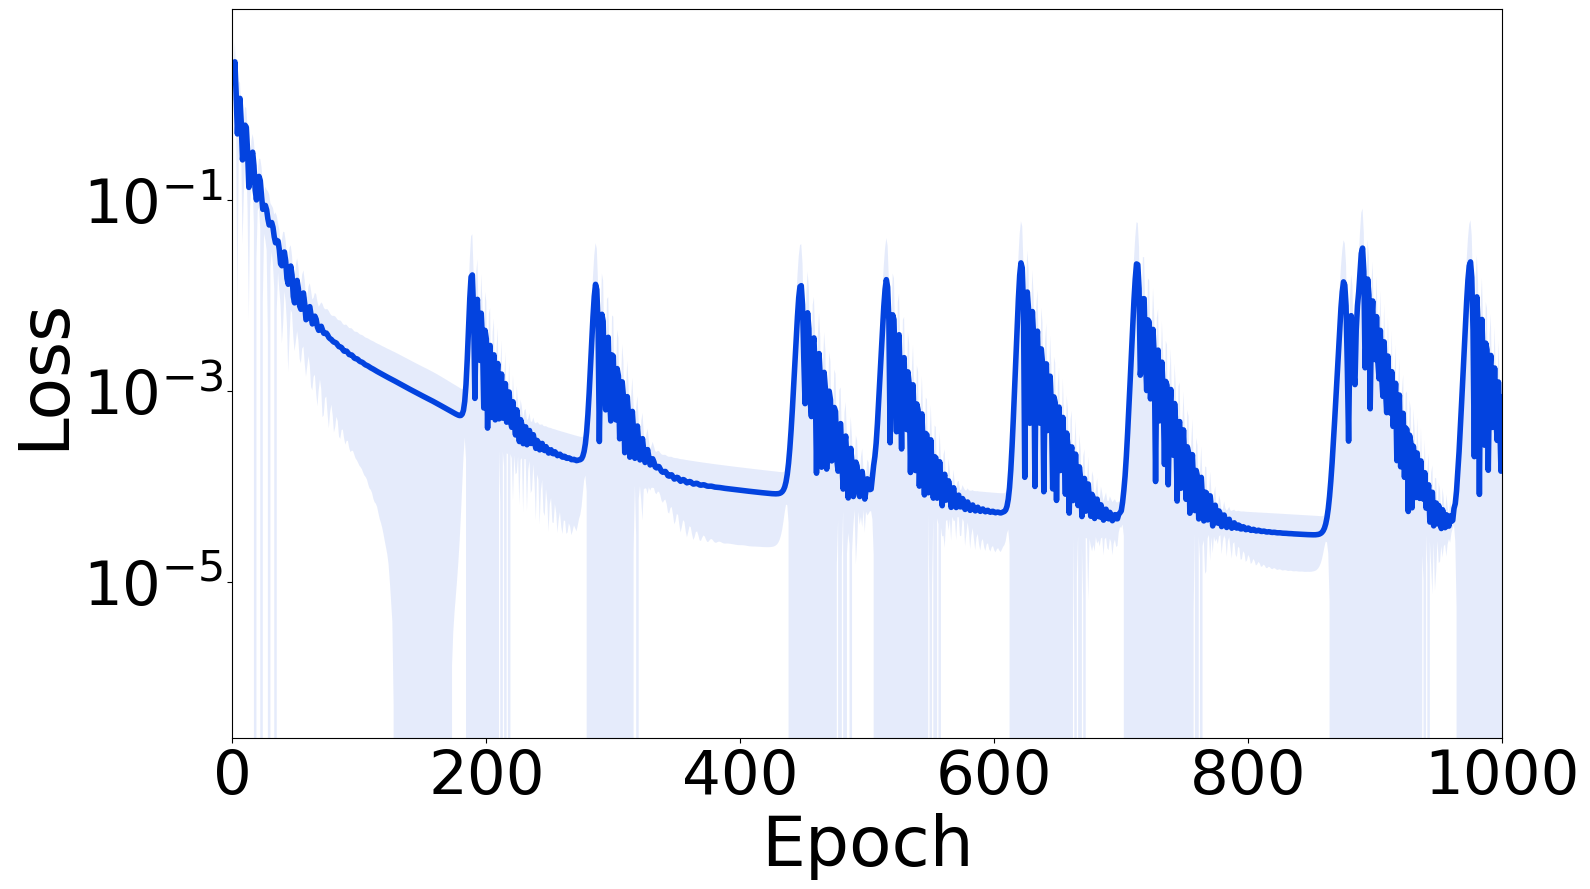

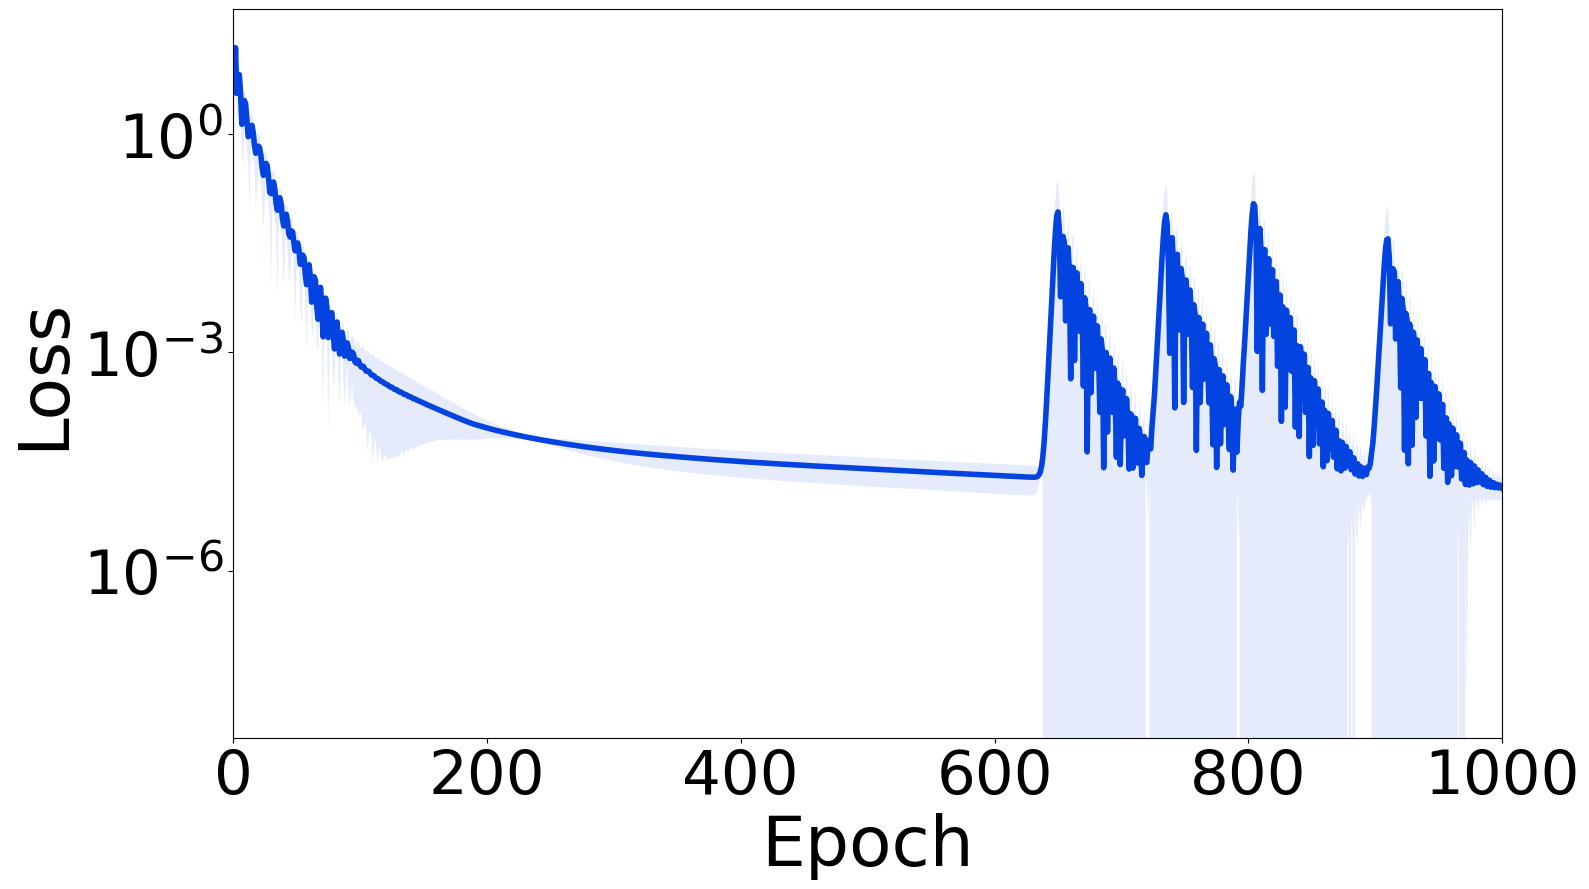

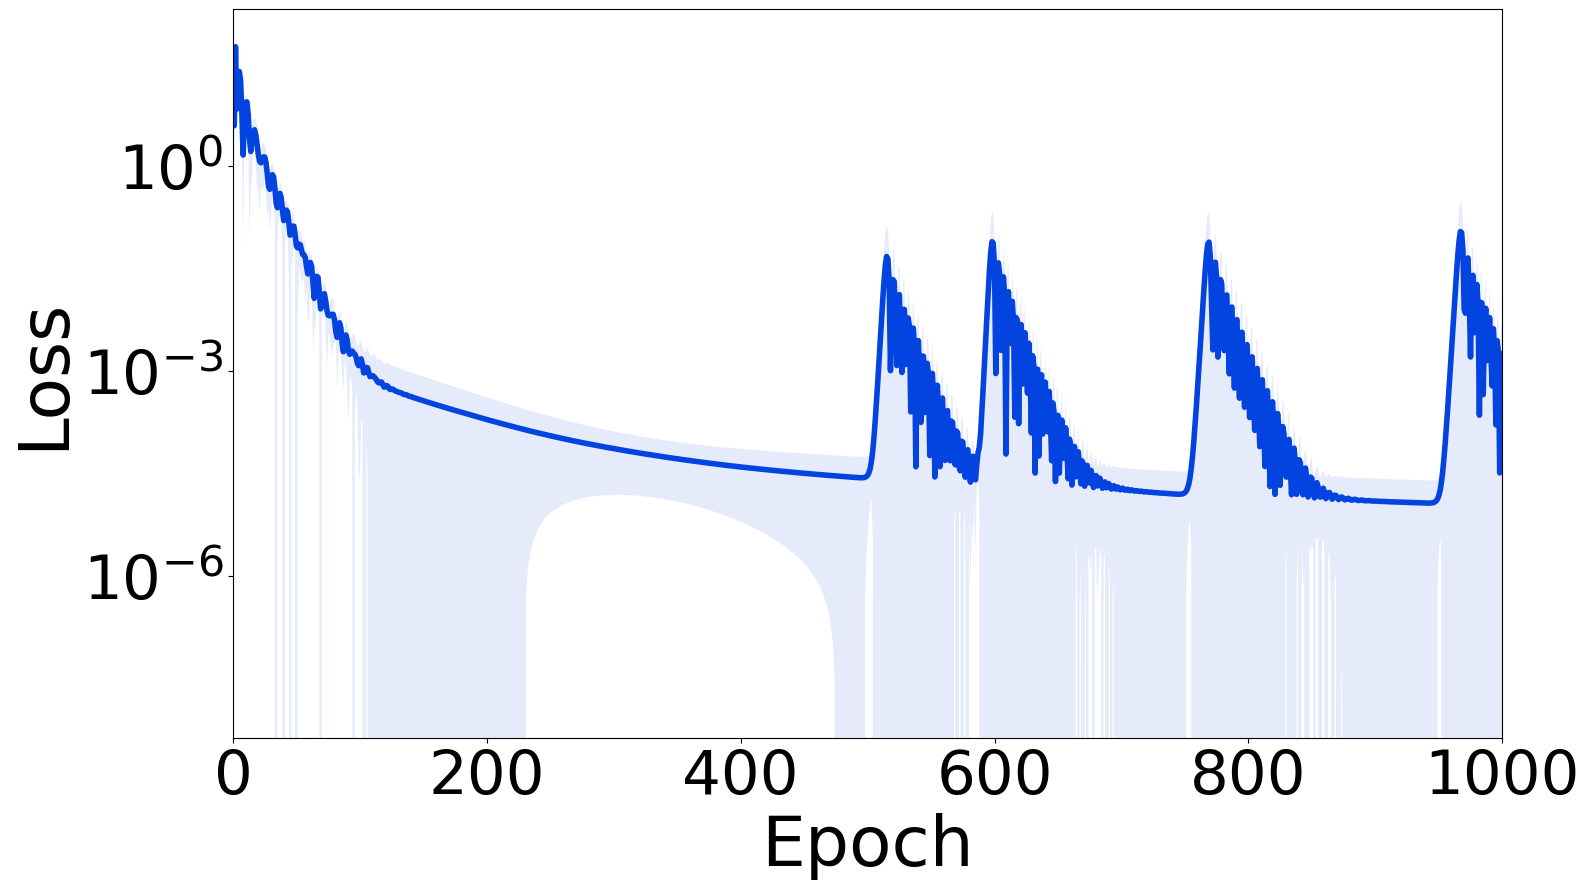

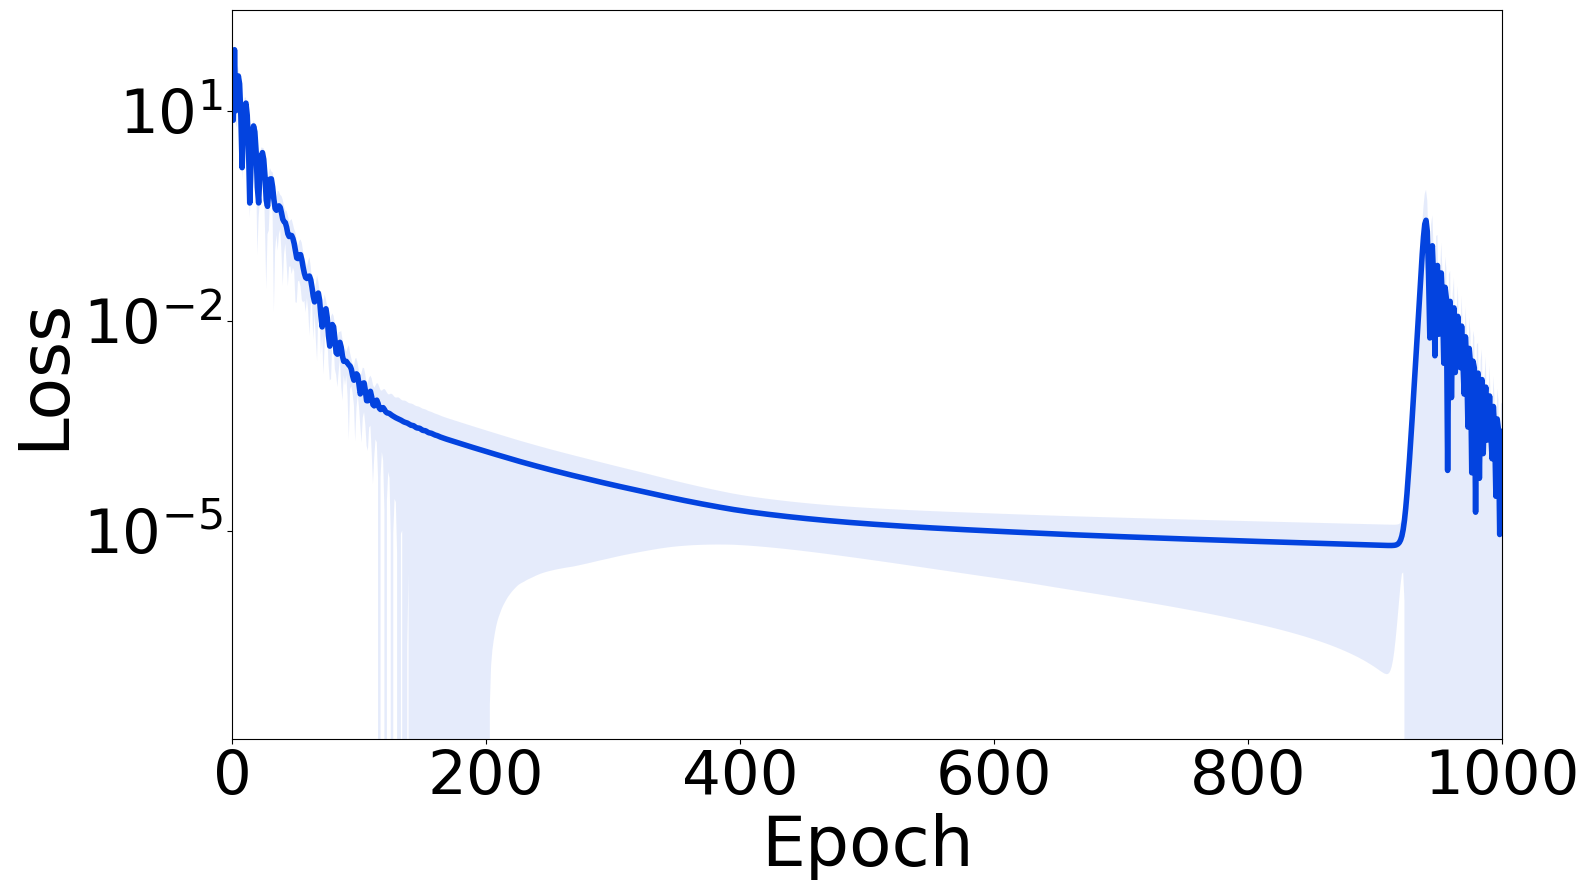

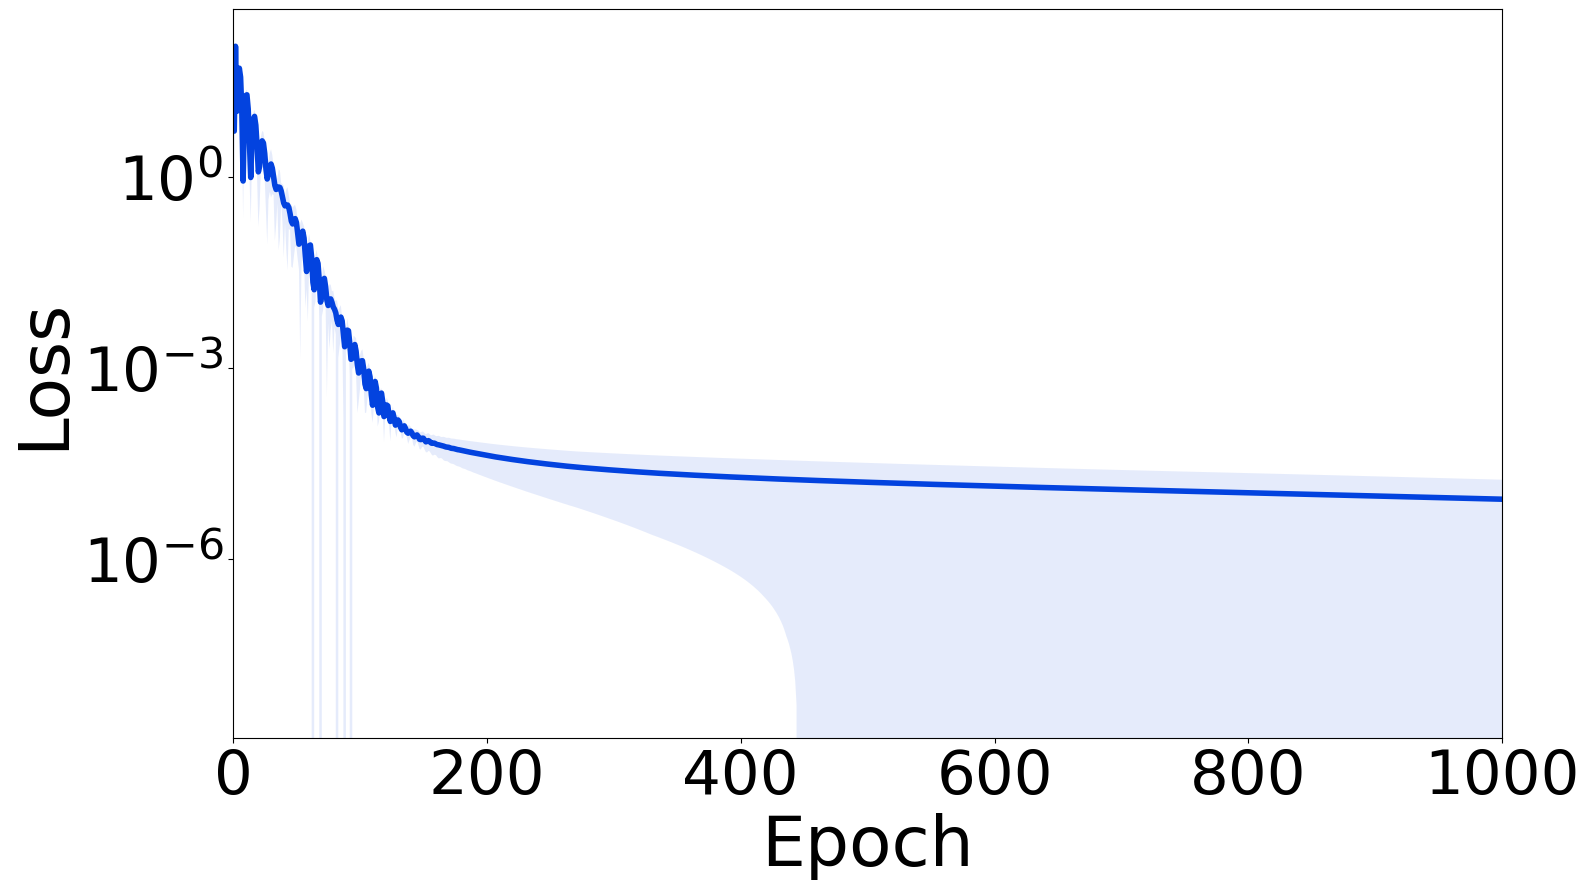

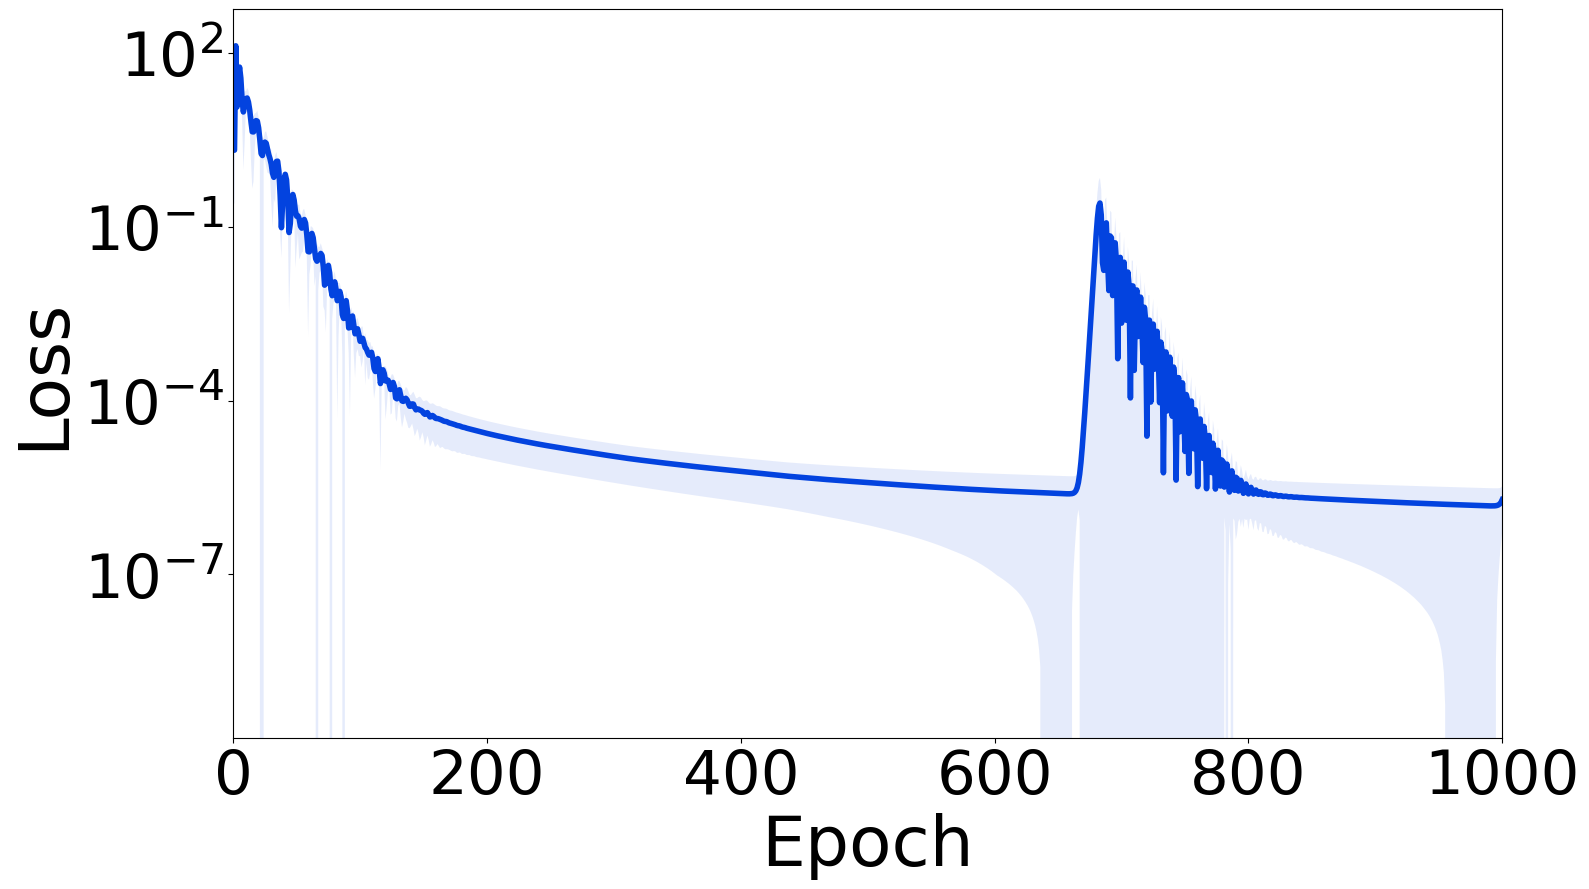

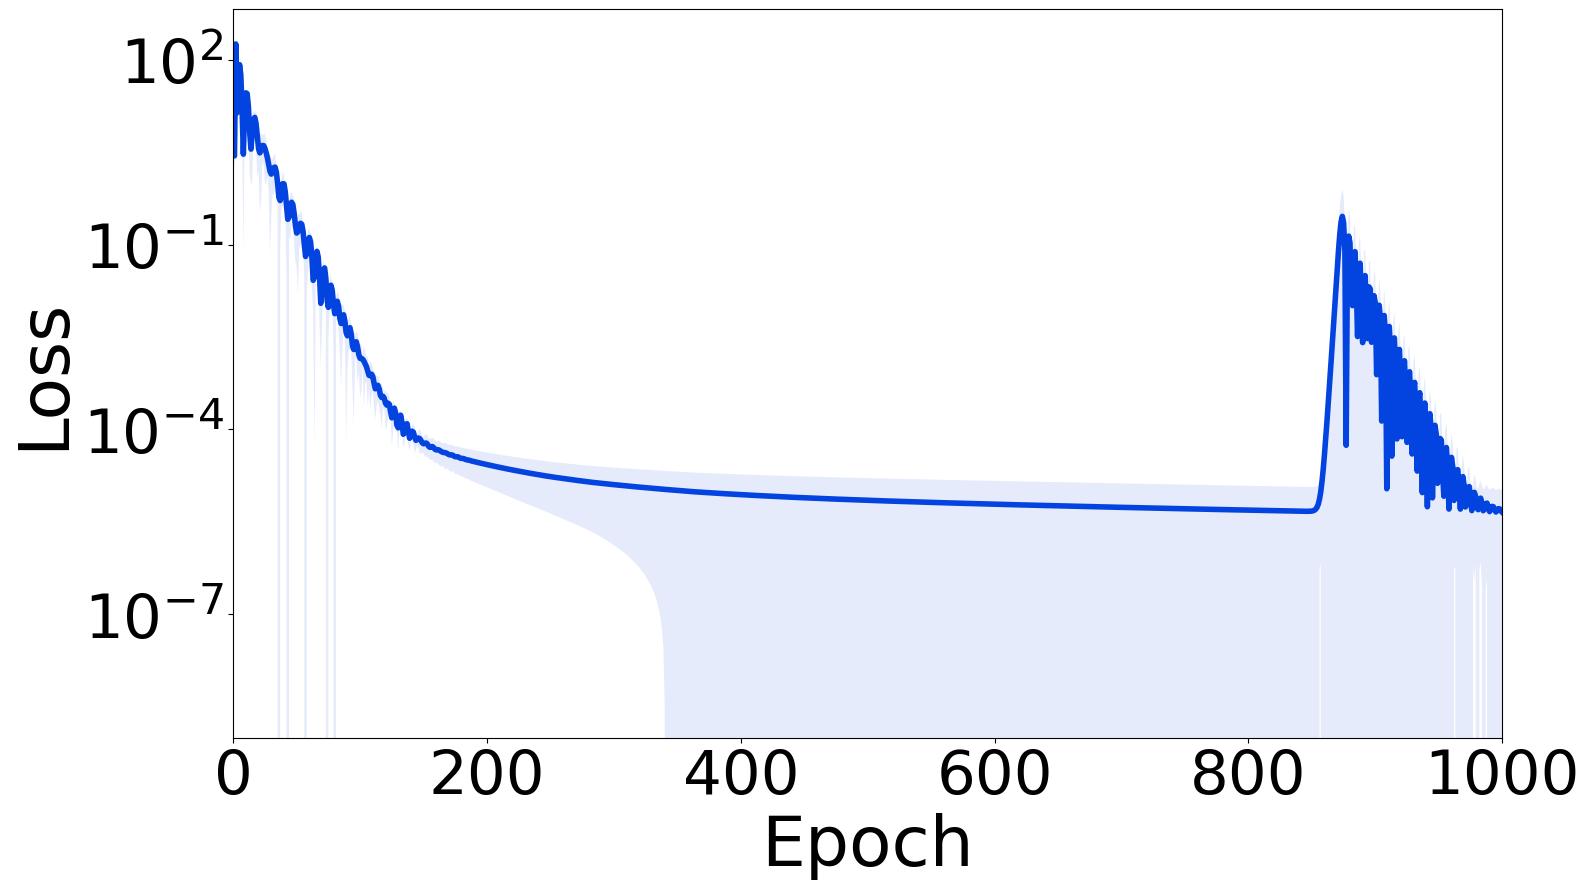

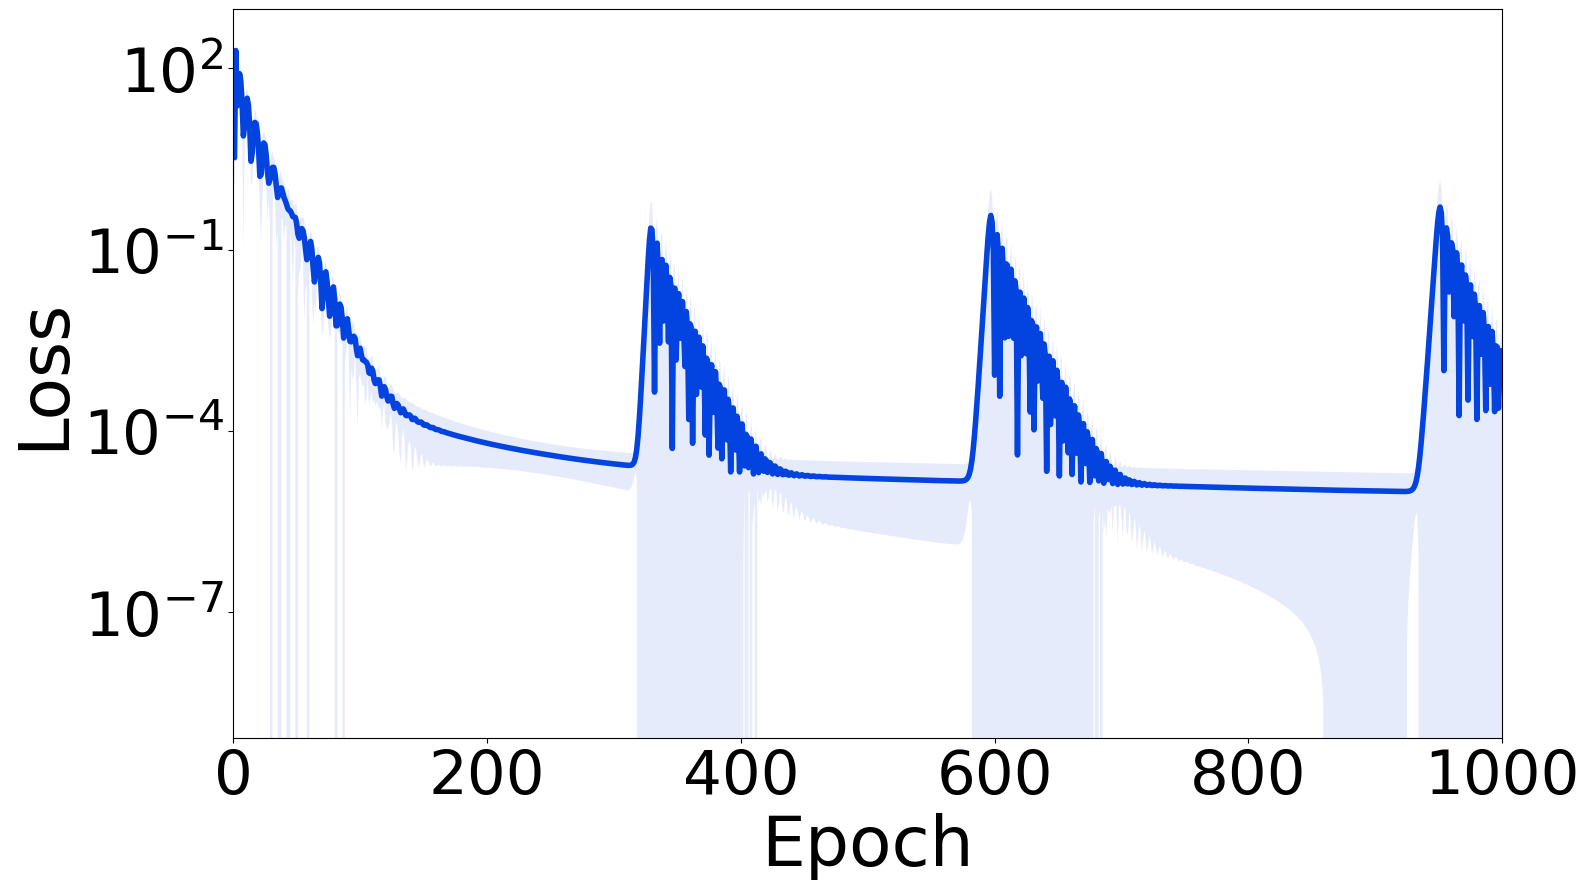

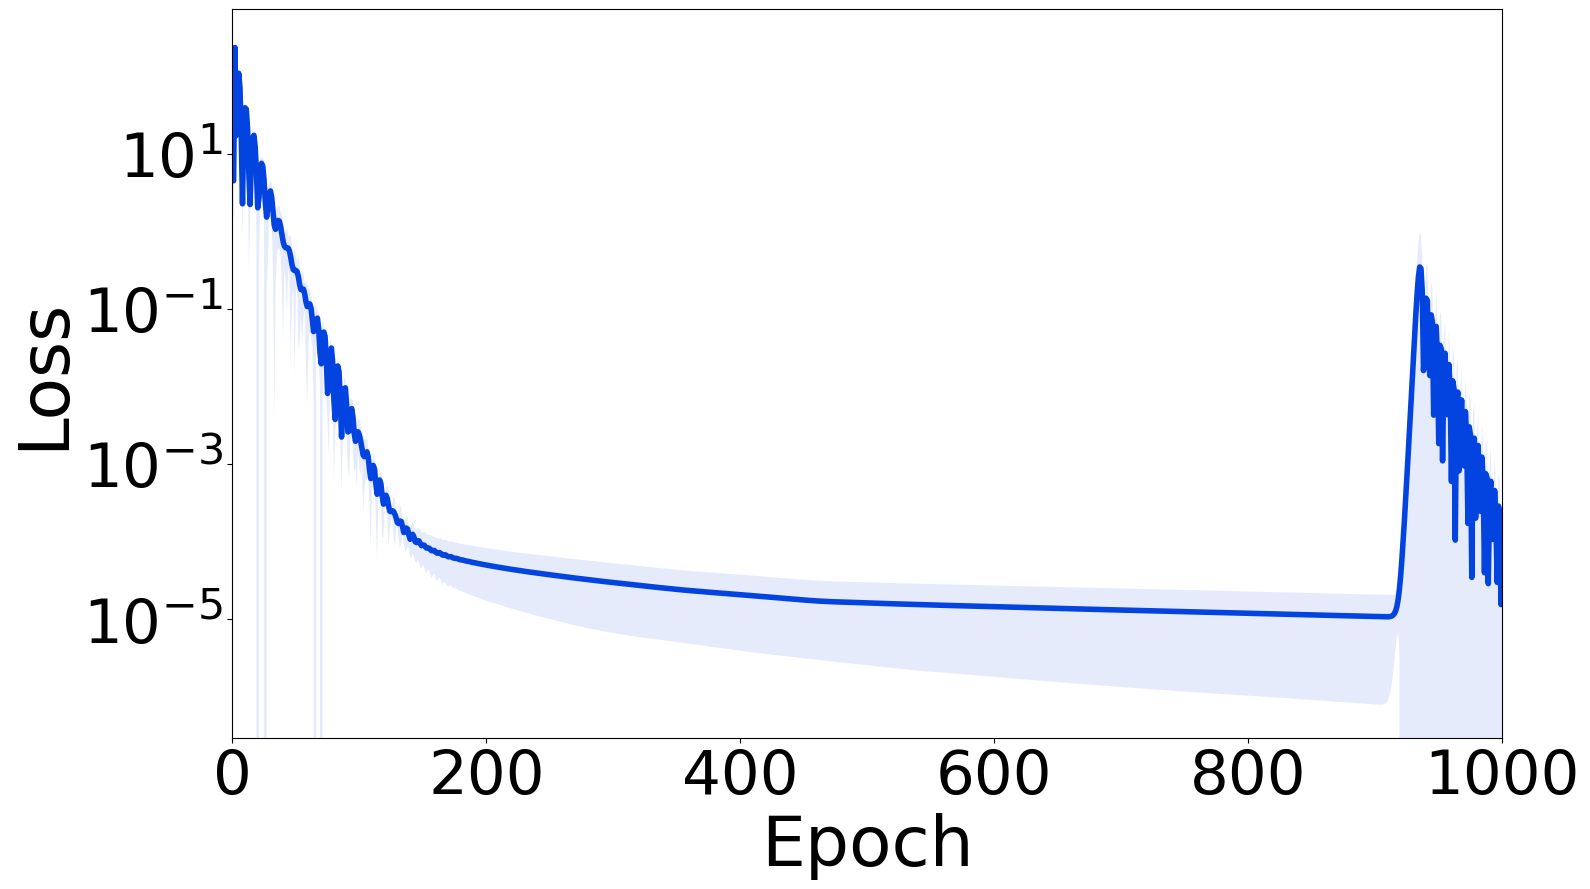

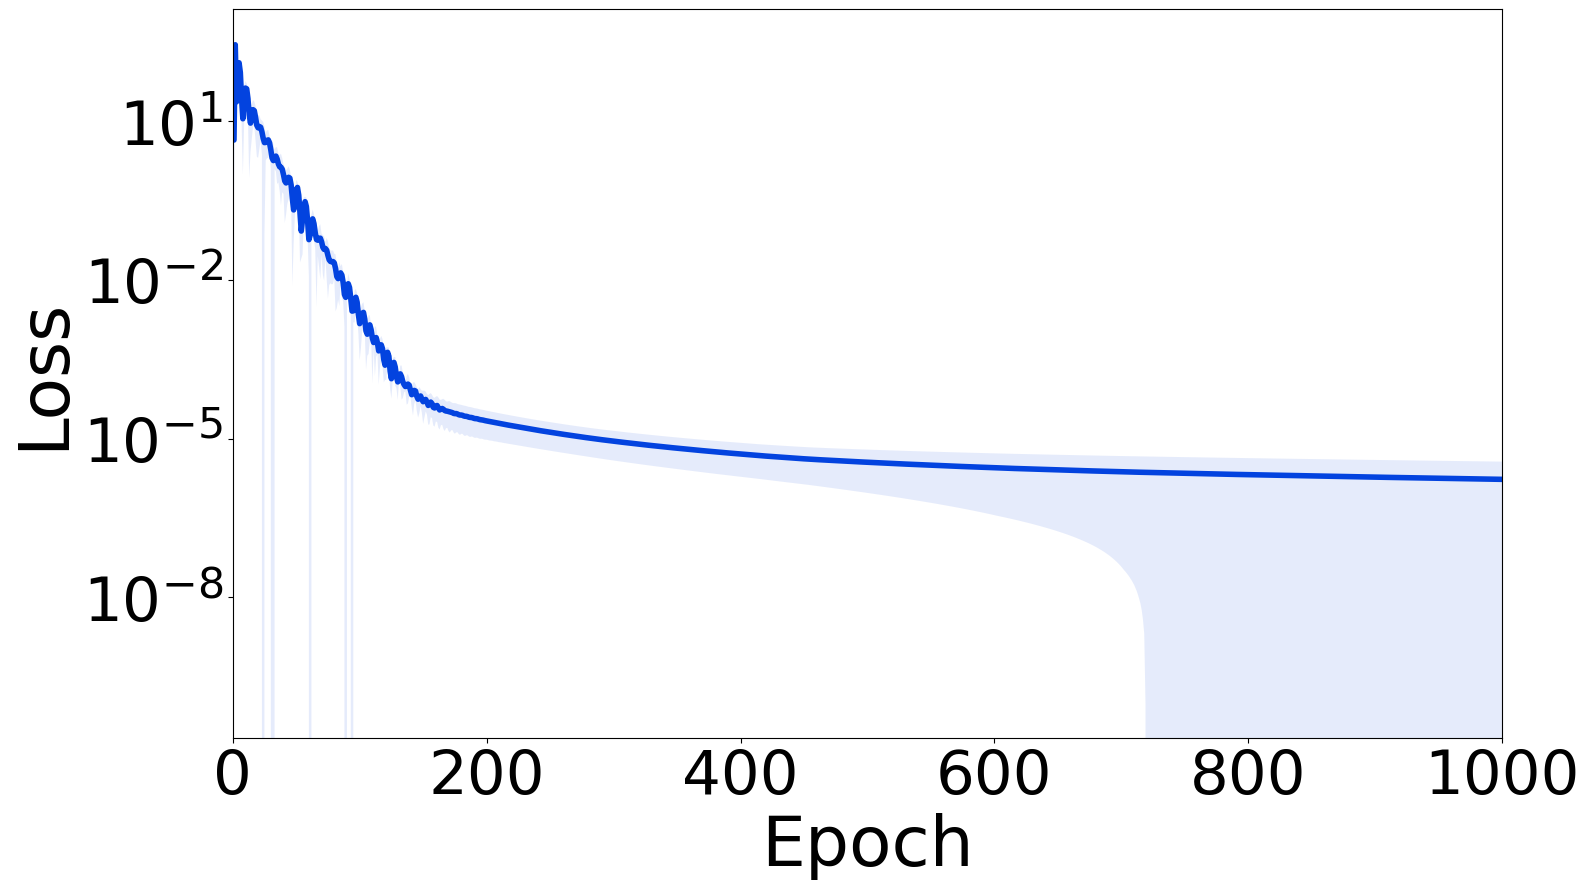

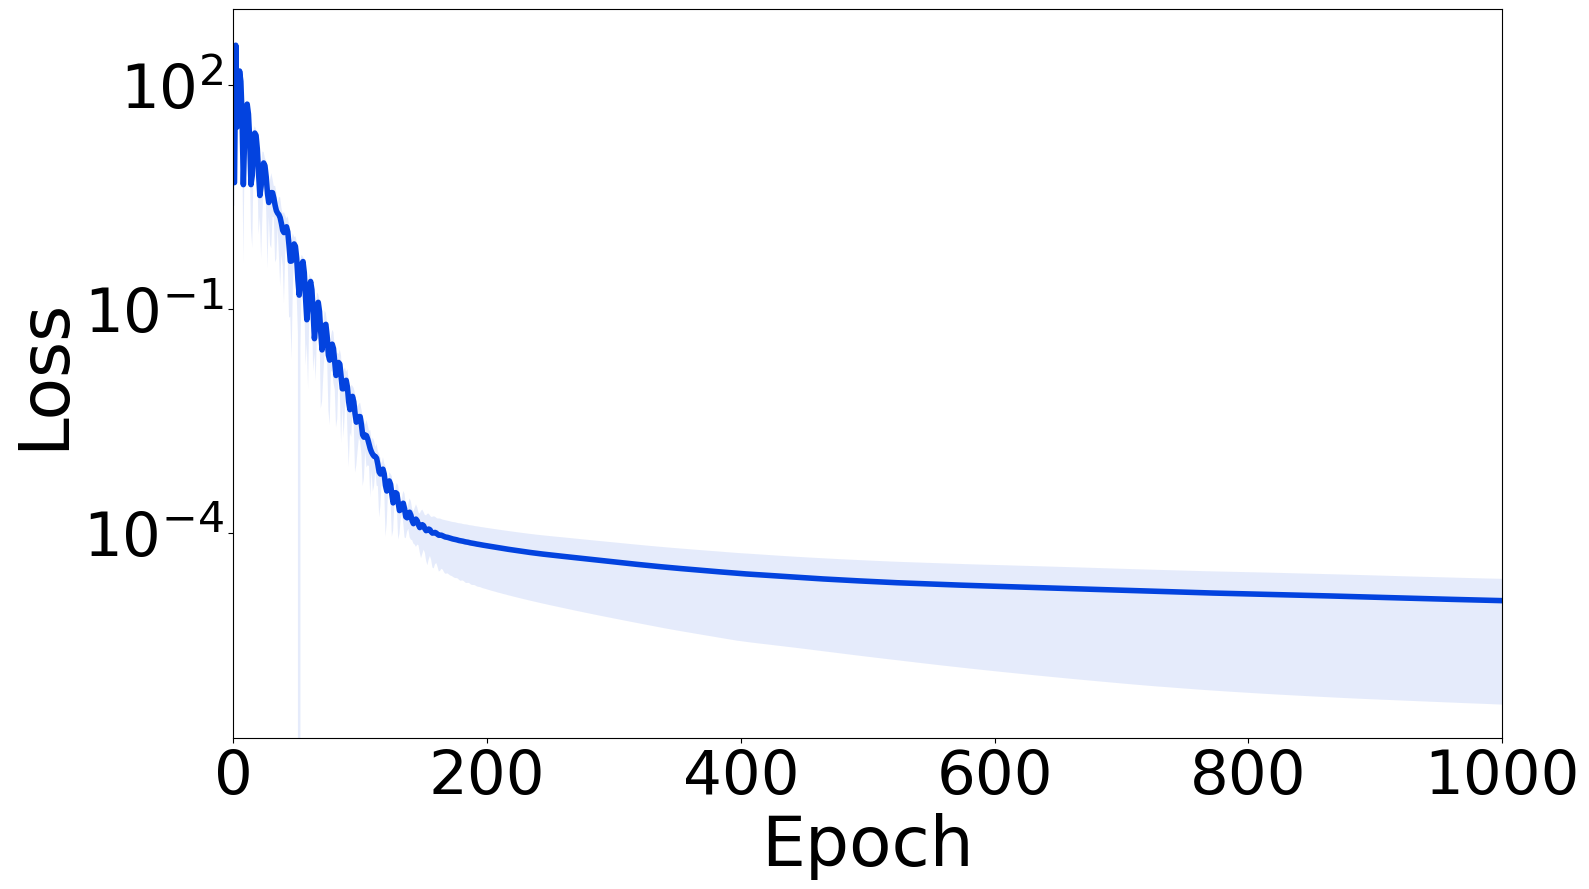

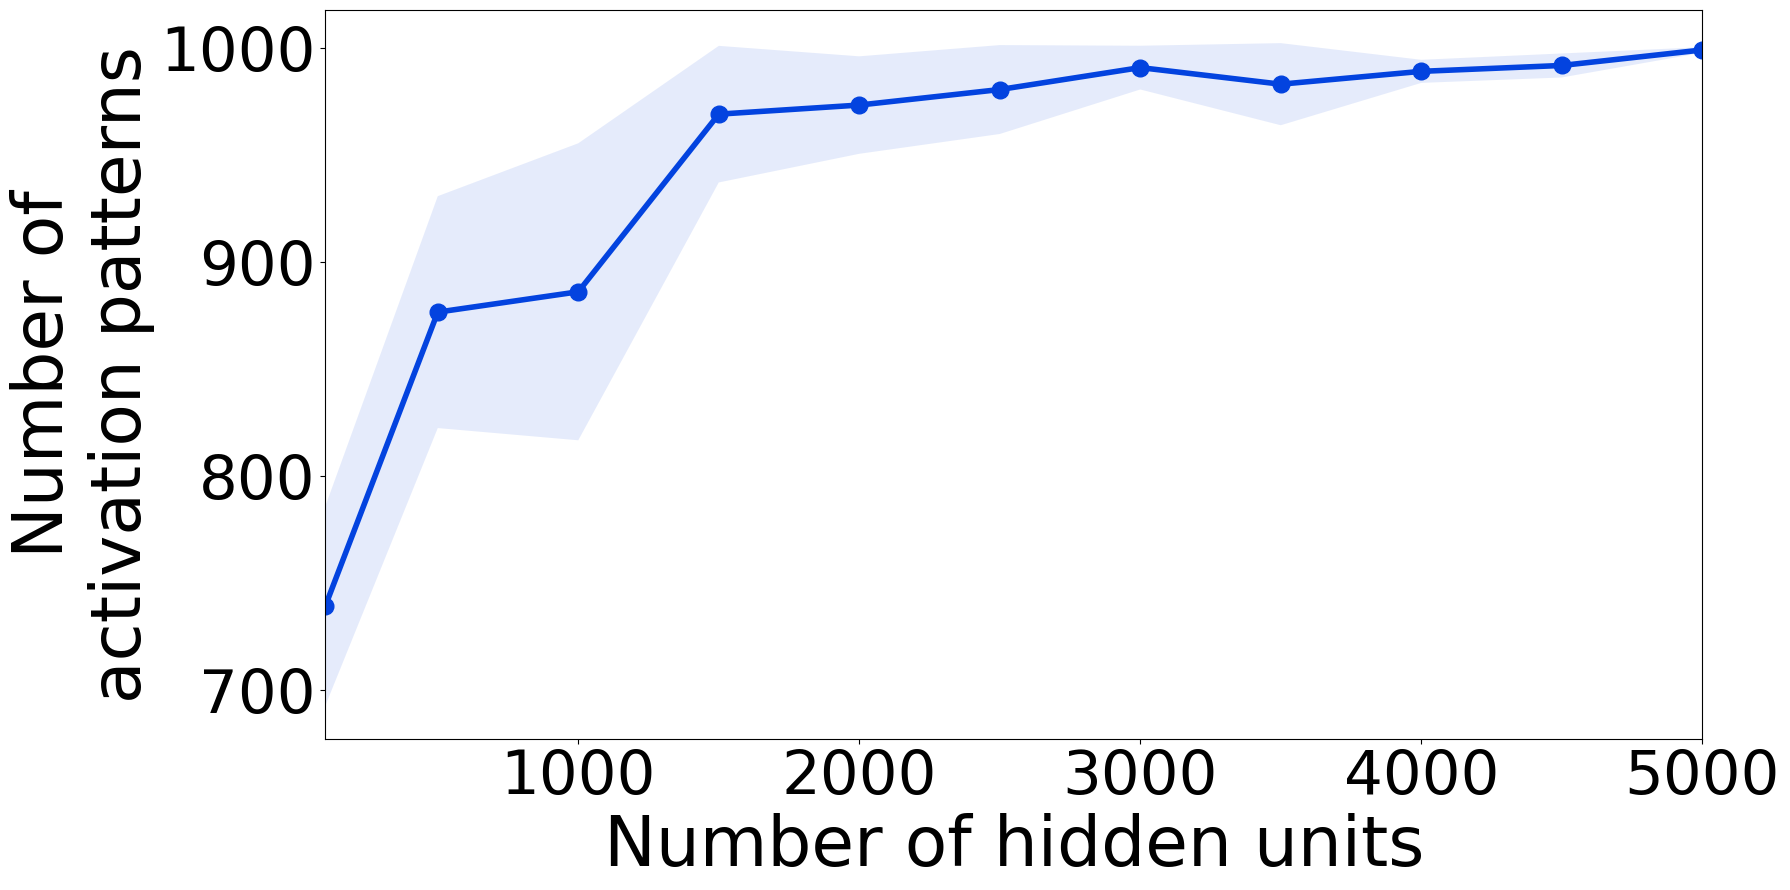

In [40]:
FOLDER_NAME = 'width_to_patterns_num'

def plot_metric(x, y, y_std, ylabel, log, timestamp, xlabel=None):
    if ylabel == 'Number of activation patterns':
        fig = plt.figure(figsize=(18, 9), dpi=100)
    else:
        fig = plt.figure(figsize=(16, 9), dpi=100)
    ax = fig.add_subplot(111)
    ax.tick_params(axis='both', which='major', labelsize=44)
    ax.tick_params(axis='both', which='minor', labelsize=44)
    
    if log:
        ax.set_yscale('log')
    
    if ylabel == 'Number of activation patterns':
        plt.plot(x, y, linewidth=4, color='xkcd:blue', label=ylabel, marker='o', markersize='12')
    else:
        plt.plot(x, y, linewidth=4, color='xkcd:blue', label=ylabel)
    plt.fill_between(x, y - y_std, y + y_std, facecolor='xkcd:blue', alpha=0.1)

    plt.xlim(xmin=x[0], xmax=x[-1])
    ax.yaxis.get_offset_text().set_fontsize(30)
    
    if xlabel is not None:
        plt.xlabel(xlabel, size=50)
    else:
        plt.xlabel('Epoch', size=50)
    
    if ylabel == 'Jacobian rank':
        plt.ylim(ymin=int(np.floor(np.min(y))) - 1, ymax=int(np.ceil(np.max(y))) + 1)

    if ylabel == 'Distance to the closest boundary':
        xticks = [0] + [i * 10 for i in range(1, len(x))]
        ax.set_xticks(x, xticks)
        plt.ylabel('Distance', size=50)
    elif ylabel == 'Number of activation patterns':
        plt.ylabel('Number of\nactivation patterns', size=50)        
    else:
        plt.ylabel(ylabel, size=50)
        
    plt.tight_layout()
    
    plt.savefig(f'images/{FOLDER_NAME}/{timestamp}_{ylabel}.png')
    
#######################################################################################################
#######################################################################################################

timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

################################################
# Generate the plots
################################################

# Plot loss
for d1, loss in zip(d1_arr, total_loss):
    print(f'd1: {d1}')
    loss_mean = np.mean(loss, axis=0)
    loss_std = np.std(loss, axis=0)
    plot_metric(x=list(range(len(loss_mean))), y=loss_mean, y_std=loss_std, ylabel='Loss', log=True,
               timestamp=timestamp)

# Plot the number of activation regions traversed depending on the number of hidden units
pattern_num_mean = np.mean(total_pattern_num, axis=1)
print(f'pattern_num_mean: {pattern_num_mean}')
pattern_num_std = np.std(total_pattern_num, axis=1)
print(f'pattern_num_std: {pattern_num_std}')
plot_metric(x=d1_arr, y=pattern_num_mean, y_std=pattern_num_std, xlabel='Number of hidden units',
            ylabel='Number of activation patterns', log=False, timestamp=timestamp)
    
################################################
# Store data for the later reference
################################################
np.savetxt(f'data/{FOLDER_NAME}/{timestamp}_pattern_num.txt', total_pattern_num)